<a href="https://colab.research.google.com/github/kuiper2000/tornado_seasonal_forecast/blob/main/Paper_Figures_final(1992_2020)_new_backup.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from netCDF4 import Dataset as NetCDFFile
import random
import timeit
import pickle
from scipy import stats
import xarray as xr
import pandas as pd
import statistics
from scipy import interpolate
import os
import pytz, datetime
import multiprocessing as mp
!pip install geopandas
!pip install descartes
#import tensorflow as tf
#from tensorflow import keras
#from tensorflow.keras.layers import Dense, InputLayer, Activation, Input
#from tensorflow.keras.models import load_model, Sequential
#from tensorflow.keras.utils import to_categorical
#from tensorflow.keras import regularizers
#from tensorflow.keras import metrics
#from tensorflow.keras import optimizers
#import tensorflow.keras.backend as K
#from tensorflow.keras.callbacks import LearningRateScheduler

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
import csv
import pytz, datetime
import datetime as dt
from datetime import datetime
from pytz import timezone
import pytz

pph_alli = np.zeros((2021-1992+1,))
filename  = 'pph_T10H30_areathresh_50th_percentile_TORN_monthlycount_1982_2021.csv'
for year in np.arange(1992,2022):
    count = 0
    with open('/content/drive/MyDrive/Colab/2021_research/tornado_data/'+filename) as csvfile:
        readCSV = csv.reader(csvfile, delimiter=',')
        for row in readCSV:
            print(row[0])
            if (row[0]==str(year)) & (str(row[1])!='May'):
                count=count+float(row[2])
            else:
                print('not the chosen year')
    pph_alli[year-1992,]=count

串流輸出內容已截斷至最後 5000 行。
1988
not the chosen year
1988
not the chosen year
1989
not the chosen year
1989
not the chosen year
1989
not the chosen year
1990
not the chosen year
1990
not the chosen year
1990
not the chosen year
1991
not the chosen year
1991
not the chosen year
1991
not the chosen year
1992
not the chosen year
1992
not the chosen year
1992
not the chosen year
1993
not the chosen year
1993
not the chosen year
1993
not the chosen year
1994
not the chosen year
1994
not the chosen year
1994
not the chosen year
1995
not the chosen year
1995
not the chosen year
1995
not the chosen year
1996
not the chosen year
1996
not the chosen year
1996
not the chosen year
1997
not the chosen year
1997
not the chosen year
1997
not the chosen year
1998
not the chosen year
1998
not the chosen year
1998
not the chosen year
1999
not the chosen year
1999
not the chosen year
1999
not the chosen year
2000
not the chosen year
2000
not the chosen year
2000
not the chosen year
2001
2001
2001
not the chosen

In [6]:
!git clone https://github.com/joncutrer/geopandas-tutorial.git
!cd geopandas-tutorial


Cloning into 'geopandas-tutorial'...
remote: Enumerating objects: 48, done.
remote: Counting objects: 100% (48/48), done.
remote: Compressing objects: 100% (33/33), done.
remote: Total 48 (delta 19), reused 39 (delta 14), pack-reused 0
Unpacking objects: 100% (48/48), done.


In [7]:
!ls -al /content/geopandas-tutorial/data

total 7324
drwxr-xr-x 2 root root    4096 Jul  1 00:56 .
drwxr-xr-x 4 root root    4096 Jul  1 00:56 ..
-rw-r--r-- 1 root root 3929143 Jul  1 00:56 1950-2018-torn-aspath.zip
-rw-r--r-- 1 root root 3191635 Jul  1 00:56 1950-2018-torn-initpoint.zip
-rw-r--r-- 1 root root       5 Jul  1 00:56 usa-states-census-2014.cpg
-rw-r--r-- 1 root root   15201 Jul  1 00:56 usa-states-census-2014.dbf
-rw-r--r-- 1 root root     143 Jul  1 00:56 usa-states-census-2014.prj
-rw-r--r-- 1 root root     257 Jul  1 00:56 usa-states-census-2014.qpj
-rw-r--r-- 1 root root  309672 Jul  1 00:56 usa-states-census-2014.shp
-rw-r--r-- 1 root root   18517 Jul  1 00:56 usa-states-census-2014.shp.xml
-rw-r--r-- 1 root root     564 Jul  1 00:56 usa-states-census-2014.shx


In [13]:
!git init
!git add README.md
!git commit -m "first commit"
!git branch -M main
!git remote add origin https://github.com/kuiper2000/tornado_seasonal_forecast.git
!git push -u origin main

Reinitialized existing Git repository in /content/.git/
fatal: pathspec 'README.md' did not match any files
On branch master

Initial commit

Untracked files:
	.config/
	drive/
	geopandas-tutorial/
	sample_data/

nothing added to commit but untracked files present
error: refname refs/heads/master not found
fatal: Branch rename failed
fatal: remote origin already exists.
error: src refspec main does not match any.
error: failed to push some refs to 'https://github.com/kuiper2000/tornado_seasonal_forecast.git'


/content


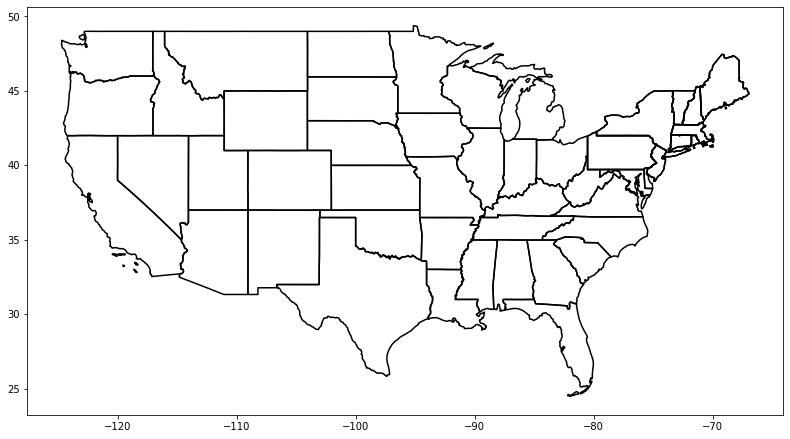

<Figure size 432x288 with 0 Axes>

In [8]:
import geopandas
!pwd
states = geopandas.read_file('/content/geopandas-tutorial/data/usa-states-census-2014.shp')
states = states.to_crs("EPSG:4326")
#states.plot()
fig, axs = plt.subplots(1, 1)
plt.figure()
#plt.style.use('dark_background')
states.boundary.plot(color='black',ax=axs)
fig.set_size_inches(15.5,7.5)
#fig.savefig('/home/Kai-chi.Tseng/2019_research/SPEAR_tornado/CONUS_map.pdf', dpi=300, bbox_inches='tight')


In [9]:
import matplotlib.pyplot as plt
from netCDF4 import Dataset as NetCDFFile

# load all necessary files
# load cape data
dates_PPH       = pd.date_range('1979-01-01', '2019-12-31', freq='1D')
posi            = np.squeeze(np.where((dates_PPH.year>=1992) & (dates_PPH.year<=2017)))
nc              = NetCDFFile("/content/drive/MyDrive/Colab/2021_research/tornado_data/pper_tor_1979_2019.nc")
p_perfect_tor   = nc.variables['p_perfect_tor'][posi,:,:]


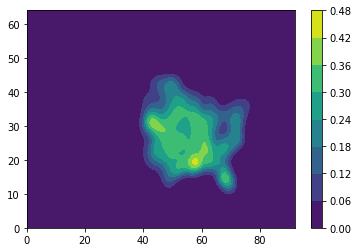

In [10]:
x = nc.variables['x']
y = nc.variables['y']

xx_victor,yy_victor = np.meshgrid(x,y)
#np.shape(xx_victor)
#np.shape(p_perfect_tor)
plt.figure()
cs=plt.contourf(xx_victor,yy_victor,p_perfect_tor[:,:,:].mean(axis=0))
plt.colorbar(cs)
#plt.figure()
#cs=plt.contourf(xx,yy,PPH_daily[:,:,:].mean(axis=0))
#plt.colorbar(cs)

In [11]:
# generate obs SST 
nc                 = NetCDFFile("/content/drive/MyDrive/Colab/2021_research/tornado_data/sst.nc")
sst_obs            = nc.variables['sst'][192:468,0,:,:]
lon_SST_obs        = nc.variables['lon'][:]
lat_SST_obs        = nc.variables['lat'][:]

from datetime import date
# calculate the SST monthly anomaly
dates1              = pd.date_range('1995-01-01', '2017-12-31', freq='M')
sst_monthly_anomaly = np.zeros((12*(2017-1995+1),np.shape(sst_obs)[1],np.shape(sst_obs)[2]))


count=0
for year in range(1995,2018):    
    for month in range(1,13):
        posi =np.squeeze(np.where((dates1.year==year) & (dates1.month==month)))
        posi2=np.squeeze(np.where((dates1.month==month)))
        # without climatological seasonal cycle  
        sst_monthly_anomaly[count,:,:]              = np.squeeze(sst_obs[posi,:,:])-\
                                                      sst_obs[posi2,:,:].mean(axis=0)
        count=count+1


# generate land sea mask
lat           = np.arange(15,70,0.5)
lon           = np.arange(150,300,0.5)        
f             = interpolate.interp2d(lon_SST_obs,lat_SST_obs,sst_monthly_anomaly[0,:,:],kind='linear')
land_sea_mask = f(lon,lat)
land_sea_mask[land_sea_mask<-100] = 0
land_sea_mask[land_sea_mask!=0]   = 1
land_sea_mask                     = 1-land_sea_mask

In [14]:
dates1              = pd.date_range('1979-01-01', '2020-12-31', freq='M')
print(np.where(dates1.year==2020))

(array([492, 493, 494, 495, 496, 497, 498, 499, 500, 501, 502, 503]),)


In [15]:
# load SPEAR SST data
sst_model          = np.zeros((12,276,360,576))    # initialization month, forecast month (different lead mix), y, x 
sst_model_ens      = np.zeros((15,276,360,576)) # initialization month, forecast month (different lead mix), y, x 
#sst_model_Apr=np.zeros((276,360,576))
#sst_model_Jul=np.zeros((276,360,576))
#sst_model_Oct=np.zeros((15,276,360,576))
#os.system('dmget /archive/Kai-chi.Tseng/data/SPEAR_Med/OTA_IceAtmRes_L33/SST/*.nc')
count = 0
for init_time in ['01','02','03','04','05','06','07','08','09','10','11','12']:
    print(init_time)
    dates = pd.date_range('1992-'+init_time,  periods=276, freq='1M') # total length of reanalysis data
    posi  = np.squeeze(np.where((dates.year>=1995) & (dates.year<=2017)))
    for ens in range(1,16,1):
        nc    = NetCDFFile("/content/drive/MyDrive/Colab/2021_research/tornado_data/sst/SST_"+init_time+"_ens%02d.nc" % (ens,))
        data  = nc.variables['SST'][:,:,:]
        sst_model_ens[ens-1,:,:,:] = data[36:36+276,:,:]
        #sst_model_ens[ens-1,count,:,:,:] = data[:,:,:]
    sst_model[count,:,:,:]=sst_model_ens[:,:,:,:].mean(axis=0)
    count=count+1
del sst_model_ens

01
02
03
04
05
06
07
08
09
10
11
12


In [16]:
del data, nc 

In [17]:
posi_x     = np.where((lon_SST_obs>190) & (lon_SST_obs<240))
posi_y     = np.where((lat_SST_obs>=-5) & (lat_SST_obs<=5))
max_x      = np.max(posi_x)
min_x      = np.min(posi_x)
max_y      = np.max(posi_y)
min_y      = np.min(posi_y)
NINO34     = (sst_model[:,:,min_y:max_y,min_x:max_x].mean(axis=2)).mean(axis=2)
NINO34_obs = (sst_monthly_anomaly[:,min_y:max_y,min_x:max_x].mean(axis=1)).mean(axis=1)

#NINO34_score = np.zeros((12,12))
NINO34     = (np.reshape(NINO34,[12,23,12])-np.mean(NINO34))/np.std(NINO34)
NINO34_obs = (np.reshape(NINO34_obs,[23,12])-np.mean(NINO34_obs))/np.std(NINO34_obs)

#NINO34     = (np.reshape(NINO34,[12,23,12]))/np.std(NINO34)
#NINO34_obs = (np.reshape(NINO34_obs,[23,12]))/np.std(NINO34_obs)


In [ ]:
sst_model    = np.reshape(sst_model,[12,23,12,360,576])
sst_template = sst_model[11,:,11,:,:]
series1      = (NINO34[11,:,11]-np.mean(NINO34[11,:,11]))/np.std(NINO34[11,:,11])

sst_template       = np.reshape(sst_template,[sst_template.shape[0],sst_template.shape[1]*sst_template.shape[2]]) # reshape 3D array to 2D array for matrix operation
X_mat              = np.vstack((np.ones(sst_template[:,:].shape[0]), series1)).T

# coef_total = (X^T X)^(-1) (X^T Y) (you can check wikipedia: https://en.wikipedia.org/wiki/Linear_regression, section: Least-squares estimation and related techniques)
# coef_total contains both b and a. the first dimension of coef_total is b and the second dimension of coef_total is a  
coef_total         = np.linalg.inv(X_mat.T.dot(X_mat)).dot(X_mat.T).dot(sst_template)

# as mentioned previously, "a" represents the warming trend of cape and "b" is the cape value in reference year
sst_NINO34         = np.reshape(coef_total[1,:],[360,576])
sst_NINO34[sst_NINO34<-100] = 0

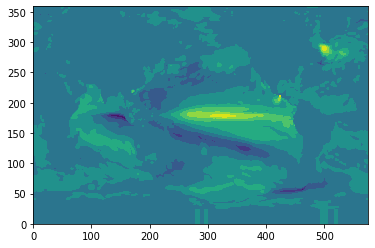

In [ ]:
plt.figure()
plt.contourf(sst_NINO34)

array([[ 1.        , -0.13970482],
       [-0.13970482,  1.        ]])

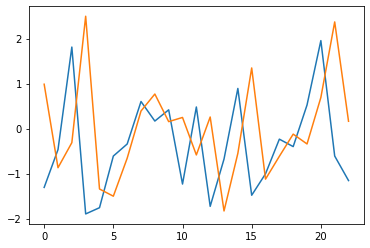

In [ ]:
np.shape(NINO34)
init=11
plt.figure()
plt.plot(NINO34[init,:,1])
plt.plot(NINO34_obs[:,1])
np.corrcoef(NINO34[init,:,1],NINO34_obs[:,1])

# Figure 1

In [ ]:
NINO34_scores = np.zeros((12,12))

count = 0
for init_time in ['01','02','03','04','05','06','07','08','09','10','11','12']:
    #print(init_time)
    dates  = pd.date_range('1995-'+init_time, '2017-12-31', freq='12m') # total length of reanalysis data
    dates2 = pd.date_range('1995-01', '2017-12-31', freq='12m')
    #print((dates.month[0])-1)
    for forecast_lead in range(12):
        print(((dates.month)[0]-1+forecast_lead)%12)
        if ((dates.month)[0]-1+forecast_lead) <12:
            NINO34_scores[count,forecast_lead] = np.corrcoef(NINO34_obs[:,((dates.month)[0]-1+forecast_lead)%12],\
                                                             NINO34[count,np.arange(np.size(dates)),forecast_lead])[0][1]
        else:
            NINO34_scores[count,forecast_lead] = np.corrcoef(NINO34_obs[1:,((dates.month)[0]-1+forecast_lead)%12],\
                                                             NINO34[count,np.arange(np.size(dates))[0:-1],forecast_lead])[0][1]
        
    count = count+1

0
1
2
3
4
5
6
7
8
9
10
11
1
2
3
4
5
6
7
8
9
10
11
0
2
3
4
5
6
7
8
9
10
11
0
1
3
4
5
6
7
8
9
10
11
0
1
2
4
5
6
7
8
9
10
11
0
1
2
3
5
6
7
8
9
10
11
0
1
2
3
4
6
7
8
9
10
11
0
1
2
3
4
5
7
8
9
10
11
0
1
2
3
4
5
6
8
9
10
11
0
1
2
3
4
5
6
7
9
10
11
0
1
2
3
4
5
6
7
8
10
11
0
1
2
3
4
5
6
7
8
9
11
0
1
2
3
4
5
6
7
8
9
10


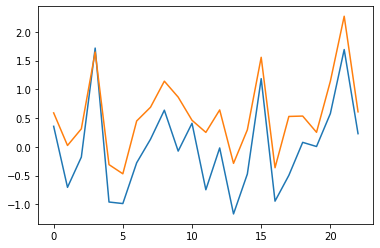

In [ ]:
plt.plot(NINO34_obs[:,2])
plt.plot(NINO34[2,:,0])

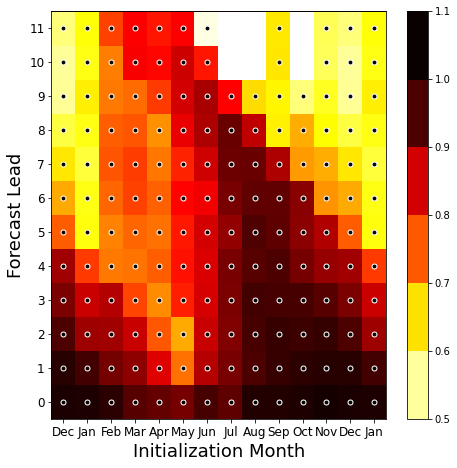

In [ ]:
my_map = 'hot_r'
score_map2            = np.zeros((14,14))
score_map2[1:-1,1:-1] = NINO34_scores
score_map2[0,1:-1]    = NINO34_scores[-1,:]
score_map2[-1,1:-1]   = NINO34_scores[0,:]
score_map2[:,0]       = score_map2[:,-2]
score_map2[:,-1]      = score_map2[:,1]


fig = plt.figure()
cs  = plt.pcolor(np.transpose(score_map2[:,1:]),vmin=0.5,vmax=1,cmap=my_map)
plt.colorbar(cs,boundaries=np.arange(0.5,1.1,0.1), ticks=np.arange(0.5,1.1,0.1))
plt.xticks(np.arange(0.5,17,1),('Dec','Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct', 'Nov',\
                                'Dec','Jan','Feb','Mar','Apr'),fontsize=12)
plt.yticks(np.arange(0.5,12,1),np.arange(0,12,1),fontsize=12)
plt.ylim([0,12])

#for j in range(0,14):
#    x1 = [j,j+1,j+1,j]
#    y1 = [(j)-1+1,(j)-1+1,(j)-1+2,(j)-1+2]
#    plt.fill(x1,y1 , facecolor="white",edgecolor='y',hatch='//',alpha=0.3,linewidth=3)
plt.xlabel('Initialization Month',fontsize=18)
plt.ylabel('Forecast Lead',fontsize=18)
fig.set_size_inches(7.5, 7.5)    
posi_x,posi_y = np.where(score_map2>0.505)
plt.scatter(posi_x+0.5,posi_y-0.5,25,'w')
plt.scatter(posi_x+0.5,posi_y-0.5,8,'k')

In [ ]:
# using target to plot the first month 
score_map3            = np.zeros((12,12))
score_map4            = np.zeros((12,12))

for forecast_lead in range(0,12):
    for init_month in range(1,13):
        if (init_month+forecast_lead)%12 ==0:
           target_month=12
        else:
           target_month = (init_month+forecast_lead)%12
        score_map3[init_month-1,target_month-1] = NINO34_scores[init_month-1,forecast_lead]
        score_map4[init_month-1,target_month-1] = NINO34_scores[init_month-1,forecast_lead]-np.mean(NINO34_scores[:,forecast_lead])
        print('init_month='+str(init_month)+' forecast lead ='+str(forecast_lead)+' target_month=' +str(target_month))

init_month=1 forecast lead =0 target_month=1
init_month=2 forecast lead =0 target_month=2
init_month=3 forecast lead =0 target_month=3
init_month=4 forecast lead =0 target_month=4
init_month=5 forecast lead =0 target_month=5
init_month=6 forecast lead =0 target_month=6
init_month=7 forecast lead =0 target_month=7
init_month=8 forecast lead =0 target_month=8
init_month=9 forecast lead =0 target_month=9
init_month=10 forecast lead =0 target_month=10
init_month=11 forecast lead =0 target_month=11
init_month=12 forecast lead =0 target_month=12
init_month=1 forecast lead =1 target_month=2
init_month=2 forecast lead =1 target_month=3
init_month=3 forecast lead =1 target_month=4
init_month=4 forecast lead =1 target_month=5
init_month=5 forecast lead =1 target_month=6
init_month=6 forecast lead =1 target_month=7
init_month=7 forecast lead =1 target_month=8
init_month=8 forecast lead =1 target_month=9
init_month=9 forecast lead =1 target_month=10
init_month=10 forecast lead =1 target_month=11
i

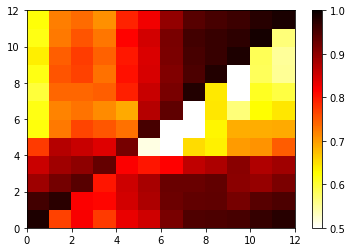

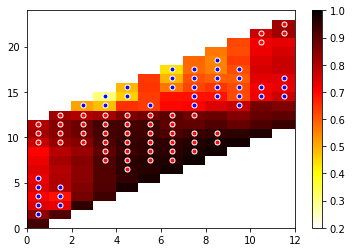

In [ ]:
plt.figure()
cs=plt.pcolor(score_map3.T,vmin=0.5,vmax=1,cmap='hot_r')
plt.colorbar(cs)

new = np.concatenate((score_map3, score_map3,score_map3,score_map3),axis=0)
new = np.concatenate((new, new, new,new),axis=1)

new2 = np.concatenate((score_map4, score_map4,score_map4,score_map4),axis=0)
new2 = np.concatenate((new2, new2, new2,new2),axis=1)

score_map_NINO34 = (new.T)[11+4:11+4+24,11+4:11+4+12]
score_map_NINO34_2 = (new2.T)[11+4:11+4+24,11+4:11+4+12]
for i in range(12):
    for j in range(24):
        if ((j-i)>11 and (j>i)):
          score_map_NINO34[j,i]=0
        elif ((i-j)<12 and (i>j)):
          score_map_NINO34[j,i]=0

plt.figure()
cs=plt.pcolor(score_map_NINO34,cmap='hot_r',vmax=1,vmin=0.2)
plt.colorbar(cs)


posi_x,posi_y = np.where((score_map_NINO34_2.T>0.05) & (score_map_NINO34.T>0))
plt.scatter(posi_x+0.5,posi_y+0.5,25,'w')
plt.scatter(posi_x+0.5,posi_y+0.5,8,'r')

posi_x,posi_y = np.where((score_map_NINO34_2.T<-0.07) & (score_map_NINO34.T>0))
plt.scatter(posi_x+0.5,posi_y+0.5,25,'w')
plt.scatter(posi_x+0.5,posi_y+0.5,8,'b')



In [ ]:
# reload temperature data (1992-2021)
del sst_model
sst_model          = np.zeros((12,360,360,576))    # initialization month, forecast month (different lead mix), y, x 
sst_model_ens      = np.zeros((15,360,360,576)) # initialization month, forecast month (different lead mix), y, x 
#sst_model_Apr=np.zeros((276,360,576))
#sst_model_Jul=np.zeros((276,360,576))
#sst_model_Oct=np.zeros((15,276,360,576))
#os.system('dmget /archive/Kai-chi.Tseng/data/SPEAR_Med/OTA_IceAtmRes_L33/SST/*.nc')
count = 0
for init_time in ['01','02','03','04','05','06','07','08','09','10','11','12']:
    print(init_time)
    dates = pd.date_range('1992-'+init_time,  periods=360, freq='1M') # total length of reanalysis data
    posi  = np.squeeze(np.where((dates.year>=1992) & (dates.year<=2021)))
    for ens in range(1,16,1):
        nc    = NetCDFFile("/content/drive/MyDrive/Colab/2021_research/tornado_data/sst/SST_"+init_time+"_ens%02d.nc" % (ens,))
        data  = nc.variables['SST'][:,:,:]
        sst_model_ens[ens-1,:,:,:] = data[:360,:,:]
        #sst_model_ens[ens-1,count,:,:,:] = data[36:36+276,:,:]
        #sst_model_ens[ens-1,count,:,:,:] = data[:360,:,:]
    sst_model[count,:,:,:]=sst_model_ens[:,:,:,:].mean(axis=0)
    count=count+1
    
del sst_model_ens, data, nc     
    
posi_x     = np.where((lon_SST_obs>190) & (lon_SST_obs<240))
posi_y     = np.where((lat_SST_obs>=-5) & (lat_SST_obs<=5))
max_x      = np.max(posi_x)
min_x      = np.min(posi_x)
max_y      = np.max(posi_y)
min_y      = np.min(posi_y)
NINO34     = (sst_model[:,:,min_y:max_y,min_x:max_x].mean(axis=2)).mean(axis=2)
NINO34_obs = (sst_monthly_anomaly[:,min_y:max_y,min_x:max_x].mean(axis=1)).mean(axis=1)

#NINO34_score = np.zeros((12,12))
NINO34     = (np.reshape(NINO34,[12,30,12])-np.mean(NINO34))/np.std(NINO34)
NINO34_obs = (np.reshape(NINO34_obs,[23,12])-np.mean(NINO34_obs))/np.std(NINO34_obs)
del sst_monthly_anomaly

01
02
03
04
05
06
07
08
09
10
11
12


In [ ]:
# display the size of each variable 
import sys
def sizeof_fmt(num, suffix='B'):
    ''' by Fred Cirera,  https://stackoverflow.com/a/1094933/1870254, modified'''
    for unit in ['','Ki','Mi','Gi','Ti','Pi','Ei','Zi']:
        if abs(num) < 1024.0:
            return "%3.1f %s%s" % (num, unit, suffix)
        num /= 1024.0
    return "%.1f %s%s" % (num, 'Yi', suffix)

for name, size in sorted(((name, sys.getsizeof(value)) for name, value in locals().items()),
                         key= lambda x: -x[1])[:10]:
    print("{:>30}: {:>8}".format(name, sizeof_fmt(size)))


                     sst_model:  6.7 GiB
                    coef_total:  3.2 MiB
                 land_sea_mask: 257.9 KiB
                     dates_PPH: 117.0 KiB
                        NINO34: 33.9 KiB
                        states: 29.8 KiB
                           new: 18.1 KiB
                          new2: 18.1 KiB
                        dates1:  4.0 KiB
                         dates:  2.8 KiB


In [ ]:
# correlation between tornado PPH and NINO3.4 index
# generate monthly data
#os.system("dmget /archive/Kai-chi.Tseng/data/SPEAR_tornado_seasonal/ERA5_daily_data.npz")
data               = np.load('/content/drive/MyDrive/Colab/2021_research/tornado_data/ERA5_daily_data.npz')
PPH_daily_1995     = data['PPH_daily'] 
#os.system("dmget /archive/Kai-chi.Tseng/data/SPEAR_tornado_seasonal/PPH_1992_2021.npz")
data               = np.load('/content/drive/MyDrive/Colab/2021_research/tornado_data/PPH_1992_2021.npz')
PPH_6h             = data['PPH_tornado2']
del data 
dates_6h           = pd.date_range('1992-01-01-00:00', '2021-12-31-18:00', freq='6H')
dates_1D           = pd.date_range('1992-01-01', '2021-12-31', freq='1D')
dates_1D_1995      = pd.date_range('1995-01-01', '2017-12-31', freq='1D')
PPH_daily          = np.zeros((np.size(dates_1D),110,300))
PPH_monthly        = np.zeros((30,110,300))
PPH_monthly_1995   = np.zeros((30,110,300))
#for i in range(30):
#    posi    = np.squeeze(np.where(((dates_6h.year==1992+i) & (dates_6h.month==3) & (dates_6h.hour  == 18))| ((dates_6h.year==1992+i) & (dates_6h.month==4) & (dates_6h.hour  == 18)) ) )
#    PPH_monthly[i,:,:]         = np.mean(PPH_daily[posi,:,:],axis=0)
    #PPH_monthly2[i,:,:]        = np.mean(PPH_daily[posi,:,:],axis=0)

for i in range(np.size(dates_1D)):
    year  = dates_1D[i].year
    month = dates_1D[i].month
    day   = dates_1D[i].day
    posi  = np.where((dates_6h.year  == year)  &\
                     (dates_6h.month == month) &\
                     (dates_6h.day   == day)   &\
                     (dates_6h.hour  == 18)     \
                    )
    #posi  = np.where((dates_6h.year  == year)  &\
    #                 (dates_6h.month == month) &\
    #                 (dates_6h.day   == day)   \
    #                )
    PPH_daily[i,:,:]   = PPH_6h[np.squeeze(posi),:,:]
    #posi    = np.squeeze(np.where(((dates_6h.year==1992+i) & (dates_6h.month==3) & (dates_6h.hour  == 18))| ((dates_6h.year==1992+i) & (dates_6h.month==4) & (dates_6h.hour  == 18)) ) )
    #PPH_daily[i,:,:]         = PPH_6h[posi,:,:],axis=0

for i in range(30):
    posi    = np.squeeze(np.where(((dates_1D.year==1992+i) & (dates_1D.month==3) )| ((dates_1D.year==1992+i) & (dates_1D.month==4) ) ) )
    PPH_monthly[i,:,:] = np.mean(PPH_daily[posi,:,:],axis=0)

for i in range(23):
    posi    = np.squeeze(np.where(((dates_1D_1995.year==1995+i) & (dates_1D_1995.month==3) )| ((dates_1D_1995.year==1995+i) & (dates_1D_1995.month==4) ) ) )
    PPH_monthly_1995[i,:,:] = np.mean(PPH_daily_1995[posi,:,:],axis=0)
    
PPH_monthly    = np.reshape(PPH_monthly,[PPH_monthly.shape[0],PPH_monthly.shape[1]*PPH_monthly.shape[2]])

In [ ]:
np.shape(PPH_daily)

(10958, 110, 300)

In [ ]:
dates       = pd.date_range('1992-01-01', '2021-12-31', freq='6h') # total length of reanalysis data
np.shape(dates)

(43829,)

In [ ]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [ ]:
lat                = np.arange(15,70,0.5)
lon                = np.arange(150,300,0.5)
xx,yy              = np.meshgrid(lon,lat)
reg_coef           = np.zeros((33000,))
for i in range(np.shape(PPH_monthly)[1]):
    reg_coef[i,]   = np.corrcoef(NINO34_obs[:,2],PPH_monthly[3:26,i])[0][1]
reg_coef           = np.reshape(reg_coef,[110,300])
reg_coef[yy>45]    = 0
reg_coef[yy<=27.5] = 0


/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2691: RuntimeWarning: divide by zero encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2692: RuntimeWarning: divide by zero encountered in true_divide
  c /= stddev[None, :]
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


<Figure size 432x288 with 0 Axes>

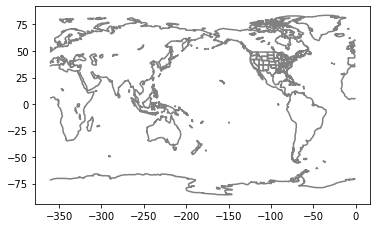

In [ ]:
f = open("/content/drive/MyDrive/Colab/2021_research/tornado_data/lat.bin", "r")
costal_lat         = np.fromfile(f, np.float32)

f = open("/content/drive/MyDrive/Colab/2021_research/tornado_data/lon.bin", "r")
costal_lon         = np.fromfile(f, np.float32)

states = geopandas.read_file('/content/geopandas-tutorial/data/usa-states-census-2014.shp')
states = states.to_crs("EPSG:4326")

plt.figure()
states.boundary.plot(color='gray')
plt.plot(costal_lon-360,costal_lat,'gray')

/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2691: RuntimeWarning: divide by zero encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2692: RuntimeWarning: divide by zero encountered in true_divide
  c /= stddev[None, :]
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: UserWarning: The following kwargs were not used by contour: 'linestyle'
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:56: UserWarning: The following kwargs were not used by contour: 'linestyle'


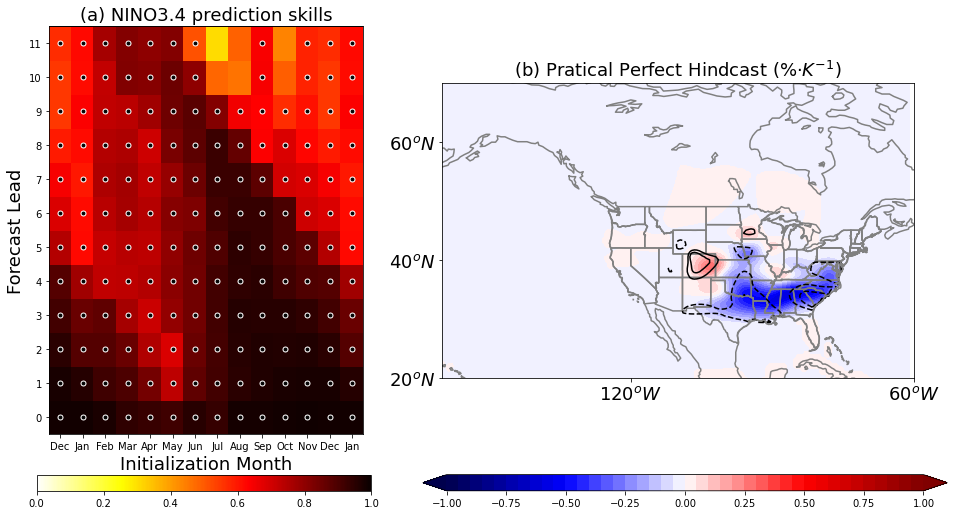

In [ ]:
f = open("/content/drive/MyDrive/Colab/2021_research/tornado_data/lat.bin", "r")
costal_lat         = np.fromfile(f, np.float32)

f = open("/content/drive/MyDrive/Colab/2021_research/tornado_data/lon.bin", "r")
costal_lon         = np.fromfile(f, np.float32)

#PPH_monthly        = np.zeros((23,110,300))

#for i in range(23):
#    posi    = np.squeeze(np.where(((dates_1D.year==1995+i) & (dates_1D.month==3))| ((dates_1D.year==1995+i) & (dates_1D.month==4)) ) )
#    PPH_monthly[i,:,:]         = np.mean(PPH_daily[posi,:,:],axis=0)
    
    
series1            = (NINO34_obs[:,2]-np.mean(NINO34_obs[:,2]))/np.std(NINO34_obs[:,2])
#PPH_monthly    = np.reshape(PPH_monthly,[PPH_monthly.shape[0],PPH_monthly.shape[1]*PPH_monthly.shape[2]]) # reshape 3D array to 2D array for matrix operation
X_mat              = np.vstack((np.ones(PPH_monthly[3:26,:].shape[0]), series1)).T

# coef_total = (X^T X)^(-1) (X^T Y) (you can check wikipedia: https://en.wikipedia.org/wiki/Linear_regression, section: Least-squares estimation and related techniques)
# coef_total contains both b and a. the first dimension of coef_total is b and the second dimension of coef_total is a  
coef_total         = np.linalg.inv(X_mat.T.dot(X_mat)).dot(X_mat.T).dot(PPH_monthly[3:26,:])

# as mentioned previously, "a" represents the warming trend of cape and "b" is the cape value in reference year
PPH_NINO34         = np.reshape(coef_total[1,:],[110,300])
reg_coef           = np.zeros((33000,))
for i in range(np.shape(PPH_monthly)[1]):
    reg_coef[i,]   = np.corrcoef(NINO34_obs[:,2],PPH_monthly[3:26,i])[0][1]
reg_coef           = np.reshape(reg_coef,[110,300])
reg_coef[yy>45]    = 0
reg_coef[yy<=27.5] = 0
#cape_reference = np.reshape(coef_total[0,:],[110,300])


lat                = np.arange(15,70,0.5)
lon                = np.arange(150,300,0.5)
xx,yy              = np.meshgrid(lon,lat)


fig, axs = plt.subplots(1, 2, gridspec_kw={'width_ratios': [2, 3]})
cs1      = axs[0].pcolormesh(np.transpose(score_map2[:,1:]),vmin=0,vmax=1,cmap=my_map)
axs[0].set_xticks(np.arange(0.5,17,1), minor=False)
axs[0].set_xticklabels(['Dec','Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct', 'Nov',\
                                'Dec','Jan','Feb','Mar','Apr'], fontdict=None, minor=False)
axs[0].set_yticks(np.arange(0.5,12,1), minor=False)
axs[0].set_yticklabels(np.arange(0,12,1), fontdict=None, minor=False)
axs[0].set_ylim([0,12])
axs[0].set_xlabel('Initialization Month',fontsize=18)
axs[0].set_ylabel('Forecast Lead',fontsize=18)
posi_x, posi_y = np.where(score_map2>0.505)
axs[0].scatter(posi_x+0.5,posi_y-0.5,25,'w')
axs[0].scatter(posi_x+0.5,posi_y-0.5,8,'k')
axs[0].set_title('(a) NINO3.4 prediction skills',fontsize=18)


states.boundary.plot(color='gray',ax=axs[1])
cs2     = axs[1].contourf(xx-0.5-360,yy+0.5,PPH_NINO34*land_sea_mask*100,np.arange(-1,1.05,0.05),cmap='seismic',extend='both')
axs[1].contour(xx-0.5-360,yy+0.5,reg_coef*land_sea_mask,[-0.5,-0.4,-0.3],colors='k',linestyle='--')
axs[1].contour(xx-0.5-360,yy+0.5,reg_coef*land_sea_mask,[0.3,0.4,0.5],colors='k',linestyle='--')
axs[1].set_title(r'(b) Pratical Perfect Hindcast (%$\cdot K^{-1}$)',fontsize=18)
#axs[1].set_title(r'(b) Pratical Perfect Hindcast (%/$^o$C)',fontsize=18)
axs[1].plot(costal_lon-360,costal_lat,'gray')
axs[1].set_xticks([0-360, 60-360, 120-360, 180-360,240-360,300-360,360-360], minor=False)
axs[1].set_xticklabels(['$0^oE$', '$60^oE$','$120^oE$', '$180^oE$', '$120^oW$', '$60^oW$', '$0^oW$'], fontdict=None, minor=False,fontsize=18)
axs[1].set_yticks([-80,-60,-40,-20,0, 20,40,60,80], minor=False)
axs[1].set_yticklabels(['$80^oS$', '$60^oS$', '$40^oS$', '$20^oS$', '$Eq$', '$20^oN$', '$40^oN$', '$60^oN$', '$80^oN$'], fontdict=None, minor=False,fontsize=18)    
axs[1].set_xlim([200-360,300-360])
axs[1].set_ylim([20,70])    
#divider = make_axes_locatable(axs[1])
#cax = divider.append_axes("right", size="5%", pad=0.1)

#axs[1].states.boundary.plot(color='black')


fig.set_size_inches(15.5,7.5)
cbar_ax = fig.add_axes([0.114, 0.02, 0.3,0.03])   
cbar    = fig.colorbar(cs1, cax=cbar_ax, orientation='horizontal')

#fig.set_size_inches(7.5, 15.5)
cbar_ax = fig.add_axes([0.46, 0.02, 0.47,0.03])   
cbar    = fig.colorbar(cs2, cax=cbar_ax, orientation='horizontal')

#!pwd
#fig.savefig('/home/Kai-chi.Tseng/2019_research/SPEAR_tornado/FIG1.pdf', dpi=300, bbox_inches='tight')
#fig.savefig('/home/Kai-chi.Tseng/2019_research/SPEAR_tornado/FIG1.png', dpi=300, bbox_inches='tight')


In [ ]:
np.shape(score_map2)

(14, 14)

/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2691: RuntimeWarning: divide by zero encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2692: RuntimeWarning: divide by zero encountered in true_divide
  c /= stddev[None, :]
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:79: UserWarning: The following kwargs were not used by contour: 'linestyle'
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:80: UserWarning: The following kwargs were not used by contour: 'linestyle'


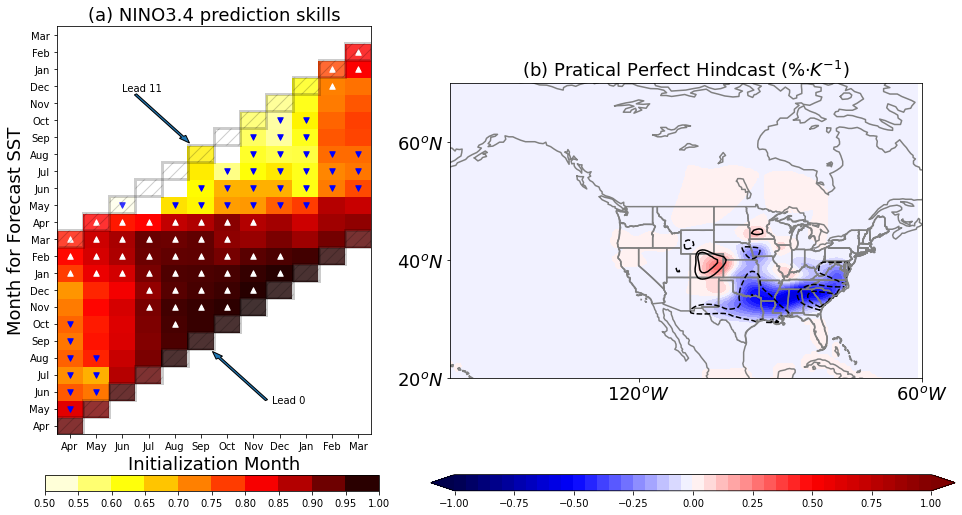

In [ ]:
f = open("/content/drive/MyDrive/Colab/2021_research/tornado_data/lat.bin", "r")
costal_lat         = np.fromfile(f, np.float32)

f = open("/content/drive/MyDrive/Colab/2021_research/tornado_data/lon.bin", "r")
costal_lon         = np.fromfile(f, np.float32)

#PPH_monthly        = np.zeros((23,110,300))

#for i in range(23):
#    posi    = np.squeeze(np.where(((dates_1D.year==1995+i) & (dates_1D.month==3))| ((dates_1D.year==1995+i) & (dates_1D.month==4)) ) )
#    PPH_monthly[i,:,:]         = np.mean(PPH_daily[posi,:,:],axis=0)
    
    
series1            = (NINO34_obs[:,2]-np.mean(NINO34_obs[:,2]))/np.std(NINO34_obs[:,2])
#PPH_monthly    = np.reshape(PPH_monthly,[PPH_monthly.shape[0],PPH_monthly.shape[1]*PPH_monthly.shape[2]]) # reshape 3D array to 2D array for matrix operation
X_mat              = np.vstack((np.ones(PPH_monthly[3:26,:].shape[0]), series1)).T

# coef_total = (X^T X)^(-1) (X^T Y) (you can check wikipedia: https://en.wikipedia.org/wiki/Linear_regression, section: Least-squares estimation and related techniques)
# coef_total contains both b and a. the first dimension of coef_total is b and the second dimension of coef_total is a  
coef_total         = np.linalg.inv(X_mat.T.dot(X_mat)).dot(X_mat.T).dot(PPH_monthly[3:26,:])

# as mentioned previously, "a" represents the warming trend of cape and "b" is the cape value in reference year
PPH_NINO34         = np.reshape(coef_total[1,:],[110,300])
reg_coef           = np.zeros((33000,))
for i in range(np.shape(PPH_monthly)[1]):
    reg_coef[i,]   = np.corrcoef(NINO34_obs[:,2],PPH_monthly[3:26,i])[0][1]
reg_coef           = np.reshape(reg_coef,[110,300])
reg_coef[yy>45]    = 0
reg_coef[yy<=27.5] = 0
#cape_reference = np.reshape(coef_total[0,:],[110,300])


lat                = np.arange(15,70,0.5)
lon                = np.arange(150,300,0.5)
xx,yy              = np.meshgrid(lon,lat)


fig, axs = plt.subplots(1, 2, gridspec_kw={'width_ratios': [2, 3]})
cs1      = axs[0].pcolormesh(score_map_NINO34,vmin=0.505,vmax=1,cmap=my_map)
axs[0].set_xticks(np.arange(0.5,13,1), minor=False)
axs[0].set_xticklabels(['Apr','May','Jun','Jul','Aug','Sep','Oct', 'Nov',\
                                'Dec','Jan','Feb','Mar','Apr'], fontdict=None, minor=False)
axs[0].set_yticks(np.arange(0.5,24,1), minor=False)
axs[0].set_yticklabels(['Apr','May','Jun','Jul','Aug','Sep','Oct', 'Nov',\
                                'Dec','Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct', 'Nov','Dec','Jan','Feb','Mar'], fontdict=None, minor=False)
#axs[0].set_yticklabels(np.arange(0,12,1), fontdict=None, minor=False)
axs[0].set_ylim([0,24])
axs[0].set_xlabel('Initialization Month',fontsize=18)
axs[0].set_ylabel('Month for Forecast SST',fontsize=18)
#posi_x, posi_y = np.where((new[11+4:11+4+12,11+4:11+4+12]>0.505) & (np.abs(new2[11+4:11+4+12,11+4:11+4+12])<0.05))
#axs[0].scatter(posi_x+0.5,posi_y+0.5,30,'w','o')
#axs[0].scatter(posi_x+0.5,posi_y+0.5,8,'k','o')

posi_x, posi_y = np.where((score_map_NINO34_2.T>0.05) & (score_map_NINO34.T>0.505))
axs[0].scatter(posi_x+0.5,posi_y+0.5,30,'w','^')
axs[0].scatter(posi_x+0.5,posi_y+0.5,8,'w','^')

posi_x, posi_y = np.where((score_map_NINO34_2.T<-0.05) & (score_map_NINO34.T>0.505))
axs[0].scatter(posi_x+0.5,posi_y+0.5,30,'b','v')
axs[0].scatter(posi_x+0.5,posi_y+0.5,8,'b','v')
for j in range(12):
    x1 = [j,j+1,j+1,j]
    y1 = [j,j,j+1,j+1]
    axs[0].fill(y1,x1 , facecolor="white",edgecolor='k',hatch='//',alpha=0.2,linewidth=3)
axs[0].arrow(8, 2, -1.8, 2.5, width = 0.1)
axs[0].text(8.2, 1.8, 'Lead 0')
for j in range(12):
    x1 = [j+11,j+1+11,j+1+11,j+11]
    y1 = [j,j,j+1,j+1]
    axs[0].fill(y1,x1 , facecolor="white",edgecolor='k',hatch='//',alpha=0.2,linewidth=3)
axs[0].arrow(3, 18+2, 1.8, -2.5, width = 0.1)
axs[0].text(2.5, 18.2+2, 'Lead 11')
axs[0].set_title('(a) NINO3.4 prediction skills',fontsize=18)





states.boundary.plot(color='gray',ax=axs[1])
cs2     = axs[1].contourf(xx-0.5-360,yy+0.5,PPH_NINO34*land_sea_mask*100,np.arange(-1,1.05,0.05),cmap='seismic',extend='both')
axs[1].contour(xx-0.5-360,yy+0.5,reg_coef*land_sea_mask,[-0.5,-0.4,-0.3],colors='k',linestyle='--')
axs[1].contour(xx-0.5-360,yy+0.5,reg_coef*land_sea_mask,[0.3,0.4,0.5],colors='k',linestyle='--')
axs[1].set_title(r'(b) Pratical Perfect Hindcast (%$\cdot K^{-1}$)',fontsize=18)
#axs[1].set_title(r'(b) Pratical Perfect Hindcast (%/$^o$C)',fontsize=18)
axs[1].plot(costal_lon-360,costal_lat,'gray')
axs[1].set_xticks([0-360, 60-360, 120-360, 180-360,240-360,300-360,360-360], minor=False)
axs[1].set_xticklabels(['$0^oE$', '$60^oE$','$120^oE$', '$180^oE$', '$120^oW$', '$60^oW$', '$0^oW$'], fontdict=None, minor=False,fontsize=18)
axs[1].set_yticks([-80,-60,-40,-20,0, 20,40,60,80], minor=False)
axs[1].set_yticklabels(['$80^oS$', '$60^oS$', '$40^oS$', '$20^oS$', '$Eq$', '$20^oN$', '$40^oN$', '$60^oN$', '$80^oN$'], fontdict=None, minor=False,fontsize=18)    
axs[1].set_xlim([200-360,300-360])
axs[1].set_ylim([20,70])    
#divider = make_axes_locatable(axs[1])
#cax = divider.append_axes("right", size="5%", pad=0.1)

#axs[1].states.boundary.plot(color='black')


fig.set_size_inches(15.5,7.5)
cbar_ax = fig.add_axes([0.114, 0.02, 0.3,0.03])   
cbar    = fig.colorbar(cs1, cax=cbar_ax, orientation='horizontal',boundaries=np.arange(0.5,1.05,0.05), ticks=np.arange(0.5,1.05,0.05))

#fig.set_size_inches(7.5, 15.5)
cbar_ax = fig.add_axes([0.46, 0.02, 0.47,0.03])   
cbar    = fig.colorbar(cs2, cax=cbar_ax, orientation='horizontal')


# Figure 3 

In [ ]:
tornado_day_CONUS_monthly       = np.zeros((30,))          # dimension = year, lat, lon
tornado_day_CONUS_monthly_1995  = np.zeros((23,))          # dimension = year, lat, lon
tornado_day_CONUS_monthly2      = np.zeros((30,))          # dimension = year, lat, lon


# define CONUS tornado day
for year in range(1992,2022):
    count=0
    count2=0
    count3=0
    for month in range(3,5):
        posi = np.squeeze(np.where( (dates_1D.year  == year) & (dates_1D.month == month) ))
        posi2= np.squeeze(np.where( (dates_1D_1995.year  == year) & (dates_1D_1995.month == month) ))
        for i in range(np.size(posi)):
            criteria = np.size(np.where(PPH_daily[posi[i],:,:]>=0.05))
            if (year>=1995) & (year<=2017):
                criteria_1995 = np.size(np.where(PPH_daily_1995[posi2[i],:,:]>=0.05))
            if year<=2017:
                criteria2 = np.size(np.where(p_perfect_tor[posi[i],:,:]>=10))
            #criteria = np.size(np.where(PPH_daily[posi[i],:,:]>=0.01))
            #print(criteria)
            if criteria>=1:
                count=count+1
            if year>=1995:
                if criteria_1995>=1:
                    count3=count3+1    
            if criteria2>=1:
                count2=count2+1
    tornado_day_CONUS_monthly[year-1992]=count
    if (year>=1995) & (year<=2017):
        tornado_day_CONUS_monthly_1995[year-1995]=count3
    # based on Victor et al. method
    tornado_day_CONUS_monthly2[year-1992]=count2
del PPH_daily, PPH_daily_1995,PPH_6h

In [ ]:
# check the usage of memory 
import sys
def sizeof_fmt(num, suffix='B'):
    ''' by Fred Cirera,  https://stackoverflow.com/a/1094933/1870254, modified'''
    for unit in ['','Ki','Mi','Gi','Ti','Pi','Ei','Zi']:
        if abs(num) < 1024.0:
            return "%3.1f %s%s" % (num, unit, suffix)
        num /= 1024.0
    return "%.1f %s%s" % (num, 'Yi', suffix)

for name, size in sorted(((name, sys.getsizeof(value)) for name, value in locals().items()),
                         key= lambda x: -x[1])[:10]:
    print("{:>30}: {:>8}".format(name, sizeof_fmt(size)))

                     sst_model:  6.7 GiB
              PPH_monthly_1995:  7.6 MiB
                    coef_total: 515.7 KiB
                      dates_6h: 342.5 KiB
                         dates: 342.4 KiB
                 land_sea_mask: 257.9 KiB
                            xx: 257.9 KiB
                            yy: 257.9 KiB
                     dates_PPH: 117.0 KiB
                      dates_1D: 85.6 KiB


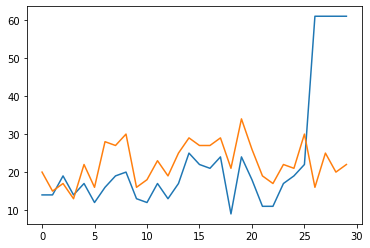

In [ ]:
plt.plot(tornado_day_CONUS_monthly2)
plt.plot(tornado_day_CONUS_monthly)

In [ ]:
import numpy as np
data = np.load('/archive/Kai-chi.Tseng/data/SPEAR_tornado_seasonal/PPH_1950_2021.npz', mmap_mode='r')
for k in data.files:
    print(k)

PPH_tornado2
PPH_tornado


In [ ]:
# don't run it (Sung-Ki's project)
# for data starts from 1950
# correlation between tornado PPH and NINO3.4 index
# generate monthly data
os.system("dmget /archive/Kai-chi.Tseng/data/SPEAR_tornado_seasonal/PPH_1950_2021.npz")
data               = np.load('/archive/Kai-chi.Tseng/data/SPEAR_tornado_seasonal/PPH_1950_2021.npz')
PPH_6h             = data['PPH_tornado2']
dates_6h           = pd.date_range('1950-01-01-00:00', '2021-12-31-18:00', freq='6H')
dates_1D           = pd.date_range('1950-01-01', '2021-12-31', freq='1D')
PPH_daily          = np.zeros((np.size(dates_1D),110,300))

for i in range(np.size(dates_1D)):
    year  = dates_1D[i].year
    month = dates_1D[i].month
    day   = dates_1D[i].day
    posi  = np.where((dates_6h.year  == year)  &\
                     (dates_6h.month == month) &\
                     (dates_6h.day   == day)   &\
                     (dates_6h.hour  == 18)     \
                    )
    #posi  = np.where((dates_6h.year  == year)  &\
    #                 (dates_6h.month == month) &\
    #                 (dates_6h.day   == day)   \
    #                )
    PPH_daily[i,:,:]   = PPH_6h[np.squeeze(posi),:,:]
    #posi    = np.squeeze(np.where(((dates_6h.year==1992+i) & (dates_6h.month==3) & (dates_6h.hour  == 18))| ((dates_6h.year==1992+i) & (dates_6h.month==4) & (dates_6h.hour  == 18)) ) )
    #PPH_daily[i,:,:]         = PPH_6h[posi,:,:],axis=0
    


dates                           = pd.date_range('1950-01-01', '2021-12-31', freq='6h') # total length of reanalysis data
tornado_day_CONUS_monthly       = np.zeros((72,))          # dimension = year, lat, lon

# define CONUS tornado day
for year in range(1950,2022):
    count=0
    count2=0
    count3=0
    for month in range(3,5):
        posi = np.squeeze(np.where( (dates_1D.year  == year) & (dates_1D.month == month) ))
        for i in range(np.size(posi)):
            criteria = np.size(np.where(PPH_daily[posi[i],:,:]>=0.10))
            if criteria>=1:
                count=count+1
    tornado_day_CONUS_monthly[year-1950]=count
    
    
    

In [ ]:
np.shape(tornado_day_CONUS_monthly)

(30,)

In [ ]:
# estimating the global warming trend in observed Tday 

series1            = np.arange(0,30)
#series1            = (NINO34_obs[:,2]-np.mean(NINO34_obs[:,2]))/np.std(NINO34_obs[:,2])
#PPH_monthly    = np.reshape(PPH_monthly,[PPH_monthly.shape[0],PPH_monthly.shape[1]*PPH_monthly.shape[2]]) # reshape 3D array to 2D array for matrix operation
X_mat              = np.vstack((np.ones(30), series1)).T

# coef_total = (X^T X)^(-1) (X^T Y) (you can check wikipedia: https://en.wikipedia.org/wiki/Linear_regression, section: Least-squares estimation and related techniques)
# coef_total contains both b and a. the first dimension of coef_total is b and the second dimension of coef_total is a  
coef_total         = np.linalg.inv(X_mat.T.dot(X_mat)).dot(X_mat.T).dot(tornado_day_CONUS_monthly)
Tday_trend         = coef_total[1]
Tday_intercept     = coef_total[0]


#series1            = np.arange(0,30)
series2            = NINO34[2,:,2]
#PPH_monthly    = np.reshape(PPH_monthly,[PPH_monthly.shape[0],PPH_monthly.shape[1]*PPH_monthly.shape[2]]) # reshape 3D array to 2D array for matrix operation
X_mat              = np.vstack((np.ones(30), series2)).T

# coef_total = (X^T X)^(-1) (X^T Y) (you can check wikipedia: https://en.wikipedia.org/wiki/Linear_regression, section: Least-squares estimation and related techniques)
# coef_total contains both b and a. the first dimension of coef_total is b and the second dimension of coef_total is a  
coef_total         = np.linalg.inv(X_mat.T.dot(X_mat)).dot(X_mat.T).dot(tornado_day_CONUS_monthly)
NINO_a             = coef_total[1]
NINO_intercept     = coef_total[0]




In [ ]:
Tday_detrend = tornado_day_CONUS_monthly - Tday_trend*series1

2*np.std(Tday_detrend)/np.std(series1)

1.1918555967237328

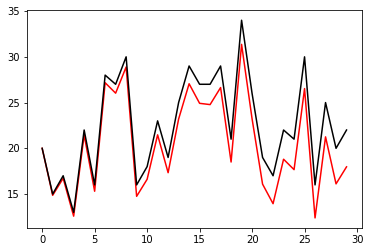

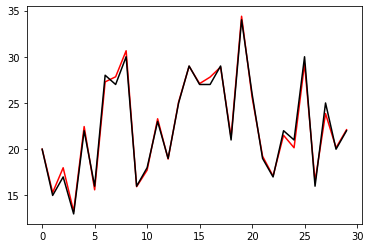

In [ ]:
Tday_detrend = tornado_day_CONUS_monthly - Tday_trend*series1
NINO_detrend = tornado_day_CONUS_monthly - NINO_a*series2
plt.figure()
plt.plot(Tday_detrend,'r')
plt.plot(tornado_day_CONUS_monthly,'k')
plt.figure()
plt.plot(NINO_detrend+(tornado_day_CONUS_monthly[0]-NINO_detrend[0]),'r')
plt.plot(tornado_day_CONUS_monthly,'k')

In [ ]:
# estimating the global warming trend in observed Tday 

series1            = np.arange(0,30)
#series1            = (NINO34_obs[:,2]-np.mean(NINO34_obs[:,2]))/np.std(NINO34_obs[:,2])
#PPH_monthly    = np.reshape(PPH_monthly,[PPH_monthly.shape[0],PPH_monthly.shape[1]*PPH_monthly.shape[2]]) # reshape 3D array to 2D array for matrix operation
X_mat              = np.vstack((np.ones(30), series1)).T

# coef_total = (X^T X)^(-1) (X^T Y) (you can check wikipedia: https://en.wikipedia.org/wiki/Linear_regression, section: Least-squares estimation and related techniques)
# coef_total contains both b and a. the first dimension of coef_total is b and the second dimension of coef_total is a  
coef_total         = np.linalg.inv(X_mat.T.dot(X_mat)).dot(X_mat.T).dot(NINO_detrend)
Tday_trend         = coef_total[1]
Tday_intercept     = coef_total[0]

Tday_detrend       = NINO_detrend - Tday_trend*series1
print(Tday_trend)
print(2*np.std(Tday_detrend)/np.std(series1))


0.11861077897805922
1.1949803914793897


[20. 15. 17. 13. 22. 16. 28. 27. 30. 16. 18. 23. 19. 25. 29. 27. 27. 29.
 21. 34. 26. 19. 17. 22. 21. 30. 16. 25. 20. 22.]


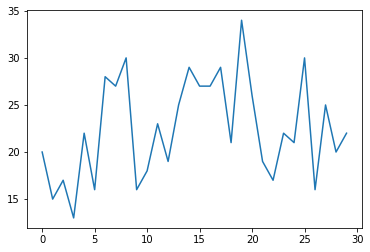

In [ ]:
plt.plot(tornado_day_CONUS_monthly)
#plt.plot(tornado_day_CONUS_monthly)
#np.corrcoef(tornado_day_CONUS_monthly[0:25],tornado_day_CONUS_monthly2[0:25])
print(tornado_day_CONUS_monthly)

In [ ]:
data         = np.load('/archive/Kai-chi.Tseng/data/SPEAR_tornado_seasonal/regions_flag2.npz')
regions_flag = data['regions_flag']
regions_flag = land_sea_mask*regions_flag

# define CONUS tornado day by regions 
# generate daily data first
tornado_day_CONUS_daily_region       = np.zeros((np.shape(PPH_daily)[0],9))
vector                                 = np.vectorize(np.int)

for i in range(np.shape(PPH_daily)[0]):
    posiy,posix = np.where(PPH_daily[i,:,:]>=0.05)
    if np.size(posiy)>0:
        tornado_day_CONUS_daily_region[i,vector(regions_flag[posiy,posix])-1]=1

# generate CONUS tornado day
tornado_day_CONUS_monthly_region       = np.zeros((30,9))          # dimension = year, lat, lon
tornado_day_CONUS_monthly_1995_region  = np.zeros((23,9))          # dimension = year, lat, lon
tornado_day_CONUS_monthly2_region      = np.zeros((30,9))          # dimension = year, lat, lon
tornado_day_CONUS_monthly_region       = np.zeros((30,9))

for regions in range(9):
    for year in range(1992,2022):
        count=0
        for month in range(3,5):
            posi = np.squeeze(np.where( (dates_1D.year  == year) & (dates_1D.month == month) ))
            for i in range(np.size(posi)):
                criteria = np.size(np.where(tornado_day_CONUS_daily_region[posi[i],regions]==1))
                if criteria>=1:
                    count=count+1
        tornado_day_CONUS_monthly_region[year-1992,regions]=count

# tag
# 1= Northwest
# 2= West 
# 3= Northern_Rockies
# 4= Southwest
# 5= South
# 6= Midwest
# 7= Ohio Valley
# 8= Southeast
# 9= Northeast

In [ ]:

plt.plot(tornado_day_CONUS_monthly_region[:,4])
plt.plot(tornado_day_CONUS_monthly[:])
np.corrcoef(tornado_day_CONUS_monthly_region[:,4],tornado_day_CONUS_monthly[:])

NameError: ignored

array([[1.        , 0.28781291],
       [0.28781291, 1.        ]])

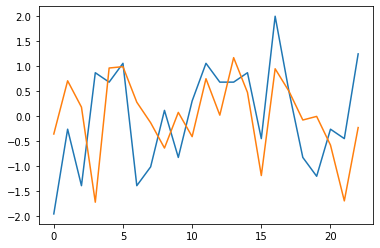

In [ ]:
series1 = (tornado_day_CONUS_monthly_1995-np.mean(tornado_day_CONUS_monthly_1995))/np.std(tornado_day_CONUS_monthly_1995)

plt.plot(series1)
plt.plot(-NINO34_obs[:,2])
#plt.plot(-NINO34[2,3:26,0])

np.corrcoef(-NINO34[2,3:26,0],series1)

[[1.         0.78767909]
 [0.78767909 1.        ]]
[[1.         0.75567029]
 [0.75567029 1.        ]]


array([[ 1.        , -0.18919042],
       [-0.18919042,  1.        ]])

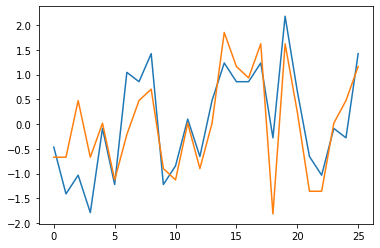

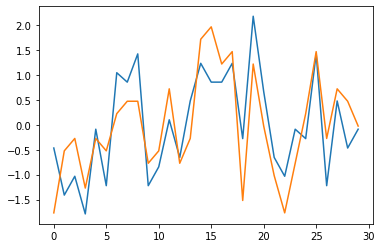

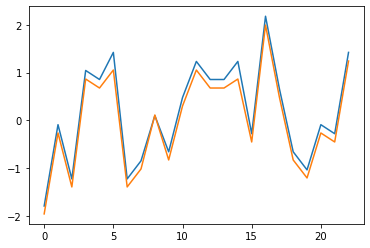

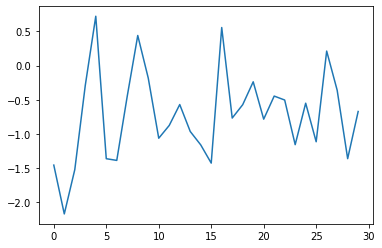

In [ ]:
series1 = (tornado_day_CONUS_monthly-np.mean(tornado_day_CONUS_monthly))/np.std(tornado_day_CONUS_monthly)
series2 = (tornado_day_CONUS_monthly2[0:-4]-np.mean(tornado_day_CONUS_monthly2[0:-4]))/np.std(tornado_day_CONUS_monthly2[0:-4])
series3 = (pph_alli-np.mean(pph_alli))/np.std(pph_alli)
series4 = (tornado_day_CONUS_monthly_1995-np.mean(tornado_day_CONUS_monthly_1995))/np.std(tornado_day_CONUS_monthly_1995)
plt.plot(series1[0:-4])
plt.plot(series2)
print(np.corrcoef(series1[0:-4],series2))
plt.figure()
plt.plot(series1)
plt.plot(series3)
print(np.corrcoef(series1,series3))
plt.figure()
plt.plot(series1[3:-4])
plt.plot(series4)
NINO34 = np.reshape(NINO34,[12,30,12])
plt.figure()
plt.plot(NINO34[11,:,11])
np.corrcoef(NINO34[2,:,0],series1)
#tornado_day_CONUS_monthly = pph_alli

array([[1.        , 0.93198131],
       [0.93198131, 1.        ]])

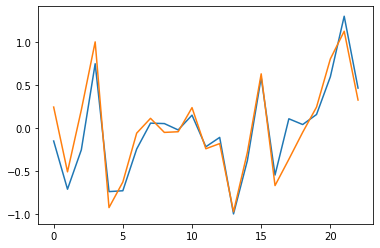

In [ ]:
NINO34_obs = NINO34_obs - NINO34_obs.mean(axis=0)
NINO34     = np.reshape(NINO34,[12,30,12])
for i in range(12):
    for j in range(12):
        NINO34[i,:,j] = NINO34[i,:,j]-np.mean(NINO34[i,:,j])
NINO34     = np.reshape(NINO34,[12,30*12])
NINO34_obs = np.reshape(NINO34_obs,[23,12])
init_month = 4
month      = 4
dates_1M   = pd.date_range('1992-'+str(init_month).zfill(2)+'', periods=360, freq='1M')     
posi       = np.squeeze(np.where((dates_1M.month==month) & (dates_1M.year<=2021)))
NINO34[init_month-1,posi]

plt.plot(NINO34[init_month-1,posi[3:26]])
plt.plot(NINO34_obs[:,3])
np.corrcoef(NINO34[init_month-1,posi[3:26]],NINO34_obs[:,3])

Timestamp('1993-04-30 00:00:00', freq='M')

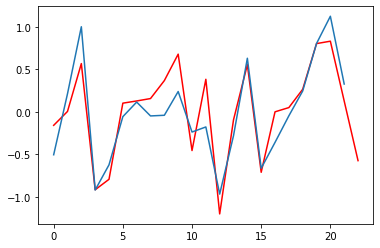

In [ ]:
NINO34_obs = (np.reshape(NINO34_obs,[23,12])-np.mean(NINO34_obs))/np.std(NINO34_obs)

init_month = 12
month      = 4
dates_1M   = pd.date_range('1992-'+str(init_month).zfill(2)+'', periods=360, freq='1M')     
posi       = np.squeeze(np.where((dates_1M.month==month) & (dates_1M.year<=2021)))
NINO34[init_month-1,posi]

plt.plot(NINO34[init_month-1,posi[3:26]],'r')
plt.plot(NINO34_obs[1:,3])
np.corrcoef(NINO34[init_month-1,posi[3:25]],NINO34_obs[1:,3])
dates_1M[posi[0]]

In [ ]:

from sklearn import linear_model
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
regr          = linear_model.LinearRegression()

# develop model based on observational SST
# load obs SST data 

#NINO34_score = np.zeros((12,12))

NINO34              = np.reshape(NINO34,[12,30*12])
NINO34_obs          = np.reshape(NINO34_obs,[23*12,]) 

nc                  = NetCDFFile("/content/drive/MyDrive/Colab/2021_research/tornado_data/sst.nc")
sst_obs             = nc.variables['sst'][192:468,0,:,:]
lon_SST_obs         = nc.variables['lon'][:]
lat_SST_obs         = nc.variables['lat'][:]

dates                   = pd.date_range('1992-01-01', '2021-12-31', freq='M')
sst_correlation_map     = np.zeros((12,12))
Y_val_LM_sst            = np.zeros((12,12,30))
dates_1M_fixed          = pd.date_range('1992-01', periods=360, freq='1M') 
coef_SPEAR_sst_NINO34   = np.zeros((12,12,30))
#tornado_day_CONUS_monthly = (tornado_day_CONUS_monthly-np.mean(tornado_day_CONUS_monthly))/np.std(tornado_day_CONUS_monthly)

count==0
for init_month in range(1,13):         # for initialization month 
#for init_month in [12]:         # for initialization month     
    dates_1M  = pd.date_range('1992-'+str(init_month).zfill(2)+'', periods=360, freq='1M')     
    for month in range(1,13):          # month used as predictors 
#    for month in [4]:          # month used as predictors    
        posi = np.squeeze(np.where((dates_1M.month==month) & (dates_1M.year<=2021)))
        print('init year='+str(1992)+' init month='+str(init_month)+' predictor year ='+str(dates_1M[posi[0]].year) +' predictor month='+str(month))                
         
        if (dates_1M[posi[0]].year==1992) & (month<=3):
            print('Case 1')
            init_year = 1992
            #target_year = 1992
            series1   = tornado_day_CONUS_monthly[:]
            series2   = NINO34[init_month-1,posi]
            print(np.corrcoef(series1,series2)[0][1])
            sst_correlation_map[init_month-1,month-1] = np.corrcoef(series1,series2)[0][1]            
        elif (dates_1M[posi[0]].year==1992) & (month>3):
            print('Case 2')
            init_year = 1993
            #target_year = 1993
            series1   = tornado_day_CONUS_monthly[1:]
            series2   = NINO34[init_month-1,posi[:-1]]
            print(np.corrcoef(series1,series2)[0][1])
            sst_correlation_map[init_month-1,month-1] = np.corrcoef(series1,series2)[0][1]
        elif (dates_1M[posi[0]].year==1993) & (month<=3):
            print('Case 3')
            init_year = 1993
            #target_year = 1993
            series1   = tornado_day_CONUS_monthly[1:]
            series2   = NINO34[init_month-1,posi]
            print(np.corrcoef(series1,series2)[0][1])
            sst_correlation_map[init_month-1,month-1] = np.corrcoef(series1,series2)[0][1]
        elif (dates_1M[posi[0]].year==1993) & (month>3):
            print('Case 4')
            init_year   = 1994
            #target_year = 1995
            series1   = tornado_day_CONUS_monthly[2:]
            series2   = NINO34[init_month-1,posi[:-1]]
            print(np.corrcoef(series1,series2)[0][1])
            sst_correlation_map[init_month-1,month-1] = np.corrcoef(series1,series2)[0][1]
        
        for year in range(init_year,2021):
            
            series3 = np.delete(series1, year-init_year) # predictand
            series4 = np.delete(series2, year-init_year) # predictor
            X_train = np.zeros((np.size(series3),1))
            Y_train = np.zeros((np.size(series4),1))
            X_train[:,0] = series4
            Y_train[:,0] = series3
            #print(tornado_day_CONUS_monthly)
            #print(series1)
            #print(series3)
            #print(series4)
            model_ols =  linear_model.LinearRegression(normalize=True,fit_intercept=False)
            model_ols.fit(X_train,Y_train)
            #print(X_train)
            #print(Y_train)
            print('corrcoef after leave-one-out = '+str(np.corrcoef(np.transpose(X_train),np.transpose(Y_train))[0][1]))
            
            #NINO34_obs         = np.reshape(series3,[23*12,1])
            #X_mat              = np.vstack((np.ones(series4.shape[0]), series4[:,0])).T
            #coef_total         = np.linalg.inv(X_mat.T.dot(X_mat)).dot(X_mat.T).dot(Y_train[:,:])
            #X_predict          = np.vstack((np.ones(series4.shape[0]), series4[:,0])).T

            #print(model_ols.score(X_train,Y_train))
            coef_SPEAR_sst_NINO34[init_month-1,month-1,year-1992] = model_ols.coef_
            #coef_SPEAR_NINO34[init_month-1,month-1,year,0:np.size(model_ols.coef_)] = model_ols.coef_
            X_val  = np.zeros((1,1))
            Y_val  = np.zeros((1,1))
            X_val[0,0] = series2[year-init_year]
            #print(series2[year-init_year])
            #print('input ='+str(series2[year-init_year])+' predict='+str(model_ols.predict(X_val))+' obs='+str(series1[year-init_year]))
            Y_val_LM_sst[init_month-1,month-1,year-1992] = model_ols.predict(X_val)
            
            
            #series3            = np.delete(series1, year-init_year)
            #series4            = np.delete(series2, year-init_year)    
            #X_train[:,0]       = series4
            #Y_train[:,0]       = series3
            #X_mat              = np.vstack((np.ones(X_train.shape[0]), X_train[:,0])).T
            #coef_total         = np.linalg.inv(X_mat.T.dot(X_mat)).dot(X_mat.T).dot(Y_train[:,:])
            #coef_SPEAR_sst_NINO34[init_month-1,month-1,year-1992] = coef_total[1]
            #X_predict          = np.vstack((np.ones(1), X_val[0,0])).T
            #Y_val_LM_sst[init_month-1,month-1,year-1992] = np.matmul(X_predict,coef_total)
            #Y_val_LM_sst[init_month-1,month-1,year-1992] = X_val[0,0]*coef_total[1]
            #print('input ='+str(series2[year-init_year])+' predict='+str(model_ols.predict(X_val))+' obs='+str(series1[year-init_year]))
            

In [ ]:
# calculate the skills by regions 
from sklearn import linear_model
regr          = linear_model.LinearRegression()

# develop model based on observational SST
# load obs SST data 

#NINO34_score = np.zeros((12,12))

NINO34              = np.reshape(NINO34,[12,30*12])
NINO34_obs          = np.reshape(NINO34_obs,[23*12,]) 

nc                  = NetCDFFile("/content/drive/MyDrive/Colab/2021_research/tornado_data/sst.nc")
sst_obs             = nc.variables['sst'][192:468,0,:,:]
lon_SST_obs         = nc.variables['lon'][:]
lat_SST_obs         = nc.variables['lat'][:]

dates                   = pd.date_range('1992-01-01', '2021-12-31', freq='M')
sst_correlation_map_region     = np.zeros((12,12,9))
Y_val_LM_sst_region            = np.zeros((12,12,30,9))
dates_1M_fixed                 = pd.date_range('1992-01', periods=360, freq='1M') 
coef_SPEAR_sst_NINO34_region   = np.zeros((12,12,30,9))
#tornado_day_CONUS_monthly = (tornado_day_CONUS_monthly-np.mean(tornado_day_CONUS_monthly))/np.std(tornado_day_CONUS_monthly)

count==0
for region in range(9):
    for init_month in range(1,13):         # for initialization month 
    #for init_month in [12]:         # for initialization month     
        dates_1M  = pd.date_range('1992-'+str(init_month).zfill(2)+'', periods=360, freq='1M')     
        for month in range(1,13):          # month used as predictors 
    #    for month in [4]:          # month used as predictors    
            posi = np.squeeze(np.where((dates_1M.month==month) & (dates_1M.year<=2021)))
            print('init year='+str(1992)+' init month='+str(init_month)+' predictor year ='+str(dates_1M[posi[0]].year) +' predictor month='+str(month))                
         
            if (dates_1M[posi[0]].year==1992) & (month<=3):
                print('Case 1')
                init_year = 1992
                #target_year = 1992
                series1   = tornado_day_CONUS_monthly_region[:,region]
                series2   = NINO34[init_month-1,posi]
                print(np.corrcoef(series1,series2)[0][1])
                sst_correlation_map_region[init_month-1,month-1,region] = np.corrcoef(series1,series2)[0][1]            
            elif (dates_1M[posi[0]].year==1992) & (month>3):
                print('Case 2')
                init_year = 1993
                #target_year = 1993
                series1   = tornado_day_CONUS_monthly_region[1:,region]
                series2   = NINO34[init_month-1,posi[:-1]]
                print(np.corrcoef(series1,series2)[0][1])
                sst_correlation_map_region[init_month-1,month-1,region] = np.corrcoef(series1,series2)[0][1]
            elif (dates_1M[posi[0]].year==1993) & (month<=3):
                print('Case 3')
                init_year = 1993
                #target_year = 1993
                series1   = tornado_day_CONUS_monthly_region[1:,region]
                series2   = NINO34[init_month-1,posi]
                print(np.corrcoef(series1,series2)[0][1])
                sst_correlation_map_region[init_month-1,month-1,region] = np.corrcoef(series1,series2)[0][1]
            elif (dates_1M[posi[0]].year==1993) & (month>3):
                print('Case 4')
                init_year   = 1994
                #target_year = 1995
                series1   = tornado_day_CONUS_monthly_region[2:,region]
                series2   = NINO34[init_month-1,posi[:-1]]
                print(np.corrcoef(series1,series2)[0][1])
                sst_correlation_map_region[init_month-1,month-1,region] = np.corrcoef(series1,series2)[0][1]
        
            for year in range(init_year,2021):
            
                series3 = np.delete(series1, year-init_year) # predictand
                series4 = np.delete(series2, year-init_year) # predictor
                X_train = np.zeros((np.size(series3),1))
                Y_train = np.zeros((np.size(series4),1))
                X_train[:,0] = series4
                Y_train[:,0] = series3
                #print(tornado_day_CONUS_monthly)
                #print(series1)
                #print(series3)
                #print(series4)
                model_ols =  linear_model.LinearRegression(normalize=True,fit_intercept=False)
                model_ols.fit(X_train,Y_train)
                #print(X_train)
                #print(Y_train)
                print('corrcoef after leave-one-out = '+str(np.corrcoef(np.transpose(X_train),np.transpose(Y_train))[0][1]))
            
                #NINO34_obs         = np.reshape(series3,[23*12,1])
                #X_mat              = np.vstack((np.ones(series4.shape[0]), series4[:,0])).T
                #coef_total         = np.linalg.inv(X_mat.T.dot(X_mat)).dot(X_mat.T).dot(Y_train[:,:])
                #X_predict          = np.vstack((np.ones(series4.shape[0]), series4[:,0])).T

                #print(model_ols.score(X_train,Y_train))
                coef_SPEAR_sst_NINO34_region[init_month-1,month-1,year-1992,region] = model_ols.coef_
                #coef_SPEAR_NINO34[init_month-1,month-1,year,0:np.size(model_ols.coef_)] = model_ols.coef_
                X_val  = np.zeros((1,1))
                Y_val  = np.zeros((1,1))
                X_val[0,0] = series2[year-init_year]
                #print(series2[year-init_year])
                #print('input ='+str(series2[year-init_year])+' predict='+str(model_ols.predict(X_val))+' obs='+str(series1[year-init_year]))
                Y_val_LM_sst_region[init_month-1,month-1,year-1992,region] = model_ols.predict(X_val)
            
            
                #series3            = np.delete(series1, year-init_year)
                #series4            = np.delete(series2, year-init_year)    
                #X_train[:,0]       = series4
                #Y_train[:,0]       = series3
                #X_mat              = np.vstack((np.ones(X_train.shape[0]), X_train[:,0])).T
                #coef_total         = np.linalg.inv(X_mat.T.dot(X_mat)).dot(X_mat.T).dot(Y_train[:,:])
                #coef_SPEAR_sst_NINO34[init_month-1,month-1,year-1992] = coef_total[1]
                #X_predict          = np.vstack((np.ones(1), X_val[0,0])).T
                #Y_val_LM_sst[init_month-1,month-1,year-1992] = np.matmul(X_predict,coef_total)
                #Y_val_LM_sst[init_month-1,month-1,year-1992] = X_val[0,0]*coef_total[1]
                #print('input ='+str(series2[year-init_year])+' predict='+str(model_ols.predict(X_val))+' obs='+str(series1[year-init_year]))
            

init year=1992 init month=1 predictor year =1992 predictor month=1
Case 1


NameError: ignored

In [ ]:
x=np.zeros((30,100))
y=np.zeros((30,100))
for i in range(100):
    x[:,i]  = np.random.normal(0, 1, 30)
    x2 = np.random.normal(0, 1, 30)
    y[:,i]  = x[:,i]*0.3+(1-0.3**2)**0.5*x2
    
x = np.reshape(x,[30*100,])
y = np.reshape(y,[30*100,])
print(np.corrcoef(x,y))

[[1.         0.28923174]
 [0.28923174 1.        ]]


In [ ]:
model_ols =  linear_model.LinearRegression(normalize=True,fit_intercept=False)
x = np.reshape(x,[30*100,1])
y = np.reshape(y,[30*100,1])
model_ols.fit(x,y)
model_ols.coef_

array([[0.29591724]])

In [ ]:
model_ols  =  linear_model.LinearRegression(normalize=False,fit_intercept=False)
model_ols.fit(X_train,Y_train)
model_ols.coef_

array([[-0.96655067]])

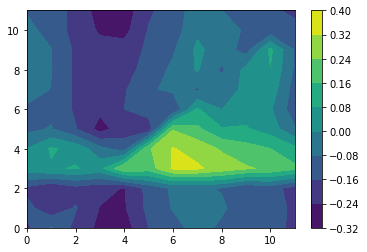

In [ ]:
plt.figure()
cs=plt.contourf(np.transpose(sst_correlation_map))
plt.colorbar(cs)

In [ ]:
series3            = np.delete(series1, year-init_year)
series4            = np.delete(series2, year-init_year)    
X_mat              = np.vstack((np.ones(series4.shape[0]), series4[:])).T
coef_total         = np.linalg.inv(X_mat.T.dot(X_mat)).dot(X_mat.T).dot(Y_train[:,:])
X_predict          = np.vstack((np.ones(1), X_val[0,0])).T
np.matmul(X_predict,coef_total)

array([[22.06815995]])

In [ ]:
score_map_NINO34 = np.zeros((12,12))
residual         = np.zeros((12,12))
series1          = (tornado_day_CONUS_monthly-np.mean(tornado_day_CONUS_monthly))/np.std(tornado_day_CONUS_monthly)
lower_percentile = np.percentile(series1,33)
upper_percentile = np.percentile(series1,66)
obs_category     = np.zeros((3,30))
clim_category    = np.ones((3,30))*1/3
obs_category[0,:][series1<lower_percentile] = 1
obs_category[2,:][series1>upper_percentile] = 1
obs_category[1,:][(series1<=upper_percentile) & (series1>=lower_percentile)] = 1
model_category   = np.zeros((3,12,12,30))

RPSS_NINO34      = np.zeros((12,12))



for init_month in range(12):
    for month in range(12):
        posi    = np.squeeze(np.where(np.abs(Y_val_LM_sst[init_month-1,month-1,:])>0))
        #series1 =
        #series2 = 
        #Y_val_LM_sst[init_month-1,month-1,posi] = np.mean(tornado_day_CONUS_monthly)
        std_range                               = np.std(Y_val_LM_sst[init_month-1,month-1,posi]-series1[posi]) 
        for day in range(np.size(posi)):
            s = np.random.normal(Y_val_LM_sst[init_month-1,month-1,posi[day]], std_range, 1000)
            model_category[2,init_month-1,month-1,posi[day]] = np.size(np.where(s>upper_percentile))/1000
            model_category[0,init_month-1,month-1,posi[day]] = np.size(np.where(s<lower_percentile))/1000
            model_category[1,init_month-1,month-1,posi[day]] = 1-model_category[2,init_month-1,month-1,posi[day]]-model_category[0,init_month-1,month-1,posi[day]]
        RPS      = sum(sum((model_category[:,init_month-1,month-1,posi]-obs_category[:,posi])**2))
        RPS_clim = sum(sum((clim_category-obs_category)**2))
        RPSS_NINO34[init_month-1,month-1] = 1-RPS/RPS_clim
            

In [ ]:
score_map_NINO34_region = np.zeros((12,12,9))
RPSS_NINO34_region      = np.zeros((12,12,9))




for region in range(9):
    series1          = (tornado_day_CONUS_monthly_region[:,region]-np.mean(tornado_day_CONUS_monthly_region[:,region]))/np.std(tornado_day_CONUS_monthly_region[:,region])
    lower_percentile = np.percentile(series1,33)
    upper_percentile = np.percentile(series1,66)
    obs_category     = np.zeros((3,30))
    clim_category    = np.ones((3,30))*1/3
    obs_category[0,:][series1<lower_percentile] = 1
    obs_category[2,:][series1>upper_percentile] = 1
    obs_category[1,:][(series1<=upper_percentile) & (series1>=lower_percentile)] = 1
    model_category   = np.zeros((3,12,12,30))

    for init_month in range(12):
        for month in range(12):
            posi    = np.squeeze(np.where(np.abs(Y_val_LM_sst_region[init_month-1,month-1,:,region])>0))
            #series1 =
            #series2 = 
            #Y_val_LM_sst[init_month-1,month-1,posi] = np.mean(tornado_day_CONUS_monthly)
            std_range                               = np.std(Y_val_LM_sst_region[init_month-1,month-1,posi,region]-series1[posi]) 
            for day in range(np.size(posi)):
                s = np.random.normal(Y_val_LM_sst_region[init_month-1,month-1,posi[day],region], std_range, 1000)
                model_category[2,init_month-1,month-1,posi[day]] = np.size(np.where(s>upper_percentile))/1000
                model_category[0,init_month-1,month-1,posi[day]] = np.size(np.where(s<lower_percentile))/1000
                model_category[1,init_month-1,month-1,posi[day]] = 1-model_category[2,init_month-1,month-1,posi[day]]-model_category[0,init_month-1,month-1,posi[day]]
            RPS      = sum(sum((model_category[:,init_month-1,month-1,posi]-obs_category[:,posi])**2))
            RPS_clim = sum(sum((clim_category-obs_category)**2))
            RPSS_NINO34_region[init_month-1,month-1,region] = 1-RPS/RPS_clim
            

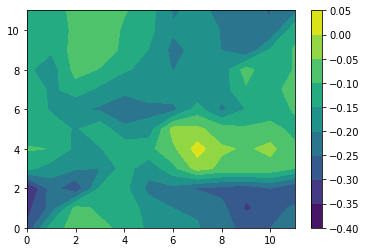

In [ ]:
cs=plt.contourf(np.transpose(RPSS_NINO34[:,:]))
plt.colorbar(cs)

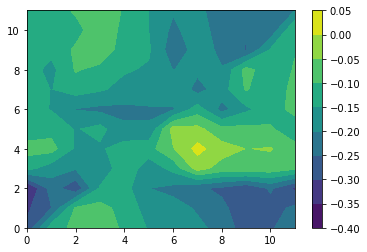

In [ ]:
cs=plt.contourf(np.transpose(RPSS_NINO34[:,:]))
plt.colorbar(cs)
#Y_val_LM_sst[init_month-1,month-1,np.squeeze(posi[day])]

[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28]


-0.22471105356424137

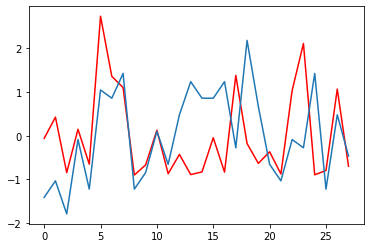

In [ ]:
init_month = 8
month      = 3
posi       = np.squeeze(np.where(np.abs(Y_val_LM_sst[init_month-1,month-1,:])>0))
print(posi)
series1    = (Y_val_LM_sst[init_month-1,month-1,posi]-np.mean(Y_val_LM_sst[init_month-1,month-1,posi]))/np.std(Y_val_LM_sst[init_month-1,month-1,posi])
series2    = (tornado_day_CONUS_monthly-np.mean(tornado_day_CONUS_monthly))/np.std(tornado_day_CONUS_monthly)
plt.plot(-series1,'r')
plt.plot(series2[posi])
np.corrcoef(series1,series2[posi])[0][1]


In [ ]:
init_month = 7
month      = 5
Y_val_LM_sst[init_month-1,month-1,posi]

array([ 0.        , -2.3759946 , -7.2373487 , -0.74988967, -4.0500206 ,
       -1.70396998,  0.10212161, -2.51719956, -2.10131007, -0.18184612,
        0.25737139,  0.61463834,  0.06459331, -0.52310163, -0.77724019,
       -0.00792467, -2.50160363, -0.52602252, -0.62783594, -0.7134199 ,
       -0.09834311,  0.62437261,  0.02142997,  0.45893626, -0.96030277,
       -0.23016136,  0.31270526,  0.4683079 ])

In [ ]:
init_month = 7
month      = 5
posi       = np.where(np.abs(Y_val_LM_sst[init_month-1,month-1,:])>0)
print(posi)

(array([ 2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
       19, 20, 21, 22, 23, 24, 25, 26, 27, 28]),)


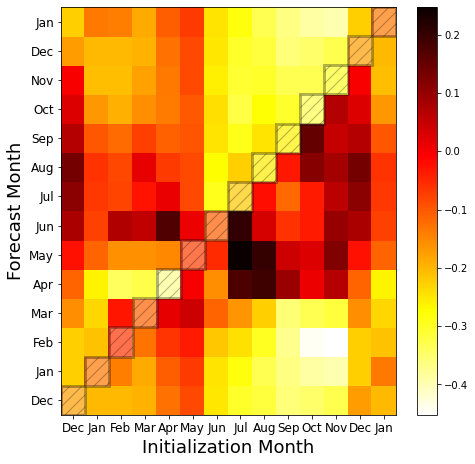

In [ ]:
score_map        = np.zeros((12,12))
score_map_region = np.zeros((12,12,9))
for init_month in range(1,13):         
    for month in range(1,13):     
        #Y_val_LM_sst[init_month-1,month-1,:] = Y_val_LM_sst[init_month-1,month-1,:]+1
        posi = np.where(np.abs(Y_val_LM_sst[init_month-1,month-1,:])>0)
        #print(posi)
        #Y_val_LM_sst[init_month-1,month-1,posi] = np.mean(tornado_day_CONUS_monthly)
        score_map[init_month-1,month-1]= np.corrcoef(Y_val_LM_sst[init_month-1,month-1,posi],tornado_day_CONUS_monthly[posi])[0][1]

#for region in range(9):
#    for init_month in range(1,13):         
#        for month in range(1,13):     
#            #Y_val_LM_sst[init_month-1,month-1,:] = Y_val_LM_sst[init_month-1,month-1,:]+1
#            posi = np.where(np.abs(Y_val_LM_sst_region[init_month-1,month-1,:,region])>0)
#            print(posi)
#            #Y_val_LM_sst[init_month-1,month-1,posi] = np.mean(tornado_day_CONUS_monthly)
#            score_map_region[init_month-1,month-1]= np.corrcoef(Y_val_LM_sst_region[init_month-1,month-1,posi,region],tornado_day_CONUS_monthly_region[posi,region])[0][1]        


my_map = 'hot_r'
score_map2            = np.zeros((14,14))
score_map2[1:-1,1:-1] = score_map
score_map2[0,1:-1]    = score_map[-1,:]
score_map2[-1,1:-1]   = score_map[0,:]
score_map2[:,0]       = score_map2[:,-2]
score_map2[:,-1]      = score_map2[:,1]


fig = plt.figure()
cs  = plt.pcolor(np.transpose(score_map2),cmap=my_map)
plt.colorbar(cs)
plt.xticks(np.arange(0.5,17,1),('Dec','Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct', 'Nov',\
                                'Dec','Jan','Feb','Mar','Apr'),fontsize=12)
plt.yticks(np.arange(0.5,17,1),('Dec','Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct', 'Nov',\
                                'Dec','Jan','Feb','Mar','Apr'),fontsize=12)

for j in range(0,14):
    x1 = [j,j+1,j+1,j]
    y1 = [(j)-1+1,(j)-1+1,(j)-1+2,(j)-1+2]
    plt.fill(x1,y1 , facecolor="white",edgecolor='k',hatch='//',alpha=0.3,linewidth=3)
plt.xlabel('Initialization Month',fontsize=18)
plt.ylabel('Forecast Month',fontsize=18)
fig.set_size_inches(7.5, 7.5)    


In [ ]:
np.where(score_map_region[:,:,4]==np.max(score_map_region[:,:,4]))

(array([6]), array([3]))

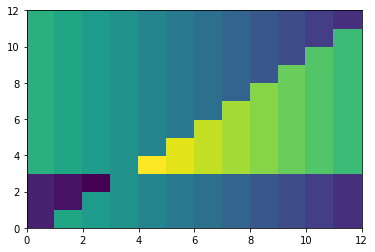

In [ ]:
# generating the index matrix for different 

lead_time_label = np.zeros((14,14))


for init_month in range(1,13):
    if init_month<4:
        for target_month in range(1,13):
            if (init_month<=target_month) and (target_month<=3):
                lead_time_label[init_month,target_month] = 3-init_month
            else:
                lead_time_label[init_month,target_month] = 3-init_month+12
    elif init_month==4:
        for target_month in range(1,13):
            lead_time_label[init_month,target_month] = 11
    else:
        for target_month in range(1,13):
            if (init_month<=target_month) and (target_month>3):
                lead_time_label[init_month,target_month] = 3-init_month+12
            elif (target_month<=init_month) and (target_month<=3):
                lead_time_label[init_month,target_month] = 3-init_month+12
            else:
                lead_time_label[init_month,target_month] = 3-init_month+12+12    
                
                
plt.figure()
plt.pcolor(np.transpose(lead_time_label[1:13,1:13]))

(14, 14)

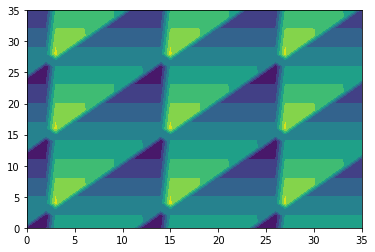

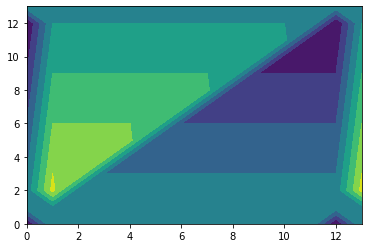

In [ ]:
lead_time_label[1:13,1:13]
template = np.concatenate((lead_time_label[1:13,1:13], lead_time_label[1:13,1:13], lead_time_label[1:13,1:13]), axis=0)
template = np.concatenate((template,template,template),axis=1)
plt.figure()
plt.contourf(template)
lead_time_label2 = template[2:16,2:16]
#lead_time_label2 = 
plt.figure()
plt.contourf(lead_time_label2)
np.shape(lead_time_label2)

Text(0.5, 1.0, 'Lead Time Checkerboard')

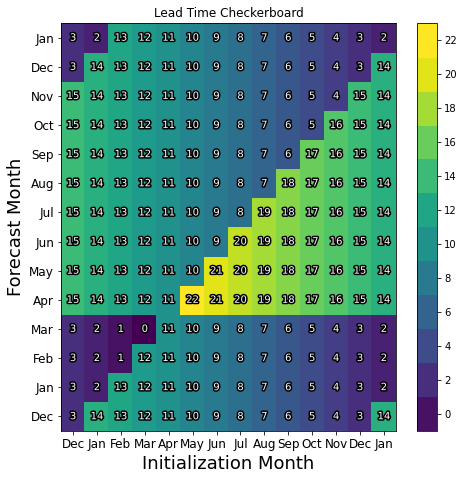

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patheffects as path_effects
import matplotlib.image as mpimg


lead_time_label[0,1:-1]    = lead_time_label[1:13,1:13][-1,:]
lead_time_label[-1,1:-1]   = lead_time_label[1:13,1:13][0,:]
lead_time_label[:,0]       = lead_time_label[:,-2]
lead_time_label[:,-1]      = lead_time_label[:,1]

fig  = plt.figure()
cs   = plt.pcolor(np.transpose(lead_time_label))
cbar = plt.colorbar(cs,boundaries=np.arange(0,25,2), ticks=np.arange(1,26,2))
cbar.ax.set_yticklabels(['0','2','4','6','8','10','12','14','16','18','20','22'])
plt.xticks(np.arange(0.5,17,1),('Dec','Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct', 'Nov',\
                                'Dec','Jan','Feb','Mar','Apr'),fontsize=12)
plt.yticks(np.arange(0.5,17,1),('Dec','Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct', 'Nov',\
                                'Dec','Jan','Feb','Mar','Apr'),fontsize=12)

for i in range(14):
    for j in range(14):
        #plt.text(i+0.25, j+0.25, str(int(lead_time_label[i,j])), fontsize=12)
        text = plt.text(i+0.5, j+0.5, str(int(lead_time_label[i,j])), color='white',\
                          ha='center', va='center', size=10)
        text.set_path_effects([path_effects.Stroke(linewidth=3, foreground='black'),
                       path_effects.Normal()])

        
plt.ylim(0,14)
plt.xlim(0,14)
plt.xlabel('Initialization Month',fontsize=18)
plt.ylabel('Forecast Month',fontsize=18)
fig.set_size_inches(7.5, 7.5) 
plt.title('Lead Time Checkerboard')




#fig.savefig('/home/Kai-chi.Tseng/2019_research/SPEAR_tornado/FIGS1.pdf', dpi=300, bbox_inches='tight')
#fig.savefig('/home/Kai-chi.Tseng/2019_research/SPEAR_tornado/FIGS1.png', dpi=300, bbox_inches='tight')
#plt.colorbar(cs)

(12, 12)

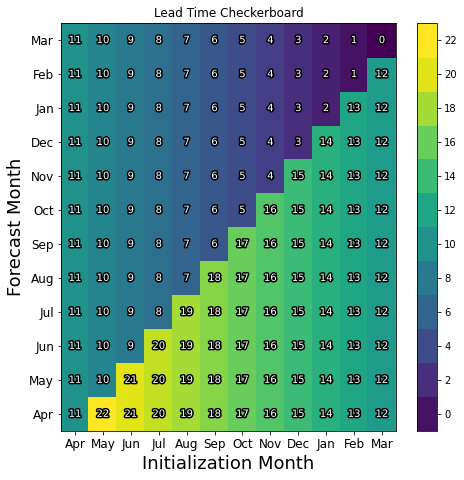

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patheffects as path_effects
import matplotlib.image as mpimg


lead_time_label2 = template[3:15,3:15]

fig  = plt.figure()
cs   = plt.pcolor(np.transpose(lead_time_label2))
cbar = plt.colorbar(cs,boundaries=np.arange(0,25,2), ticks=np.arange(1,26,2))
cbar.ax.set_yticklabels(['0','2','4','6','8','10','12','14','16','18','20','22'])
plt.xticks(np.arange(0.5,17,1),('Apr','May','Jun','Jul','Aug','Sep','Oct', 'Nov',\
                                'Dec','Jan','Feb','Mar','Apr','May','Jun', 'Jul','Aug'),fontsize=12)
plt.yticks(np.arange(0.5,17,1),('Apr','May','Jun','Jul','Aug','Sep','Oct', 'Nov',\
                                'Dec','Jan','Feb','Mar','Apr','May','Jun', 'Jul','Aug'),fontsize=12)

for i in range(12):
    for j in range(12):
        #plt.text(i+0.25, j+0.25, str(int(lead_time_label[i,j])), fontsize=12)
        text = plt.text(i+0.5, j+0.5, str(int(lead_time_label2[i,j])), color='white',\
                          ha='center', va='center', size=10)
        text.set_path_effects([path_effects.Stroke(linewidth=3, foreground='black'),
                       path_effects.Normal()])

        
plt.ylim(0,12)
plt.xlim(0,12)
plt.xlabel('Initialization Month',fontsize=18)
plt.ylabel('Forecast Month',fontsize=18)
fig.set_size_inches(7.5, 7.5) 
plt.title('Lead Time Checkerboard')

np.shape(lead_time_label2)


#fig.savefig('/home/Kai-chi.Tseng/2019_research/SPEAR_tornado/FIGS1.pdf', dpi=300, bbox_inches='tight')
#fig.savefig('/home/Kai-chi.Tseng/2019_research/SPEAR_tornado/FIGS1.png', dpi=300, bbox_inches='tight')


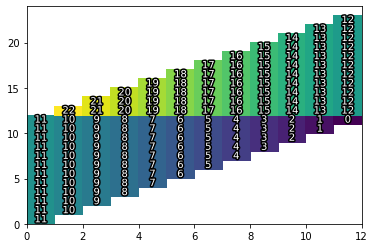

In [ ]:
# replot the checker board 
lead_time_label_concatenate = np.concatenate((lead_time_label2,lead_time_label2,lead_time_label2),axis=0)
lead_time_label_concatenate = np.concatenate((lead_time_label_concatenate,lead_time_label_concatenate,lead_time_label_concatenate),axis=1)
lead_time_label_concatenate = lead_time_label_concatenate.T[0:24,12:24]

for i in range(12):
    for j in range(24):
        if ((j-i)>11 and (j>i)):
          lead_time_label_concatenate[j,i]=np.nan
        elif ((i-j)<12 and (i>j)):
          lead_time_label_concatenate[j,i]=np.nan

plt.figure()
plt.pcolor(lead_time_label_concatenate)
for i in range(24):
    for j in range(12):
        #plt.text(i+0.25, j+0.25, str(int(lead_time_label[i,j])), fontsize=12)
        if ~np.isnan(lead_time_label_concatenate[i,j]):
          text = plt.text(j+0.5, i+0.5, str(int(lead_time_label_concatenate[i,j])), color='white',\
                          ha='center', va='center', size=10)
          text.set_path_effects([path_effects.Stroke(linewidth=3, foreground='black'),
                       path_effects.Normal()])

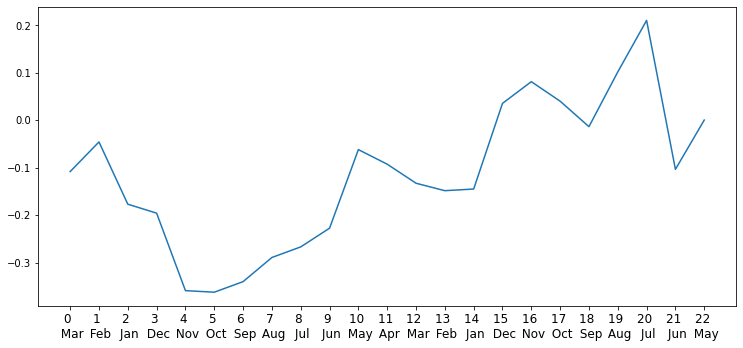

In [ ]:
max_score  = np.zeros((23,))
mean_score  = np.zeros((23,))
std_score  = np.zeros((23,))
init_month = np.zeros((23,))

for lead in range(23):
    posi_x,posi_y      = np.where(lead_time_label==lead)
    max_score[lead,]   = np.max(score_map2[posi_x,posi_y])
    mean_score[lead,]  = np.mean(score_map2[posi_x,posi_y])
    std_score[lead,]   = np.std(score_map2[posi_x,posi_y])
    init_month[lead,]  = posi_x[0]

posi = np.where(init_month==0)
init_month[posi] = init_month[posi]+12 

fig = plt.figure()
plt.plot(mean_score)
plt.xticks(np.arange(0,23,1),['0 \n Mar', '1 \n Feb', '2 \n Jan', '3 \n Dec', '4 \n Nov',  '5 \n Oct',\
                              '6 \n Sep', '7 \n Aug', '8 \n Jul', '9 \n Jun', '10 \n May', '11 \n Apr',\
                              '12 \n Mar', '13 \n Feb', '14 \n Jan', '15 \n Dec', '16 \n Nov', '17 \n Oct',\
                              '18 \n Sep', '19 \n Aug', '20 \n Jul', '21 \n Jun', '22 \n May'],fontsize=12)
fig.set_size_inches(12.5, 5.5)    

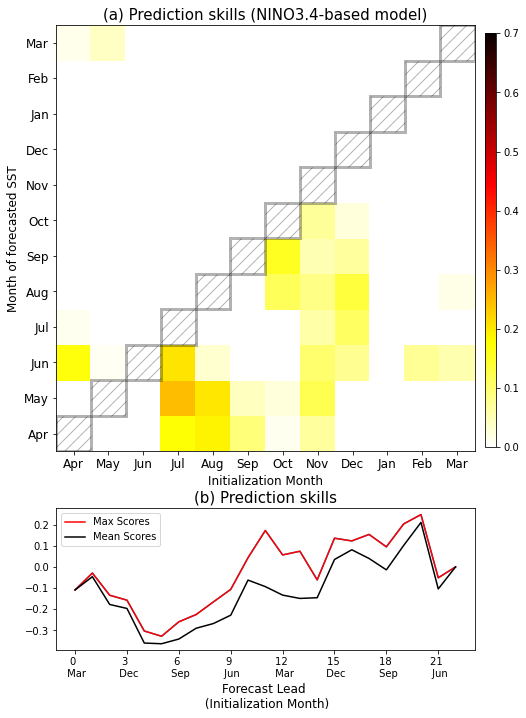

In [ ]:
template   = np.concatenate((score_map2[1:13,1:13], score_map2[1:13,1:13], score_map2[1:13,1:13]), axis=0)
template   = np.concatenate((template,template,template),axis=1)
score_map3 = template[3:15,3:15]
score_map3_NINO = template[3:15,3:15]

fig, axs = plt.subplots(2, 1, gridspec_kw={'height_ratios': [3, 1]})
cs1      = axs[0].pcolor(np.transpose(score_map3),cmap=my_map,vmin=0,vmax=0.7)
axs[0].set_xticks(np.arange(0.5,17,1), minor=False)
axs[0].set_xticklabels(('Apr','May','Jun','Jul','Aug','Sep','Oct', 'Nov',\
                        'Dec','Jan','Feb','Mar','Apr','May','Jun', 'Jul','Aug'), fontdict=None, minor=False,fontsize=12)
axs[0].set_yticks(np.arange(0.5,17,1), minor=False)
axs[0].set_yticklabels(('Apr','May','Jun','Jul','Aug','Sep','Oct', 'Nov',\
                        'Dec','Jan','Feb','Mar','Apr','May','Jun', 'Jul','Aug'), minor=False,fontsize=12)

for j in range(0,14):
    x1 = [j,j+1,j+1,j]
    y1 = [(j)-1+1,(j)-1+1,(j)-1+2,(j)-1+2]
    axs[0].fill(x1,y1 , facecolor="white",edgecolor='k',hatch='//',alpha=0.3,linewidth=3)
axs[0].set_xlabel('Initialization Month',fontsize=12)
axs[0].set_ylabel('Month of forecasted SST',fontsize=12)
axs[0].set_title('(a) Prediction skills (NINO3.4-based model)',fontsize=15) 
axs[0].set_ylim(0,12)
axs[0].set_xlim(0,12)

cs2     = axs[1].plot(max_score)
axs[1].set_title('(b) Prediction skills',fontsize=15)
axs[1].plot(max_score,'r', label='Max Scores')
axs[1].plot(mean_score,'k', label='Mean Scores')
axs[1].legend()
axs[1].set_xticks(np.arange(0,23,3), minor=False)
axs[1].set_xticklabels(['0 \n Mar',  '3 \n Dec', \
                              '6 \n Sep',  '9 \n Jun',\
                              '12 \n Mar',  '15 \n Dec',\
                              '18 \n Sep',  '21 \n Jun',], fontdict=None, minor=False,fontsize=10)
axs[1].set_xlabel('Forecast Lead \n (Initialization Month)',fontsize=12)
fig.set_size_inches(7.5, 11.5)
cbar_ax = fig.add_axes([0.92, 0.37, 0.02,0.5])   
cbar    = fig.colorbar(cs1, cax=cbar_ax, orientation='vertical')

#fig.savefig('/home/Kai-chi.Tseng/2019_research/SPEAR_tornado/FIG2.pdf', dpi=300, bbox_inches='tight')
#fig.savefig('/home/Kai-chi.Tseng/2019_research/SPEAR_tornado/FIG2.png', dpi=300, bbox_inches='tight')

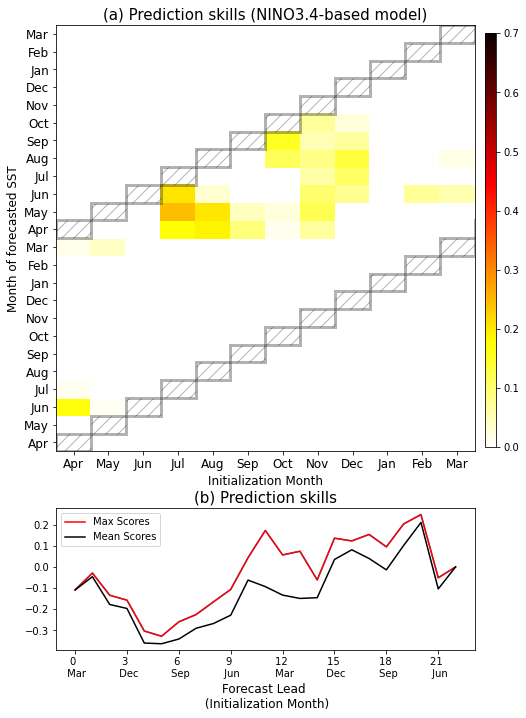

In [ ]:
# replot 

score_map3_NINO_concatenate = np.concatenate((score_map3_NINO,score_map3_NINO,score_map3_NINO),axis=0)
score_map3_NINO_concatenate = np.concatenate((score_map3_NINO_concatenate,score_map3_NINO_concatenate,score_map3_NINO_concatenate),axis=1)
score_map3_NINO_concatenate = score_map3_NINO_concatenate.T[0:24,12:24]

for i in range(12):
    for j in range(24):
        if ((j-i)>11 and (j>i)):
          score_map3_NINO_concatenate[j,i]=np.nan
        elif ((i-j)<12 and (i>j)):
          score_map3_NINO_concatenate[j,i]=np.nan


fig, axs = plt.subplots(2, 1, gridspec_kw={'height_ratios': [3, 1]})
cs1      = axs[0].pcolor(score_map3_NINO_concatenate,cmap=my_map,vmin=0,vmax=0.7)
axs[0].set_xticks(np.arange(0.5,17,1), minor=False)
axs[0].set_xticklabels(('Apr','May','Jun','Jul','Aug','Sep','Oct', 'Nov',\
                        'Dec','Jan','Feb','Mar','Apr','May','Jun', 'Jul','Aug'), fontdict=None, minor=False,fontsize=12)
axs[0].set_yticks(np.arange(0.5,24,1), minor=False)
axs[0].set_yticklabels(('Apr','May','Jun','Jul','Aug','Sep','Oct', 'Nov',\
                        'Dec','Jan','Feb','Mar','Apr','May','Jun', 'Jul','Aug','Sep','Oct', 'Nov','Dec','Jan','Feb','Mar'), minor=False,fontsize=12)

for j in range(0,14):
    x1 = [j,j+1,j+1,j]
    y1 = [(j)-1+1,(j)-1+1,(j)-1+2,(j)-1+2]
    axs[0].fill(x1,y1 , facecolor="white",edgecolor='k',hatch='//',alpha=0.3,linewidth=3)
    x1 = [j,j+1,j+1,j]
    y1 = [(j)-1+1+12,(j)-1+1+12,(j)-1+2+12,(j)-1+2+12]
    axs[0].fill(x1,y1 , facecolor="white",edgecolor='k',hatch='//',alpha=0.3,linewidth=3)
axs[0].set_xlabel('Initialization Month',fontsize=12)
axs[0].set_ylabel('Month of forecasted SST',fontsize=12)
axs[0].set_title('(a) Prediction skills (NINO3.4-based model)',fontsize=15) 
axs[0].set_ylim(0,24)
axs[0].set_xlim(0,12)

cs2     = axs[1].plot(max_score)
axs[1].set_title('(b) Prediction skills',fontsize=15)
axs[1].plot(max_score,'r', label='Max Scores')
axs[1].plot(mean_score,'k', label='Mean Scores')
axs[1].legend()
axs[1].set_xticks(np.arange(0,23,3), minor=False)
axs[1].set_xticklabels(['0 \n Mar',  '3 \n Dec', \
                              '6 \n Sep',  '9 \n Jun',\
                              '12 \n Mar',  '15 \n Dec',\
                              '18 \n Sep',  '21 \n Jun',], fontdict=None, minor=False,fontsize=10)
axs[1].set_xlabel('Forecast Lead \n (Initialization Month)',fontsize=12)
fig.set_size_inches(7.5, 11.5)
cbar_ax = fig.add_axes([0.92, 0.37, 0.02,0.5])   
cbar    = fig.colorbar(cs1, cax=cbar_ax, orientation='vertical')


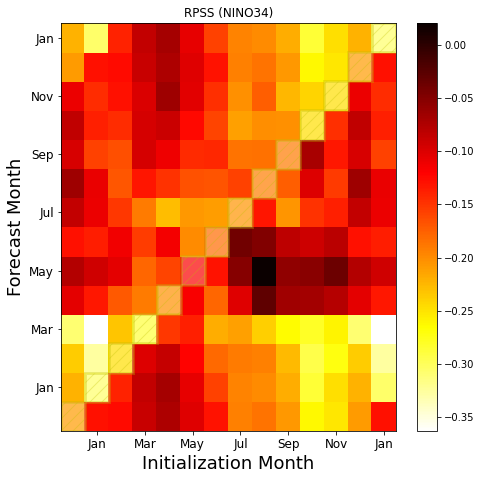

In [ ]:
fig= plt.figure()
score_map2            = np.zeros((14,14))
score_map2[1:-1,1:-1] = RPSS_NINO34[:,:]
score_map2[0,1:-1]    = RPSS_NINO34[:,:][-1,:]
score_map2[-1,1:-1]   = RPSS_NINO34[:,:][0,:]
score_map2[:,0]       = score_map2[:,-2]
score_map2[:,-1]      = score_map2[:,1]
    
plt.title('RPSS (NINO34)')
x_ticks= np.arange(0,12)
plt.xticks(x_ticks,x_ticks+1)
plt.yticks(x_ticks,x_ticks+1)
    
cs  = plt.pcolor(np.transpose(score_map2),cmap=my_map)
plt.colorbar(cs)
plt.xticks(np.arange(1.5,17,2),('Jan','Mar','May','Jul','Sep','Nov',\
                                    'Jan','Mar'),fontsize=12)
plt.yticks(np.arange(1.5,17,2),('Jan','Mar','May','Jul','Sep','Nov',\
                                    'Jan','Mar'),fontsize=12)
for j in range(0,14):
    x1 = [j,j+1,j+1,j]
    y1 = [(j)-1+1,(j)-1+1,(j)-1+2,(j)-1+2]
    plt.fill(x1,y1 , facecolor="white",edgecolor='y',hatch='//',alpha=0.3,linewidth=3)
#if mode>8:
#    plt.xlabel('Forecast Month (predictor)')
#plt.ylabel('Initialization Month ')
plt.xlabel('Initialization Month',fontsize=18)
plt.ylabel('Forecast Month',fontsize=18)
fig.set_size_inches(7.5, 7.5)    

In [ ]:
np.shape(sst_model)

(12, 360, 360, 576)

## Generate SST EOF modes (don't run it until necessary)

In [ ]:
count = 0
sst_model_ens = np.zeros((15,12,372,360,576))
sst_model     = np.zeros((12,372,360,576))
for init_time in ['01','02','03','04','05','06','07','08','09','10','11','12']:
    if init_time =='01' or init_time =='02': 
        dates = pd.date_range('1992-'+init_time,  periods=362, freq='1M') # total length of reanalysis data
        posi  = np.squeeze(np.where((dates.year>=1992) & (dates.year<=2022)))
    else: 
        dates = pd.date_range('1992-'+init_time,  periods=360, freq='1M') # total length of reanalysis data
        posi  = np.squeeze(np.where((dates.year>=1992) & (dates.year<=2021)))
    for ens in range(1,16,1):
        nc    = NetCDFFile("/content/drive/MyDrive/Colab/2021_research/tornado_data/SST_"+init_time+"_ens%02d.nc" % (ens,))
        data  = nc.variables['SST'][:,:,:]
        #sst_model_ens[ens-1,count,:,:,:] = data[36:36+276,:,:]
        if init_time =='01' or init_time =='02': 
            sst_model_ens[ens-1,count,:362,:,:] = data[:362,:,:]
        else:
            sst_model_ens[ens-1,count,:360,:,:] = data[:360,:,:]
    sst_model[count,:,:,:]=sst_model_ens[:,count,:,:,:].mean(axis=0)
    count=count+1
    

In [ ]:
sst_model_ens[sst_model_ens>10000]=0

In [ ]:
sst_model_anomaly = np.zeros(np.shape(sst_model_ens))

for init_month in range(1,13):         # for initialization month 
    if init_month == 1 or init_month == 2:
        dates_1M      = pd.date_range('1992-'+str(init_month).zfill(2)+'', periods=362, freq='1M')
    else:
        dates_1M      = pd.date_range('1992-'+str(init_month).zfill(2)+'', periods=360, freq='1M')
    for month in range(1,13):          # month used as predictors 
        posi      = np.squeeze(np.where(dates_1M.month==month))
        sst_map   = np.squeeze(sst_model_ens[:,init_month-1,posi,:,:]) 
        sst_model_anomaly[:,init_month-1,posi,:,:] = sst_map-np.mean(sst_map,axis=1,keepdims=True)

In [ ]:
np.shape(sst_model_ens)

(15, 12, 362, 360, 576)

In [ ]:
dates_1M      = pd.date_range('1992-'+str(1).zfill(2)+'', periods=360, freq='1M') 
dates_1M.month

Int64Index([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10,
            ...
             3,  4,  5,  6,  7,  8,  9, 10, 11, 12],
           dtype='int64', length=360)

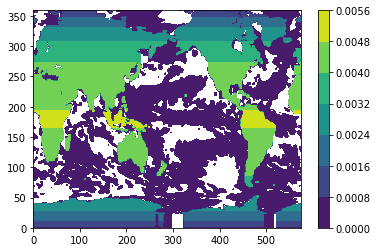

In [ ]:
xx_sst,yy_sst = np.meshgrid(lon_SST_obs,lat_SST_obs)
if 'weighted_sst' in locals():
      del weighted_sst
from scipy import stats
from sklearn import linear_model
regr             = linear_model.LinearRegression()
#import_file      = sst_model_anomaly
#xx2,yy2          = np.meshgrid(xx_sst,lat2)
weight           = np.cos(yy_sst/180*3.1416)**(0.5)
#weighted_sst     = np.zeros((import_file.shape[0],import_file.shape[1],import_file.shape[2],import_file.shape[3],import_file.shape[4]))


weighted_sst     = sst_model_anomaly[:,:,36:36+276,:,:]*weight

#for init_time in range(12):
#    for total_time in range(276):
#        weighted_sst[:,init_time,total_time,:,:] = sst_model_anomaly[:,init_time,total_time,:,:]*weight
        
weighted_sst     = np.reshape(weighted_sst, (weighted_sst.shape[0]*weighted_sst.shape[1]*weighted_sst.shape[2],weighted_sst.shape[3]*weighted_sst.shape[4]))
modes            = 20
pca              = PCA(n_components=modes)
pca.fit(weighted_sst)
obs_var          = pca.explained_variance_


# get the time series 
pcs_obs_sst      = np.zeros((modes,weighted_sst.shape[0]))
std              = np.zeros((modes,))
EOFs_tornado     = np.zeros((modes,sst_model_anomaly.shape[3],sst_model_anomaly.shape[4]))

for i in range(modes):
    pcs_obs_sst[i,:]     = np.dot(weighted_sst, pca.components_[i,:])
    pcs_obs_sst[i,:]     = pcs_obs_sst[i,:]/np.std(pcs_obs_sst[i,:])

EOF = np.reshape(pca.components_,[modes,sst_model_anomaly.shape[3],sst_model_anomaly.shape[4]])
cs  = plt.contourf(EOF[0,:,:])
plt.colorbar(cs)


(15, 12, 372, 360, 576)


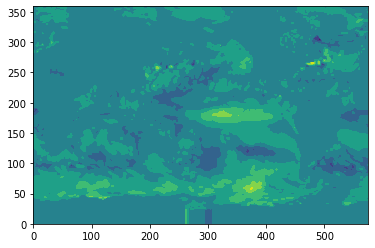

In [ ]:
print(np.shape(sst_model_anomaly))
plt.figure()
plt.contourf(sst_model_anomaly[0,0,0,:,:])

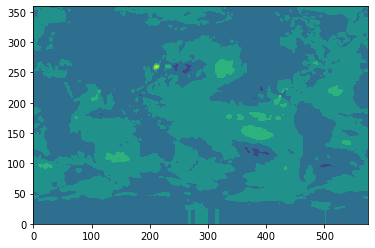

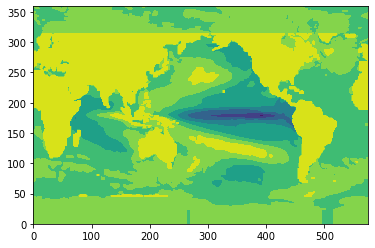

In [ ]:
#weighted_sst = np.reshape(weighted_sst,np.shape(sst_model_anomaly[:,:,36:36+276,:,:]))
#print(np.shape(weighted_sst))
plt.figure()
plt.contourf(weighted_sst[0,0,275,:,:])

data        = np.load('/content/drive/MyDrive/Colab/2021_research/tornado_data/SST_EOFs_1995_2017_based.npz')
EOF2        = data['EOF']
plt.figure()
plt.contourf(EOF[0,:,:]-EOF2[0,:,:])

(15, 12, 372, 360, 576)


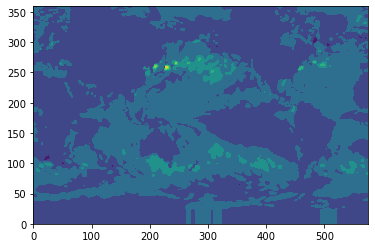

In [ ]:
print(np.shape(sst_model_anomaly))
plt.figure()
cs=plt.contourf(sst_model_anomaly[0,1,361,:,:])
#sst_model_anomaly[0,0,361,:,:]

In [ ]:
modes            = 20    
x_sst,yy_sst     = np.meshgrid(lon_SST_obs,lat_SST_obs)
weight           = np.cos(yy_sst/180*3.1416)**(0.5)
data             = np.load('/content/drive/MyDrive/Colab/2021_research/tornado_data/SST_EOFs_1995_2017_based.npz')
EOF2             = data['EOF']
weighted_sst     = sst_model_anomaly[:,:,:,:,:]*weight
weighted_sst     = np.reshape(weighted_sst, (weighted_sst.shape[0]*weighted_sst.shape[1]*weighted_sst.shape[2],weighted_sst.shape[3]*weighted_sst.shape[4]))
pcs_obs_sst      = np.zeros((modes,weighted_sst.shape[0]))
#std              = np.zeros((modes,))
#EOFs_tornado     = np.zeros((modes,sst_model_anomaly.shape[3],sst_model_anomaly.shape[4]))

#for i in range(modes):
#    pcs_obs_sst[i,:]     = np.dot(weighted_sst, pca.components_[i,:])
#    pcs_obs_sst[i,:]     = pcs_obs_sst[i,:]/np.std(pcs_obs_sst[i,:])
    

for i in range(modes):
    pcs_components       = np.reshape(EOF2[i,:,:],[360*576,])
    pcs_obs_sst[i,:]     = np.dot(weighted_sst, pcs_components)
    pcs_obs_sst[i,:]     = pcs_obs_sst[i,:]/np.std(pcs_obs_sst[i,:])    


(15, 12, 372, 360, 576)


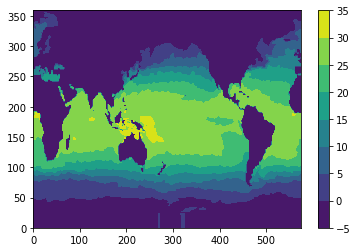

In [ ]:
#sst_model_ens[sst_model_ens>1000] = 0
print(np.shape(sst_model_ens))
plt.figure()
cs=plt.contourf(sst_model_ens[0,0,361,:,:])
plt.colorbar(cs)

In [ ]:
pcs_obs_sst              = np.zeros((modes,weighted_sst.shape[0]))
for i in range(1):
    pcs_components       = np.reshape(EOF2[i,:,:],[360*576,])
    pcs_obs_sst[i,:]     = np.dot(weighted_sst, pcs_components)
    #pcs_obs_sst[i,:]     = pcs_obs_sst[i,:]/np.std(pcs_obs_sst[i,:])    


In [ ]:
pcs_obs_sst = np.reshape(pcs_obs_sst,[20,15,12,31,12])  # modes, member, init_month, year, forecast lead
pcs_obs_sst[0,0,1,:,1]

array([ 1.26884014e+02,  1.14372817e+02,  4.47003717e+01,  1.14169370e+02,
        6.47115970e+01,  6.91989313e+01,  1.75926066e+02,  1.69718267e+00,
       -2.85173566e+01,  6.99257887e+01,  1.11169656e+02,  1.32568708e+02,
        1.34656619e+02,  1.48625748e+02,  5.63710780e+01,  1.46406167e+02,
        2.49547747e+01,  5.06527037e+01,  1.86849065e+02,  2.59369637e+01,
        7.27234929e+01,  9.39847450e+01,  1.33790287e+02,  1.67771609e+02,
        2.51620738e+02,  1.69112776e+02,  9.41613865e+01,  1.82723110e+02,
        1.42407113e+02,  7.87816736e+01, -3.15833719e+03])

In [ ]:
pca.explained_variance_/np.sum(pca.explained_variance_)

array([0.27742113, 0.15897805, 0.06865737, 0.05919226, 0.04563013,
       0.04089782, 0.03858378, 0.03618775, 0.0319094 , 0.03124574,
       0.02792491, 0.02716603, 0.02525876, 0.02240757, 0.02069418,
       0.01902242, 0.01892541, 0.01795327, 0.0166933 , 0.01525073])

In [ ]:
np.sum(pca.explained_variance_ratio_)

0.5221090228253813

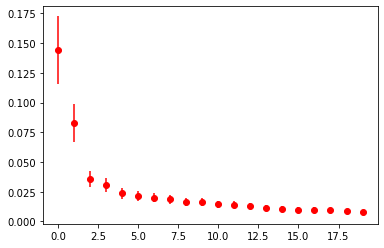

In [ ]:
plt.figure()
x=np.arange(0,20,1);
plt.errorbar(x,pca.explained_variance_ratio_,\
               pca.explained_variance_ratio_*np.power(2/52,0.5), fmt='ro')
np.savez('/content/drive/MyDrive/Colab/2021_research/tornado_data/SST_EOFs_1995_2017_based.npz',\
          pcs_obs_sst = pcs_obs_sst,\
          EOF         = EOF,\
          variance    = pca.explained_variance_ratio_
          )

In [ ]:
np.savez('/content/drive/MyDrive/Colab/2021_research/tornado_data/SST_EOFs_1995_2017_based_updated.npz',\
          pcs_obs_sst = pcs_obs_sst,\
          EOF2        = EOF2,\
          )

# Figure 4

In [ ]:
#data        = np.load('/archive/Kai-chi.Tseng/data/SPEAR_tornado_seasonal/SST_EOFs_1992_2021.npz')
data        = np.load('/content/drive/MyDrive/Colab/2021_research/tornado_data/SST_EOFs_1995_2017_based.npz')
pcs_obs_sst = data['pcs_obs_sst']
EOF         = data['EOF']
variance    = data['variance']
pcs_obs_sst = np.reshape(pcs_obs_sst,[20,15,12,30,12])  # modes, member, init_month, year, forecast lead

In [ ]:
#os.system('dmegt /archive/Kai-chi.Tseng/data/SPEAR_tornado_seasonal/SST_EOFs_1992_2021.npz')
data        = np.load('/content/drive/MyDrive/Colab/2021_research/tornado_data/SST_EOFs_1992_2021.npz')
data.files

['pcs_obs_sst', 'EOF', 'variance']

array([[ 1.        , -0.21369839],
       [-0.21369839,  1.        ]])

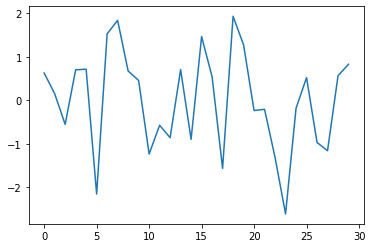

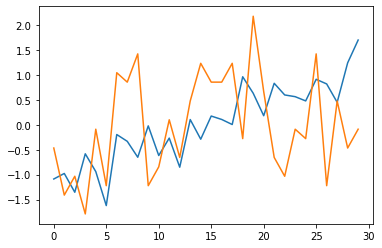

In [ ]:
pcs_obs_sst = np.reshape(pcs_obs_sst,[20,15,12,30,12])  
series1 = tornado_day_CONUS_monthly
series1 = (series1-np.mean(series1))/np.std(series1)
plt.figure()
plt.plot(-pcs_obs_sst[0,:,11,:,0].mean(axis=0))
plt.figure()
plt.plot(-pcs_obs_sst[1,:,11,:,0].mean(axis=0))

plt.plot(series1)
np.corrcoef(pcs_obs_sst[0,:,0,:,0].mean(axis=0),series1)

array([[ 1.        , -0.21369839],
       [-0.21369839,  1.        ]])

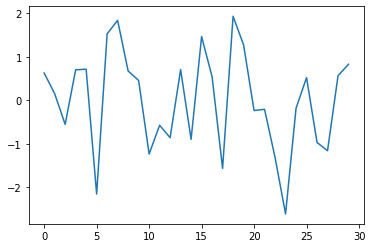

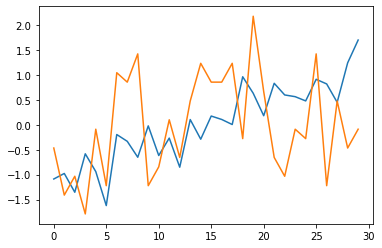

In [ ]:
pcs_obs_sst = np.reshape(pcs_obs_sst,[20,15,12,30,12])  
series1 = tornado_day_CONUS_monthly
series1 = (series1-np.mean(series1))/np.std(series1)
plt.figure()
plt.plot(-pcs_obs_sst[0,:,11,:,0].mean(axis=0))
plt.figure()
plt.plot(-pcs_obs_sst[1,:,11,:,0].mean(axis=0))

plt.plot(series1)
np.corrcoef(pcs_obs_sst[0,:,0,:,0].mean(axis=0),series1)

In [ ]:
np.shape(pcs_obs_sst)

(20, 15, 12, 30, 12)

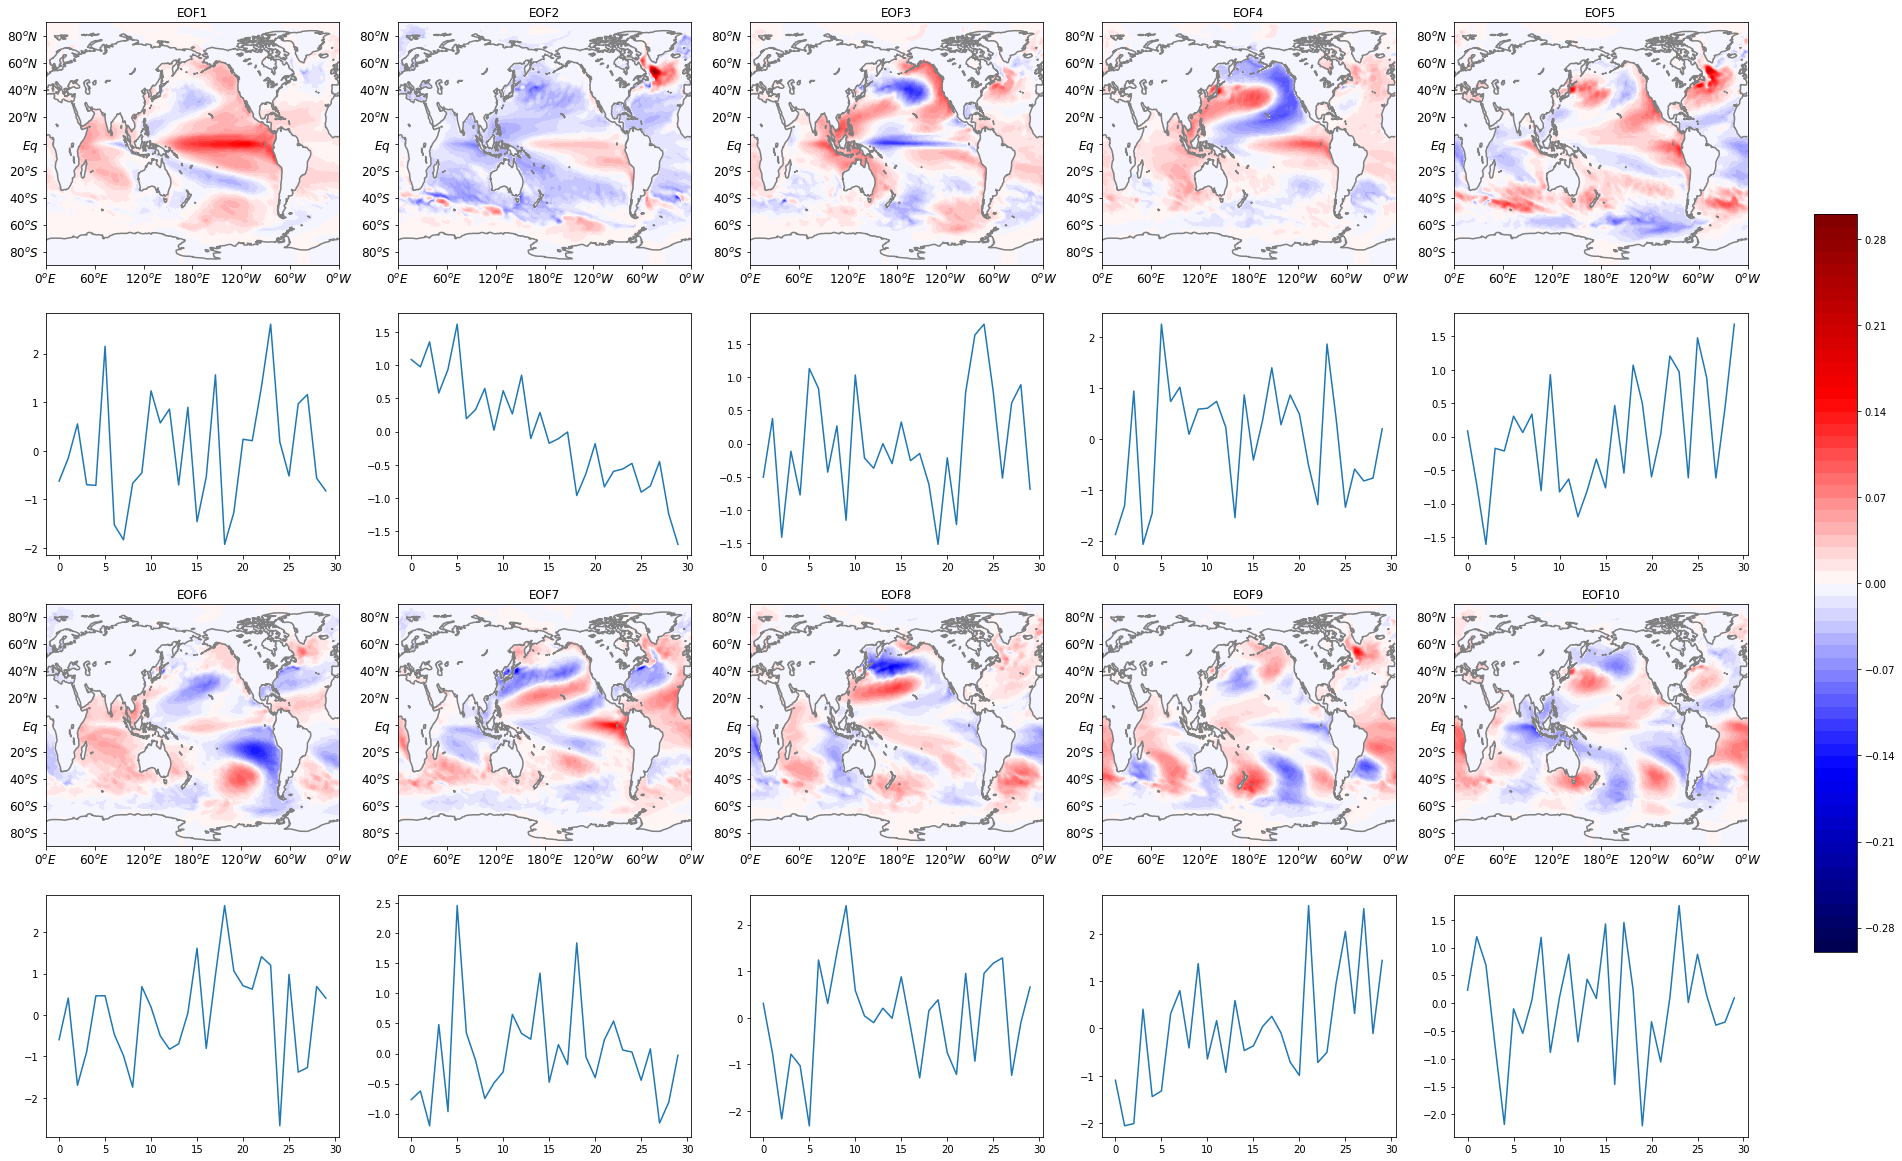

In [ ]:
xx_sst,yy_sst = np.meshgrid(lon_SST_obs,lat_SST_obs)

fig= plt.figure()
for mode in range(10):
    if mode<5:
        plt.subplot(4,5,mode+1)
        cs=plt.contourf(xx_sst,yy_sst,EOF[mode,:,:]*10,levels=np.arange(-0.03,0.031,0.001)*10,cmap='seismic',)
        plt.plot(costal_lon,costal_lat,'gray')
        plt.xlim([0,360])
        plt.xticks([0, 60, 120, 180,240,300,360], ['$0^oE$', '$60^oE$','$120^oE$', '$180^oE$', '$120^oW$', '$60^oW$', '$0^oW$'],fontsize=12) 
        plt.yticks([-80,-60,-40,-20,0, 20,40,60,80], ['$80^oS$', '$60^oS$', '$40^oS$', '$20^oS$', '$Eq$', '$20^oN$', '$40^oN$', '$60^oN$', '$80^oN$'],fontsize=12)
        plt.title('EOF'+str(mode+1))
    
        plt.subplot(4,5,mode+1+5)
        plt.plot(pcs_obs_sst[mode,:,11,:,0].mean(axis=0))
    else: 
        plt.subplot(4,5,mode+1+5)
        cs=plt.contourf(xx_sst,yy_sst,EOF[mode,:,:]*10,levels=np.arange(-0.03,0.031,0.001)*10,cmap='seismic',)
        plt.plot(costal_lon,costal_lat,'gray')
        plt.xlim([0,360])
        plt.xticks([0, 60, 120, 180,240,300,360], ['$0^oE$', '$60^oE$','$120^oE$', '$180^oE$', '$120^oW$', '$60^oW$', '$0^oW$'],fontsize=12) 
        plt.yticks([-80,-60,-40,-20,0, 20,40,60,80], ['$80^oS$', '$60^oS$', '$40^oS$', '$20^oS$', '$Eq$', '$20^oN$', '$40^oN$', '$60^oN$', '$80^oN$'],fontsize=12)
        plt.title('EOF'+str(mode+1))
        
        
        plt.subplot(4,5,mode+1+5+5)
        plt.plot(pcs_obs_sst[mode,:,11,:,0].mean(axis=0))

fig.set_size_inches(20.5, 15.5)
cbar_ax = fig.add_axes([0.93, 0.25, 0.02, 0.5])   
cbar = fig.colorbar(cs, cax=cbar_ax, orientation='vertical')

fig.set_size_inches(30.5, 20.5)
#fig.savefig('/home/Kai-chi.Tseng/2019_research/SPEAR_tornado/FIG3.pdf', dpi=300, bbox_inches='tight')
#fig.savefig('/home/Kai-chi.Tseng/2019_research/SPEAR_tornado/FIG3.png', dpi=300, bbox_inches='tight')

In [ ]:
np.shape(data['pcs_obs_sst'])

(20, 66960)

In [ ]:
data         = np.load('/content/drive/MyDrive/Colab/2021_research/tornado_data/SST_EOFs_1995_2017_based_updated.npz')
pcs_obs_sst  = np.reshape(data['pcs_obs_sst'][:,:],[20,15,12,31,12])
pcs_obs_sst  = pcs_obs_sst[:,:,:,0:30,:]
# using linear regression to identify the SST pattern 
series       = np.reshape(pcs_obs_sst.mean(axis=1),[20,12*30*12])
sst_EOF_maps = np.zeros((20,360,576))
for mode in range(20):
    Y_mat          = np.reshape(sst_model[:,0:360,:,:],[sst_model.shape[0]*360,sst_model.shape[2]*sst_model.shape[3]]) # reshape 3D array to 2D array for matrix operation
    X_mat          = np.vstack((np.ones(series.shape[1]), series[mode,:])).T

    # coef_total = (X^T X)^(-1) (X^T Y) (you can check wikipedia: https://en.wikipedia.org/wiki/Linear_regression, section: Least-squares estimation and related techniques)
    # coef_total contains both b and a. the first dimension of coef_total is b and the second dimension of coef_total is a  
    coef_total           = np.linalg.inv(X_mat.T.dot(X_mat)).dot(X_mat.T).dot(Y_mat)

    # as mentioned previously, "a" represents the warming trend of cape and "b" is the cape value in reference year
    sst_EOF_maps[mode,:,:] = np.reshape(coef_total[1,:],[360,576])


sst_EOF_maps[sst_EOF_maps>50]= 0
sst_EOF_maps[sst_EOF_maps<-50]= 0    
    

In [ ]:
np.shape(Y_mat)

(4320, 207360)

In [ ]:
np.shape(X_mat)

(4320, 2)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


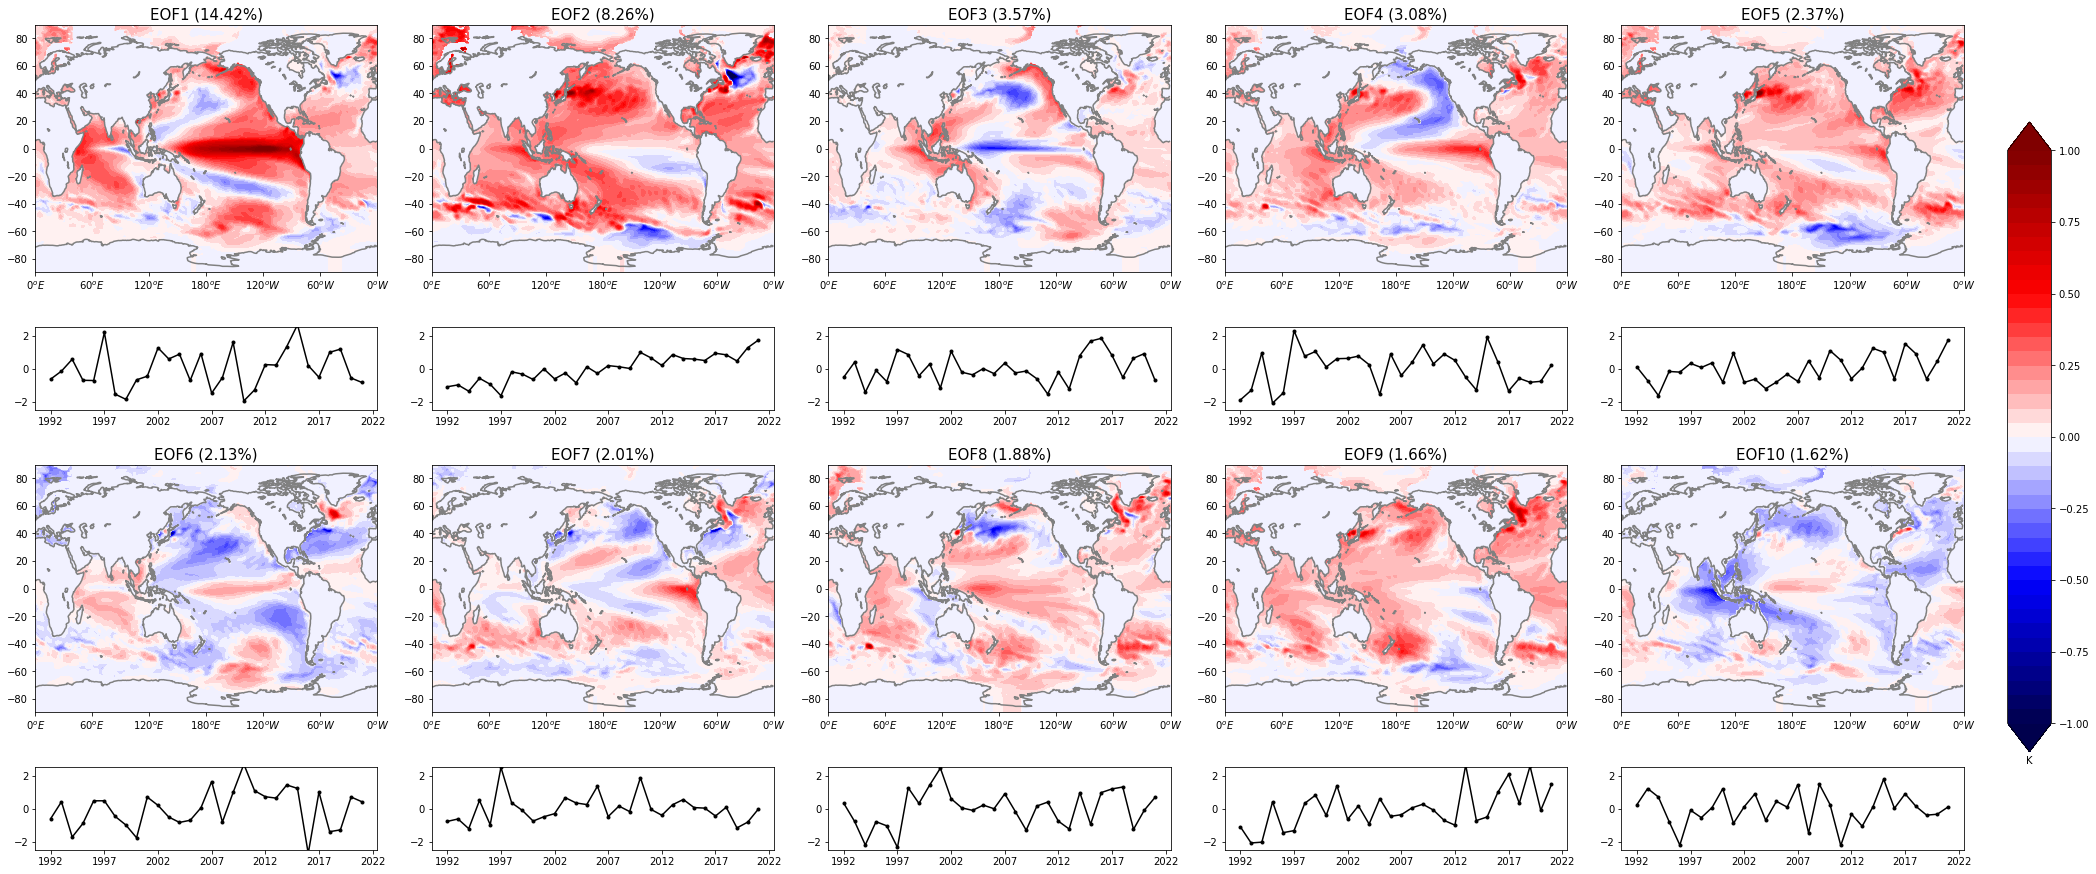

In [ ]:

    
    
xx_sst,yy_sst = np.meshgrid(lon_SST_obs,lat_SST_obs)
fig, axs = plt.subplots(4, 5, gridspec_kw={'height_ratios': [3, 1, 3, 1]})
for mode in range(10):
    if mode<5:
        if mode ==1:
            maps = -np.squeeze(sst_EOF_maps[mode,:,:])
            time_series = -pcs_obs_sst[mode,:,11,:,0].mean(axis=0)
        else:
            maps = np.squeeze(sst_EOF_maps[mode,:,:])
            time_series = pcs_obs_sst[mode,:,11,:,0].mean(axis=0)
        cs=axs[0, mode].contourf(xx_sst,yy_sst,maps,levels=np.arange(-1.0,1.05,0.05),extend='both',cmap='seismic')
        axs[0, mode].plot(costal_lon,costal_lat,'gray')
        axs[0, mode].set_xlim([0,360])
        axs[0, mode].set_xticks([0, 60, 120, 180,240,300,360], minor=False)
        axs[0, mode].set_xticklabels(['$0^oE$', '$60^oE$','$120^oE$', '$180^oE$', '$120^oW$', '$60^oW$', '$0^oW$'], fontdict=None, minor=False)
        #axs[0, mode].xticks([0, 60, 120, 180,240,300,360], ['$0^oE$', '$60^oE$','$120^oE$', '$180^oE$', '$120^oW$', '$60^oW$', '$0^oW$'],fontsize=12) 
        #axs[0, mode].yticks([-80,-60,-40,-20,0, 20,40,60,80], ['$80^oS$', '$60^oS$', '$40^oS$', '$20^oS$', '$Eq$', '$20^oN$', '$40^oN$', '$60^oN$', '$80^oN$'],fontsize=12)
        axs[0, mode].set_title('EOF'+str(mode+1)+' ('+str(round(variance[mode]*100,2))+'%)',fontsize=15)
        
        axs[1, mode].plot(time_series,'k')
        axs[1, mode].plot(time_series,'k.')
        axs[1, mode].set_xticks(np.arange(0,31,5))
        axs[1, mode].set_xticklabels(np.arange(1992,2023,5))
        axs[1, mode].set_ylim(-2.5,2.5)
    if mode>=5:
        cs=axs[2, mode-5].contourf(xx_sst,yy_sst,sst_EOF_maps[mode,:,:],levels=np.arange(-1.0,1.05,0.05),extend='both',cmap='seismic')
        axs[2, mode-5].plot(costal_lon,costal_lat,'gray')
        axs[2, mode-5].set_xlim([0,360])
        axs[2, mode-5].set_xticks([0, 60, 120, 180,240,300,360], minor=False)
        axs[2, mode-5].set_xticklabels(['$0^oE$', '$60^oE$','$120^oE$', '$180^oE$', '$120^oW$', '$60^oW$', '$0^oW$'], fontdict=None, minor=False)
        #axs[0, mode].xticks([0, 60, 120, 180,240,300,360], ['$0^oE$', '$60^oE$','$120^oE$', '$180^oE$', '$120^oW$', '$60^oW$', '$0^oW$'],fontsize=12) 
        #axs[0, mode].yticks([-80,-60,-40,-20,0, 20,40,60,80], ['$80^oS$', '$60^oS$', '$40^oS$', '$20^oS$', '$Eq$', '$20^oN$', '$40^oN$', '$60^oN$', '$80^oN$'],fontsize=12)
        axs[2, mode-5].set_title('EOF'+str(mode+1)+' ('+str(round(variance[mode]*100,2))+'%)',fontsize=15)
        
        axs[3, mode-5].plot(pcs_obs_sst[mode,:,11,:,0].mean(axis=0),'k')
        axs[3, mode-5].plot(pcs_obs_sst[mode,:,11,:,0].mean(axis=0),'k.')
        axs[3, mode-5].set_xticks(np.arange(0,31,5))
        axs[3, mode-5].set_xticklabels(np.arange(1992,2023,5))
        axs[3, mode-5].set_ylim(-2.5,2.5)
        
fig.set_size_inches(30.5, 12.5)
cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
#cbar_ax = fig.add_axes([0.25, 0.00, 0.5, 0.02])   
cbar    = fig.colorbar(cs, cax=cbar_ax, orientation='vertical')
cbar.ax.set_xlabel('K',fontsize=10)
#fig.colorbar.set_axis_label_text('K')
fig.tight_layout(pad=2.0)
fig.subplots_adjust(right=0.9)
# You call fig.tight_layout BEFORE creating the colorbar



#cbar.ax.tick_params(labelsize=9)

#fig.savefig('/home/Kai-chi.Tseng/2019_research/SPEAR_tornado/FIGS1.pdf', dpi=300, bbox_inches='tight')
#fig.savefig('/home/Kai-chi.Tseng/2019_research/SPEAR_tornado/FIGS1.png', dpi=300, bbox_inches='tight')

# Figure 5

In [ ]:
Y_val_LM_sst_EOF = np.zeros((20,12,12,30))
coef_SPEAR_sst   = np.zeros((12,12,30,7)) # initialization month, forecast month, lag, 
data             = np.load('/content/drive/MyDrive/Colab/2021_research/tornado_data/SST_EOFs_1995_2017_based.npz')
pcs_obs_sst      = data['pcs_obs_sst']
pcs_obs_sst      = np.reshape(pcs_obs_sst,[20,15,12,30,12])
pcs_obs_sst      = np.reshape(pcs_obs_sst.mean(axis=1),[20,12,360])

pcs_obs_sst      = np.reshape(pcs_obs_sst,[20,12*360])
for mode in range(20):
    pcs_obs_sst[mode,:] = pcs_obs_sst[mode,:]/np.std(pcs_obs_sst[mode,:])
    
pcs_obs_sst      = np.reshape(pcs_obs_sst,[20,12,360])

tornado_timeseries = (tornado_day_CONUS_monthly-np.mean(tornado_day_CONUS_monthly))/np.std(tornado_day_CONUS_monthly)


for mode in range(1,21):
    for init_month in range(1,13):         # for initialization month 
        dates_1M  = pd.date_range('1992-'+str(init_month).zfill(2)+'', periods=360, freq='1M')     
        for month in range(1,13):          # month used as predictors 
            posi = np.squeeze(np.where((dates_1M.month==month) & (dates_1M.year<=2021)))
            print('init year='+str(1992)+' init month='+str(init_month)+' predictor year ='+str(dates_1M[posi[0]].year) +' predictor month='+str(month))                
         
            if (dates_1M[posi[0]].year==1992) and (month<=3):
                print('Case 1')
                init_year = 1992
                series1   = tornado_day_CONUS_monthly[:]
                series2   = pcs_obs_sst[0:mode,init_month-1,posi]
                #sst_correlation_map[init_month-1,month-1] = np.corrcoef(series1,series2)[0][1]            
            elif (dates_1M[posi[0]].year==1992) and (month>3):
                print('Case 2')
                init_year = 1993
                series1   = tornado_day_CONUS_monthly[1:]
                series2   = pcs_obs_sst[0:mode,init_month-1,posi[:-1]]
                #sst_correlation_map[init_month-1,month-1] = np.corrcoef(series1,series2)[0][1]
            elif (dates_1M[posi[0]].year==1993) and (month<=3):
                print('Case 3')
                init_year = 1993
                series1   = tornado_day_CONUS_monthly[1:]
                series2   = pcs_obs_sst[0:mode,init_month-1,posi]
                #sst_correlation_map[init_month-1,month-1] = np.corrcoef(series1,series2)[0][1]
            elif (dates_1M[posi[0]].year==1993) and (month>3):
                print('Case 4')
                init_year = 1994
                series1   = tornado_day_CONUS_monthly[2:]
                series2   = pcs_obs_sst[0:mode,init_month-1,posi[:-1]]
                #sst_correlation_map[init_month-1,month-1] = np.corrcoef(series1,series2)[0][1]
        
            for year in range(init_year,2022):
            
                series4 = np.delete(series2, year-init_year,1)
                series3 = np.delete(series1, year-init_year)
                X_train = np.zeros((np.size(series3),mode))
                Y_train = np.zeros((np.size(series3),1))
                X_train = np.transpose(series4)
                Y_train[:,0] = series3
                
                
                #series4 = np.delete(series2, year-init_year)
                #series3 = np.delete(series1, year-init_year)
                #X_train = np.zeros((np.size(series2),1))
                #Y_train = np.zeros((np.size(series1),1))
                #X_train = np.transpose(series2)
                #Y_train[:,0] = series1
                #print(tornado_day_CONUS_monthly)
                #print(series1)
                #print(series3)
                #print(series4)
                model_ols =  linear_model.LinearRegression(normalize=True)
                model_ols.fit(X_train,Y_train)
                if mode==7:
                    coef_SPEAR_sst[init_month-1,month-1,year-1992,0:np.size(model_ols.coef_)] = model_ols.coef_
                X_val  = np.zeros((mode,1))
                Y_val  = np.zeros((1,1))
                X_val[:,0] = np.transpose(series2[0:mode,year-init_year])[:]
                Y_val_LM_sst_EOF[mode-1,init_month-1,month-1,year-1992] = model_ols.predict(np.transpose(X_val))[0]
                #print(model_ols.predict(np.transpose(X_val))[0])
                #print(model_ols.predict(X_val))

串流輸出內容已截斷至最後 5000 行。
init year=1992 init month=8 predictor year =1992 predictor month=9
Case 2
init year=1992 init month=8 predictor year =1992 predictor month=10
Case 2
init year=1992 init month=8 predictor year =1992 predictor month=11
Case 2
init year=1992 init month=8 predictor year =1992 predictor month=12
Case 2
init year=1992 init month=9 predictor year =1993 predictor month=1
Case 3
init year=1992 init month=9 predictor year =1993 predictor month=2
Case 3
init year=1992 init month=9 predictor year =1993 predictor month=3
Case 3
init year=1992 init month=9 predictor year =1993 predictor month=4
Case 4
init year=1992 init month=9 predictor year =1993 predictor month=5
Case 4
init year=1992 init month=9 predictor year =1993 predictor month=6
Case 4
init year=1992 init month=9 predictor year =1993 predictor month=7
Case 4
init year=1992 init month=9 predictor year =1993 predictor month=8
Case 4
init year=1992 init month=9 predictor year =1992 predictor month=9
Case 2
init year=1992

In [ ]:
# develop model over different regions 
# don't run it 
Y_val_LM_sst_EOF_region = np.zeros((20,12,12,30,9))
coef_SPEAR_sst_region   = np.zeros((12,12,30,30,9)) # initialization month, forecast month, lag, 
data             = np.load('/content/drive/MyDrive/Colab/2021_research/tornado_data/SST_EOFs_1995_2017_based.npz')
pcs_obs_sst      = data['pcs_obs_sst']
pcs_obs_sst      = np.reshape(pcs_obs_sst,[20,15,12,30,12])
pcs_obs_sst      = np.reshape(pcs_obs_sst.mean(axis=1),[20,12,360])

pcs_obs_sst      = np.reshape(pcs_obs_sst,[20,12*360])
for mode in range(20):
    pcs_obs_sst[mode,:] = pcs_obs_sst[mode,:]/np.std(pcs_obs_sst[mode,:])
    
pcs_obs_sst      = np.reshape(pcs_obs_sst,[20,12,360])


for region in range(9):
    tornado_timeseries = (tornado_day_CONUS_monthly_region[:,region]-np.mean(tornado_day_CONUS_monthly_region[:,region]))/np.std(tornado_day_CONUS_monthly_region[:,region])

    for mode in range(1,21):
        for init_month in range(1,13):         # for initialization month 
            dates_1M  = pd.date_range('1992-'+str(init_month).zfill(2)+'', periods=360, freq='1M')     
            for month in range(1,13):          # month used as predictors 
                posi = np.squeeze(np.where((dates_1M.month==month) & (dates_1M.year<=2021)))
                print('init year='+str(1992)+' init month='+str(init_month)+' predictor year ='+str(dates_1M[posi[0]].year) +' predictor month='+str(month))                
         
                if (dates_1M[posi[0]].year==1992) and (month<=3):
                    print('Case 1')
                    init_year = 1992
                    series1   = tornado_day_CONUS_monthly_region[:,region]
                    series2   = pcs_obs_sst[0:mode,init_month-1,posi]
                    #sst_correlation_map[init_month-1,month-1] = np.corrcoef(series1,series2)[0][1]            
                elif (dates_1M[posi[0]].year==1992) and (month>3):
                    print('Case 2')
                    init_year = 1993
                    series1   = tornado_day_CONUS_monthly_region[1:,region]
                    series2   = pcs_obs_sst[0:mode,init_month-1,posi[:-1]]
                    #sst_correlation_map[init_month-1,month-1] = np.corrcoef(series1,series2)[0][1]
                elif (dates_1M[posi[0]].year==1993) and (month<=3):
                    print('Case 3')
                    init_year = 1993
                    series1   = tornado_day_CONUS_monthly_region[1:,region]
                    series2   = pcs_obs_sst[0:mode,init_month-1,posi]
                    #sst_correlation_map[init_month-1,month-1] = np.corrcoef(series1,series2)[0][1]
                elif (dates_1M[posi[0]].year==1993) and (month>3):
                    print('Case 4')
                    init_year = 1994
                    series1   = tornado_day_CONUS_monthly_region[2:,region]
                    series2   = pcs_obs_sst[0:mode,init_month-1,posi[:-1]]
                    #sst_correlation_map[init_month-1,month-1] = np.corrcoef(series1,series2)[0][1]
        
                for year in range(init_year,2022):
            
                    series4 = np.delete(series2, year-init_year,1)
                    series3 = np.delete(series1, year-init_year)
                    X_train = np.zeros((np.size(series3),mode))
                    Y_train = np.zeros((np.size(series3),1))
                    X_train = np.transpose(series4)
                    Y_train[:,0] = series3
                
                
                    #series4 = np.delete(series2, year-init_year)
                    #series3 = np.delete(series1, year-init_year)
                    #X_train = np.zeros((np.size(series2),1))
                    #Y_train = np.zeros((np.size(series1),1))
                    #X_train = np.transpose(series2)
                    #Y_train[:,0] = series1
                    #print(tornado_day_CONUS_monthly)
                    #print(series1)
                    #print(series3)
                    #print(series4)
                    model_ols =  linear_model.LinearRegression(normalize=True)
                    model_ols.fit(X_train,Y_train)
                    
                    coef_SPEAR_sst_region[init_month-1,month-1,year-1992,0:np.size(model_ols.coef_),region] = model_ols.coef_
                    X_val  = np.zeros((mode,1))
                    Y_val  = np.zeros((1,1))
                    X_val[:,0] = np.transpose(series2[0:mode,year-init_year])[:]
                    Y_val_LM_sst_EOF_region[mode-1,init_month-1,month-1,year-1992,region] = model_ols.predict(np.transpose(X_val))[0]
                    #print(model_ols.predict(np.transpose(X_val))[0])
                    #print(model_ols.predict(X_val))

In [ ]:
score_map_EOF    = np.zeros((20,12,12))
residual         = np.zeros((20,12,12))
lower_percentile = np.percentile(tornado_day_CONUS_monthly,33)
upper_percentile = np.percentile(tornado_day_CONUS_monthly,66)
obs_category     = np.zeros((3,30))
clim_category    = np.ones((3,30))*1/3
obs_category[0,:][tornado_day_CONUS_monthly<lower_percentile] = 1
obs_category[2,:][tornado_day_CONUS_monthly>upper_percentile] = 1
obs_category[1,:][(tornado_day_CONUS_monthly<=upper_percentile) & (tornado_day_CONUS_monthly>=lower_percentile)] = 1
model_category   = np.zeros((3,20,12,12,30))

RPSS             = np.zeros((20,12,12))


for mode in range(20):
    for init_month in range(12):
        for month in range(12):
            posi = np.where(Y_val_LM_sst_EOF[mode,init_month-1,month-1,:]==0)
            Y_val_LM_sst_EOF[mode,init_month-1,month-1,posi] = np.mean(tornado_day_CONUS_monthly)
            std_range                                        = np.std(Y_val_LM_sst_EOF[mode,init_month-1,month-1,:]-tornado_day_CONUS_monthly) 
            for day in range(30):
                s = np.random.normal(Y_val_LM_sst_EOF[mode,init_month-1,month-1,day], std_range, 1000)
                model_category[2,mode,init_month-1,month-1,day] = np.size(np.where(s>upper_percentile))/1000
                model_category[0,mode,init_month-1,month-1,day] = np.size(np.where(s<lower_percentile))/1000
                model_category[1,mode,init_month-1,month-1,day] = 1-model_category[2,mode,init_month-1,month-1,day]-model_category[0,mode,init_month-1,month-1,day]
            RPS      = sum(sum((model_category[:,mode,init_month-1,month-1,:]-obs_category)**2))
            RPS_clim = sum(sum((clim_category-obs_category)**2))
            RPSS[mode,init_month-1,month-1] = 1-RPS/RPS_clim
            score_map_EOF[mode,init_month-1,month-1]         = np.corrcoef(Y_val_LM_sst_EOF[mode,init_month-1,month-1,:],tornado_day_CONUS_monthly[:])[0][1]
            

In [ ]:
# calculate the score by regions 
score_map_EOF_region    = np.zeros((20,12,12,9))
RPSS_region             = np.zeros((20,12,12,9))


for region in range(9):
    lower_percentile = np.percentile(tornado_day_CONUS_monthly_region[:,region],33)
    upper_percentile = np.percentile(tornado_day_CONUS_monthly_region[:,region],66)
    obs_category     = np.zeros((3,30))
    clim_category    = np.ones((3,30))*1/3
    obs_category[0,:][tornado_day_CONUS_monthly_region[:,region]<lower_percentile] = 1
    obs_category[2,:][tornado_day_CONUS_monthly_region[:,region]>upper_percentile] = 1
    obs_category[1,:][(tornado_day_CONUS_monthly_region[:,region]<=upper_percentile) & (tornado_day_CONUS_monthly_region[:,region]>=lower_percentile)] = 1
    model_category   = np.zeros((3,20,12,12,30))


    for mode in range(20):
        for init_month in range(12):
            for month in range(12):
                posi = np.where(Y_val_LM_sst_EOF_region[mode,init_month-1,month-1,:,region]==0)
                Y_val_LM_sst_EOF_region[mode,init_month-1,month-1,posi,region] = np.mean(tornado_day_CONUS_monthly_region[:,region])
                std_range                                        = np.std(Y_val_LM_sst_EOF_region[mode,init_month-1,month-1,:,region]-tornado_day_CONUS_monthly_region[:,region]) 
                for day in range(30):
                    s = np.random.normal(Y_val_LM_sst_EOF_region[mode,init_month-1,month-1,day,region], std_range, 1000)
                    model_category[2,mode,init_month-1,month-1,day] = np.size(np.where(s>upper_percentile))/1000
                    model_category[0,mode,init_month-1,month-1,day] = np.size(np.where(s<lower_percentile))/1000
                    model_category[1,mode,init_month-1,month-1,day] = 1-model_category[2,mode,init_month-1,month-1,day]-model_category[0,mode,init_month-1,month-1,day]
                RPS      = sum(sum((model_category[:,mode,init_month-1,month-1,:]-obs_category)**2))
                RPS_clim = sum(sum((clim_category-obs_category)**2))
                RPSS_region[mode,init_month-1,month-1,region] = 1-RPS/RPS_clim
                score_map_EOF_region[mode,init_month-1,month-1,region]         = np.corrcoef(Y_val_LM_sst_EOF_region[mode,init_month-1,month-1,:,region],tornado_day_CONUS_monthly_region[:,region])[0][1]
                
                

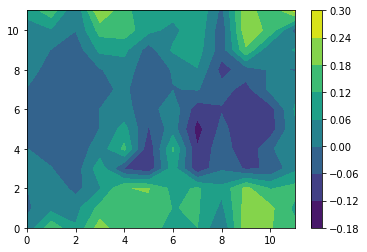

In [ ]:
plt.figure()
cs=plt.contourf(RPSS[6,:,:].T)
plt.colorbar(cs)

In [ ]:
np.shape(model_category)

(3, 20, 12, 12, 30)

In [ ]:
# calculate the reliability diagram 
# aggregate results from models with significant skill scores (>0.4)
# use leave-one-out to calculate the attribute diagram
posi_x,posi_y = np.where(score_map_EOF[6,:,:]>0.4)
score_map_EOF[6,posi_x,posi_y]

scale         = np.arange(0,1,0.1)
pool          = np.zeros((3,10,30))
hit           = np.zeros((3,10,30))

for one_out in range(30):
    leave_out = np.squeeze(np.where(np.arange(30)!=one_out))
    for i in range(np.size(posi_x)):
        for j in range(29):
            #below normal
            posi          = np.max(np.where(model_category[0,6,posi_x[i],posi_y[i],leave_out[j]]>=scale))  
            pool[0,posi,one_out]  = 1 + pool[0,posi,one_out] # how many times the forecast are made 
            if obs_category[0,leave_out[j]] ==1:             # how many times the forecast hit
                hit[0,posi,one_out]  = hit[0,posi,one_out]+1
            
            # near normal
            posi          = np.max(np.where(model_category[1,6,posi_x[i],posi_y[i],leave_out[j]]>=scale))  
            pool[1,posi,one_out]  = 1 + pool[1,posi,one_out]
            if obs_category[1,leave_out[j]] ==1:
                hit[1,posi,one_out]  = hit[1,posi,one_out]+1
                
            # above normal
            posi          = np.max(np.where(model_category[2,6,posi_x[i],posi_y[i],leave_out[j]]>=scale))  
            pool[2,posi,one_out]  = 1 + pool[2,posi,one_out]
            if obs_category[2,leave_out[j]] ==1:
                hit[2,posi,one_out]  = hit[2,posi,one_out]+1


In [ ]:
# calibrating the forecast probability
new_probaiblity = np.zeros((3,10,30))
reg             = np.zeros((3,2,30))

for i in range(30):
    series1            = hit[0,:,i]/pool[0,:,i]
    #series1            = (NINO34_obs[:,2]-np.mean(NINO34_obs[:,2]))/np.std(NINO34_obs[:,2])
    #PPH_monthly    = np.reshape(PPH_monthly,[PPH_monthly.shape[0],PPH_monthly.shape[1]*PPH_monthly.shape[2]]) # reshape 3D array to 2D array for matrix operation
    X_mat              = np.vstack((np.ones(10), series1)).T

    coef_total         = np.linalg.inv(X_mat.T.dot(X_mat)).dot(X_mat.T).dot(scale)
    reg[0,0,i]         = coef_total[1]
    reg[0,1,i]         = coef_total[0]
    new_probaiblity[0,:,i] = series1*reg[0,0,i] +reg[0,1,i] 
    
    
    # near normal
    posi               = np.squeeze(np.where(pool[1,:,i]>0))
    series1            = hit[1,posi,i]/pool[1,posi,i]
    #series1            = (NINO34_obs[:,2]-np.mean(NINO34_obs[:,2]))/np.std(NINO34_obs[:,2])
    #PPH_monthly    = np.reshape(PPH_monthly,[PPH_monthly.shape[0],PPH_monthly.shape[1]*PPH_monthly.shape[2]]) # reshape 3D array to 2D array for matrix operation
    X_mat              = np.vstack((np.ones(np.size(posi)), series1)).T

    coef_total         = np.linalg.inv(X_mat.T.dot(X_mat)).dot(X_mat.T).dot(scale[posi])
    reg[1,0,i]         = coef_total[1]
    reg[1,1,i]         = coef_total[0]
    new_probaiblity[1,:,i]    = scale
    new_probaiblity[1,posi,i] = series1*reg[1,0,i]+reg[1,1,i]
    
    
    # above normal
    series1            = hit[2,:,i]/pool[2,:,i]
    #series1            = (NINO34_obs[:,2]-np.mean(NINO34_obs[:,2]))/np.std(NINO34_obs[:,2])
    #PPH_monthly    = np.reshape(PPH_monthly,[PPH_monthly.shape[0],PPH_monthly.shape[1]*PPH_monthly.shape[2]]) # reshape 3D array to 2D array for matrix operation
    X_mat              = np.vstack((np.ones(10), series1)).T

    coef_total         = np.linalg.inv(X_mat.T.dot(X_mat)).dot(X_mat.T).dot(scale)
    reg[2,0,i]         = coef_total[1]
    reg[2,1,i]         = coef_total[0]
    new_probaiblity[2,:,i] = series1*reg[2,0,i]+reg[2,1,i] 
    
 



Today's date: 2022-06-30


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in true_divide
  del sys.path[0]


Text(0.5, 1.0, '(b) After Calibration')

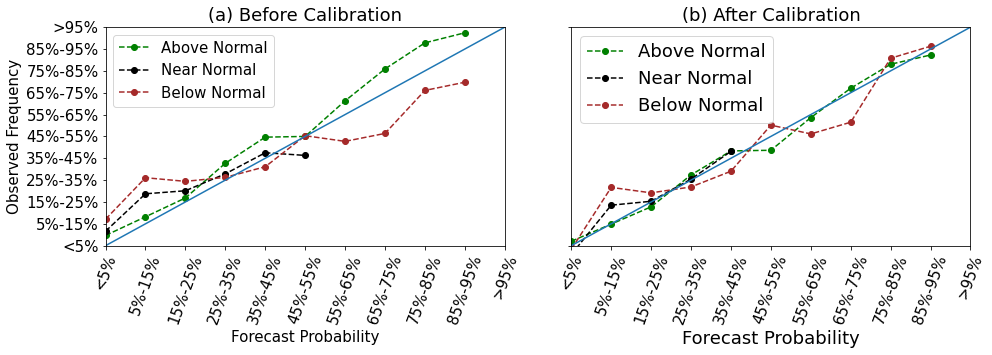

In [ ]:
from datetime import date
today = date.today()
print("Today's date:", today)

grid   = plt.GridSpec(4, 4, wspace=0.4, hspace=0.4)

fig=plt.figure()
plt.subplot(grid[0:3, 0:2])
x=['<5%','5%-15%','15%-25%','25%-35%','35%-45%','45%-55%','55%-65%','65%-75%','75%-85%','85%-95%','>95%']
x2=np.arange(0,11,1)
#plt.bar(x2,observed_frequency/sum_bin, align='center', alpha=0.5)
plt.plot(scale*10,(hit[2,:,:]/pool[2,:,:]).mean(axis=1),color='green',linestyle='--',marker='o')
plt.plot(scale*10,(hit[1,:,:]/pool[1,:,:]).mean(axis=1),color='black',linestyle='--',marker='o')
plt.plot(scale*10,(hit[0,:,:]/pool[0,:,:]).mean(axis=1),color='brown',linestyle='--',marker='o')
plt.legend(['Above Normal','Near Normal','Below Normal'],fontsize=15)
plt.ylabel('Observed Frequency',fontsize=15)
plt.xlabel('Forecast Probability',fontsize=15)
plt.xticks(x2, x,fontsize=15)
plt.yticks(x2/10, x,fontsize=15)
plt.xticks(rotation=70)
plt.xlim(0,10)
plt.ylim(0,1)
x2=np.arange(0,1.1,0.1)
plt.plot(x2*10,x2)
plt.title('(a) Before Calibration',fontsize=18)


plt.subplot(grid[0:3, 2:4])
x2=np.arange(0,11,1)
#plt.bar(x2,observed_frequency/sum_bin, align='center', alpha=0.5)
plt.plot(scale*10,new_probaiblity[2,:,:].mean(axis=1),color='green',linestyle='--',marker='o')
plt.plot(scale[0:5]*10,new_probaiblity[1,0:5,:].mean(axis=1),color='black',linestyle='--',marker='o')
plt.plot(scale*10,new_probaiblity[0,:,:].mean(axis=1),color='brown',linestyle='--',marker='o')
plt.legend(['Above Normal','Near Normal','Below Normal'],fontsize=18)
#plt.plot(x2,observed_frequency[:,1]/sum_bin[:,1]-0.15,color='brown',linestyle='--',marker='o')
#plt.ylabel('Observed Frequency')
plt.xlabel('Forecast Probability',fontsize=18)
plt.xticks(x2, x,fontsize=15)
x=['','','','','','','','','','','']
plt.yticks(x2, x,fontsize=15)
plt.xticks(rotation=70)
plt.xlim(0,10)
plt.ylim(0,1)
x2=np.arange(0,1.1,0.1)
plt.plot(x2*10,x2)
fig.set_size_inches(15.5, 5.5)
plt.title('(b) After Calibration',fontsize=18)


#fig.savefig('/home/Kai-chi.Tseng/2019_research/SPEAR_tornado/attribute_diagram.pdf', dpi=300, bbox_inches='tight')
#fig.savefig('/home/Kai-chi.Tseng/2019_research/SPEAR_tornado/attribute_diagram.png', dpi=300, bbox_inches='tight')

In [ ]:
# use calibrated data to calculate RPSS again


score_map_EOF    = np.zeros((20,12,12))
residual         = np.zeros((20,12,12))
lower_percentile = np.percentile(tornado_day_CONUS_monthly,33)
upper_percentile = np.percentile(tornado_day_CONUS_monthly,66)
obs_category     = np.zeros((3,30))
clim_category    = np.ones((3,30))*1/3
obs_category[0,:][tornado_day_CONUS_monthly<lower_percentile] = 1
obs_category[2,:][tornado_day_CONUS_monthly>upper_percentile] = 1
obs_category[1,:][(tornado_day_CONUS_monthly<=upper_percentile) & (tornado_day_CONUS_monthly>=lower_percentile)] = 1
model_category   = np.zeros((3,20,12,12,30))

RPSS2            = np.zeros((20,12,12))


for mode in range(20):
    for init_month in range(12):
        for month in range(12):
            posi = np.where(Y_val_LM_sst_EOF[mode,init_month-1,month-1,:]==0)
            Y_val_LM_sst_EOF[mode,init_month-1,month-1,posi] = np.mean(tornado_day_CONUS_monthly)
            std_range                                        = np.std(Y_val_LM_sst_EOF[mode,init_month-1,month-1,:]-tornado_day_CONUS_monthly) 
            for day in range(30):
                s = np.random.normal(Y_val_LM_sst_EOF[mode,init_month-1,month-1,day], std_range, 1000)
                model_category[2,mode,init_month-1,month-1,day] = (np.size(np.where(s>upper_percentile))/1000) *reg[2,0,day]+reg[2,1,day] 
                model_category[0,mode,init_month-1,month-1,day] = (np.size(np.where(s<lower_percentile))/1000) *reg[0,0,day]+reg[0,1,day] 
                model_category[1,mode,init_month-1,month-1,day] = (1-model_category[2,mode,init_month-1,month-1,day]-model_category[0,mode,init_month-1,month-1,day])*reg[1,0,day]+reg[1,1,day] 
            RPS      = sum(sum((model_category[:,mode,init_month-1,month-1,:]-obs_category)**2))
            RPS_clim = sum(sum((clim_category-obs_category)**2))
            RPSS2[mode,init_month-1,month-1] = 1-RPS/RPS_clim
            score_map_EOF[mode,init_month-1,month-1]         = np.corrcoef(Y_val_LM_sst_EOF[mode,init_month-1,month-1,:],tornado_day_CONUS_monthly[:])[0][1]
            
            

NameError: ignored

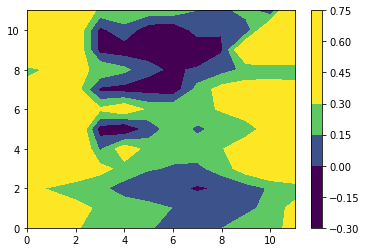

<Figure size 432x288 with 0 Axes>

In [ ]:
plt.figure()
cs=plt.contourf(score_map_EOF[7,:,:],vmin=0,vmax=0.3)
plt.colorbar(cs)

plt.figure()
cs=plt.contourf(score_map_EOF_region[7,:,:,6],vmin=0,vmax=0.3)
plt.colorbar(cs)



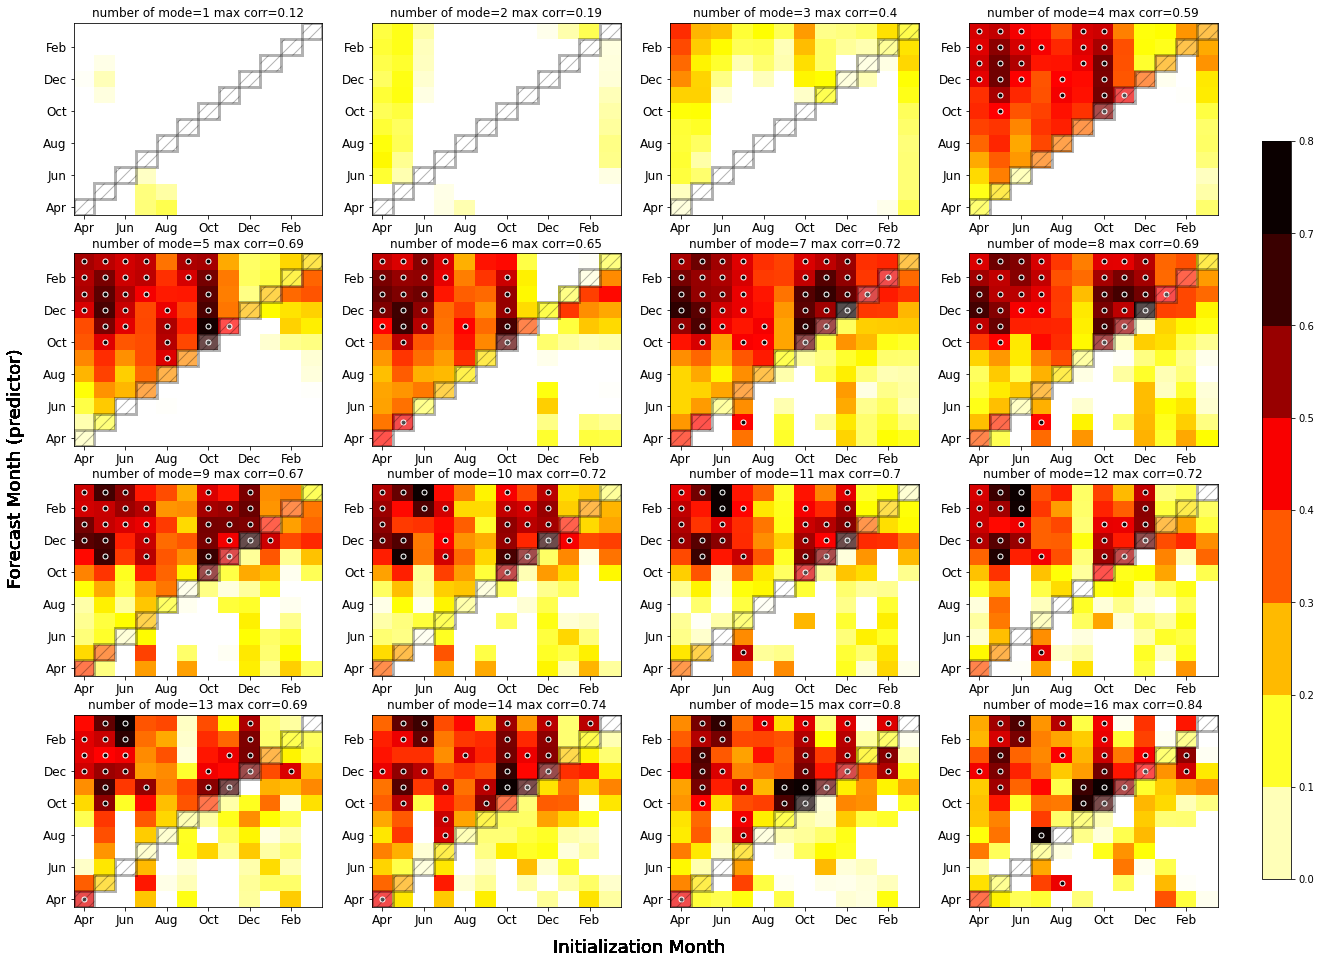

In [ ]:
my_map = 'hot_r'


fig=plt.figure()
for mode in range(16):
    plt.subplot(5,4,mode+1)
    score_map2            = np.zeros((14,14))
    score_map2[1:-1,1:-1] = score_map_EOF[mode,:,:]
    score_map2[0,1:-1]    = score_map_EOF[mode,:,:][-1,:]
    score_map2[-1,1:-1]   = score_map_EOF[mode,:,:][0,:]
    score_map2[:,0]       = score_map2[:,-2]
    score_map2[:,-1]      = score_map2[:,1]
    
    
    template   = np.concatenate((score_map2[1:13,1:13], score_map2[1:13,1:13], score_map2[1:13,1:13]), axis=0)
    template   = np.concatenate((template,template,template),axis=1)
    score_map3 = template[3:15,3:15]
    
    plt.title('number of mode='+str(mode+1)+' max corr='+str(round(np.max(score_map_EOF[mode,:,:]),2)))
    x_ticks= np.arange(0,12)
    plt.xticks(x_ticks,x_ticks+1)
    plt.yticks(x_ticks,x_ticks+1)
    
    cs  = plt.pcolor(np.transpose(score_map3),cmap=my_map,vmin=0,vmax=0.7)
    #plt.colorbar(cs)
    
   
    plt.xticks(np.arange(0.5,17,2),('Apr','Jun','Aug','Oct', \
                                    'Dec','Feb','Apr','Jun','Aug'),fontsize=12)
    plt.yticks(np.arange(0.5,17,2),('Apr','Jun','Aug','Oct',\
                                    'Dec','Feb','Apr','Jun','Aug'),fontsize=12)
    
    for j in range(0,14):
        x1 = [j,j+1,j+1,j]
        y1 = [(j)-1+1,(j)-1+1,(j)-1+2,(j)-1+2]
        plt.fill(x1,y1 , facecolor="white",edgecolor='k',hatch='//',alpha=0.3,linewidth=3)
    #if mode>8:
    #    plt.xlabel('Forecast Month (predictor)')
    #plt.ylabel('Initialization Month ')
    posi_x,posi_y = np.where(score_map3>0.44)
    plt.scatter(posi_x+0.5,posi_y+0.5,25,'w')
    plt.scatter(posi_x+0.5,posi_y+0.5,8,'k')
    plt.ylim(0,12)
    plt.xlim(0,12)
    fig.text(0.45, 0.25, 'Initialization Month ',fontsize=18)
    fig.text(0.08, 0.5, 'Forecast Month (predictor)', rotation='vertical',fontsize=18)
fig.set_size_inches(20.5, 15.5)
cbar_ax = fig.add_axes([0.93, 0.3, 0.02, 0.5])   
cbar = fig.colorbar(cs, cax=cbar_ax, orientation='vertical',boundaries=np.arange(0,0.9,0.1), ticks=np.arange(0,0.9,0.1))
fig.set_size_inches(20.5, 20.5)


#fig.savefig('/home/Kai-chi.Tseng/2019_research/SPEAR_tornado/FIGS2.pdf', dpi=300, bbox_inches='tight')
#fig.savefig('/home/Kai-chi.Tseng/2019_research/SPEAR_tornado/FIGS2.png', dpi=300, bbox_inches='tight')

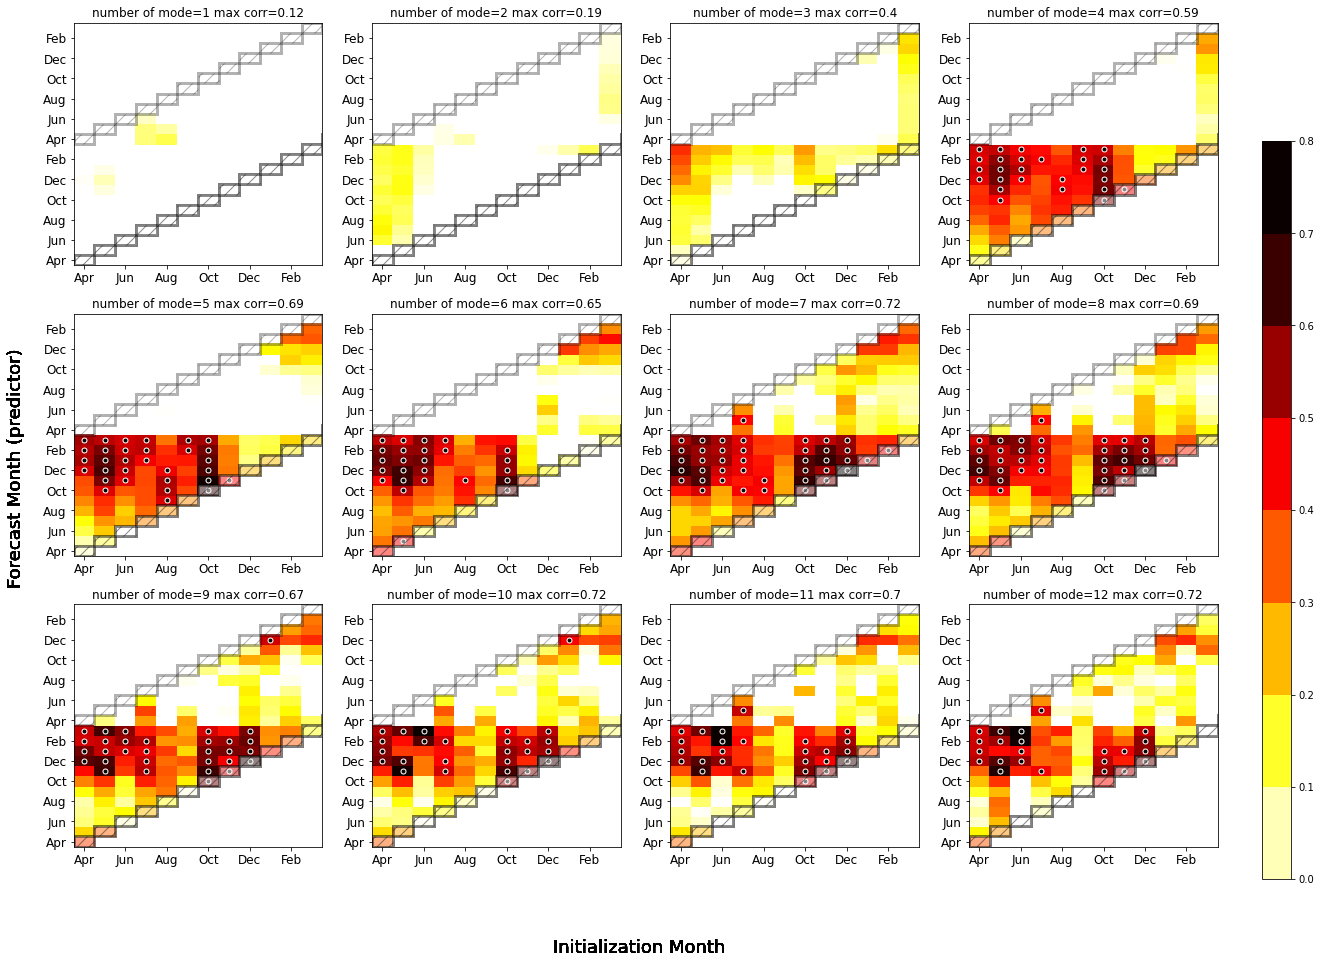

In [ ]:
# calculate the skill scores with new form
my_map = 'hot_r'


fig=plt.figure()
for mode in range(12):
    plt.subplot(4,4,mode+1)
    score_map2            = np.zeros((14,14))
    score_map2[1:-1,1:-1] = score_map_EOF[mode,:,:]
    score_map2[0,1:-1]    = score_map_EOF[mode,:,:][-1,:]
    score_map2[-1,1:-1]   = score_map_EOF[mode,:,:][0,:]
    score_map2[:,0]       = score_map2[:,-2]
    score_map2[:,-1]      = score_map2[:,1]
    
    
    template   = np.concatenate((score_map2[1:13,1:13], score_map2[1:13,1:13], score_map2[1:13,1:13]), axis=0)
    template   = np.concatenate((template,template,template),axis=1)
    score_map3 = template[3:15,3:15]


    score_map3_concatenate = np.concatenate((score_map3,score_map3,score_map3),axis=0)
    score_map3_concatenate = np.concatenate((score_map3_concatenate,score_map3_concatenate,score_map3_concatenate),axis=1)
    score_map3_concatenate = score_map3_concatenate.T[0:24,12:24]

    for i in range(12):
        for j in range(24):
            if ((j-i)>11 and (j>i)):
              score_map3_concatenate[j,i]=np.nan
            elif ((i-j)<12 and (i>j)):
              score_map3_concatenate[j,i]=np.nan

    plt.title('number of mode='+str(mode+1)+' max corr='+str(round(np.max(score_map_EOF[mode,:,:]),2)))
    x_ticks= np.arange(0,12)
    plt.xticks(x_ticks,x_ticks+1)
    plt.yticks(x_ticks,x_ticks+1)
    
    cs  = plt.pcolor(score_map3_concatenate,cmap=my_map,vmin=0,vmax=0.7)
    #plt.colorbar(cs)
    plt.xticks(np.arange(0.5,17,2),('Apr','Jun','Aug','Oct', \
                                    'Dec','Feb','Apr','Jun','Aug'),fontsize=12)
    plt.yticks(np.arange(0.5,24,2), ('Apr','Jun','Aug','Oct',\
                        'Dec','Feb','Apr','Jun','Aug','Oct','Dec','Feb'),fontsize=12)

   
    for j in range(0,14):
        x1 = [j,j+1,j+1,j]
        y1 = [(j)-1+1,(j)-1+1,(j)-1+2,(j)-1+2]
        plt.fill(x1,y1 , facecolor="white",edgecolor='k',hatch='//',alpha=0.3,linewidth=3)

    for j in range(0,14):
        x1 = [j,j+1,j+1,j]
        y1 = [(j)-1+1,(j)-1+1,(j)-1+2,(j)-1+2]
        plt.fill(x1,y1 , facecolor="white",edgecolor='k',hatch='//',alpha=0.3,linewidth=3)
        x1 = [j,j+1,j+1,j]
        y1 = [(j)-1+1+12,(j)-1+1+12,(j)-1+2+12,(j)-1+2+12]
        plt.fill(x1,y1 , facecolor="white",edgecolor='k',hatch='//',alpha=0.3,linewidth=3)
    #if mode>8:
    #    plt.xlabel('Forecast Month (predictor)')
    #plt.ylabel('Initialization Month ')
    posi_x,posi_y = np.where(score_map3_concatenate.T>0.44)
    plt.scatter(posi_x+0.5,posi_y+0.5,25,'w')
    plt.scatter(posi_x+0.5,posi_y+0.5,8,'k')
    plt.ylim(0,24)
    plt.xlim(0,12)
    fig.text(0.45, 0.25, 'Initialization Month ',fontsize=18)
    fig.text(0.08, 0.5, 'Forecast Month (predictor)', rotation='vertical',fontsize=18)
fig.set_size_inches(20.5, 15.5)
cbar_ax = fig.add_axes([0.93, 0.3, 0.02, 0.5])   
cbar = fig.colorbar(cs, cax=cbar_ax, orientation='vertical',boundaries=np.arange(0,0.9,0.1), ticks=np.arange(0,0.9,0.1))
fig.set_size_inches(20.5, 20.5)


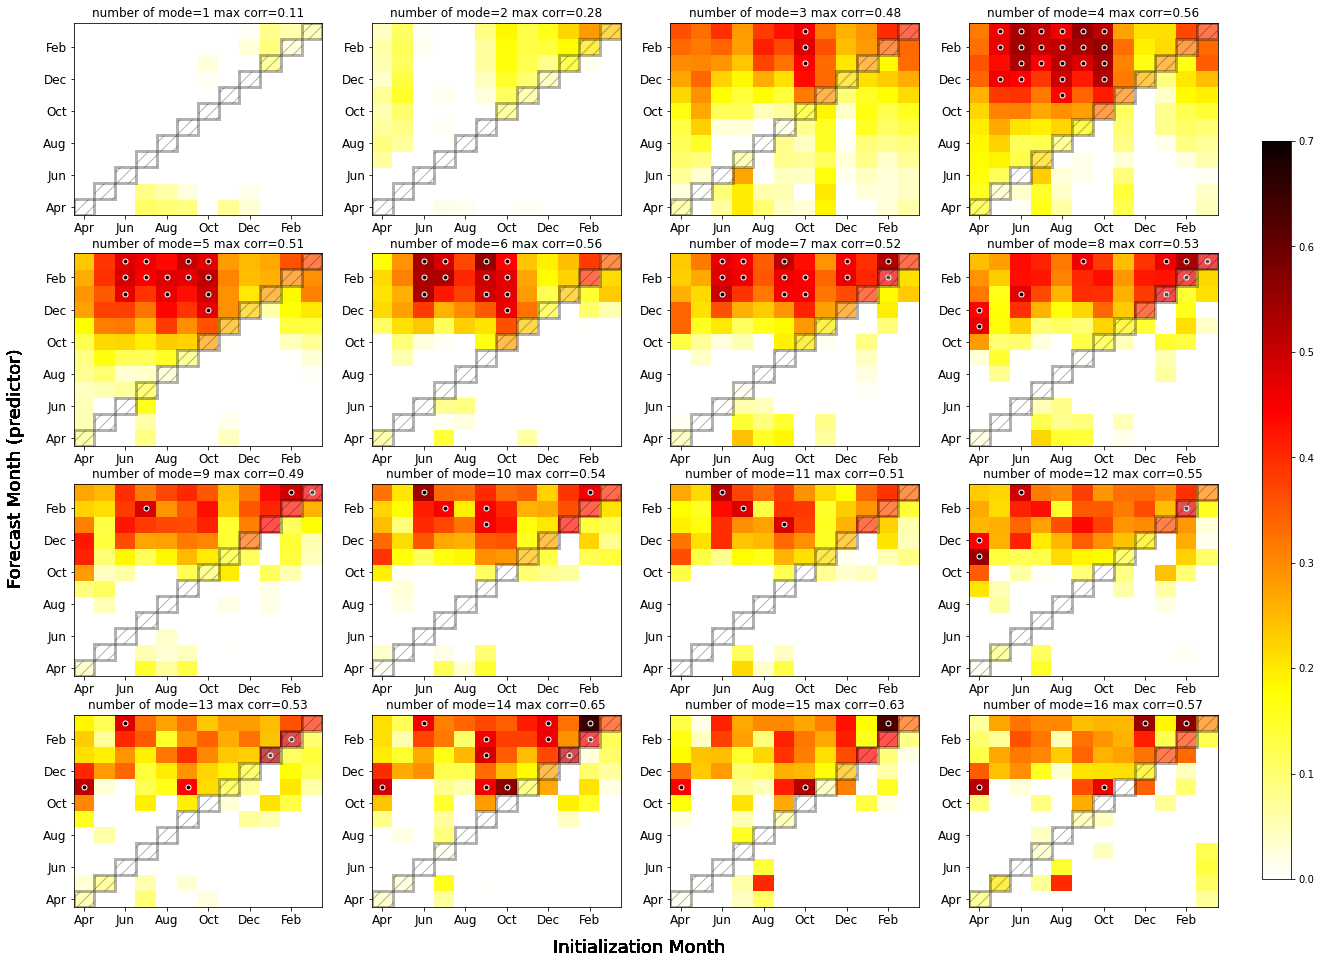

In [ ]:
# score by regions 
# tag
# 1= Northwest
# 2= West 
# 3= Northern_Rockies
# 4= Southwest
# 5= South
# 6= Midwest
# 7= Ohio Valley
# 8= Southeast
# 9= Northeast
my_map = 'hot_r'
region = 7





fig=plt.figure()
for mode in range(16):
    plt.subplot(5,4,mode+1)
    score_map2            = np.zeros((14,14))
    score_map2[1:-1,1:-1] = score_map_EOF_region[mode,:,:,region]
    score_map2[0,1:-1]    = score_map_EOF_region[mode,:,:,region][-1,:]
    score_map2[-1,1:-1]   = score_map_EOF_region[mode,:,:,region][0,:]
    score_map2[:,0]       = score_map2[:,-2]
    score_map2[:,-1]      = score_map2[:,1]
    
    
    template   = np.concatenate((score_map2[1:13,1:13], score_map2[1:13,1:13], score_map2[1:13,1:13]), axis=0)
    template   = np.concatenate((template,template,template),axis=1)
    score_map3 = template[3:15,3:15]
    
    plt.title('number of mode='+str(mode+1)+' max corr='+str(round(np.max(score_map_EOF_region[mode,:,:,region]),2)))
    x_ticks= np.arange(0,12)
    plt.xticks(x_ticks,x_ticks+1)
    plt.yticks(x_ticks,x_ticks+1)
    
    cs  = plt.pcolor(np.transpose(score_map3),cmap=my_map,vmin=0,vmax=0.7)
    #plt.colorbar(cs)
    
   
    plt.xticks(np.arange(0.5,17,2),('Apr','Jun','Aug','Oct', \
                                    'Dec','Feb','Apr','Jun','Aug'),fontsize=12)
    plt.yticks(np.arange(0.5,17,2),('Apr','Jun','Aug','Oct',\
                                    'Dec','Feb','Apr','Jun','Aug'),fontsize=12)
    
    for j in range(0,14):
        x1 = [j,j+1,j+1,j]
        y1 = [(j)-1+1,(j)-1+1,(j)-1+2,(j)-1+2]
        plt.fill(x1,y1 , facecolor="white",edgecolor='k',hatch='//',alpha=0.3,linewidth=3)
    #if mode>8:
    #    plt.xlabel('Forecast Month (predictor)')
    #plt.ylabel('Initialization Month ')
    posi_x,posi_y = np.where(score_map3>0.44)
    plt.scatter(posi_x+0.5,posi_y+0.5,25,'w')
    plt.scatter(posi_x+0.5,posi_y+0.5,8,'k')
    plt.ylim(0,12)
    plt.xlim(0,12)
    fig.text(0.45, 0.25, 'Initialization Month ',fontsize=18)
    fig.text(0.08, 0.5, 'Forecast Month (predictor)', rotation='vertical',fontsize=18)
fig.set_size_inches(20.5, 15.5)
cbar_ax = fig.add_axes([0.93, 0.3, 0.02, 0.5])   
cbar = fig.colorbar(cs, cax=cbar_ax, orientation='vertical')
fig.set_size_inches(20.5, 20.5)


#fig.savefig('/home/Kai-chi.Tseng/2019_research/SPEAR_tornado/FIGS2_Southeast.pdf', dpi=300, bbox_inches='tight')
#fig.savefig('/home/Kai-chi.Tseng/2019_research/SPEAR_tornado/FIGS2_Southeast.png', dpi=300, bbox_inches='tight')

In [ ]:
posix,posiy= np.where(score_map_EOF_region[7,:,:,6]==np.max(score_map_EOF_region[7,:,:,6]))
print(posiy)

NameError: ignored

In [ ]:
np.max(score_map_EOF_region[7,10,0,6])
plt.contourf(np.transpose(score_map_EOF_region[7,:,:,6]))

NameError: ignored

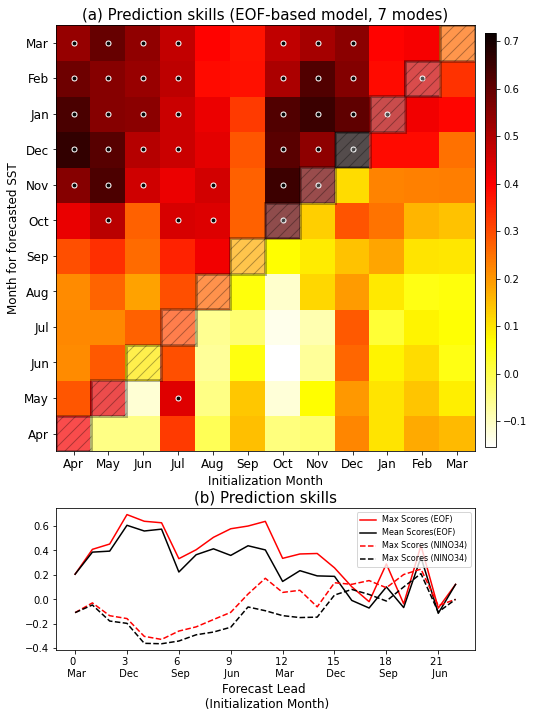

In [ ]:
max_score_EOF   = np.zeros((20,23))
mean_score_EOF  = np.zeros((20,23))
std_score_EOF   = np.zeros((20,23))
init_month      = np.zeros((23,))

for mode in range(20):
    for lead in range(23):
        score_map2            = np.zeros((14,14))
        score_map2[1:-1,1:-1] = score_map_EOF[mode,:,:]
        score_map2[0,1:-1]    = (score_map_EOF[mode,:,:])[-1,:]
        score_map2[-1,1:-1]   = (score_map_EOF[mode,:,:])[0,:]
        score_map2[:,0]       = score_map2[:,-2]
        score_map2[:,-1]      = score_map2[:,1]
        
        
        posi_x,posi_y              = np.where(lead_time_label==lead)
        #print(np.shape(lead_time_label))
        max_score_EOF[mode,lead]   = np.max(score_map2[posi_x,posi_y])
        mean_score_EOF[mode,lead]  = np.mean(score_map2[posi_x,posi_y])
        std_score_EOF[mode,lead]   = np.std(score_map2[posi_x,posi_y])
        init_month[lead,]          = posi_x[0]

posi = np.where(init_month==0)
init_month[posi] = init_month[posi]+12 
mode                  = 6
score_map2            = np.zeros((14,14))
score_map2[1:-1,1:-1] = score_map_EOF[mode,:,:]
score_map2[0,1:-1]    = score_map_EOF[mode,:,:][-1,:]
score_map2[-1,1:-1]   = score_map_EOF[mode,:,:][0,:]
score_map2[:,0]       = score_map2[:,-2]
score_map2[:,-1]      = score_map2[:,1]
        
template   = np.concatenate((score_map2[1:13,1:13], score_map2[1:13,1:13], score_map2[1:13,1:13]), axis=0)
template   = np.concatenate((template,template,template),axis=1)
score_map3 = template[3:15,3:15]    
    
fig, axs = plt.subplots(2, 1, gridspec_kw={'height_ratios': [3, 1]})
cs1      = axs[0].pcolor(np.transpose(score_map3),cmap=my_map)
axs[0].set_xticks(np.arange(0.5,17,1), minor=False)
axs[0].set_xticklabels(('Apr','May','Jun','Jul','Aug','Sep','Oct', 'Nov',\
                        'Dec','Jan','Feb','Mar','Apr','May','Jun', 'Jul','Aug'), fontdict=None, minor=False,fontsize=12)
axs[0].set_yticks(np.arange(0.5,17,1), minor=False)
axs[0].set_yticklabels(('Apr','May','Jun','Jul','Aug','Sep','Oct', 'Nov',\
                        'Dec','Jan','Feb','Mar','Apr','May','Jun', 'Jul','Aug'), minor=False,fontsize=12)

for j in range(0,14):
    x1 = [j,j+1,j+1,j]
    y1 = [(j)-1+1,(j)-1+1,(j)-1+2,(j)-1+2]
    axs[0].fill(x1,y1 , facecolor="white",edgecolor='k',hatch='//',alpha=0.3,linewidth=3)
axs[0].set_xlabel('Initialization Month',fontsize=12)
axs[0].set_ylabel('Month for forecast SST',fontsize=12)
axs[0].set_title('(a) Prediction skills (EOF-based model, 7 modes)',fontsize=15) 
posi_x,posi_y = np.where(score_map3>0.44)
axs[0].scatter(posi_x+0.5,posi_y+0.5,25,'w')
axs[0].scatter(posi_x+0.5,posi_y+0.5,8,'k')
axs[0].set_xlim([0,12])
axs[0].set_ylim([0,12])

axs[1].set_title('(b) Prediction skills',fontsize=15)
axs[1].plot(max_score_EOF[7,:],'r', label='Max Scores (EOF)')
axs[1].plot(mean_score_EOF[7,:],'k', label='Mean Scores(EOF)')
axs[1].plot(max_score,'r--',label='Max Scores (NINO34)')
axs[1].plot(mean_score,'k--',label='Max Scores (NINO34)')
axs[1].legend(fontsize=8)
axs[1].set_xticks(np.arange(0,23,3), minor=False)
#axs[1].set_xticklabels(['0 \n Mar', '1 \n Feb', '2 \n Jan', '3 \n Dec', '4 \n Nov',  '5 \n Oct',\
#                              '6 \n Sep', '7 \n Aug', '8 \n Jul', '9 \n Jun', '10 \n May', '11 \n Apr',\
#                              '12 \n Mar', '13 \n Feb', '14 \n Jan', '15 \n Dec', '16 \n Nov', '17 \n Oct',\
#                              '18 \n Sep', '19 \n Aug', '20 \n Jul', '21 \n Jun', '22 \n May'], fontdict=None, minor=False,fontsize=10)

axs[1].set_xticklabels(['0 \n Mar',  '3 \n Dec', \
                              '6 \n Sep',  '9 \n Jun',\
                              '12 \n Mar',  '15 \n Dec',\
                              '18 \n Sep',  '21 \n Jun',], fontdict=None, minor=False,fontsize=10)
axs[1].set_xlabel('Forecast Lead \n (Initialization Month)',fontsize=12)
fig.set_size_inches(7.5, 11.5)
cbar_ax = fig.add_axes([0.92, 0.37, 0.02,0.5])   
cbar    = fig.colorbar(cs1, cax=cbar_ax, orientation='vertical')

#fig.savefig('/home/Kai-chi.Tseng/2019_research/SPEAR_tornado/FIG4.pdf', dpi=300, bbox_inches='tight')
#fig.savefig('/home/Kai-chi.Tseng/2019_research/SPEAR_tornado/FIG4.png', dpi=300, bbox_inches='tight')


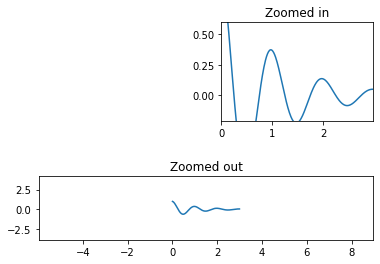

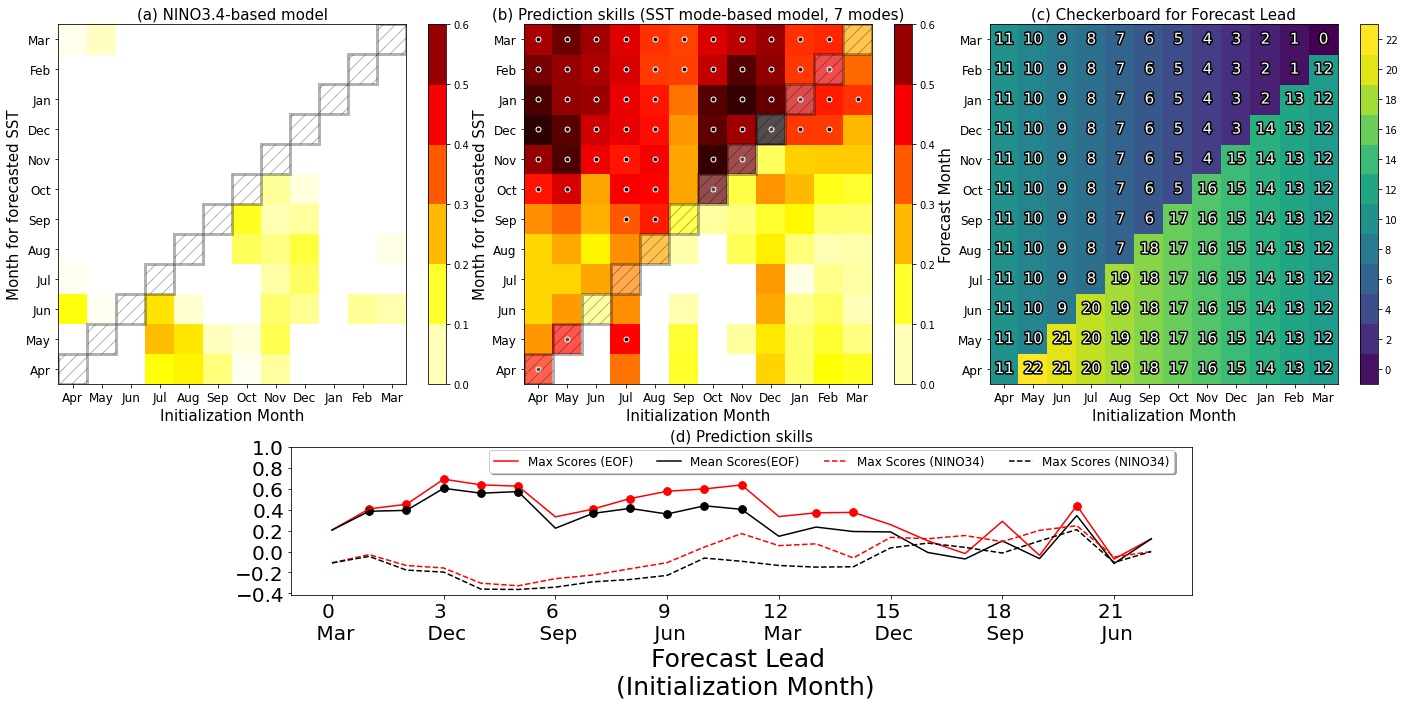

In [ ]:
# combine checkerboard, ENSO-based model and SST-based model 
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon


def f(t):
    return np.exp(-t) * np.cos(2*np.pi*t)


t1 = np.arange(0.0, 3.0, 0.01)

ax1 = plt.subplot(3,1,2)
ax1.margins(0.05)           # Default margin is 0.05, value 0 means fit
ax1.plot(t1, f(t1))

ax2 = plt.subplot(3,1,3)
ax2.margins(2, 2)           # Values >0.0 zoom out
ax2.plot(t1, f(t1))
ax2.set_title('Zoomed out')

ax3 = plt.subplot(2,2,2)
ax3.margins(x=0, y=-0.25)   # Values in (-0.5, 0.0) zooms in to center
ax3.plot(t1, f(t1))
ax3.set_title('Zoomed in')

plt.show()



grid   = plt.GridSpec(6, 6, wspace=0.15, hspace=1.5)

fig=plt.figure()
plt.subplot(grid[0:4, 0:2])
cs=plt.pcolor(np.transpose(score_map3_NINO),cmap=my_map,vmin=0,vmax=0.7)
cbar = plt.colorbar(cs,boundaries=np.arange(0,0.7,0.1), ticks=np.arange(0,0.7,0.1))
plt.xticks(np.arange(0.5,17,1),('Apr','May','Jun','Jul','Aug','Sep','Oct', 'Nov',\
                        'Dec','Jan','Feb','Mar','Apr','May','Jun', 'Jul','Aug'),fontsize=12)
plt.yticks(np.arange(0.5,17,1),('Apr','May','Jun','Jul','Aug','Sep','Oct', 'Nov',\
                        'Dec','Jan','Feb','Mar','Apr','May','Jun', 'Jul','Aug'),fontsize=12)
plt.xlim([0,12])
plt.ylim([0,12])
for j in range(0,14):
    x1 = [j,j+1,j+1,j]
    y1 = [(j)-1+1,(j)-1+1,(j)-1+2,(j)-1+2]
    plt.fill(x1,y1 , facecolor="white",edgecolor='k',hatch='//',alpha=0.3,linewidth=3)
plt.xlabel('Initialization Month',fontsize=15)
plt.ylabel('Month for forecast SST',fontsize=15)
plt.title('(a) NINO3.4-based model',fontsize=15)


plt.subplot(grid[0:4,2:4])
cs=plt.pcolor(np.transpose(score_map3),cmap=my_map,vmin=0,vmax=0.7)
cbar = plt.colorbar(cs,boundaries=np.arange(0,0.7,0.1), ticks=np.arange(0,0.7,0.1))
plt.xticks(np.arange(0.5,17,1),('Apr','May','Jun','Jul','Aug','Sep','Oct', 'Nov',\
                        'Dec','Jan','Feb','Mar','Apr','May','Jun', 'Jul','Aug'),fontsize=12)
plt.yticks(np.arange(0.5,17,1),('Apr','May','Jun','Jul','Aug','Sep','Oct', 'Nov',\
                        'Dec','Jan','Feb','Mar','Apr','May','Jun', 'Jul','Aug'),fontsize=12)
plt.xlim([0,12])
plt.ylim([0,12])
for j in range(0,14):
    x1 = [j,j+1,j+1,j]
    y1 = [(j)-1+1,(j)-1+1,(j)-1+2,(j)-1+2]
    plt.fill(x1,y1 , facecolor="white",edgecolor='k',hatch='//',alpha=0.3,linewidth=3)
plt.xlabel('Initialization Month',fontsize=15)
plt.ylabel('Month for forecasted SST',fontsize=15)
plt.title('(b) Prediction skills (SST mode-based model, 7 modes)',fontsize=15) 
posi_x,posi_y = np.where(score_map3>0.349)
plt.scatter(posi_x+0.5,posi_y+0.5,25,'w')
plt.scatter(posi_x+0.5,posi_y+0.5,8,'k')
plt.xlim([0,12])
plt.ylim([0,12])


plt.subplot(grid[0:4,4:6])
cs   = plt.pcolor(np.transpose(lead_time_label2))
cbar = plt.colorbar(cs,boundaries=np.arange(0,25,2), ticks=np.arange(1,26,2))
cbar.ax.set_yticklabels(['0','2','4','6','8','10','12','14','16','18','20','22'])
plt.xticks(np.arange(0.5,17,1),('Apr','May','Jun','Jul','Aug','Sep','Oct', 'Nov',\
                                'Dec','Jan','Feb','Mar','Apr','May','Jun', 'Jul','Aug'),fontsize=12)
plt.yticks(np.arange(0.5,17,1),('Apr','May','Jun','Jul','Aug','Sep','Oct', 'Nov',\
                                'Dec','Jan','Feb','Mar','Apr','May','Jun', 'Jul','Aug'),fontsize=12)

for i in range(12):
    for j in range(12):
        #plt.text(i+0.25, j+0.25, str(int(lead_time_label[i,j])), fontsize=12)
        text = plt.text(i+0.5, j+0.5, str(int(lead_time_label2[i,j])), color='white',\
                          ha='center', va='center', size=15)
        text.set_path_effects([path_effects.Stroke(linewidth=3, foreground='black'),
                       path_effects.Normal()])

        
plt.ylim(0,12)
plt.xlim(0,12)
plt.xlabel('Initialization Month',fontsize=15)
plt.ylabel('Forecast Month',fontsize=15)
plt.title('(c) Checkerboard for Forecast Lead',fontsize=15)


ax2 = plt.subplot(grid[4:6,1:5])
plt.title('(d) Prediction skills',fontsize=15)
plt.plot(max_score_EOF[7,:],'r', label='Max Scores (EOF)')
posi = np.squeeze(np.where(max_score_EOF[7,:]>0.349))
x    = np.arange(0,30)
plt.scatter(x[posi,],max_score_EOF[7,posi], s=60, c='r', marker='o')

plt.plot(mean_score_EOF[7,:],'k', label='Mean Scores(EOF)')
posi = np.squeeze(np.where(mean_score_EOF[7,:]>0.349))
plt.scatter(x[posi,],mean_score_EOF[7,posi], s=60, c='k', marker='o')
plt.plot(max_score,'r--',label='Max Scores (NINO34)')
plt.plot(mean_score,'k--',label='Max Scores (NINO34)')
plt.legend(fontsize=20,loc='upper right')
plt.yticks(np.arange(-0.4,1.2,0.2),fontsize=20)
plt.xticks(np.arange(0,23,3), ['0 \n Mar',  '3 \n Dec', \
                              '6 \n Sep',  '9 \n Jun',\
                              '12 \n Mar',  '15 \n Dec',\
                              '18 \n Sep',  '21 \n Jun',],fontsize=20)

plt.xlabel('Forecast Lead \n (Initialization Month)',fontsize=25)
ax2.legend(loc='upper center', bbox_to_anchor=(0.6, 1.02),
           fancybox=True, shadow=True, ncol=5,fontsize=12)

fig.set_size_inches(24.5, 10.5)
#fig.savefig('/home/Kai-chi.Tseng/2019_research/SPEAR_tornado/FIG2.pdf', dpi=300, bbox_inches='tight')
#fig.savefig('/home/Kai-chi.Tseng/2019_research/SPEAR_tornado/FIG2.png', dpi=300, bbox_inches='tight')

In [ ]:
# replot the checker board 
lead_time_label_concatenate = np.concatenate((lead_time_label2,lead_time_label2,lead_time_label2),axis=0)
lead_time_label_concatenate = np.concatenate((lead_time_label_concatenate,lead_time_label_concatenate,lead_time_label_concatenate),axis=1)
lead_time_label_concatenate = lead_time_label_concatenate.T[0:24,12:24]

for i in range(12):
    for j in range(24):
        if ((j-i)>11 and (j>i)):
          lead_time_label_concatenate[j,i]=np.nan
        elif ((i-j)<12 and (i>j)):
          lead_time_label_concatenate[j,i]=np.nan

plt.figure()
plt.pcolor(lead_time_label_concatenate)
for i in range(24):
    for j in range(12):
        #plt.text(i+0.25, j+0.25, str(int(lead_time_label[i,j])), fontsize=12)
        if ~np.isnan(lead_time_label_concatenate[i,j]):
          text = plt.text(j+0.5, i+0.5, str(int(lead_time_label_concatenate[i,j])), color='white',\
                          ha='center', va='center', size=10)
          text.set_path_effects([path_effects.Stroke(linewidth=3, foreground='black'),
                       path_effects.Normal()])
          
for mode in range(6,7):
    score_map2            = np.zeros((14,14))
    score_map2[1:-1,1:-1] = score_map_EOF[mode,:,:]
    score_map2[0,1:-1]    = score_map_EOF[mode,:,:][-1,:]
    score_map2[-1,1:-1]   = score_map_EOF[mode,:,:][0,:]
    score_map2[:,0]       = score_map2[:,-2]
    score_map2[:,-1]      = score_map2[:,1]
    
    
    template   = np.concatenate((score_map2[1:13,1:13], score_map2[1:13,1:13], score_map2[1:13,1:13]), axis=0)
    template   = np.concatenate((template,template,template),axis=1)
    score_map3 = template[3:15,3:15]


    score_map3_concatenate = np.concatenate((score_map3,score_map3,score_map3),axis=0)
    score_map3_concatenate = np.concatenate((score_map3_concatenate,score_map3_concatenate,score_map3_concatenate),axis=1)
    score_map3_concatenate = score_map3_concatenate.T[0:24,12:24]

    for i in range(12):
        for j in range(24):
            if ((j-i)>11 and (j>i)):
              score_map3_concatenate[j,i]=np.nan
            elif ((i-j)<12 and (i>j)):
              score_map3_concatenate[j,i]=np.nan


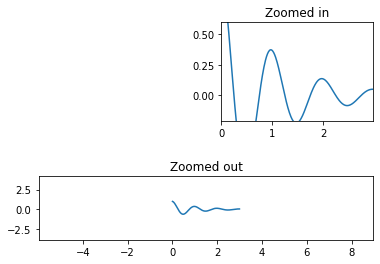

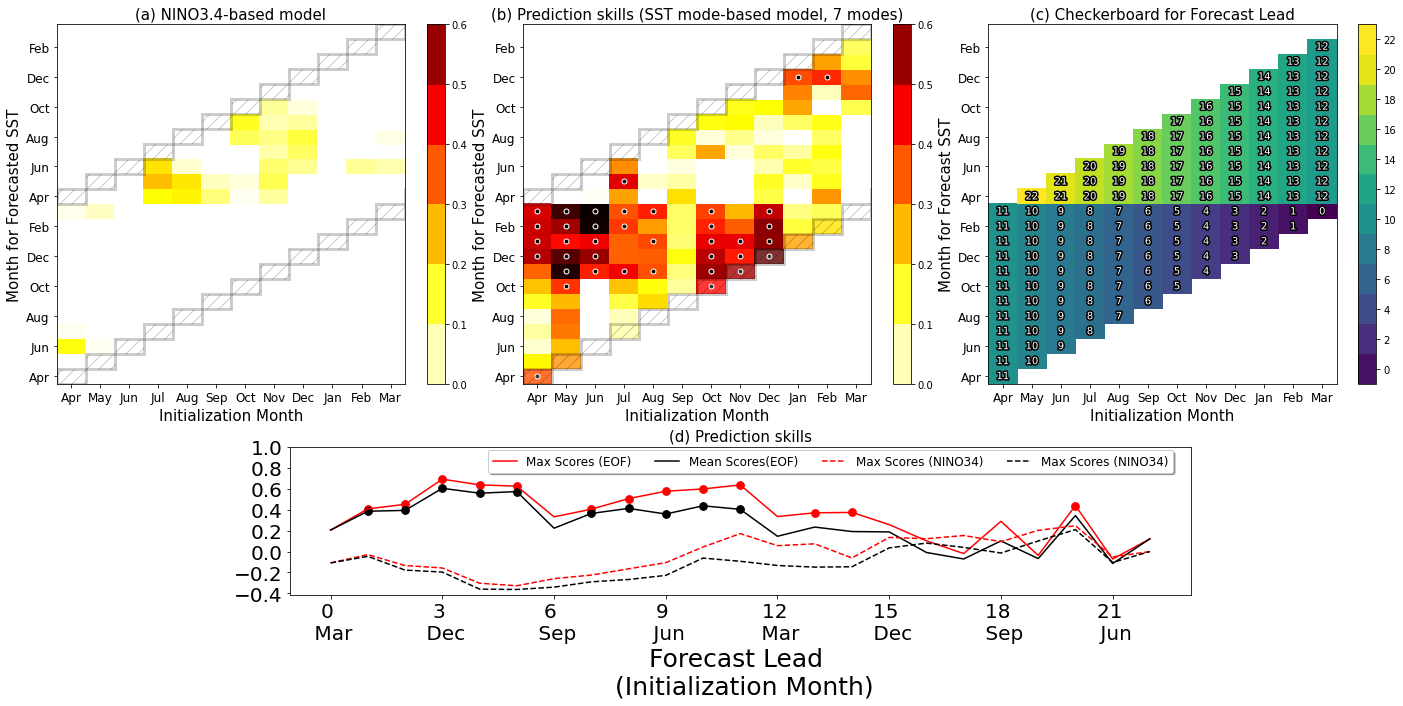

In [ ]:
# combine checkerboard, ENSO-based model and SST-based model 
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon


def f(t):
    return np.exp(-t) * np.cos(2*np.pi*t)


t1 = np.arange(0.0, 3.0, 0.01)

ax1 = plt.subplot(3,1,2)
ax1.margins(0.05)           # Default margin is 0.05, value 0 means fit
ax1.plot(t1, f(t1))

ax2 = plt.subplot(3,1,3)
ax2.margins(2, 2)           # Values >0.0 zoom out
ax2.plot(t1, f(t1))
ax2.set_title('Zoomed out')

ax3 = plt.subplot(2,2,2)
ax3.margins(x=0, y=-0.25)   # Values in (-0.5, 0.0) zooms in to center
ax3.plot(t1, f(t1))
ax3.set_title('Zoomed in')

plt.show()



grid   = plt.GridSpec(6, 6, wspace=0.15, hspace=1.5)

fig=plt.figure()
plt.subplot(grid[0:4, 0:2])
cs=plt.pcolor(score_map3_NINO_concatenate,cmap=my_map,vmin=0,vmax=0.7)
cbar = plt.colorbar(cs,boundaries=np.arange(0,0.7,0.1), ticks=np.arange(0,0.7,0.1))
plt.xticks(np.arange(0.5,17,1),('Apr','May','Jun','Jul','Aug','Sep','Oct', 'Nov',\
                        'Dec','Jan','Feb','Mar','Apr','May','Jun', 'Jul','Aug'),fontsize=12)
plt.yticks(np.arange(0.5,24,2), ('Apr','Jun','Aug','Oct',\
                        'Dec','Feb','Apr','Jun','Aug','Oct','Dec','Feb'),fontsize=12)
plt.xlim([0,12])
plt.ylim([0,24])
for j in range(0,14):
    x1 = [j,j+1,j+1,j]
    y1 = [(j)-1+1,(j)-1+1,(j)-1+2,(j)-1+2]
    plt.fill(x1,y1 , facecolor="white",edgecolor='k',hatch='//',alpha=0.2,linewidth=3)
    x1 = [j,j+1,j+1,j]
    y1 = [(j)-1+1+12,(j)-1+1+12,(j)-1+2+12,(j)-1+2+12]
    plt.fill(x1,y1 , facecolor="white",edgecolor='k',hatch='//',alpha=0.2,linewidth=3)
plt.xlabel('Initialization Month',fontsize=15)
plt.ylabel('Month for Forecasted SST',fontsize=15)
plt.title('(a) NINO3.4-based model',fontsize=15)


plt.subplot(grid[0:4,2:4])
cs=plt.pcolor(score_map3_concatenate,cmap=my_map,vmin=0,vmax=0.7)
cbar = plt.colorbar(cs,boundaries=np.arange(0,0.7,0.1), ticks=np.arange(0,0.7,0.1))
plt.xticks(np.arange(0.5,17,1),('Apr','May','Jun','Jul','Aug','Sep','Oct', 'Nov',\
                        'Dec','Jan','Feb','Mar','Apr','May','Jun', 'Jul','Aug'),fontsize=12)
plt.yticks(np.arange(0.5,24,2), ('Apr','Jun','Aug','Oct',\
                        'Dec','Feb','Apr','Jun','Aug','Oct','Dec','Feb'),fontsize=12)
plt.xlim([0,12])
plt.ylim([0,24])
for j in range(0,14):
    x1 = [j,j+1,j+1,j]
    y1 = [(j)-1+1,(j)-1+1,(j)-1+2,(j)-1+2]
    plt.fill(x1,y1 , facecolor="white",edgecolor='k',hatch='//',alpha=0.2,linewidth=3)
    x1 = [j,j+1,j+1,j]
    y1 = [(j)-1+1+12,(j)-1+1+12,(j)-1+2+12,(j)-1+2+12]
    plt.fill(x1,y1 , facecolor="white",edgecolor='k',hatch='//',alpha=0.2,linewidth=3)
plt.xlabel('Initialization Month',fontsize=15)
plt.ylabel('Month for Forecasted SST',fontsize=15)
plt.title('(b) Prediction skills (SST mode-based model, 7 modes)',fontsize=15) 
posi_x,posi_y = np.where(score_map3_concatenate.T>0.349)
plt.scatter(posi_x+0.5,posi_y+0.5,25,'w')
plt.scatter(posi_x+0.5,posi_y+0.5,8,'k')
plt.xlim([0,12])
plt.ylim([0,24])


plt.subplot(grid[0:4,4:6])
cs   = plt.pcolor(lead_time_label_concatenate)
cbar = plt.colorbar(cs,boundaries=np.arange(0,25,2), ticks=np.arange(1,26,2))
cbar.ax.set_yticklabels(['0','2','4','6','8','10','12','14','16','18','20','22'])
plt.xticks(np.arange(0.5,17,1),('Apr','May','Jun','Jul','Aug','Sep','Oct', 'Nov',\
                                'Dec','Jan','Feb','Mar','Apr','May','Jun', 'Jul','Aug'),fontsize=12)
plt.yticks(np.arange(0.5,24,2), ('Apr','Jun','Aug','Oct',\
                        'Dec','Feb','Apr','Jun','Aug','Oct','Dec','Feb'),fontsize=12)

for i in range(24):
    for j in range(12):
        #plt.text(i+0.25, j+0.25, str(int(lead_time_label[i,j])), fontsize=12)
        if ~np.isnan(lead_time_label_concatenate[i,j]):
          text = plt.text(j+0.5, i+0.5, str(int(lead_time_label_concatenate[i,j])), color='white',\
                          ha='center', va='center', size=10)
          text.set_path_effects([path_effects.Stroke(linewidth=3, foreground='black'),
                       path_effects.Normal()])

        
plt.ylim(0,24)
plt.xlim(0,12)
plt.xlabel('Initialization Month',fontsize=15)
plt.ylabel('Month for Forecast SST',fontsize=15)
plt.title('(c) Checkerboard for Forecast Lead',fontsize=15)


ax2 = plt.subplot(grid[4:6,1:5])
plt.title('(d) Prediction skills',fontsize=15)
plt.plot(max_score_EOF[7,:],'r', label='Max Scores (EOF)')
posi = np.squeeze(np.where(max_score_EOF[7,:]>0.349))
x    = np.arange(0,30)
plt.scatter(x[posi,],max_score_EOF[7,posi], s=60, c='r', marker='o')

plt.plot(mean_score_EOF[7,:],'k', label='Mean Scores(EOF)')
posi = np.squeeze(np.where(mean_score_EOF[7,:]>0.349))
plt.scatter(x[posi,],mean_score_EOF[7,posi], s=60, c='k', marker='o')
plt.plot(max_score,'r--',label='Max Scores (NINO34)')
plt.plot(mean_score,'k--',label='Max Scores (NINO34)')
plt.legend(fontsize=20,loc='upper right')
plt.yticks(np.arange(-0.4,1.2,0.2),fontsize=20)
plt.xticks(np.arange(0,23,3), ['0 \n Mar',  '3 \n Dec', \
                              '6 \n Sep',  '9 \n Jun',\
                              '12 \n Mar',  '15 \n Dec',\
                              '18 \n Sep',  '21 \n Jun',],fontsize=20)

plt.xlabel('Forecast Lead \n (Initialization Month)',fontsize=25)
ax2.legend(loc='upper center', bbox_to_anchor=(0.6, 1.02),
           fancybox=True, shadow=True, ncol=5,fontsize=12)

fig.set_size_inches(24.5, 10.5)

In [ ]:
df = xr.open_dataset('/archive/Kai-chi.Tseng/data/SPEAR_tornado_seasonal/pper_tor_1979_2019.nc') #point to the file on your local system
df

<xarray.Dataset>
Dimensions:        (time: 14975, x: 93, y: 65)
Coordinates:
  * time           (time) datetime64[ns] 1979-01-01T12:00:00 ... 2019-12-31T1...
  * x              (x) float64 0.0 1.0 2.0 3.0 4.0 ... 88.0 89.0 90.0 91.0 92.0
  * y              (y) float64 0.0 1.0 2.0 3.0 4.0 ... 60.0 61.0 62.0 63.0 64.0
Data variables:
    lat            (y, x) float64 ...
    lon            (y, x) float64 ...
    p_perfect_tor  (time, y, x) float64 ...
Attributes:
    title:         Practically Perfect Tor Hindcasts
    sigma:         1.5
    grid:          80-km NCEP 211
    author:        Dr. Victor Gensini
    author_email:  vgensini@niu.edu
    citation:      https://doi.org/10.1175/BAMS-D-19-0321.1

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: The following kwargs were not used by contour: 'clevs'
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: The following kwargs were not used by contour: 'clevs'
  """


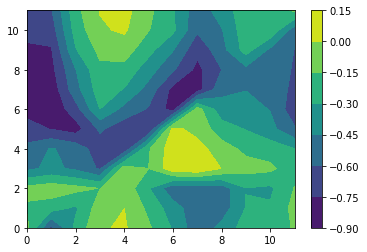

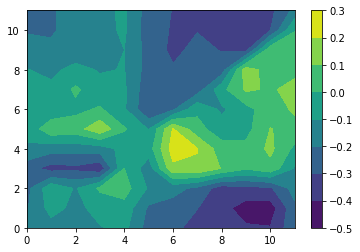

In [ ]:
plt.figure()
cs=plt.contourf(np.transpose(score_map_EOF[0,:,:]),clevs=np.arange(-1,1.1,0.1))
plt.colorbar(cs)
plt.figure()
cs=plt.contourf(np.transpose(score_map[:,:]),clevs=np.arange(-1,1.1,0.1))
plt.colorbar(cs)

In [ ]:
sereis1 = np.reshape(score_map[:,:],[12*12,])
series2 = np.reshape(score_map_EOF[0,:,:],[12*12,])
np.corrcoef(sereis1,series2)

array([[1.        , 0.14833181],
       [0.14833181, 1.        ]])

In [ ]:
# plot ROC, 
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

#import dataset from CSV file on Github
url = "https://raw.githubusercontent.com/Statology/Python-Guides/main/default.csv"
data = pd.read_csv(url)

#define the predictor variables and the response variable
X = data[['student', 'balance', 'income']]
y = data['default']

#split the dataset into training (70%) and testing (30%) sets
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3,random_state=0) 

#instantiate the model
log_regression = LogisticRegression()

#fit the model using the training data
log_regression.fit(X_train,y_train)





LogisticRegression()

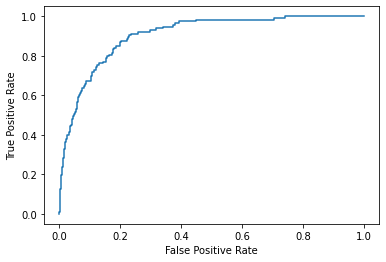

In [ ]:
#define metrics
y_pred_proba = log_regression.predict_proba(X_test)[::,1]
fpr, tpr, _  = metrics.roc_curve(y_test,  y_pred_proba)

#create ROC curve
plt.plot(fpr,tpr)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()



In [ ]:
posi_x,posi_y = np.where(score_map_EOF[6,:,:]>0.4)
score_map_EOF[6,posi_x,posi_y]

model_category[0,6,posi_x,posi_y,:]


array([[ 0.97118745,  1.09592684,  0.8695484 , ...,  0.188152  ,
         0.86399969, -0.0789648 ],
       [ 0.23544548,  0.31575792,  0.67789623, ...,  0.79588978,
         0.22536509,  0.18746468],
       [ 0.8186728 ,  1.0492372 ,  0.90760699, ...,  0.3697123 ,
         0.22402342, -0.0789648 ],
       ...,
       [ 0.18037074,  1.16520825,  0.65614846, ...,  0.47951824,
         0.60774084,  0.10526835],
       [ 0.19166812,  1.09592684,  0.75809111, ...,  0.6295501 ,
         0.43064049,  0.08542786],
       [ 0.12529601,  1.16520825,  0.88449999, ...,  0.46429761,
         0.82509128,  0.08117632]])

In [ ]:
posi_x,posi_y = np.where(score_map_EOF[6,:,:]>0.4)
category = 2
target_category = np.reshape(np.repeat(obs_category[category,:],50),[30,50])
target_category = np.einsum('ij->ji', target_category)
target_category = np.reshape(target_category,[30*50,])
predict_category = np.reshape(model_category[category,6,posi_x,posi_y,:],[30*50,])

#np.reshape(np.repeat(obs_category[0,:],50),[50,30])

In [ ]:
np.shape(model_category)

(3, 20, 12, 12, 30)

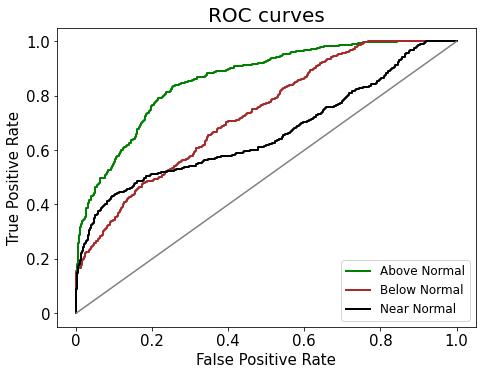

In [ ]:


fig = plt.figure()
category = 2
target_category = np.reshape(np.repeat(obs_category[category,:],50),[30,50])
target_category = np.einsum('ij->ji', target_category)
target_category = np.reshape(target_category,[30*50,])
predict_category = np.reshape(model_category[category,6,posi_x,posi_y,:],[30*50,])
fpr, tpr, _  = metrics.roc_curve(target_category,  predict_category)
#create ROC curve
plt.plot(fpr,tpr,label='Above Normal',linewidth=2,color='Green')

category = 0
target_category = np.reshape(np.repeat(obs_category[category,:],50),[30,50])
target_category = np.einsum('ij->ji', target_category)
target_category = np.reshape(target_category,[30*50,])
predict_category = np.reshape(model_category[category,6,posi_x,posi_y,:],[30*50,])
fpr, tpr, _  = metrics.roc_curve(target_category,  predict_category)
plt.plot(fpr,tpr,label='Below Normal',linewidth=2,color='Brown')

category = 1
target_category = np.reshape(np.repeat(obs_category[category,:],50),[30,50])
target_category = np.einsum('ij->ji', target_category)
target_category = np.reshape(target_category,[30*50,])
predict_category = np.reshape(model_category[category,6,posi_x,posi_y,:],[30*50,])
fpr, tpr, _  = metrics.roc_curve(target_category,  predict_category)
plt.plot(fpr,tpr,label='Near Normal',linewidth=2,color='Black')
plt.plot(np.arange(0,1.1,0.1),np.arange(0,1.1,0.1),'gray')
plt.legend(fontsize=12)
plt.ylabel('True Positive Rate',fontsize=15)
plt.xlabel('False Positive Rate',fontsize=15)
plt.xticks(np.arange(0,1.2,0.2),['0','0.2','0.4','0.6','0.8','1.0'],fontsize=15)
plt.yticks(np.arange(0,1.2,0.2),['0','0.2','0.4','0.6','0.8','1.0'],fontsize=15)
plt.title('ROC curves',fontsize=20)


fig.set_size_inches(7.5, 5.5)


# Figure 6

In [ ]:
#os.system('dmget /archive/Kai-chi.Tseng/data/SPEAR_tornado_seasonal/SPEAR_monthly_data_all_lead_time.npz')
data        = np.load('/content/drive/MyDrive/Colab/2021_research/tornado_data/SPEAR_monthly_data_all_lead_time_update.npz')
z500_SPEAR  = data['z500_SPEAR']
z925_SPEAR  = data['z925_SPEAR']
cape_SPEAR  = data['cape_SPEAR']
WSHR_SPEAR  = data['WSHR_SPEAR']


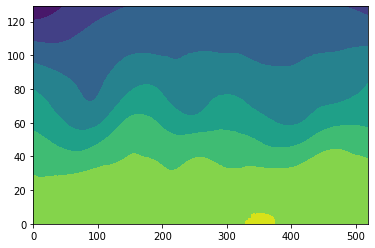

In [ ]:
np.shape(z500_SPEAR)

plt.figure()
plt.contourf(z500_SPEAR[11,0,0,:,:])

In [ ]:
#data        = np.load('/archive/Kai-chi.Tseng/data/SPEAR_tornado_seasonal/SPEAR_monthly_data_all_lead_time(1992_2020).npz')
#data.files
#np.shape(z500_SPEAR)
#!ls /archive/Kai-chi.Tseng/data/SPEAR_tornado_seasonal/*.npz


(12, 29, 15, 130, 520)

In [ ]:
z500_SPEAR_anomaly = np.zeros(np.shape(z500_SPEAR))
z925_SPEAR_anomaly = np.zeros(np.shape(z925_SPEAR))
cape_SPEAR_anomaly = np.zeros(np.shape(cape_SPEAR))
WSHR_SPEAR_anomaly = np.zeros(np.shape(WSHR_SPEAR))

for i in range(12):
    for j in range(30):
        z500_SPEAR_anomaly[i,j,:,:,:] = z500_SPEAR[i,j,:,:,:]-np.mean(np.mean(z500_SPEAR[i,:,:,:,:],axis=0),axis=0)
        z925_SPEAR_anomaly[i,j,:,:,:] = z925_SPEAR[i,j,:,:,:]-np.mean(np.mean(z925_SPEAR[i,:,:,:,:],axis=0),axis=0)
        cape_SPEAR_anomaly[i,j,:,:,:] = cape_SPEAR[i,j,:,:,:]-np.mean(np.mean(cape_SPEAR[i,:,:,:,:],axis=0),axis=0)
        WSHR_SPEAR_anomaly[i,j,:,:,:] = WSHR_SPEAR[i,j,:,:,:]-np.mean(np.mean(WSHR_SPEAR[i,:,:,:,:],axis=0),axis=0)

# calculae weighted variables
lat       = np.arange(15,80,0.5)
lon       = np.arange(100,360,0.5)
xx,yy     = np.meshgrid(lon,lat)
weight    = np.cos(np.power(yy,0.5)/180*np.pi)

template_WSHR = WSHR_SPEAR_anomaly *weight
template_z500 = z500_SPEAR_anomaly *weight
template_cape = cape_SPEAR_anomaly *weight

In [ ]:
del z500_SPEAR, z925_SPEAR, cape_SPEAR, WSHR_SPEAR

In [ ]:
# check the usage of memory 
import sys
def sizeof_fmt(num, suffix='B'):
    ''' by Fred Cirera,  https://stackoverflow.com/a/1094933/1870254, modified'''
    for unit in ['','Ki','Mi','Gi','Ti','Pi','Ei','Zi']:
        if abs(num) < 1024.0:
            return "%3.1f %s%s" % (num, unit, suffix)
        num /= 1024.0
    return "%.1f %s%s" % (num, 'Yi', suffix)

for name, size in sorted(((name, sys.getsizeof(value)) for name, value in locals().items()),
                         key= lambda x: -x[1])[:10]:
    print("{:>30}: {:>8}".format(name, sizeof_fmt(size)))

                     sst_model:  6.7 GiB
            z500_SPEAR_anomaly:  2.7 GiB
            z925_SPEAR_anomaly:  2.7 GiB
            cape_SPEAR_anomaly:  2.7 GiB
            WSHR_SPEAR_anomaly:  2.7 GiB
                 template_WSHR:  2.7 GiB
                 template_z500:  2.7 GiB
                 template_cape:  2.7 GiB
                           EOF: 31.6 MiB
                  sst_EOF_maps: 31.6 MiB


In [ ]:
template_WSHR = np.reshape(template_WSHR,[12*30*15,np.size(lat)*np.size(lon)])
template_z500 = np.reshape(template_z500,[12*30*15,np.size(lat)*np.size(lon)])
template_cape = np.reshape(template_cape,[12*30*15,np.size(lat)*np.size(lon)])

WSHR_SPEAR_anomaly = np.reshape(WSHR_SPEAR_anomaly,[12*30*15,np.size(lat)*np.size(lon)])
z500_SPEAR_anomaly = np.reshape(z500_SPEAR_anomaly,[12*30*15,np.size(lat)*np.size(lon)])
cape_SPEAR_anomaly = np.reshape(cape_SPEAR_anomaly,[12*30*15,np.size(lat)*np.size(lon)])
z925_SPEAR_anomaly = np.reshape(z925_SPEAR_anomaly,[12*30*15,np.size(lat)*np.size(lon)])

#################################  
# use vertical wind shear as predictor
var          = template_WSHR
var_original = WSHR_SPEAR_anomaly
var_original = np.reshape(var_original,[12*30*15,np.size(lat)*np.size(lon)])


modes         = 20
from sklearn.decomposition import PCA
pca           = PCA(n_components=modes)
pca.fit(var)

# get the time series
#pc dimension = season, variables, number of modes, time*ensemble 
pcs           = np.zeros((4,modes,var.shape[0]))
std           = np.zeros((modes,))
EOF_obs       = np.zeros((3,modes,var.shape[1]))

for i in range(modes):
    pcs[0,i,:]     = np.dot(var , pca.components_[i,:])
    std[i,]        = np.std(pcs[0,i,:])
    pcs[0,i,:]     = pcs[0,i,:]/std[i,]
    
# reconstruct maps
for i in range(np.shape(var)[1]):
    regr.fit(np.transpose(pcs[0,0:20,:]), var_original[:,i])
    EOF_obs[0,:,i] = regr.coef_

    
#################################    
# use Z500 as predictor    
var          = template_z500
var_original = z500_SPEAR_anomaly
var_original = np.reshape(var_original,[12*30*15,np.size(lat)*np.size(lon)])
 
modes         = 20
from sklearn.decomposition import PCA
pca           = PCA(n_components=modes)
pca.fit(var)


for i in range(modes):
    pcs[1,i,:]     = np.dot(var , pca.components_[i,:])
    std[i,]        = np.std(pcs[1,i,:])
    pcs[1,i,:]     = pcs[1,i,:]/std[i,]
    
# reconstruct maps
for i in range(np.shape(var)[1]):
    regr.fit(np.transpose(pcs[1,0:20,:]), var_original[:,i])
    EOF_obs[1,:,i] = regr.coef_    
    
    
    
#################################    
# use CAPE as predictor    
var          = template_cape
var_original = cape_SPEAR_anomaly
var_original = np.reshape(var_original,[12*30*15,np.size(lat)*np.size(lon)])
 
modes         = 20
from sklearn.decomposition import PCA
pca           = PCA(n_components=modes)
pca.fit(var)


for i in range(modes):
    pcs[2,i,:]     = np.dot(var , pca.components_[i,:])
    std[i,]        = np.std(pcs[2,i,:])
    pcs[2,i,:]     = pcs[2,i,:]/std[i,]
    
# reconstruct maps
for i in range(np.shape(var)[1]):
    regr.fit(np.transpose(pcs[2,0:20,:]), var_original[:,i])
    EOF_obs[2,:,i] = regr.coef_      
    
    
    
#################################    
# use combined EOF as predictor    


var          = np.concatenate((template_WSHR,template_z500,template_cape), axis=1)
var_original = np.concatenate((WSHR_SPEAR_anomaly,z500_SPEAR_anomaly,cape_SPEAR_anomaly), axis=1)


 
modes         = 20
from sklearn.decomposition import PCA
pca           = PCA(n_components=modes)
pca.fit(var)

EOF_obs_combine    = np.zeros((modes,var.shape[1]))
for i in range(modes):
    pcs[3,i,:]     = np.dot(var , pca.components_[i,:])
    std[i,]        = np.std(pcs[3,i,:])
    pcs[3,i,:]     = pcs[3,i,:]/std[i,]
    
# reconstruct maps
for i in range(np.shape(var)[1]):
    regr.fit(np.transpose(pcs[3,0:20,:]), var_original[:,i])
    EOF_obs_combine[:,i] = regr.coef_      
    
    
# reconstruct z925 EOF pattern
#var_original       = np.concatenate(( templage3_z925_original, templage6_z925_original,templage9_z925_original), axis=0) 
var_original       = z925_SPEAR_anomaly
z925_regression    = np.zeros((20,np.size(lat)*np.size(lon)))
for i in range(np.shape(var_original)[1]):
    regr.fit(np.transpose(pcs[3,0:20,:]), var_original[:,i])
    z925_regression[:,i] = regr.coef_    
    

In [ ]:
np.savez('/content/drive/MyDrive/Colab/2021_research/tornado_data/ats_EOF.npz',\
          pcs = pcs,\
          z925_regression = z925_regression,\
          EOF_obs_combine = EOF_obs_combine,\
        )

In [ ]:
# don't run it (will take very long time to complete)
ivtu_model_ens = np.zeros((12,58,15,360,576))
ivtv_model_ens = np.zeros((12,58,15,360,576))

ivtu_model_ens_Mar = np.zeros((12,29,15,360,576))
ivtv_model_ens_Mar = np.zeros((12,29,15,360,576))

ivtu_model_ens_Apr = np.zeros((12,29,15,360,576))
ivtv_model_ens_Apr = np.zeros((12,29,15,360,576))

ivtu_model_ens_May = np.zeros((12,29,15,360,576))
ivtv_model_ens_May = np.zeros((12,29,15,360,576))

os.system("dmget /archive/Kai-chi.Tseng/data/SPEAR_Med/OTA_IceAtmRes_L33/IVT/IVT?_??_ens??.nc")

count = 0
for init_time in ['01','02','03','04','05','06','07','08','09','10','11','12']:
    for ens in range(1,16,1):
        print('working on init_time='+init_time+" ens="+str(ens))
        dates_1M      = pd.date_range("1992-"+init_time+"-01", periods=348, freq="1M")
        posi          = np.squeeze(np.where(((dates_1M.month==3) )|((dates_1M.month==4))))
        nc    = NetCDFFile("/archive/Kai-chi.Tseng/data/SPEAR_Med/OTA_IceAtmRes_L33/IVT/IVTu_"+init_time+"_ens%02d_monthly.nc" % (ens,))
        data  = nc.variables['ivtu'][posi,:,:]
        ivtu_model_ens[count,:,ens-1,:,:] = data[:,:,:]
        nc    = NetCDFFile("/archive/Kai-chi.Tseng/data/SPEAR_Med/OTA_IceAtmRes_L33/IVT/IVTv_"+init_time+"_ens%02d_monthly.nc" % (ens,))
        data  = nc.variables['ivtv'][posi,:,:]
        ivtv_model_ens[count,:,ens-1,:,:] = data[:,:]
        
        #-------Mar data----------
        posi          = np.squeeze(np.where(((dates_1M.month==3) )))
        nc    = NetCDFFile("/archive/Kai-chi.Tseng/data/SPEAR_Med/OTA_IceAtmRes_L33/IVT/IVTu_"+init_time+"_ens%02d_monthly.nc" % (ens,))
        data  = nc.variables['ivtu'][posi,:,:]
        ivtu_model_ens_Mar[count,:,ens-1,:,:] = data[:,:,:]
        nc    = NetCDFFile("/archive/Kai-chi.Tseng/data/SPEAR_Med/OTA_IceAtmRes_L33/IVT/IVTv_"+init_time+"_ens%02d_monthly.nc" % (ens,))
        data  = nc.variables['ivtv'][posi,:,:]
        ivtv_model_ens_Mar[count,:,ens-1,:,:] = data[:,:]
        
        #-------Apr data----------
        posi          = np.squeeze(np.where(((dates_1M.month==4) )))
        nc    = NetCDFFile("/archive/Kai-chi.Tseng/data/SPEAR_Med/OTA_IceAtmRes_L33/IVT/IVTu_"+init_time+"_ens%02d_monthly.nc" % (ens,))
        data  = nc.variables['ivtu'][posi,:,:]
        ivtu_model_ens_Apr[count,:,ens-1,:,:] = data[:,:,:]
        nc    = NetCDFFile("/archive/Kai-chi.Tseng/data/SPEAR_Med/OTA_IceAtmRes_L33/IVT/IVTv_"+init_time+"_ens%02d_monthly.nc" % (ens,))
        data  = nc.variables['ivtv'][posi,:,:]
        ivtv_model_ens_Apr[count,:,ens-1,:,:] = data[:,:]
        
        
        #-------Apr data----------
        posi          = np.squeeze(np.where(((dates_1M.month==5) )))
        nc    = NetCDFFile("/archive/Kai-chi.Tseng/data/SPEAR_Med/OTA_IceAtmRes_L33/IVT/IVTu_"+init_time+"_ens%02d_monthly.nc" % (ens,))
        data  = nc.variables['ivtu'][posi,:,:]
        ivtu_model_ens_May[count,:,ens-1,:,:] = data[:,:,:]
        nc    = NetCDFFile("/archive/Kai-chi.Tseng/data/SPEAR_Med/OTA_IceAtmRes_L33/IVT/IVTv_"+init_time+"_ens%02d_monthly.nc" % (ens,))
        data  = nc.variables['ivtv'][posi,:,:]
        ivtv_model_ens_May[count,:,ens-1,:,:] = data[:,:]
        
        
    #AR_model[count,:,:,:]=AR_model_ens[:,count,:,:,:].mean(axis=0)
    count=count+1

ivtu_model_new = np.zeros((12,29,15,360,576))
ivtv_model_new = np.zeros((12,29,15,360,576))

for i in range(29):
    ivtu_model_new[:,i,:,:,:] = ivtu_model_ens[:,2*i:2*i+2,:,:,:].mean(axis=1)
    ivtv_model_new[:,i,:,:,:] = ivtv_model_ens[:,2*i:2*i+2,:,:,:].mean(axis=1)
    
    

ivtu_model_ens = ivtu_model_new
ivtv_model_ens = ivtv_model_new


#np.savez('/archive/Kai-chi.Tseng/data/SPEAR_tornado_seasonal/SPEAR_monthly_data_ivt.npz',\
#          ivtu_model_ens = ivtu_model_ens,\
#          ivtv_model_ens = ivtv_model_ens,\
#        )

np.savez('/archive/Kai-chi.Tseng/data/SPEAR_tornado_seasonal/SPEAR_monthly_data_ivt_Mar.npz',\
          ivtu_model_ens = ivtu_model_ens_Mar,\
          ivtv_model_ens = ivtv_model_ens_Mar,\
        )

np.savez('/archive/Kai-chi.Tseng/data/SPEAR_tornado_seasonal/SPEAR_monthly_data_ivt_Apr.npz',\
          ivtu_model_ens = ivtu_model_ens_Apr,\
          ivtv_model_ens = ivtv_model_ens_Apr,\
        )

np.savez('/archive/Kai-chi.Tseng/data/SPEAR_tornado_seasonal/SPEAR_monthly_data_ivt_May.npz',\
          ivtu_model_ens = ivtu_model_ens_May,\
          ivtv_model_ens = ivtv_model_ens_May,\
        )


working on init_time=01 ens=1
working on init_time=01 ens=2
working on init_time=01 ens=3
working on init_time=01 ens=4
working on init_time=01 ens=5
working on init_time=01 ens=6
working on init_time=01 ens=7
working on init_time=01 ens=8
working on init_time=01 ens=9
working on init_time=01 ens=10
working on init_time=01 ens=11
working on init_time=01 ens=12
working on init_time=01 ens=13
working on init_time=01 ens=14
working on init_time=01 ens=15
working on init_time=02 ens=1
working on init_time=02 ens=2
working on init_time=02 ens=3
working on init_time=02 ens=4
working on init_time=02 ens=5
working on init_time=02 ens=6
working on init_time=02 ens=7
working on init_time=02 ens=8
working on init_time=02 ens=9
working on init_time=02 ens=10
working on init_time=02 ens=11
working on init_time=02 ens=12
working on init_time=02 ens=13
working on init_time=02 ens=14
working on init_time=02 ens=15
working on init_time=03 ens=1
working on init_time=03 ens=2
working on init_time=03 ens=

In [ ]:
#os.system('dmget /archive/Kai-chi.Tseng/data/SPEAR_tornado_seasonal/SPEAR_monthly_data_ivt_Apr.npz')
data        = np.load('/content/drive/MyDrive/Colab/2021_research/tornado_data/SPEAR_monthly_data_ivt_Apr.npz')
ivtu_model_ens_Apr  = data['ivtu_model_ens']
ivtv_model_ens_Apr  = data['ivtv_model_ens']


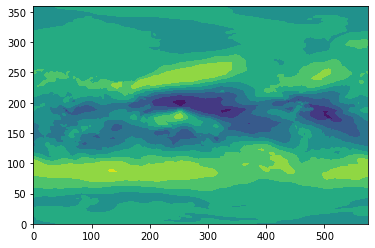

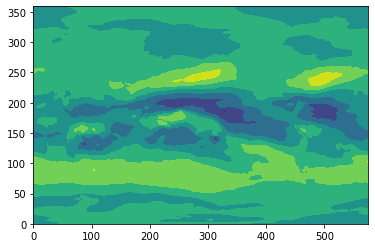

In [ ]:
np.shape(ivtu_model_ens)
ivtu_model_ens     = np.reshape(ivtu_model_ens,[12,29,15,360,576])
plt.figure()
plt.contourf(ivtu_model_ens[0,0,0,:,:])
plt.figure()
plt.contourf(ivtu_model_ens_Mar[0,0,0,:,:])

In [ ]:
#os.system('dmget /archive/Kai-chi.Tseng/data/SPEAR_tornado_seasonal/SPEAR_monthly_data_ivt.npz')
data        = np.load('/content/drive/MyDrive/Colab/2021_research/tornado_data/SPEAR_monthly_data_ivt.npz')
ivtu_model_ens  = data['ivtu_model_ens']
ivtv_model_ens  = data['ivtv_model_ens']


In [ ]:
pcs = np.reshape(pcs,[4,20,12,30,15])
pcs_template = pcs[:,:,:,0:29,:]
pcs_template = np.reshape(pcs_template,[4,20,12*29*15])

IVTu_regression    = np.zeros((20,360,576))
IVTv_regression    = np.zeros((20,360,576))
ivtu_model_ens     = np.reshape(ivtu_model_ens,[12*29*15,360*576])
ivtv_model_ens     = np.reshape(ivtv_model_ens,[12*29*15,360*576])


for mode in range(20):
    series4            = np.squeeze(pcs_template[3,mode,:])
    X_mat              = np.vstack((np.ones(series4.shape[0]), series4[:])).T
    coef_total         = np.linalg.inv(X_mat.T.dot(X_mat)).dot(X_mat.T).dot(ivtu_model_ens[:,:])
    IVTu_regression[mode,:,:]    = np.reshape(coef_total[1,:],[360,576])
    
    series4            = np.squeeze(pcs_template[3,mode,:])
    X_mat              = np.vstack((np.ones(series4.shape[0]), series4[:])).T
    coef_total         = np.linalg.inv(X_mat.T.dot(X_mat)).dot(X_mat.T).dot(ivtv_model_ens[:,:])
    IVTv_regression[mode,:,:]    = np.reshape(coef_total[1,:],[360,576])
    
    
    


(20.0, 80.0)

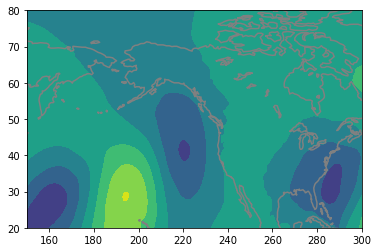

In [ ]:
lat = nc.variables['lat']
lon = nc.variables['lon']
xx2,yy2 = np.meshgrid(lon,lat)
plt.figure()
plt.contourf(xx2,yy2,IVTv_regression[5,:,:])
plt.plot(costal_lon,costal_lat,'gray')
plt.xlim([150,300])
plt.ylim([20,80])

In [ ]:
#np.shape(pcs)
pcs = np.reshape(pcs,[4,20,12,30,15]) # types of variable, atm_modes, initialization, year, ens
#types of variable 0 = WSHR, 1=Z500, 2=CAPE, 3=all  
#np.shape(pcs)

In [ ]:
# developing the regression between sst mode and atmospheric PCs 
data                 = np.load('/archive/Kai-chi.Tseng/data/SPEAR_tornado_seasonal/SST_EOFs_1995_2017_based.npz')
pcs_obs_sst          = data['pcs_obs_sst']
pcs_obs_sst          = np.reshape(pcs_obs_sst,[20,15,12,30,12])
pcs_obs_sst          = np.reshape(pcs_obs_sst.mean(axis=1),[20,12,360])
NINO34               = np.reshape(NINO34,[12,360])
pcs_obs_sst      = np.reshape(pcs_obs_sst,[20,12*360])
for mode in range(20):
    pcs_obs_sst[mode,:] = pcs_obs_sst[mode,:]/np.std(pcs_obs_sst[mode,:])
    
pcs_obs_sst      = np.reshape(pcs_obs_sst,[20,12,360])

correlation_map_ats         = np.zeros((7,12,12,20))                    # modes, initial month, forecast lead, lat, lon 
correlation_map_ats_NINO34  = np.zeros((12,12,20))                    # modes, initial month, forecast lead, lat, lon

count=0
for init_month in range(1,13):
    dates_1M  = pd.date_range('1992-'+str(init_month).zfill(2)+'', periods=360, freq='1M')
    for forecast_lead in range(1,13):
        posi  = np.squeeze(np.where((dates_1M.month==(forecast_lead)) & (dates_1M.year<=2021)))
        print('init year='+str(1992)+' init month='+str(init_month)+' predictor year ='+str(dates_1M[posi[0]].year) +' predictor month='+str(forecast_lead))               
        for atm_mode in range(20):
            
            if (dates_1M[posi[0]].year==1992) and (forecast_lead<=3):
                print('Case 1')
                init_year = 1992
                series1   = pcs[3,atm_mode,2,:,:].mean(axis=1)   #tornado_day_CONUS_monthly[:]
                series2   = pcs_obs_sst[0:7,init_month-1,posi]
                series3   = NINO34[init_month-1,posi]
                #sst_correlation_map[init_month-1,month-1] = np.corrcoef(series1,series2)[0][1]            
            elif (dates_1M[posi[0]].year==1992) and (forecast_lead>3):
                print('Case 2')
                init_year = 1993
                series1   = pcs[3,atm_mode,2,1:,:].mean(axis=1) 
                series2   = pcs_obs_sst[0:7,init_month-1,posi[:-1]]
                series3   = NINO34[init_month-1,posi[:-1]]
                #sst_correlation_map[init_month-1,month-1] = np.corrcoef(series1,series2)[0][1]
            elif (dates_1M[posi[0]].year==1993) and (forecast_lead<=3):
                print('Case 3')
                init_year = 1993
                series1   = pcs[3,atm_mode,2,1:,:].mean(axis=1) 
                series2   = pcs_obs_sst[0:7,init_month-1,posi]
                series3   = NINO34[init_month-1,posi]
                #sst_correlation_map[init_month-1,month-1] = np.corrcoef(series1,series2)[0][1]
            elif (dates_1M[posi[0]].year==1993) and (forecast_lead>3):
                print('Case 4')
                init_year = 1994
                series1   = pcs[3,atm_mode,2,2:,:].mean(axis=1)  
                series2   = pcs_obs_sst[0:7,init_month-1,posi[:-1]]
                series3   = NINO34[init_month-1,posi[:-1]]
                
                
                #series3   = pcs[3,atm_mode,2,2:,:].mean(axis=1)  
                #sst_correlation_map[init_month-1,month-1] = np.corrcoef(series1,series2)[0][1]
        
            
            model_ols =  linear_model.LinearRegression(normalize=True)
            model_ols.fit(np.transpose(series2),series1)
            correlation_map_ats[:,init_month-1,forecast_lead-1,atm_mode] = model_ols.coef_
            
            model_ols =  linear_model.LinearRegression(normalize=True)
            model_ols.fit(np.reshape(series3,[np.size(series3),1]),series1)
            correlation_map_ats_NINO34[init_month-1,forecast_lead-1,atm_mode] = model_ols.coef_
            #correlation_map_ats[:,init_month-1,forecast_lead-1,atm_mode] = model_ols.coef_
            #correlation_map_sst[:,init_month-1,forecast_lead-1,atm_mode] = model_ols.coef_    
    
    count=count+1

init year=1992 init month=1 predictor year =1992 predictor month=1
Case 1
Case 1
Case 1
Case 1
Case 1
Case 1
Case 1
Case 1
Case 1
Case 1
Case 1
Case 1
Case 1
Case 1
Case 1
Case 1
Case 1
Case 1
Case 1
Case 1
init year=1992 init month=1 predictor year =1992 predictor month=2
Case 1
Case 1
Case 1
Case 1
Case 1
Case 1
Case 1
Case 1
Case 1
Case 1
Case 1
Case 1
Case 1
Case 1
Case 1
Case 1
Case 1
Case 1
Case 1
Case 1
init year=1992 init month=1 predictor year =1992 predictor month=3
Case 1
Case 1
Case 1
Case 1
Case 1
Case 1
Case 1
Case 1
Case 1
Case 1
Case 1
Case 1
Case 1
Case 1
Case 1
Case 1
Case 1
Case 1
Case 1
Case 1
init year=1992 init month=1 predictor year =1992 predictor month=4
Case 2
Case 2
Case 2
Case 2
Case 2
Case 2
Case 2
Case 2
Case 2
Case 2
Case 2
Case 2
Case 2
Case 2
Case 2
Case 2
Case 2
Case 2
Case 2
Case 2
init year=1992 init month=1 predictor year =1992 predictor month=5
Case 2
Case 2
Case 2
Case 2
Case 2
Case 2
Case 2
Case 2
Case 2
Case 2
Case 2
Case 2
Case 2
Case 2
Case 2


Case 2
Case 2
Case 2
Case 2
Case 2
Case 2
Case 2
Case 2
Case 2
Case 2
Case 2
Case 2
Case 2
Case 2
init year=1992 init month=4 predictor year =1992 predictor month=7
Case 2
Case 2
Case 2
Case 2
Case 2
Case 2
Case 2
Case 2
Case 2
Case 2
Case 2
Case 2
Case 2
Case 2
Case 2
Case 2
Case 2
Case 2
Case 2
Case 2
init year=1992 init month=4 predictor year =1992 predictor month=8
Case 2
Case 2
Case 2
Case 2
Case 2
Case 2
Case 2
Case 2
Case 2
Case 2
Case 2
Case 2
Case 2
Case 2
Case 2
Case 2
Case 2
Case 2
Case 2
Case 2
init year=1992 init month=4 predictor year =1992 predictor month=9
Case 2
Case 2
Case 2
Case 2
Case 2
Case 2
Case 2
Case 2
Case 2
Case 2
Case 2
Case 2
Case 2
Case 2
Case 2
Case 2
Case 2
Case 2
Case 2
Case 2
init year=1992 init month=4 predictor year =1992 predictor month=10
Case 2
Case 2
Case 2
Case 2
Case 2
Case 2
Case 2
Case 2
Case 2
Case 2
Case 2
Case 2
Case 2
Case 2
Case 2
Case 2
Case 2
Case 2
Case 2
Case 2
init year=1992 init month=4 predictor year =1992 predictor month=11
Case 

Case 2
Case 2
Case 2
Case 2
Case 2
Case 2
Case 2
Case 2
Case 2
Case 2
Case 2
init year=1992 init month=8 predictor year =1993 predictor month=1
Case 3
Case 3
Case 3
Case 3
Case 3
Case 3
Case 3
Case 3
Case 3
Case 3
Case 3
Case 3
Case 3
Case 3
Case 3
Case 3
Case 3
Case 3
Case 3
Case 3
init year=1992 init month=8 predictor year =1993 predictor month=2
Case 3
Case 3
Case 3
Case 3
Case 3
Case 3
Case 3
Case 3
Case 3
Case 3
Case 3
Case 3
Case 3
Case 3
Case 3
Case 3
Case 3
Case 3
Case 3
Case 3
init year=1992 init month=8 predictor year =1993 predictor month=3
Case 3
Case 3
Case 3
Case 3
Case 3
Case 3
Case 3
Case 3
Case 3
Case 3
Case 3
Case 3
Case 3
Case 3
Case 3
Case 3
Case 3
Case 3
Case 3
Case 3
init year=1992 init month=8 predictor year =1993 predictor month=4
Case 4
Case 4
Case 4
Case 4
Case 4
Case 4
Case 4
Case 4
Case 4
Case 4
Case 4
Case 4
Case 4
Case 4
Case 4
Case 4
Case 4
Case 4
Case 4
Case 4
init year=1992 init month=8 predictor year =1993 predictor month=5
Case 4
Case 4
Case 4
Case 4


Case 4
Case 4
Case 4
Case 4
init year=1992 init month=11 predictor year =1993 predictor month=5
Case 4
Case 4
Case 4
Case 4
Case 4
Case 4
Case 4
Case 4
Case 4
Case 4
Case 4
Case 4
Case 4
Case 4
Case 4
Case 4
Case 4
Case 4
Case 4
Case 4
init year=1992 init month=11 predictor year =1993 predictor month=6
Case 4
Case 4
Case 4
Case 4
Case 4
Case 4
Case 4
Case 4
Case 4
Case 4
Case 4
Case 4
Case 4
Case 4
Case 4
Case 4
Case 4
Case 4
Case 4
Case 4
init year=1992 init month=11 predictor year =1993 predictor month=7
Case 4
Case 4
Case 4
Case 4
Case 4
Case 4
Case 4
Case 4
Case 4
Case 4
Case 4
Case 4
Case 4
Case 4
Case 4
Case 4
Case 4
Case 4
Case 4
Case 4
init year=1992 init month=11 predictor year =1993 predictor month=8
Case 4
Case 4
Case 4
Case 4
Case 4
Case 4
Case 4
Case 4
Case 4
Case 4
Case 4
Case 4
Case 4
Case 4
Case 4
Case 4
Case 4
Case 4
Case 4
Case 4
init year=1992 init month=11 predictor year =1993 predictor month=9
Case 4
Case 4
Case 4
Case 4
Case 4
Case 4
Case 4
Case 4
Case 4
Case 4
Ca

In [ ]:
np.shape(pcs)

(4, 20, 12, 30, 15)

In [ ]:
# Mapping atm back to sst
data                 = np.load('/archive/Kai-chi.Tseng/data/SPEAR_tornado_seasonal/SST_EOFs_1995_2017_based.npz')
pcs_obs_sst          = data['pcs_obs_sst']
pcs_obs_sst          = np.reshape(pcs_obs_sst,[20,15,12,30,12])
pcs_obs_sst          = np.reshape(pcs_obs_sst.mean(axis=1),[20,12,360])

pcs_obs_sst      = np.reshape(pcs_obs_sst,[20,12*360])
for mode in range(20):
    pcs_obs_sst[mode,:] = pcs_obs_sst[mode,:]/np.std(pcs_obs_sst[mode,:])
    
pcs_obs_sst      = np.reshape(pcs_obs_sst,[20,12,360])

correlation_map_ats_to_sst    = np.zeros((20,12,12,20))   # sst_modes, initial month, forecast lead, ats_modes 
correlation_map_ats_to_NINO34 = np.zeros((12,12,20))

count=0
for init_month in range(1,13):
    dates_1M  = pd.date_range('1992-'+str(init_month).zfill(2)+'', periods=360, freq='1M')
    for forecast_lead in range(1,13):
        posi  = np.squeeze(np.where((dates_1M.month==(forecast_lead)) & (dates_1M.year<=2021)))
        print('init year='+str(1992)+' init month='+str(init_month)+' predictor year ='+str(dates_1M[posi[0]].year) +' predictor month='+str(forecast_lead))               
        for sst_mode in range(20):
            
            if (dates_1M[posi[0]].year==1992) and (forecast_lead<=3):
                print('Case 1')
                init_year = 1992
                series1   = pcs[3,:,2,:,:].mean(axis=2)   #tornado_day_CONUS_monthly[:]
                series2   = pcs_obs_sst[sst_mode,init_month-1,posi]
                series3   = NINO34[init_month-1,posi]
                #sst_correlation_map[init_month-1,month-1] = np.corrcoef(series1,series2)[0][1]            
            elif (dates_1M[posi[0]].year==1992) and (forecast_lead>3):
                print('Case 2')
                init_year = 1993
                series1   = pcs[3,:,2,1:,:].mean(axis=2) 
                series2   = pcs_obs_sst[sst_mode,init_month-1,posi[:-1]]
                series3   = NINO34[init_month-1,posi[:-1]]
                #sst_correlation_map[init_month-1,month-1] = np.corrcoef(series1,series2)[0][1]
            elif (dates_1M[posi[0]].year==1993) and (forecast_lead<=3):
                print('Case 3')
                init_year = 1993
                series1   = pcs[3,:,2,1:,:].mean(axis=2) 
                series2   = pcs_obs_sst[sst_mode,init_month-1,posi]
                series3   = NINO34[init_month-1,posi]
                #sst_correlation_map[init_month-1,month-1] = np.corrcoef(series1,series2)[0][1]
            elif (dates_1M[posi[0]].year==1993) and (forecast_lead>3):
                print('Case 4')
                init_year = 1994
                series1   = pcs[3,:,2,2:,:].mean(axis=2)  
                series2   = pcs_obs_sst[sst_mode,init_month-1,posi[:-1]]
                series3   = NINO34[init_month-1,posi[:-1]]
                
                
                #series3   = pcs[3,atm_mode,2,2:,:].mean(axis=1)  
                #sst_correlation_map[init_month-1,month-1] = np.corrcoef(series1,series2)[0][1]
        
            
            model_ols =  linear_model.LinearRegression(normalize=True)
            model_ols.fit(np.transpose(series1),(series2))
            correlation_map_ats_to_sst[sst_mode,init_month-1,forecast_lead-1,:] = model_ols.coef_
            
            model_ols =  linear_model.LinearRegression(normalize=True)
            model_ols.fit(np.transpose(series1),(series3))
            correlation_map_ats_to_NINO34[init_month-1,forecast_lead-1,:] = model_ols.coef_


init year=1992 init month=1 predictor year =1992 predictor month=1
Case 1
Case 1
Case 1
Case 1
Case 1
Case 1
Case 1
Case 1
Case 1
Case 1
Case 1
Case 1
Case 1
Case 1
Case 1
Case 1
Case 1
Case 1
Case 1
Case 1
init year=1992 init month=1 predictor year =1992 predictor month=2
Case 1
Case 1
Case 1
Case 1
Case 1
Case 1
Case 1
Case 1
Case 1
Case 1
Case 1
Case 1
Case 1
Case 1
Case 1
Case 1
Case 1
Case 1
Case 1
Case 1
init year=1992 init month=1 predictor year =1992 predictor month=3
Case 1
Case 1
Case 1
Case 1
Case 1
Case 1
Case 1
Case 1
Case 1
Case 1
Case 1
Case 1
Case 1
Case 1
Case 1
Case 1
Case 1
Case 1
Case 1
Case 1
init year=1992 init month=1 predictor year =1992 predictor month=4
Case 2
Case 2
Case 2
Case 2
Case 2
Case 2
Case 2
Case 2
Case 2
Case 2
Case 2
Case 2
Case 2
Case 2
Case 2
Case 2
Case 2
Case 2
Case 2
Case 2
init year=1992 init month=1 predictor year =1992 predictor month=5
Case 2
Case 2
Case 2
Case 2
Case 2
Case 2
Case 2
Case 2
Case 2
Case 2
Case 2
Case 2
Case 2
Case 2
Case 2


Case 2
Case 2
Case 2
Case 2
Case 2
Case 2
init year=1992 init month=4 predictor year =1992 predictor month=10
Case 2
Case 2
Case 2
Case 2
Case 2
Case 2
Case 2
Case 2
Case 2
Case 2
Case 2
Case 2
Case 2
Case 2
Case 2
Case 2
Case 2
Case 2
Case 2
Case 2
init year=1992 init month=4 predictor year =1992 predictor month=11
Case 2
Case 2
Case 2
Case 2
Case 2
Case 2
Case 2
Case 2
Case 2
Case 2
Case 2
Case 2
Case 2
Case 2
Case 2
Case 2
Case 2
Case 2
Case 2
Case 2
init year=1992 init month=4 predictor year =1992 predictor month=12
Case 2
Case 2
Case 2
Case 2
Case 2
Case 2
Case 2
Case 2
Case 2
Case 2
Case 2
Case 2
Case 2
Case 2
Case 2
Case 2
Case 2
Case 2
Case 2
Case 2
init year=1992 init month=5 predictor year =1993 predictor month=1
Case 3
Case 3
Case 3
Case 3
Case 3
Case 3
Case 3
Case 3
Case 3
Case 3
Case 3
Case 3
Case 3
Case 3
Case 3
Case 3
Case 3
Case 3
Case 3
Case 3
init year=1992 init month=5 predictor year =1993 predictor month=2
Case 3
Case 3
Case 3
Case 3
Case 3
Case 3
Case 3
Case 3
Case

Case 4
Case 4
Case 4
Case 4
Case 4
Case 4
Case 4
Case 4
Case 4
Case 4
Case 4
Case 4
Case 4
Case 4
Case 4
Case 4
Case 4
Case 4
init year=1992 init month=8 predictor year =1993 predictor month=7
Case 4
Case 4
Case 4
Case 4
Case 4
Case 4
Case 4
Case 4
Case 4
Case 4
Case 4
Case 4
Case 4
Case 4
Case 4
Case 4
Case 4
Case 4
Case 4
Case 4
init year=1992 init month=8 predictor year =1992 predictor month=8
Case 2
Case 2
Case 2
Case 2
Case 2
Case 2
Case 2
Case 2
Case 2
Case 2
Case 2
Case 2
Case 2
Case 2
Case 2
Case 2
Case 2
Case 2
Case 2
Case 2
init year=1992 init month=8 predictor year =1992 predictor month=9
Case 2
Case 2
Case 2
Case 2
Case 2
Case 2
Case 2
Case 2
Case 2
Case 2
Case 2
Case 2
Case 2
Case 2
Case 2
Case 2
Case 2
Case 2
Case 2
Case 2
init year=1992 init month=8 predictor year =1992 predictor month=10
Case 2
Case 2
Case 2
Case 2
Case 2
Case 2
Case 2
Case 2
Case 2
Case 2
Case 2
Case 2
Case 2
Case 2
Case 2
Case 2
Case 2
Case 2
Case 2
Case 2
init year=1992 init month=8 predictor year =1

Case 3
init year=1992 init month=12 predictor year =1993 predictor month=3
Case 3
Case 3
Case 3
Case 3
Case 3
Case 3
Case 3
Case 3
Case 3
Case 3
Case 3
Case 3
Case 3
Case 3
Case 3
Case 3
Case 3
Case 3
Case 3
Case 3
init year=1992 init month=12 predictor year =1993 predictor month=4
Case 4
Case 4
Case 4
Case 4
Case 4
Case 4
Case 4
Case 4
Case 4
Case 4
Case 4
Case 4
Case 4
Case 4
Case 4
Case 4
Case 4
Case 4
Case 4
Case 4
init year=1992 init month=12 predictor year =1993 predictor month=5
Case 4
Case 4
Case 4
Case 4
Case 4
Case 4
Case 4
Case 4
Case 4
Case 4
Case 4
Case 4
Case 4
Case 4
Case 4
Case 4
Case 4
Case 4
Case 4
Case 4
init year=1992 init month=12 predictor year =1993 predictor month=6
Case 4
Case 4
Case 4
Case 4
Case 4
Case 4
Case 4
Case 4
Case 4
Case 4
Case 4
Case 4
Case 4
Case 4
Case 4
Case 4
Case 4
Case 4
Case 4
Case 4
init year=1992 init month=12 predictor year =1993 predictor month=7
Case 4
Case 4
Case 4
Case 4
Case 4
Case 4
Case 4
Case 4
Case 4
Case 4
Case 4
Case 4
Case 4
Ca

array([[1.        , 0.38816581],
       [0.38816581, 1.        ]])

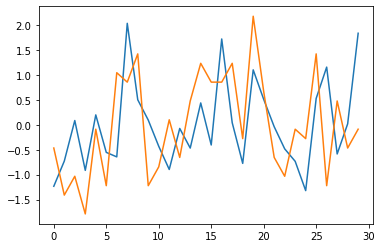

In [ ]:
series1 = (tornado_day_CONUS_monthly-np.mean(tornado_day_CONUS_monthly))/np.std(tornado_day_CONUS_monthly)
plt.plot(pcs[3,0,2,:,:].mean(axis=1))
plt.plot(series1)
np.corrcoef(series1,pcs[3,0,2,:,:].mean(axis=1))
#np.shape(series1)

In [ ]:
np.shape(pcs)

(4, 20, 12, 30, 15)

In [ ]:
#plt.contourf(optimal_pattern[2,11,:,:])
#np.shape(coef_SPEAR_sst)
#correlation_map_ats[sst_mode,init_time,target_time,ats_mode]


#plt.figure()
#plt.contourf(coef_SPEAR_sst[:,:,0,0]-coef_SPEAR_sst[:,:,1,0])

#print(np.shape(coef_SPEAR_sst))
#print(np.shape(correlation_map_ats))


PC_atm = np.zeros((7,12,12,20))
        
# [j,:,:,k] = the influence of jth SST mode on kth atmospheric mode 

for j in range(7): #SST PC
    for k in range(20): # ats PC
        PC_atm[j,:,:,k] = correlation_map_ats[j,:,:,k]*coef_SPEAR_sst[:,:,:,j].mean(axis=2)
        

        

PC_atm = PC_atm.sum(axis=0)      

In [ ]:
np.shape(coef_SPEAR_sst)

(12, 12, 23, 7)

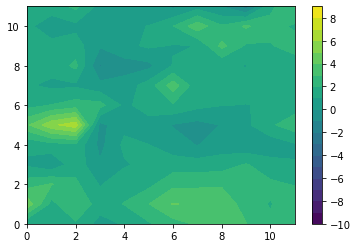

In [ ]:
plt.figure()
cs=plt.contourf(PC_atm[:,:,0],np.arange(-10,10))
plt.colorbar(cs)

In [ ]:
#PC_atm[0,1,0]
#PC_atm[0,0,0]

0.4211585305353899

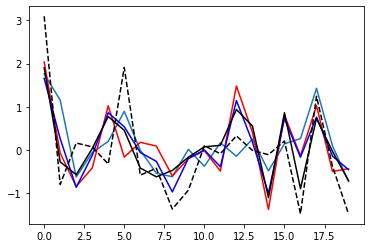

In [ ]:
posi1,posi2 = np.where(score_map_EOF[6,:,:]>0.5)
plt.figure()
plt.plot(PC_atm[4,2,:])
plt.plot(PC_atm[6,1,:],'r')
plt.plot(PC_atm[6,0,:],'b')
plt.plot(PC_atm[11,11,:],'k--')


plt.plot(PC_atm[posi1,posi2,:].mean(axis=0),'k')

(20.0, 70.0)

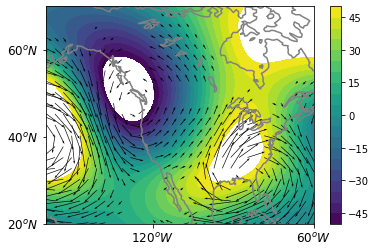

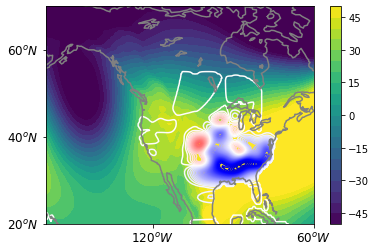

In [ ]:
lat       = np.arange(15,80,0.5)
lon       = np.arange(100,360,0.5)
xx,yy     = np.meshgrid(lon,lat)

lat         = np.arange(15,70,0.5)
lon         = np.arange(150,300,0.5)
xx_PPH,yy_PPH   = np.meshgrid(lon,lat)
composite_z500  = np.zeros((130,520))
composite_ivtu  = np.zeros((360,576))
composite_ivtv  = np.zeros((360,576))
EOF_obs_combine = np.reshape(EOF_obs_combine,[20,3,130,520])

for ats_mode in range(20):
    composite_z500 = PC_atm[11,11,ats_mode]*np.reshape(EOF_obs_combine[ats_mode,1,:,:],[130,520])+composite_z500
    composite_ivtu = PC_atm[11,11,ats_mode]*np.reshape(IVTu_regression[ats_mode,:,:],[360,576])+composite_ivtu
    composite_ivtv = PC_atm[11,11,ats_mode]*np.reshape(IVTv_regression[ats_mode,:,:],[360,576])+composite_ivtv

composite_ivtu[np.abs(composite_ivtu)<5] = np.nan
composite_ivtv[np.abs(composite_ivtv)<5] = np.nan

plt.figure()
cs=plt.contourf(xx,yy,composite_z500,np.arange(-50,55,5))
#plt.contour(xx_PPH,yy_PPH,PPH_NINO34*land_sea_mask,np.arange(-0.009,0.009+0.00015,0.00015),cmap='seismic')
plt.quiver(xx2[::5,::5],yy2[::5,::5],composite_ivtu[::5,::5], composite_ivtv[::5,::5], scale=600)

lat       = np.arange(15,80,0.5)
lon       = np.arange(100,360,0.5)
xx,yy     = np.meshgrid(lon,lat)

plt.colorbar(cs)
plt.plot(costal_lon,costal_lat,'gray')
plt.yticks([-80,-60,-40,-20,0, 20,40,60,80], ['$80^oS$', '$60^oS$', '$40^oS$', '$20^oS$', '$Eq$', '$20^oN$', '$40^oN$', '$60^oN$', '$80^oN$'],fontsize=12)
plt.xticks([0, 60, 120, 180,240,300,360], ['$0^oE$', '$60^oE$','$120^oE$', '$180^oE$', '$120^oW$', '$60^oW$', '$0^oW$'],fontsize=12) 
plt.xlim([200,300])
plt.ylim([20,70])



composite_z925 = np.zeros((130,520))
for ats_mode in range(20):
    composite_z925 = PC_atm[6,2,ats_mode]*np.reshape(z925_regression[ats_mode,:],[130,520])+composite_z925
    
plt.figure()
plt.contourf(xx,yy,composite_z925,np.arange(-20,22,2),extend='both')
plt.colorbar(cs)
plt.contour(xx_PPH,yy_PPH,PPH_NINO34*land_sea_mask,np.arange(-0.009,0.009+0.00015,0.00015),cmap='seismic')
plt.plot(costal_lon,costal_lat,'gray')
plt.yticks([-80,-60,-40,-20,0, 20,40,60,80], ['$80^oS$', '$60^oS$', '$40^oS$', '$20^oS$', '$Eq$', '$20^oN$', '$40^oN$', '$60^oN$', '$80^oN$'],fontsize=12)
plt.xticks([0, 60, 120, 180,240,300,360], ['$0^oE$', '$60^oE$','$120^oE$', '$180^oE$', '$120^oW$', '$60^oW$', '$0^oW$'],fontsize=12) 
plt.xlim([200,300])
plt.ylim([20,70])


In [ ]:
# derive the optimal pattern based on NINO3.4

# developing the regression between NINO3.4 and atmospheric PCs 
data                 = np.load('/archive/Kai-chi.Tseng/data/SPEAR_tornado_seasonal/SST_EOFs_1995_2017_based.npz')
pcs_obs_sst          = data['pcs_obs_sst']
pcs_obs_sst          = np.reshape(pcs_obs_sst,[20,15,12,30,12])
pcs_obs_sst          = np.reshape(pcs_obs_sst.mean(axis=1),[20,12,360])
correlation_map_ats_NINO34  = np.zeros((12,12,20))                    # modes, initial month, forecast lead, lat, lon 

count=0
for init_month in range(1,13):
    dates_1M  = pd.date_range('1992-'+str(init_month).zfill(2)+'', periods=360, freq='1M')
    for forecast_lead in range(1,13):
        posi  = np.squeeze(np.where((dates_1M.month==(forecast_lead)) & (dates_1M.year<=2021)))
        print('init year='+str(1992)+' init month='+str(init_month)+' predictor year ='+str(dates_1M[posi[0]].year) +' predictor month='+str(forecast_lead))               
        for atm_mode in range(20):
            
            if (dates_1M[posi[0]].year==1992) and (forecast_lead<=3):
                print('Case 1')
                init_year = 1992
                series1   = pcs[3,atm_mode,2,:,:].mean(axis=1)   #tornado_day_CONUS_monthly[:]
                series2   = np.reshape(NINO34[init_month-1,posi],[1,np.size(posi)]) 
                #sst_correlation_map[init_month-1,month-1] = np.corrcoef(series1,series2)[0][1]            
            elif (dates_1M[posi[0]].year==1992) and (forecast_lead>3):
                print('Case 2')
                init_year = 1993
                series1   = pcs[3,atm_mode,2,1:,:].mean(axis=1) 
                series2   = np.reshape(NINO34[init_month-1,posi[:-1]],[1,np.size(posi[:-1])]) 
                #sst_correlation_map[init_month-1,month-1] = np.corrcoef(series1,series2)[0][1]
            elif (dates_1M[posi[0]].year==1993) and (forecast_lead<=3):
                print('Case 3')
                init_year = 1993
                series1   = pcs[3,atm_mode,2,1:,:].mean(axis=1) 
                series2   = np.reshape(NINO34[init_month-1,posi],[1,np.size(posi)]) 
                #sst_correlation_map[init_month-1,month-1] = np.corrcoef(series1,series2)[0][1]
            elif (dates_1M[posi[0]].year==1993) and (forecast_lead>3):
                print('Case 4')
                init_year = 1994
                series1   = pcs[3,atm_mode,2,2:,:].mean(axis=1)  
                series2   = np.reshape(NINO34[init_month-1,posi[:-1]],[1,np.size(posi[:-1])])
                #sst_correlation_map[init_month-1,month-1] = np.corrcoef(series1,series2)[0][1]
        
            
            model_ols =  linear_model.LinearRegression(normalize=True)
            model_ols.fit(np.transpose(series2),series1)
            correlation_map_ats_NINO34[init_month-1,forecast_lead-1,atm_mode] = model_ols.coef_
                
    
    count=count+1

init year=1992 init month=1 predictor year =1992 predictor month=1
Case 1
Case 1
Case 1
Case 1
Case 1
Case 1
Case 1
Case 1
Case 1
Case 1
Case 1
Case 1
Case 1
Case 1
Case 1
Case 1
Case 1
Case 1
Case 1
Case 1
init year=1992 init month=1 predictor year =1992 predictor month=2
Case 1
Case 1
Case 1
Case 1
Case 1
Case 1
Case 1
Case 1
Case 1
Case 1
Case 1
Case 1
Case 1
Case 1
Case 1
Case 1
Case 1
Case 1
Case 1
Case 1
init year=1992 init month=1 predictor year =1992 predictor month=3
Case 1
Case 1
Case 1
Case 1
Case 1
Case 1
Case 1
Case 1
Case 1
Case 1
Case 1
Case 1
Case 1
Case 1
Case 1
Case 1
Case 1
Case 1
Case 1
Case 1
init year=1992 init month=1 predictor year =1992 predictor month=4
Case 2
Case 2
Case 2
Case 2
Case 2
Case 2
Case 2
Case 2
Case 2
Case 2
Case 2
Case 2
Case 2
Case 2
Case 2
Case 2
Case 2
Case 2
Case 2
Case 2
init year=1992 init month=1 predictor year =1992 predictor month=5
Case 2
Case 2
Case 2
Case 2
Case 2
Case 2
Case 2
Case 2
Case 2
Case 2
Case 2
Case 2
Case 2
Case 2
Case 2


Case 2
Case 2
Case 2
Case 2
Case 2
Case 2
Case 2
Case 2
Case 2
Case 2
Case 2
Case 2
Case 2
init year=1992 init month=4 predictor year =1992 predictor month=12
Case 2
Case 2
Case 2
Case 2
Case 2
Case 2
Case 2
Case 2
Case 2
Case 2
Case 2
Case 2
Case 2
Case 2
Case 2
Case 2
Case 2
Case 2
Case 2
Case 2
init year=1992 init month=5 predictor year =1993 predictor month=1
Case 3
Case 3
Case 3
Case 3
Case 3
Case 3
Case 3
Case 3
Case 3
Case 3
Case 3
Case 3
Case 3
Case 3
Case 3
Case 3
Case 3
Case 3
Case 3
Case 3
init year=1992 init month=5 predictor year =1993 predictor month=2
Case 3
Case 3
Case 3
Case 3
Case 3
Case 3
Case 3
Case 3
Case 3
Case 3
Case 3
Case 3
Case 3
Case 3
Case 3
Case 3
Case 3
Case 3
Case 3
Case 3
init year=1992 init month=5 predictor year =1993 predictor month=3
Case 3
Case 3
Case 3
Case 3
Case 3
Case 3
Case 3
Case 3
Case 3
Case 3
Case 3
Case 3
Case 3
Case 3
Case 3
Case 3
Case 3
Case 3
Case 3
Case 3
init year=1992 init month=5 predictor year =1993 predictor month=4
Case 4
Case 4

Case 4
init year=1992 init month=8 predictor year =1992 predictor month=8
Case 2
Case 2
Case 2
Case 2
Case 2
Case 2
Case 2
Case 2
Case 2
Case 2
Case 2
Case 2
Case 2
Case 2
Case 2
Case 2
Case 2
Case 2
Case 2
Case 2
init year=1992 init month=8 predictor year =1992 predictor month=9
Case 2
Case 2
Case 2
Case 2
Case 2
Case 2
Case 2
Case 2
Case 2
Case 2
Case 2
Case 2
Case 2
Case 2
Case 2
Case 2
Case 2
Case 2
Case 2
Case 2
init year=1992 init month=8 predictor year =1992 predictor month=10
Case 2
Case 2
Case 2
Case 2
Case 2
Case 2
Case 2
Case 2
Case 2
Case 2
Case 2
Case 2
Case 2
Case 2
Case 2
Case 2
Case 2
Case 2
Case 2
Case 2
init year=1992 init month=8 predictor year =1992 predictor month=11
Case 2
Case 2
Case 2
Case 2
Case 2
Case 2
Case 2
Case 2
Case 2
Case 2
Case 2
Case 2
Case 2
Case 2
Case 2
Case 2
Case 2
Case 2
Case 2
Case 2
init year=1992 init month=8 predictor year =1992 predictor month=12
Case 2
Case 2
Case 2
Case 2
Case 2
Case 2
Case 2
Case 2
Case 2
Case 2
Case 2
Case 2
Case 2
Case

Case 4
Case 4
Case 4
Case 4
Case 4
Case 4
Case 4
Case 4
Case 4
Case 4
Case 4
Case 4
Case 4
init year=1992 init month=12 predictor year =1993 predictor month=8
Case 4
Case 4
Case 4
Case 4
Case 4
Case 4
Case 4
Case 4
Case 4
Case 4
Case 4
Case 4
Case 4
Case 4
Case 4
Case 4
Case 4
Case 4
Case 4
Case 4
init year=1992 init month=12 predictor year =1993 predictor month=9
Case 4
Case 4
Case 4
Case 4
Case 4
Case 4
Case 4
Case 4
Case 4
Case 4
Case 4
Case 4
Case 4
Case 4
Case 4
Case 4
Case 4
Case 4
Case 4
Case 4
init year=1992 init month=12 predictor year =1993 predictor month=10
Case 4
Case 4
Case 4
Case 4
Case 4
Case 4
Case 4
Case 4
Case 4
Case 4
Case 4
Case 4
Case 4
Case 4
Case 4
Case 4
Case 4
Case 4
Case 4
Case 4
init year=1992 init month=12 predictor year =1993 predictor month=11
Case 4
Case 4
Case 4
Case 4
Case 4
Case 4
Case 4
Case 4
Case 4
Case 4
Case 4
Case 4
Case 4
Case 4
Case 4
Case 4
Case 4
Case 4
Case 4
Case 4
init year=1992 init month=12 predictor year =1992 predictor month=12
Case 2

In [ ]:
correlation_map_ats_NINO34[:,:,3]

array([[-0.06030728, -0.09147264, -0.10207374,  0.15506122,  0.09936761,
        -0.13411171, -0.21120427, -0.17877104, -0.08220097, -0.0457792 ,
        -0.05839661, -0.07535017],
       [-0.15638759, -0.09434942, -0.12341951, -0.00320443, -0.14634624,
        -0.30849861, -0.26251823, -0.24201728, -0.22933409, -0.1672709 ,
        -0.1395915 , -0.13644015],
       [-0.22086848, -0.2745112 , -0.16006557,  0.10269315, -0.16163866,
        -0.48599448, -0.36817731, -0.34094347, -0.3278524 , -0.26327921,
        -0.21612409, -0.20461162],
       [-0.1695926 , -0.22297521, -0.30815428,  0.12705579, -0.09835621,
        -0.53919653, -0.36667807, -0.31538259, -0.2954462 , -0.22495636,
        -0.16868667, -0.15379658],
       [-0.11174077, -0.15178708, -0.22277012,  0.04298002, -0.22177849,
        -0.52596493, -0.34628895, -0.24207241, -0.19932327, -0.14856175,
        -0.11304824, -0.10127722],
       [-0.14736545, -0.20617784, -0.27378144,  0.01482021, -0.02388995,
        -0.41559457, -

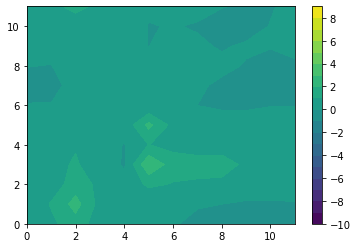

In [ ]:
PC_atm_NINO34 = np.zeros((12,12,20))


# [j,:,:,k] = the influence of jth SST mode on kth atmospheric mode 

for k in range(20):
    PC_atm_NINO34[:,:,k] = correlation_map_ats_NINO34[:,:,k]*coef_SPEAR_sst_NINO34[:,:,:].mean(axis=2)

plt.figure()
cs=plt.contourf(PC_atm_NINO34[:,:,0],np.arange(-10,10))
plt.colorbar(cs)

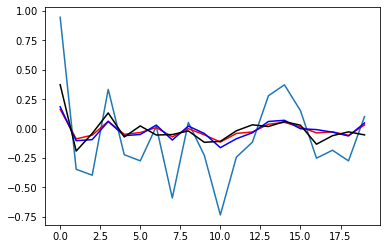

In [ ]:
plt.figure()
plt.plot(PC_atm_NINO34[4,2,:])
plt.plot(PC_atm_NINO34[5,1,:],'r')
plt.plot(PC_atm_NINO34[6,2,:],'b')

plt.plot(np.reshape(PC_atm_NINO34,[12*12,20]).mean(axis=0),'k')

In [ ]:
NINO34_obs         = np.reshape(NINO34_obs,[23,12])  
sereis1            = (NINO34_obs[:,2]-np.mean(NINO34_obs[:,2]))/np.std(NINO34_obs[:,2])
X_mat              = np.vstack((np.ones(PPH_monthly[3:26,:].shape[0]), sereis1)).T

# coef_total = (X^T X)^(-1) (X^T Y) (you can check wikipedia: https://en.wikipedia.org/wiki/Linear_regression, section: Least-squares estimation and related techniques)
# coef_total contains both b and a. the first dimension of coef_total is b and the second dimension of coef_total is a  
coef_total         = np.linalg.inv(X_mat.T.dot(X_mat)).dot(X_mat.T).dot(PPH_monthly[3:26,:])

# as mentioned previously, "a" represents the warming trend of cape and "b" is the cape value in reference year
PPH_NINO34         = np.reshape(coef_total[1,:],[110,300])



In [ ]:
np.shape(NINO34_obs)

(276,)

In [ ]:
mode               = 7
init_month         = 12
month              = 12
sereis1            = (Y_val_LM_sst_EOF[mode-1,init_month-1,month-1,:]-np.mean(Y_val_LM_sst_EOF[mode-1,init_month-1,month-1,:]))/np.std(Y_val_LM_sst_EOF[mode-1,init_month-1,month-1,:])
#PPH_monthly    = np.reshape(PPH_monthly,[PPH_monthly.shape[0],PPH_monthly.shape[1]*PPH_monthly.shape[2]]) # reshape 3D array to 2D array for matrix operation
X_mat              = np.vstack((np.ones(PPH_monthly[:,:].shape[0]), sereis1)).T

# coef_total = (X^T X)^(-1) (X^T Y) (you can check wikipedia: https://en.wikipedia.org/wiki/Linear_regression, section: Least-squares estimation and related techniques)
# coef_total contains both b and a. the first dimension of coef_total is b and the second dimension of coef_total is a  
coef_total         = np.linalg.inv(X_mat.T.dot(X_mat)).dot(X_mat.T).dot(PPH_monthly[:,:])

# as mentioned previously, "a" represents the warming trend of cape and "b" is the cape value in reference year
PPH_SST_mode       = np.reshape(coef_total[1,:],[110,300])

In [ ]:
np.shape(Y_val_LM_sst_EOF)

(20, 12, 12, 30)

/net/kct/miniconda3/envs/noaa2/lib/python3.6/site-packages/ipykernel_launcher.py:38: UserWarning: The following kwargs were not used by contour: 'linestyle'
/net/kct/miniconda3/envs/noaa2/lib/python3.6/site-packages/ipykernel_launcher.py:53: UserWarning: No contour levels were found within the data range.
/net/kct/miniconda3/envs/noaa2/lib/python3.6/site-packages/ipykernel_launcher.py:53: UserWarning: The following kwargs were not used by contour: 'linestyle'
/net/kct/miniconda3/envs/noaa2/lib/python3.6/site-packages/ipykernel_launcher.py:68: UserWarning: The following kwargs were not used by contour: 'linestyle'


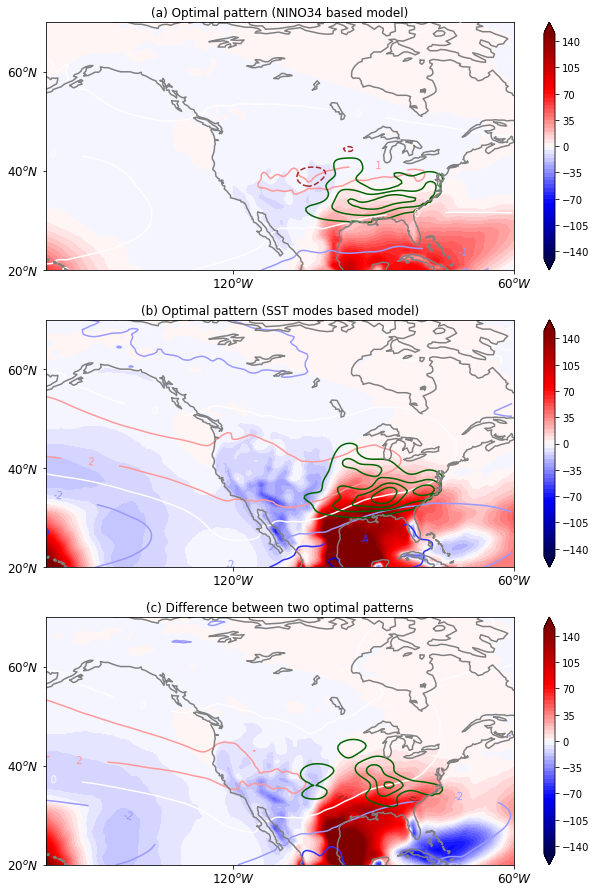

In [ ]:
composite_z500_NINO34  = np.zeros((130,520))
composite_WSHR_NINO34  = np.zeros((130,520))
composite_CAPE_NINO34  = np.zeros((130,520))
composite_z925_NINO34  = np.zeros((130,520))

composite_z500         = np.zeros((130,520))
composite_WSHR         = np.zeros((130,520))
composite_CAPE         = np.zeros((130,520))
composite_z925         = np.zeros((130,520))



EOF_obs_combine        = np.reshape(EOF_obs_combine,[20,3,130,520])
PC_weight_1            = PC_atm[11,0,:]/np.std(PC_atm[11,0,:])
PC_weight_2            = PC_atm_NINO34[6,2,:]/np.std(PC_atm_NINO34[6,2,:])

for ats_mode in range(10):
    
    composite_z500 = PC_atm[11,11,ats_mode]*np.reshape(EOF_obs_combine[ats_mode,1,:,:],[130,520])+composite_z500
    composite_WSHR = PC_atm[11,11,ats_mode]*np.reshape(EOF_obs_combine[ats_mode,0,:,:],[130,520])+composite_WSHR
    composite_CAPE = PC_atm[11,11,ats_mode]*np.reshape(EOF_obs_combine[ats_mode,2,:,:],[130,520])+composite_CAPE
    composite_z925 = PC_atm[11,11,ats_mode]*np.reshape(z925_regression[ats_mode,:],[130,520])+composite_z925
    composite_ivtu = PC_atm[11,11,ats_mode]*np.reshape(IVTu_regression[ats_mode,:],[360,576])+composite_ivtu
    composite_ivtv = PC_atm[11,11,ats_mode]*np.reshape(IVTv_regression[ats_mode,:],[360,576])+composite_ivtv
    
    composite_z500_NINO34 = PC_atm_NINO34[6,3,ats_mode]*np.reshape(EOF_obs_combine[ats_mode,1,:,:],[130,520])+composite_z500_NINO34
    composite_WSHR_NINO34 = PC_atm_NINO34[6,3,ats_mode]*np.reshape(EOF_obs_combine[ats_mode,0,:,:],[130,520])+composite_WSHR_NINO34
    composite_CAPE_NINO34 = PC_atm_NINO34[6,3,ats_mode]*np.reshape(EOF_obs_combine[ats_mode,2,:,:],[130,520])+composite_CAPE_NINO34
    composite_z925_NINO34 = PC_atm_NINO34[6,3,ats_mode]*np.reshape(z925_regression[ats_mode,:],[130,520])+composite_z925_NINO34

    
fig = plt.figure()
plt.subplot(3,1,1)
cs=plt.contourf(xx,yy,composite_CAPE_NINO34,np.arange(-150,155,5),extend='both',cmap='seismic')
cs2=plt.contour(xx[10:129,200:400],yy[10:129,200:400],composite_WSHR_NINO34[10:129,200:400],np.arange(-5,6,1),extend='both',cmap='seismic')
plt.clabel(cs2, cs2.levels, fontsize=10, inline=1,fmt = '%1.0f')
plt.contour(xx_PPH-0.5,yy_PPH+0.5,-PPH_NINO34*land_sea_mask,np.arange(0.001,0.009,0.002),colors='darkgreen')
plt.contour(xx_PPH-0.5,yy_PPH+0.5,-PPH_NINO34*land_sea_mask,np.arange(-0.005,0,0.002),colors='brown',linestyle='--')
#plt.contour(xx,yy,composite_z925_NINO34)
plt.colorbar(cs)
plt.plot(costal_lon,costal_lat,'gray')
plt.yticks([-80,-60,-40,-20,0, 20,40,60,80], ['$80^oS$', '$60^oS$', '$40^oS$', '$20^oS$', '$Eq$', '$20^oN$', '$40^oN$', '$60^oN$', '$80^oN$'],fontsize=12)
plt.xticks([0, 60, 120, 180,240,300,360], ['$0^oE$', '$60^oE$','$120^oE$', '$180^oE$', '$120^oW$', '$60^oW$', '$0^oW$'],fontsize=12) 
plt.xlim([200,300])
plt.ylim([20,70])    
plt.title('(a) Optimal pattern (NINO34 based model)')

plt.subplot(3,1,2)
cs=plt.contourf(xx,yy,composite_CAPE,np.arange(-150,155,5),extend='both',cmap='seismic')
cs2=plt.contour(xx[10:129,200:400],yy[10:129,200:400],composite_WSHR[10:129,200:400],np.arange(-10,12,2),extend='both',cmap='seismic')
plt.clabel(cs2, cs2.levels, fontsize=10, inline=1,fmt = '%1.0f')
plt.contour(xx_PPH-0.5,yy_PPH+0.5,PPH_SST_mode*land_sea_mask,np.arange(0.001,0.009,0.002),colors='darkgreen')
plt.contour(xx_PPH-0.5,yy_PPH+0.5,PPH_SST_mode*land_sea_mask,np.arange(-0.005,0,0.002),colors='brown',linestyle='--')
#plt.contour(xx,yy,composite_z925)
plt.colorbar(cs)
plt.plot(costal_lon,costal_lat,'gray')
plt.yticks([-80,-60,-40,-20,0, 20,40,60,80], ['$80^oS$', '$60^oS$', '$40^oS$', '$20^oS$', '$Eq$', '$20^oN$', '$40^oN$', '$60^oN$', '$80^oN$'],fontsize=12)
plt.xticks([0, 60, 120, 180,240,300,360], ['$0^oE$', '$60^oE$','$120^oE$', '$180^oE$', '$120^oW$', '$60^oW$', '$0^oW$'],fontsize=12) 
plt.xlim([200,300])
plt.ylim([20,70])
plt.title('(b) Optimal pattern (SST modes based model)')

plt.subplot(3,1,3)
cs=plt.contourf(xx,yy,composite_CAPE-composite_CAPE_NINO34,np.arange(-150,155,5),extend='both',cmap='seismic')
cs2=plt.contour(xx[10:129,200:400],yy[10:129,200:400],(composite_WSHR-composite_WSHR_NINO34)[10:129,200:400],np.arange(-10,12,2),extend='both',cmap='seismic')
plt.clabel(cs2, cs2.levels, fontsize=10, inline=1,fmt = '%1.0f')
plt.contour(xx_PPH,yy_PPH,(PPH_SST_mode+PPH_NINO34)*land_sea_mask,np.arange(0.001,0.009,0.002),colors='darkgreen')
plt.contour(xx_PPH,yy_PPH,(PPH_SST_mode+PPH_NINO34)*land_sea_mask,np.arange(-0.005,0,0.002),colors='brown',linestyle='--')
#plt.contour(xx,yy,composite_z925-composite_z925_NINO34,np.arange(1,21,2))
plt.colorbar(cs)
plt.plot(costal_lon,costal_lat,'gray')
plt.yticks([-80,-60,-40,-20,0, 20,40,60,80], ['$80^oS$', '$60^oS$', '$40^oS$', '$20^oS$', '$Eq$', '$20^oN$', '$40^oN$', '$60^oN$', '$80^oN$'],fontsize=12)
plt.xticks([0, 60, 120, 180,240,300,360], ['$0^oE$', '$60^oE$','$120^oE$', '$180^oE$', '$120^oW$', '$60^oW$', '$0^oW$'],fontsize=12) 
plt.xlim([200,300])
plt.ylim([20,70])
fig.set_size_inches(10.5,15.5)
plt.title('(c) Difference between two optimal patterns')

fig.savefig('/home/Kai-chi.Tseng/2019_research/SPEAR_tornado/FIGS3.pdf', dpi=300, bbox_inches='tight')
fig.savefig('/home/Kai-chi.Tseng/2019_research/SPEAR_tornado/FIGS3.png', dpi=300, bbox_inches='tight')




In [ ]:
np.shape(xx)

(110, 300)

TypeError: Shapes of x (130, 520) and z (110, 300) do not match

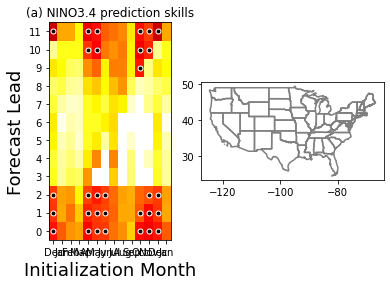

In [ ]:
fig, axs = plt.subplots(1, 2, gridspec_kw={'width_ratios': [2, 3]})
cs1      = axs[0].pcolormesh(np.transpose(score_map2[:,1:]),vmin=0,vmax=1,cmap=my_map)
axs[0].set_xticks(np.arange(0.5,17,1), minor=False)
axs[0].set_xticklabels(['Dec','Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct', 'Nov',\
                                'Dec','Jan','Feb','Mar','Apr'], fontdict=None, minor=False)
axs[0].set_yticks(np.arange(0.5,12,1), minor=False)
axs[0].set_yticklabels(np.arange(0,12,1), fontdict=None, minor=False)
axs[0].set_ylim([0,12])
axs[0].set_xlabel('Initialization Month',fontsize=18)
axs[0].set_ylabel('Forecast Lead',fontsize=18)
posi_x, posi_y = np.where(score_map2>0.505)
axs[0].scatter(posi_x+0.5,posi_y-0.5,25,'w')
axs[0].scatter(posi_x+0.5,posi_y-0.5,8,'k')
axs[0].set_title('(a) NINO3.4 prediction skills')


states.boundary.plot(color='gray',ax=axs[1])
cs2     = axs[1].contourf(xx-0.5-360,yy+0.5,PPH_NINO34*land_sea_mask*100,np.arange(-1,1.05,0.05),cmap='seismic',extend='both')
axs[1].contour(xx-0.5-360,yy+0.5,reg_coef*land_sea_mask,[-0.5,-0.4,-0.3],colors='k',linestyle='--')
axs[1].contour(xx-0.5-360,yy+0.5,reg_coef*land_sea_mask,[0.3,0.4,0.5],colors='k',linestyle='--')
axs[1].set_title('(b) Pratical Perfect Hindcast (%)')
axs[1].plot(costal_lon-360,costal_lat,'gray')
axs[1].set_xticks([0-360, 60-360, 120-360, 180-360,240-360,300-360,360-360], minor=False)
axs[1].set_xticklabels(['$0^oE$', '$60^oE$','$120^oE$', '$180^oE$', '$120^oW$', '$60^oW$', '$0^oW$'], fontdict=None, minor=False)
axs[1].set_yticks([-80,-60,-40,-20,0, 20,40,60,80], minor=False)
axs[1].set_yticklabels(['$80^oS$', '$60^oS$', '$40^oS$', '$20^oS$', '$Eq$', '$20^oN$', '$40^oN$', '$60^oN$', '$80^oN$'], fontdict=None, minor=False)    
axs[1].set_xlim([200-360,300-360])
axs[1].set_ylim([20,70])    

(20.0, 70.0)

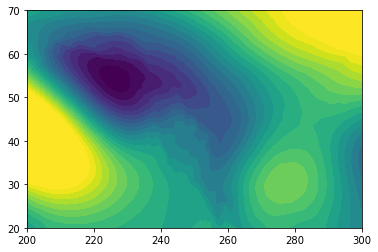

In [ ]:
#composite_z925-composite_z925_NINO34
#np.reshape(z925_regression)

diff_map  = np.reshape(composite_z925-composite_z925_NINO34,[130,520])
basis_map = np.reshape(z925_regression,[20,130,520])
posi_y, posi_x = np.where((xx>=240) & (xx<300) & (yy>=20) & (yy<60))
#plt.figure()
#plt.contourf(xx[posi_y,posi_x],yy[posi_y,posi_x],diff_map[posi_y,posi_x])
diff_map2 = np.reshape(diff_map[posi_y[0:9000:450],posi_x[0:9000:450]],[1,20])
np.shape(basis_map[:,posi_y[0:9000:450],posi_x[0:9000:450]])
mexico_high_coef = diff_map2.dot(np.linalg.inv(basis_map[:,posi_y[0:9000:450],posi_x[0:9000:450]]))
reconstruct      = np.reshape(mexico_high_coef.dot(z925_regression),[130,520])
plt.figure()
plt.contourf(xx,yy,diff_map,np.arange(-21,20,2),extend='both')
plt.xlim([200,300])
plt.ylim([20,70])

In [ ]:
mexico_high_coef

array([[ 0.8338046 , -0.94485097, -0.94453362,  0.6115904 ,  2.28742775,
         0.58390157,  0.01208237,  0.7053559 ,  0.22129214, -1.62066965,
        -2.57314739, -3.81364069, -0.84455242, -1.0814126 , -2.9458158 ,
         1.47961455, -3.04660349,  3.6310313 ,  1.67034209,  0.93230718]])

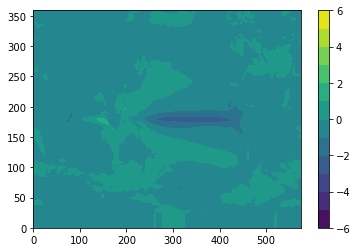

In [ ]:
# calculate corresponding SST PC for certain forecast lead and target month
PC_sst = np.zeros((20,12,12))
for j in range(20): #SST PC
    series1         = np.reshape(correlation_map_ats_to_sst[j,:,:,:],[12*12,20])
    series2         = np.reshape(mexico_high_coef,[20,1]) 
    PC_sst[j,:,:]   = np.reshape(series1.dot(series2),[12,12])


# reconstruct the optimal SST map for the difference atmospheric states 
sst_diff_map = np.zeros((360,576))
for i in range(3):
    sst_diff_map = sst_EOF_maps[i,:,:]*PC_sst[i,11,11]+sst_diff_map

plt.figure()
cs=plt.contourf(sst_diff_map,np.arange(-6,7,1))
plt.colorbar(cs)

In [ ]:
def fmt(x):
    s = f"{x:.1f}"
    if s.endswith("0"):
        s = f"{x:.0f}"
    return rf"{s} " if plt.rcParams["text.usetex"] else f"{s} "

In [ ]:
composite_z500_NINO34  = np.zeros((130,520))
composite_WSHR_NINO34  = np.zeros((130,520))
composite_CAPE_NINO34  = np.zeros((130,520))
composite_z925_NINO34  = np.zeros((130,520))
composite_ivtu_NINO34  = np.zeros((360,576))
composite_ivtv_NINO34  = np.zeros((360,576))

composite_z500         = np.zeros((130,520))
composite_WSHR         = np.zeros((130,520))
composite_CAPE         = np.zeros((130,520))
composite_z925         = np.zeros((130,520))
composite_ivtu         = np.zeros((360,576))
composite_ivtv         = np.zeros((360,576))


EOF_obs_combine        = np.reshape(EOF_obs_combine,[20,3,130,520])
PC_weight_1            = PC_atm[11,11,:]/np.std(PC_atm[11,11,:])
PC_weight_2            = PC_atm_NINO34[6,4,:]/np.std(PC_atm_NINO34[6,2,:])

for ats_mode in range(10):
    
    composite_z500 = PC_atm[11,11,ats_mode]*np.reshape(EOF_obs_combine[ats_mode,1,:,:],[130,520])+composite_z500
    composite_WSHR = PC_atm[11,11,ats_mode]*np.reshape(EOF_obs_combine[ats_mode,0,:,:],[130,520])+composite_WSHR
    composite_CAPE = PC_atm[11,11,ats_mode]*np.reshape(EOF_obs_combine[ats_mode,2,:,:],[130,520])+composite_CAPE
    composite_z925 = PC_atm[11,11,ats_mode]*np.reshape(z925_regression[ats_mode,:],[130,520])+composite_z925
    composite_ivtu = PC_atm[11,11,ats_mode]*np.reshape(IVTu_regression[ats_mode,:],[360,576])+composite_ivtu
    composite_ivtv = PC_atm[11,11,ats_mode]*np.reshape(IVTv_regression[ats_mode,:],[360,576])+composite_ivtv
    
    
    composite_z500_NINO34 = PC_atm_NINO34[6,4,ats_mode]*np.reshape(EOF_obs_combine[ats_mode,1,:,:],[130,520])+composite_z500_NINO34
    composite_WSHR_NINO34 = PC_atm_NINO34[6,4,ats_mode]*np.reshape(EOF_obs_combine[ats_mode,0,:,:],[130,520])+composite_WSHR_NINO34
    composite_CAPE_NINO34 = PC_atm_NINO34[6,4,ats_mode]*np.reshape(EOF_obs_combine[ats_mode,2,:,:],[130,520])+composite_CAPE_NINO34
    composite_z925_NINO34 = PC_atm_NINO34[6,4,ats_mode]*np.reshape(z925_regression[ats_mode,:],[130,520])+composite_z925_NINO34
    composite_ivtu_NINO34 = PC_atm_NINO34[6,4,ats_mode]*np.reshape(IVTu_regression[ats_mode,:],[360,576])+composite_ivtu_NINO34
    composite_ivtv_NINO34 = PC_atm_NINO34[6,4,ats_mode]*np.reshape(IVTv_regression[ats_mode,:],[360,576])+composite_ivtv_NINO34

    
    
diff_u = composite_ivtu-composite_ivtu_NINO34
diff_v = composite_ivtv-composite_ivtv_NINO34

posi = np.where((composite_ivtu**2+composite_ivtv**2)**0.5<20)
composite_ivtu[posi]=np.nan
composite_ivtv[posi]=np.nan

posi = np.where((composite_ivtu_NINO34**2+composite_ivtv_NINO34**2)**0.5<5)
composite_ivtu_NINO34[posi]=np.nan
composite_ivtv_NINO34[posi]=np.nan

posi = np.where((diff_u**2+diff_v**2)**0.5<20)
diff_u[posi]=np.nan
diff_v[posi]=np.nan

fig = plt.figure()
plt.subplot(3,1,1)
cs=plt.contourf(xx,yy,composite_CAPE_NINO34,np.arange(-150,155,5),extend='both',cmap='seismic')
plt.contour(xx,yy,composite_WSHR_NINO34,np.arange(-5,6,1),extend='both',cmap='seismic')
cs1=plt.contour(xx_PPH-0.5,yy_PPH+0.5,-PPH_NINO34*land_sea_mask*100,np.arange(0.1,0.9,0.2),colors='darkgreen')
cs1=plt.contour(xx_PPH-0.5,yy_PPH+0.5,-PPH_NINO34*land_sea_mask*100,np.arange(-0.5,0,0.2),colors='brown',linestyle='--')
plt.clabel(cs1, cs1.levels, fontsize=10, inline=1,fmt = '%0.1f')
plt.quiver(xx2[::5,::5],yy2[::5,::5],composite_ivtu_NINO34[::5,::5], composite_ivtv_NINO34[::5,::5], scale=500)
plt.colorbar(cs)
plt.plot(costal_lon,costal_lat,'gray')
cs2=plt.contour(xx[10:129,200:400],yy[10:129,200:400],composite_z925_NINO34[10:129,200:400],[1,3,5,10,15],colors='r')
cs3=plt.contour(xx[10:129,200:400],yy[10:129,200:400],composite_z925_NINO34[10:129,200:400],[-5,-3,-1],colors='b',linestyle='--')
#plt.clabel(cs2, cs2.levels, fontsize=10, inline=1,fmt = '%1.0f')
#cs2=plt.contour(xx,yy,composite_z925_NINO34,[1,3,5,10,15],colors='r')
plt.yticks([-80,-60,-40,-20,0, 20,40,60,80], ['$80^oS$', '$60^oS$', '$40^oS$', '$20^oS$', '$Eq$', '$20^oN$', '$40^oN$', '$60^oN$', '$80^oN$'],fontsize=12)
plt.xticks([0, 60, 120, 180,240,300,360], ['$0^oE$', '$60^oE$','$120^oE$', '$180^oE$', '$120^oW$', '$60^oW$', '$0^oW$'],fontsize=12) 
plt.xlim([200,300])
plt.ylim([20,70])   
plt.clabel(cs2, cs2.levels, fontsize=15, inline=1,fmt = '%1.0f')
plt.clabel(cs3, cs3.levels, fontsize=15, inline=1,fmt = '%1.0f')
#plt.clabel(cs2, cs2.levels, fontsize=10, inline=1,fmt = '%1.0f')
#
#plt.clabel(cs2, ticks=['1','3','5','10','15'], inline=True,fmt = '%1.0f')
#plt.clabel(cs3, inline=True,fmt = '%1.0f')
plt.title('(a) Optimal pattern (NINO34 based model)')

plt.subplot(3,1,2)
cs=plt.contourf(xx,yy,composite_CAPE,np.arange(-150,155,5),extend='both',cmap='seismic')
#plt.contour(xx,yy,composite_WSHR,np.arange(-10,12,2),extend='both',cmap='seismic')
plt.contour(xx_PPH-0.5,yy_PPH+0.5,(PPH_SST_mode)*land_sea_mask,np.arange(0.001,0.009,0.002),colors='darkgreen')
plt.contour(xx_PPH-0.5,yy_PPH+0.5,(PPH_SST_mode)*land_sea_mask,np.arange(-0.005,0,0.002),colors='brown',linestyle='--')
cs2=plt.contour(xx[10:129,200:400],yy[10:129,200:400],composite_z925[10:129,200:400],np.arange(5,45,10),colors='r')
cs3=plt.contour(xx[10:129,200:400],yy[10:129,200:400],composite_z925[10:129,200:400],np.arange(-45,-4,10),colors='b',linestyle='--')
plt.quiver(xx2[::5,::5],yy2[::5,::5],composite_ivtu[::5,::5], composite_ivtv[::5,::5], scale=1500)
plt.colorbar(cs)
plt.plot(costal_lon,costal_lat,'gray')
plt.yticks([-80,-60,-40,-20,0, 20,40,60,80], ['$80^oS$', '$60^oS$', '$40^oS$', '$20^oS$', '$Eq$', '$20^oN$', '$40^oN$', '$60^oN$', '$80^oN$'],fontsize=12)
plt.xticks([0, 60, 120, 180,240,300,360], ['$0^oE$', '$60^oE$','$120^oE$', '$180^oE$', '$120^oW$', '$60^oW$', '$0^oW$'],fontsize=12) 
plt.xlim([200,300])
plt.ylim([20,70])
plt.clabel(cs2, cs2.levels, fontsize=15, inline=1,fmt = '%1.0f')
plt.clabel(cs3, cs3.levels, fontsize=15, inline=1,fmt = '%1.0f')
plt.title('(b) Optimal pattern (SST modes based model)')

plt.subplot(3,1,3)
cs=plt.contourf(xx,yy,composite_CAPE-composite_CAPE_NINO34,np.arange(-150,155,5),extend='both',cmap='seismic')
#plt.contour(xx,yy,composite_WSHR-composite_WSHR_NINO34,np.arange(-10,12,2),extend='both',cmap='seismic')
plt.contour(xx_PPH-0.5,yy_PPH+0.5,(PPH_SST_mode+PPH_NINO34)*land_sea_mask,np.arange(0.001,0.009,0.002),colors='darkgreen')
plt.contour(xx_PPH-0.5,yy_PPH+0.5,(PPH_SST_mode+PPH_NINO34)*land_sea_mask,np.arange(-0.005,0,0.002),colors='brown',linestyle='--')
#plt.contour(xx,yy,composite_z925-composite_z925_NINO34,np.arange(1,21,2))
cs2=plt.contour(xx[10:129,200:400],yy[10:129,200:400],(composite_z925-composite_z925_NINO34)[10:129,200:400],np.arange(5,45,10),colors='r')
cs3=plt.contour(xx[10:129,200:400],yy[10:129,200:400],(composite_z925-composite_z925_NINO34)[10:129,200:400],np.arange(-45,-4,10),colors='b',linestyle='--')
plt.quiver(xx2[::5,::5],yy2[::5,::5],diff_u[::5,::5], diff_v[::5,::5], scale=1500)
#states.boundary.plot(color='gray',ax=axs[1])
plt.clabel(cs2, cs2.levels, fontsize=15, inline=1,fmt = '%1.0f')
plt.clabel(cs3, cs3.levels, fontsize=15, inline=1,fmt = '%1.0f')
plt.colorbar(cs)
plt.plot(costal_lon,costal_lat,'gray')
plt.yticks([-80,-60,-40,-20,0, 20,40,60,80], ['$80^oS$', '$60^oS$', '$40^oS$', '$20^oS$', '$Eq$', '$20^oN$', '$40^oN$', '$60^oN$', '$80^oN$'],fontsize=12)
plt.xticks([0, 60, 120, 180,240,300,360], ['$0^oE$', '$60^oE$','$120^oE$', '$180^oE$', '$120^oW$', '$60^oW$', '$0^oW$'],fontsize=12) 
plt.xlim([200,300])
plt.ylim([20,70])
fig.set_size_inches(10.5,15.5)
plt.title('(c) Difference between two optimal patterns')

#fig.savefig('/home/Kai-chi.Tseng/2019_research/SPEAR_tornado/FIG3.pdf', dpi=300, bbox_inches='tight')
#fig.savefig('/home/Kai-chi.Tseng/2019_research/SPEAR_tornado/FIG3.png', dpi=300, bbox_inches='tight')




NameError: name 'np' is not defined

(20.0, 70.0)

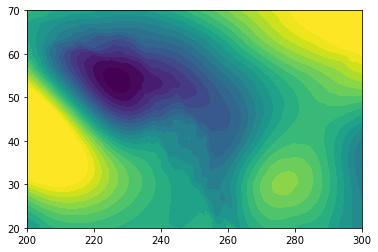

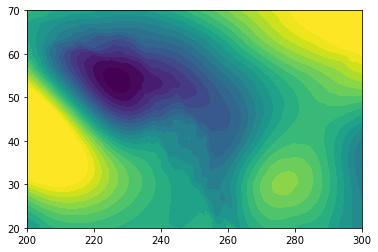

In [ ]:
#composite_z925-composite_z925_NINO34
#np.reshape(z925_regression)

diff_map  = np.reshape(composite_z925-composite_z925_NINO34,[130,520])
basis_map = np.reshape(z925_regression,[20,130,520])
posi_y, posi_x = np.where((xx>=240) & (xx<300) & (yy>=20) & (yy<60))
#plt.figure()
#plt.contourf(xx[posi_y,posi_x],yy[posi_y,posi_x],diff_map[posi_y,posi_x])
diff_map2        = np.reshape(diff_map[posi_y[0:9000:450],posi_x[0:9000:450]],[1,20])
np.shape(basis_map[:,posi_y[0:9000:450],posi_x[0:9000:450]])
mexico_high_coef = diff_map2.dot(np.linalg.inv(basis_map[:,posi_y[0:9000:450],posi_x[0:9000:450]]))
reconstruct      = np.reshape(mexico_high_coef.dot(z925_regression),[130,520])
plt.figure()
plt.contourf(xx,yy,diff_map,np.arange(-21,20,2),extend='both')
plt.xlim([200,300])
plt.ylim([20,70])
plt.figure()
plt.contourf(xx,yy,reconstruct,np.arange(-21,20,2),extend='both')
plt.xlim([200,300])
plt.ylim([20,70])

In [ ]:
# calculate corresponding SST PC for certain forecast lead and target month
PC_sst = np.zeros((20,12,12))
for j in range(20): #SST PC
    series1         = np.reshape(correlation_map_ats_to_sst[j,:,:,:],[12*12,20])
    series2         = np.reshape(mexico_high_coef,[20,1]) 
    PC_sst[j,:,:]   = np.reshape(series1.dot(series2),[12,12])

posi1,posi2 = np.where(score_map_EOF[6,:,:]>0.5)
# reconstruct the optimal SST map for the difference atmospheric states 
sst_diff_map = np.zeros((12,12,360,576))
for init in range(12):
    for month in range(12):
        for i in range(7):
            sst_diff_map[init,month,:,:] = sst_EOF_maps[i,:,:]*PC_sst[i,init,month]+sst_diff_map[init,month,:,:]
            #sst_diff_map[init,month,:,:] = sst_EOF_maps[i,:,:]*np.mean(PC_sst[i,posi1,2])+sst_diff_map[init,month,:,:]

#plt.figure()
#cs=plt.contourf(sst_diff_map,np.arange(-6,7,1))
#plt.colorbar(cs)

([<matplotlib.axis.XTick at 0x2b2187dee860>,
 [Text(0, 0, '1'),
  Text(1, 0, '2'),
  Text(2, 0, '3'),
  Text(3, 0, '4'),
  Text(4, 0, '5'),
  Text(5, 0, '6'),
  Text(6, 0, '7'),
  Text(7, 0, '8'),
  Text(8, 0, '9'),
  Text(9, 0, '10'),
  Text(10, 0, '11'),
  Text(11, 0, '12'),
  Text(12, 0, '13'),
  Text(13, 0, '14'),
  Text(14, 0, '15'),
  Text(15, 0, '16'),
  Text(16, 0, '17'),
  Text(17, 0, '18'),
  Text(18, 0, '19'),
  Text(19, 0, '20')])

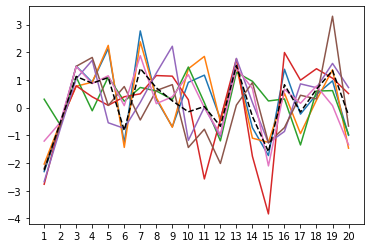

In [ ]:
plt.plot(PC_sst[:,6,1])
plt.plot(PC_sst[:,6,2])
plt.plot(PC_sst[:,6,3])
plt.plot(PC_sst[:,11,11])
plt.plot(PC_sst[:,10,10])
plt.plot(PC_sst[:,9,9])

plt.plot(PC_sst[:,2,0])


posi1,posi2 = np.where(score_map_EOF[6,:,:]>0.5)
plt.plot((PC_sst[:,posi1,posi2].mean(axis=1)),'k--')
plt.xticks(np.arange(0,20,1),np.arange(1,21,1))

In [ ]:
np.shape(PC_sst[:,posi1,posi2])

(20, 27)

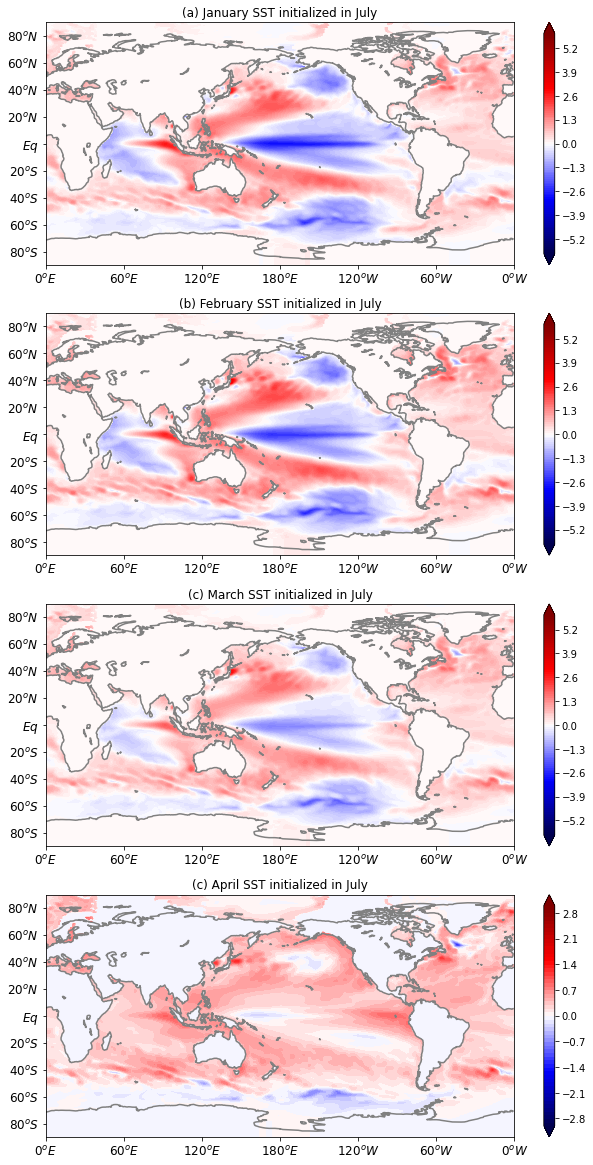

In [ ]:


fig=plt.figure()
plt.subplot(4,1,1)
init  = 6
month = 0
cs=plt.contourf(xx_sst,yy_sst,sst_diff_map[init,month],levels=np.arange(-6,6.1,0.1),cmap='seismic',extend='both')
plt.plot(costal_lon,costal_lat,'gray')
plt.title('(a) January SST initialized in July')
plt.xticks([0, 60, 120, 180,240,300,360], ['$0^oE$', '$60^oE$','$120^oE$', '$180^oE$', '$120^oW$', '$60^oW$', '$0^oW$'],fontsize=12) 
plt.yticks([-80,-60,-40,-20,0, 20,40,60,80], ['$80^oS$', '$60^oS$', '$40^oS$', '$20^oS$', '$Eq$', '$20^oN$', '$40^oN$', '$60^oN$', '$80^oN$'],fontsize=12)
plt.colorbar(cs)
plt.xlim([0,360])
plt.subplot(4,1,2)
init  = 6
month = 1
cs=plt.contourf(xx_sst,yy_sst,sst_diff_map[init,month],levels=np.arange(-6,6.1,0.1),cmap='seismic',extend='both')
plt.plot(costal_lon,costal_lat,'gray')
plt.title('(b) February SST initialized in July')
plt.xticks([0, 60, 120, 180,240,300,360], ['$0^oE$', '$60^oE$','$120^oE$', '$180^oE$', '$120^oW$', '$60^oW$', '$0^oW$'],fontsize=12) 
plt.yticks([-80,-60,-40,-20,0, 20,40,60,80], ['$80^oS$', '$60^oS$', '$40^oS$', '$20^oS$', '$Eq$', '$20^oN$', '$40^oN$', '$60^oN$', '$80^oN$'],fontsize=12)
plt.colorbar(cs)
plt.xlim([0,360])
plt.subplot(4,1,3)
init  = 6
month = 2
cs=plt.contourf(xx_sst,yy_sst,(sst_diff_map[init,month]*3+sst_diff_map[6,3]*1)/4,levels=np.arange(-6,6.1,0.1),cmap='seismic',extend='both')
plt.plot(costal_lon,costal_lat,'gray')
plt.title('(c) March SST initialized in July')
plt.xticks([0, 60, 120, 180,240,300,360], ['$0^oE$', '$60^oE$','$120^oE$', '$180^oE$', '$120^oW$', '$60^oW$', '$0^oW$'],fontsize=12) 
plt.yticks([-80,-60,-40,-20,0, 20,40,60,80], ['$80^oS$', '$60^oS$', '$40^oS$', '$20^oS$', '$Eq$', '$20^oN$', '$40^oN$', '$60^oN$', '$80^oN$'],fontsize=12)
plt.colorbar(cs)
plt.xlim([0,360])
plt.subplot(4,1,4)
init  = 6
month = 3
cs=plt.contourf(xx_sst,yy_sst,sst_diff_map[init,month],levels=np.arange(-3,3.1,0.1),cmap='seismic',extend='both')
plt.plot(costal_lon,costal_lat,'gray')
plt.title('(c) April SST initialized in July')
plt.xticks([0, 60, 120, 180,240,300,360], ['$0^oE$', '$60^oE$','$120^oE$', '$180^oE$', '$120^oW$', '$60^oW$', '$0^oW$'],fontsize=12) 
plt.yticks([-80,-60,-40,-20,0, 20,40,60,80], ['$80^oS$', '$60^oS$', '$40^oS$', '$20^oS$', '$Eq$', '$20^oN$', '$40^oN$', '$60^oN$', '$80^oN$'],fontsize=12)
plt.colorbar(cs)
plt.xlim([0,360])
#plt.colorbar(cs)

fig.set_size_inches(10.5,20.5)
fig.savefig('/home/Kai-chi.Tseng/2019_research/SPEAR_tornado/FIGS4.pdf', dpi=300, bbox_inches='tight')
fig.savefig('/home/Kai-chi.Tseng/2019_research/SPEAR_tornado/FIGS4.png', dpi=300, bbox_inches='tight')


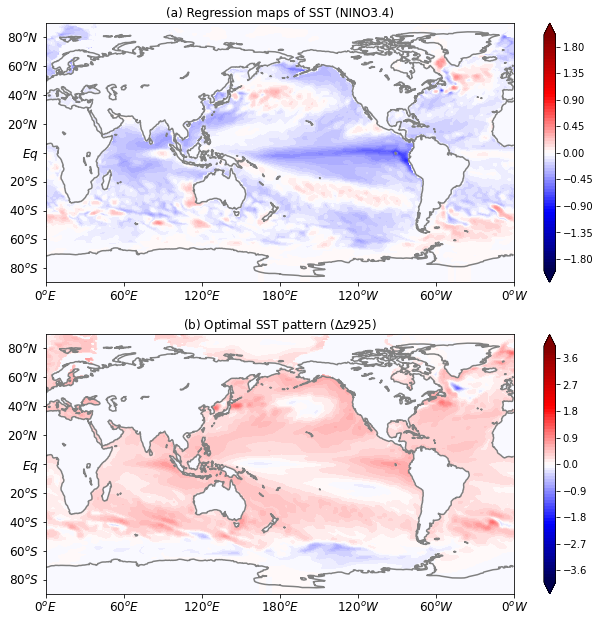

In [ ]:
# calculate the optimal pattern for SST
NINO34_obs         = np.reshape(NINO34_obs,[23,12])
sst_template       = np.reshape(sst_monthly_anomaly[11::12,:,:],[23,360*576])

#PPH_monthly    = np.reshape(PPH_monthly,[PPH_monthly.shape[0],PPH_monthly.shape[1]*PPH_monthly.shape[2]]) # reshape 3D array to 2D array for matrix operation
X_mat              = np.vstack((np.ones(23), NINO34_obs[:,11])).T

# coef_total = (X^T X)^(-1) (X^T Y) (you can check wikipedia: https://en.wikipedia.org/wiki/Linear_regression, section: Least-squares estimation and related techniques)
# coef_total contains both b and a. the first dimension of coef_total is b and the second dimension of coef_total is a  
coef_total         = np.linalg.inv(X_mat.T.dot(X_mat)).dot(X_mat.T).dot(sst_template)

# as mentioned previously, "a" represents the warming trend of cape and "b" is the cape value in reference year
sst_NINO34         = np.reshape(coef_total[1,:],[360,576])
#np.shape(sst_monthly_anomaly[2::12,:,:])


sst_model          = np.reshape(sst_model,[12,30,12,360,576])
# calculate the optimal pattern for SST
NINO34             = np.reshape(NINO34,[12,30,12])
series1            = (NINO34[2,:,2]-np.mean(NINO34[2,:,2]))/np.std(NINO34[2,:,2])
sst_template       = np.reshape(sst_model[2,:,2,:,:],[30,360*576])

#PPH_monthly    = np.reshape(PPH_monthly,[PPH_monthly.shape[0],PPH_monthly.shape[1]*PPH_monthly.shape[2]]) # reshape 3D array to 2D array for matrix operation
X_mat              = np.vstack((np.ones(30), series1)).T

# coef_total = (X^T X)^(-1) (X^T Y) (you can check wikipedia: https://en.wikipedia.org/wiki/Linear_regression, section: Least-squares estimation and related techniques)
# coef_total contains both b and a. the first dimension of coef_total is b and the second dimension of coef_total is a  
coef_total         = np.linalg.inv(X_mat.T.dot(X_mat)).dot(X_mat.T).dot(sst_template)

# as mentioned previously, "a" represents the warming trend of cape and "b" is the cape value in reference year
sst_NINO34         = np.reshape(coef_total[1,:],[360,576])

sst_NINO34[sst_NINO34>100] = 0

#for mode in range(20):

#import matplotlib
#matplotlib.rcParams['text.usetex'] = True
sst_optimal = np.zeros((360,576))
for mode in range(7):
    sst_optimal = sst_EOF_maps[mode,:,:]*np.mean(coef_SPEAR_sst[11,11,:,mode])+sst_optimal

fig = plt.figure()
plt.subplot(2,1,1)
cs=plt.contourf(xx_sst,yy_sst,-sst_NINO34,levels=np.arange(-2,2.05,0.05),cmap='seismic',extend='both')
plt.colorbar(cs)
plt.plot(costal_lon,costal_lat,'gray')
plt.xlim([0,360])
plt.xticks([0, 60, 120, 180,240,300,360], ['$0^oE$', '$60^oE$','$120^oE$', '$180^oE$', '$120^oW$', '$60^oW$', '$0^oW$'],fontsize=12) 
plt.yticks([-80,-60,-40,-20,0, 20,40,60,80], ['$80^oS$', '$60^oS$', '$40^oS$', '$20^oS$', '$Eq$', '$20^oN$', '$40^oN$', '$60^oN$', '$80^oN$'],fontsize=12)
plt.title('(a) Regression maps of SST (NINO3.4)')

plt.subplot(2,1,2)
cs=plt.contourf(xx_sst,yy_sst,sst_diff_map[6,4],levels=np.arange(-4,4.1,0.1),cmap='seismic',extend='both')
plt.colorbar(cs)
plt.plot(costal_lon,costal_lat,'gray')
plt.xlim([0,360])
plt.xticks([0, 60, 120, 180,240,300,360], ['$0^oE$', '$60^oE$','$120^oE$', '$180^oE$', '$120^oW$', '$60^oW$', '$0^oW$'],fontsize=12) 
plt.yticks([-80,-60,-40,-20,0, 20,40,60,80], ['$80^oS$', '$60^oS$', '$40^oS$', '$20^oS$', '$Eq$', '$20^oN$', '$40^oN$', '$60^oN$', '$80^oN$'],fontsize=12)
#plt.title('(b) Optimal SST pattern for (EOF-based model)')
#plt.title(r'(b) Optimal pattern for $\delta$', fontsize=16, color='r')
#plt.plot(costal_lon,costal_lat,'gray')
plt.title('(b) Optimal SST pattern ($\Delta$z925)')
fig.set_size_inches(10.5,10.5)

#fig.savefig('/home/Kai-chi.Tseng/2019_research/SPEAR_tornado/FIG4.pdf', dpi=300, bbox_inches='tight')
#fig.savefig('/home/Kai-chi.Tseng/2019_research/SPEAR_tornado/FIG4.png', dpi=300, bbox_inches='tight')


In [ ]:
np.shape(sst_model)

(12, 360, 360, 576)

In [ ]:
# calculate the optimal pattern for SST
NINO34_obs         = np.reshape(NINO34_obs,[23,12])
sst_template       = np.reshape(sst_monthly_anomaly[11::12,:,:],[23,360*576])

#PPH_monthly    = np.reshape(PPH_monthly,[PPH_monthly.shape[0],PPH_monthly.shape[1]*PPH_monthly.shape[2]]) # reshape 3D array to 2D array for matrix operation
X_mat              = np.vstack((np.ones(23), NINO34_obs[:,11])).T

# coef_total = (X^T X)^(-1) (X^T Y) (you can check wikipedia: https://en.wikipedia.org/wiki/Linear_regression, section: Least-squares estimation and related techniques)
# coef_total contains both b and a. the first dimension of coef_total is b and the second dimension of coef_total is a  
coef_total         = np.linalg.inv(X_mat.T.dot(X_mat)).dot(X_mat.T).dot(sst_template)

# as mentioned previously, "a" represents the warming trend of cape and "b" is the cape value in reference year
sst_NINO34         = np.reshape(coef_total[1,:],[360,576])
#np.shape(sst_monthly_anomaly[2::12,:,:])


#for mode in range(20):


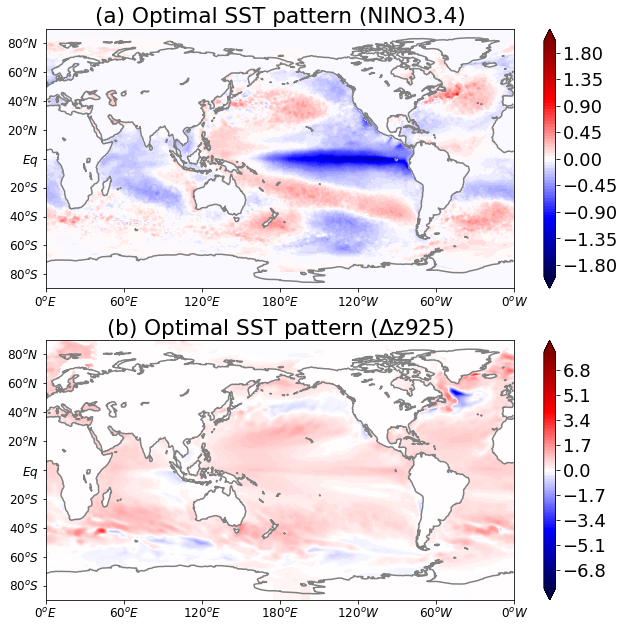

In [ ]:
#import matplotlib
#matplotlib.rcParams['text.usetex'] = True
sst_optimal = np.zeros((360,576))
for mode in range(7):
    sst_optimal = sst_EOF_maps[mode,:,:]*np.mean(coef_SPEAR_sst[6,4,:,mode])+sst_optimal

fig = plt.figure()
plt.subplot(2,1,1)
cs=plt.contourf(xx_sst,yy_sst,-sst_NINO34,levels=np.arange(-2,2.05,0.05),cmap='seismic',extend='both')
plt.colorbar(cs)
plt.plot(costal_lon,costal_lat,'gray')
plt.xlim([0,360])
plt.xticks([0, 60, 120, 180,240,300,360], ['$0^oE$', '$60^oE$','$120^oE$', '$180^oE$', '$120^oW$', '$60^oW$', '$0^oW$'],fontsize=12) 
plt.yticks([-80,-60,-40,-20,0, 20,40,60,80], ['$80^oS$', '$60^oS$', '$40^oS$', '$20^oS$', '$Eq$', '$20^oN$', '$40^oN$', '$60^oN$', '$80^oN$'],fontsize=12)
plt.title('(a) Optimal SST pattern (NINO3.4)')

plt.subplot(2,1,2)
cs=plt.contourf(xx_sst,yy_sst,sst_diff_map[6,5],levels=np.arange(-8,8.1,0.1),cmap='seismic',extend='both')
plt.colorbar(cs)
plt.plot(costal_lon,costal_lat,'gray')
plt.xlim([0,360])
plt.xticks([0, 60, 120, 180,240,300,360], ['$0^oE$', '$60^oE$','$120^oE$', '$180^oE$', '$120^oW$', '$60^oW$', '$0^oW$'],fontsize=12) 
plt.yticks([-80,-60,-40,-20,0, 20,40,60,80], ['$80^oS$', '$60^oS$', '$40^oS$', '$20^oS$', '$Eq$', '$20^oN$', '$40^oN$', '$60^oN$', '$80^oN$'],fontsize=12)
#plt.title('(b) Optimal SST pattern for (EOF-based model)')
#plt.title(r'(b) Optimal pattern for $\delta$', fontsize=16, color='r')
#plt.plot(costal_lon,costal_lat,'gray')
plt.title('(b) Optimal SST pattern ($\Delta$z925)')
fig.set_size_inches(10.5,10.5)

#fig.savefig('/home/Kai-chi.Tseng/2019_research/SPEAR_tornado/FIG5_delta.pdf', dpi=300, bbox_inches='tight')
#fig.savefig('/home/Kai-chi.Tseng/2019_research/SPEAR_tornado/FIG5_delta.png', dpi=300, bbox_inches='tight')


In [ ]:
np.savez('/archive/Kai-chi.Tseng/data/SPEAR_tornado_seasonal/SPEAR_monthly_data_ivt.npz',\
          ivtu_model_ens = ivtu_model_ens,\
          ivtv_model_ens = ivtv_model_ens,\
        )

In [ ]:
os.system('dmget /archive/Kai-chi.Tseng/data/SPEAR_tornado_seasonal/SPEAR_monthly_data_all_lead_time.npz')
data        = np.load('/archive/Kai-chi.Tseng/data/SPEAR_tornado_seasonal/SPEAR_monthly_data_all_lead_time_update.npz')
z500_SPEAR  = data['z500_SPEAR']
z925_SPEAR  = data['z925_SPEAR']
cape_SPEAR  = data['cape_SPEAR']
WSHR_SPEAR  = data['WSHR_SPEAR']


In [ ]:
# calculate the optimal pattern for SST
NINO34_obs         = np.reshape(NINO34_obs,[23,12])
sst_template       = np.reshape(sst_monthly_anomaly[11::12,:,:],[23,360*576])

#PPH_monthly    = np.reshape(PPH_monthly,[PPH_monthly.shape[0],PPH_monthly.shape[1]*PPH_monthly.shape[2]]) # reshape 3D array to 2D array for matrix operation
X_mat              = np.vstack((np.ones(23), NINO34_obs[:,11])).T

# coef_total = (X^T X)^(-1) (X^T Y) (you can check wikipedia: https://en.wikipedia.org/wiki/Linear_regression, section: Least-squares estimation and related techniques)
# coef_total contains both b and a. the first dimension of coef_total is b and the second dimension of coef_total is a  
coef_total         = np.linalg.inv(X_mat.T.dot(X_mat)).dot(X_mat.T).dot(sst_template)

# as mentioned previously, "a" represents the warming trend of cape and "b" is the cape value in reference year
sst_NINO34         = np.reshape(coef_total[1,:],[360,576])
#np.shape(sst_monthly_anomaly[2::12,:,:])


#for mode in range(20):
    

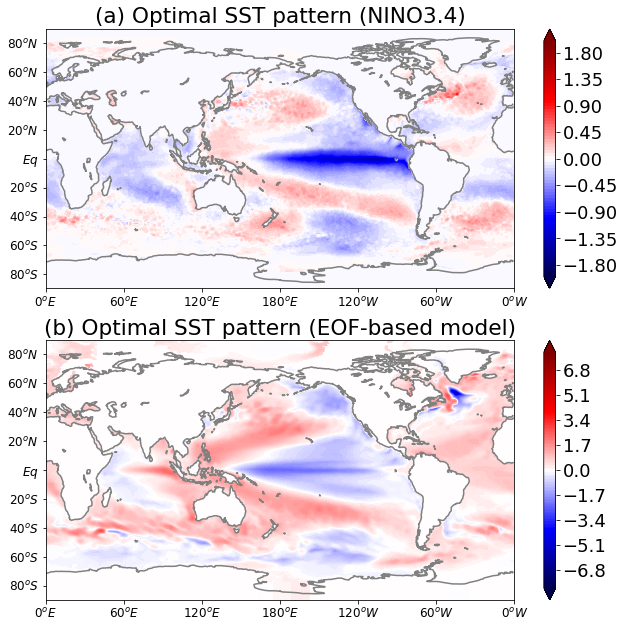

In [ ]:
sst_optimal = np.zeros((360,576))
for mode in range(7):
    sst_optimal = sst_EOF_maps[mode,:,:]*np.mean(coef_SPEAR_sst[11,11,2:,mode])+sst_optimal

fig = plt.figure()
plt.subplot(2,1,1)
cs=plt.contourf(xx_sst,yy_sst,-sst_NINO34,levels=np.arange(-2,2.05,0.05),cmap='seismic',extend='both')
plt.colorbar(cs)
plt.plot(costal_lon,costal_lat,'gray')
plt.xlim([0,360])
plt.xticks([0, 60, 120, 180,240,300,360], ['$0^oE$', '$60^oE$','$120^oE$', '$180^oE$', '$120^oW$', '$60^oW$', '$0^oW$'],fontsize=12) 
plt.yticks([-80,-60,-40,-20,0, 20,40,60,80], ['$80^oS$', '$60^oS$', '$40^oS$', '$20^oS$', '$Eq$', '$20^oN$', '$40^oN$', '$60^oN$', '$80^oN$'],fontsize=12)
plt.title('(a) Optimal SST pattern (NINO3.4)')

plt.subplot(2,1,2)
cs=plt.contourf(xx_sst,yy_sst,sst_optimal,levels=np.arange(-8,8.1,0.1),cmap='seismic',extend='both')
plt.colorbar(cs)
plt.plot(costal_lon,costal_lat,'gray')
plt.xlim([0,360])
plt.xticks([0, 60, 120, 180,240,300,360], ['$0^oE$', '$60^oE$','$120^oE$', '$180^oE$', '$120^oW$', '$60^oW$', '$0^oW$'],fontsize=12) 
plt.yticks([-80,-60,-40,-20,0, 20,40,60,80], ['$80^oS$', '$60^oS$', '$40^oS$', '$20^oS$', '$Eq$', '$20^oN$', '$40^oN$', '$60^oN$', '$80^oN$'],fontsize=12)
plt.title('(b) Optimal SST pattern (EOF-based model)')
#plt.plot(costal_lon,costal_lat,'gray')

fig.set_size_inches(10.5,10.5)


#fig.savefig('/home/Kai-chi.Tseng/2019_research/SPEAR_tornado/FIG5.pdf', dpi=300, bbox_inches='tight')
#fig.savefig('/home/Kai-chi.Tseng/2019_research/SPEAR_tornado/FIG5.png', dpi=300, bbox_inches='tight')


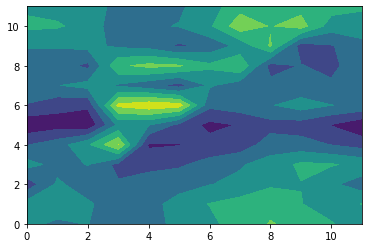

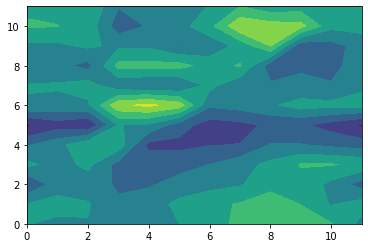

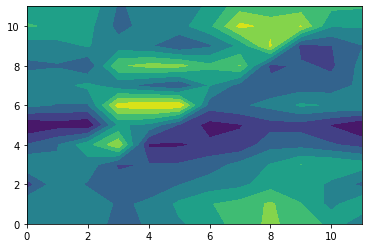

In [ ]:
plt.figure()
plt.contourf(coef_SPEAR_sst[:,:,2,6])
plt.figure()
plt.contourf(coef_SPEAR_sst[:,:,3,6])
plt.figure()
plt.contourf(coef_SPEAR_sst[:,:,4,6])


0.16245358603558577
0.06409277072437122


/net/kct/miniconda3/envs/noaa2/lib/python3.6/site-packages/ipykernel_launcher.py:47: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


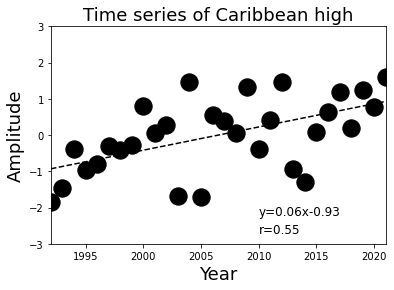

In [ ]:
# find the linear trend of Carribean Sea


diff_map   = np.reshape(composite_z500-composite_z500_NINO34,[130,520])
basis_map2 = np.reshape(z500_SPEAR,[12*30*15,130,520])
posi_y, posi_x = np.where((xx>=270) & (xx<300) & (yy>=20) & (yy<=40))
#plt.figure()
#plt.contourf(xx[posi_y,posi_x],yy[posi_y,posi_x],diff_map[posi_y,posi_x])
diff_map2         = np.reshape(diff_map[posi_y,posi_x],[1,np.size(posi_y)])
mexico_high_coef2 = diff_map2.dot(basis_map2[:,posi_y,posi_x].T)
mexico_high_coef2 = np.reshape(mexico_high_coef2,[12,30,15])
mexico_high_coef2 = np.mean(mexico_high_coef2,axis=2)


series1           = (mexico_high_coef2[2,:]-np.mean(mexico_high_coef2[2,:]))/np.std(mexico_high_coef2[2,:])
tt                = np.arange(0,30)

#PPH_monthly    = np.reshape(PPH_monthly,[PPH_monthly.shape[0],PPH_monthly.shape[1]*PPH_monthly.shape[2]]) # reshape 3D array to 2D array for matrix operation
X_mat              = np.vstack((np.ones(30), tt)).T

# coef_total = (X^T X)^(-1) (X^T Y) (you can check wikipedia: https://en.wikipedia.org/wiki/Linear_regression, section: Least-squares estimation and related techniques)
# coef_total contains both b and a. the first dimension of coef_total is b and the second dimension of coef_total is a  
coef_total         = np.linalg.inv(X_mat.T.dot(X_mat)).dot(X_mat.T).dot(series1)
high_detrend       = series1 - (coef_total[1]*tt+coef_total[0])


plt.figure()
#plt.plot(np.arange(1992,2022,1),series1)
#plt.plot(np.arange(1992,2022,1),tt*coef_total[1]+coef_total[0])

high_detrend       = series1 - (coef_total[1]*tt+coef_total[0])
print(1.69*np.std(high_detrend)/np.std(tt))
print(coef_total[1])

plt.scatter(np.arange(1992,2022,1),series1,s=300,color='k')
plt.plot(np.arange(1992,2022,1),tt*coef_total[1]+coef_total[0],'k--')
plt.text(2010,-2.2, 'y='+str(round(coef_total[1],2))+'x'+str(round(coef_total[0],2)), fontdict=None, color='black',fontsize=12)
plt.text(2010,-2.7, 'r='+str(round(np.corrcoef(tt,series1)[0][1],2)), fontdict=None, color='black',fontsize=12)

plt.xlabel('Year',fontsize=18)
plt.ylabel('Amplitude',fontsize=18)
#plt.xticks(np.arange(0.6,1.05,0.1),['0.6','0.7','0.8','0.9','1.0'],fontsize=18)
#plt.yticks(np.arange(-0.4,1.2,0.2),['-0.4','-0.2','0','0.2','0.4','0.6','0.8','1.0'],fontsize=18)
plt.ylim([-3,3.0])
plt.xlim([1992,2021])
plt.title('Time series of Caribbean high',fontsize=18)
fig.tight_layout(pad=2.0)
fig.set_size_inches(10.5,4.5)

fig.savefig('/home/Kai-chi.Tseng/2019_research/SPEAR_tornado/Caribbean_high.pdf', dpi=300, bbox_inches='tight')
fig.savefig('/home/Kai-chi.Tseng/2019_research/SPEAR_tornado/Caribbean_high.png', dpi=300, bbox_inches='tight')



In [ ]:
posi_y, posi_x = np.where((xx>=270) & (xx<300) & (yy>=20) & (yy<40))
np.shape(posi_x)

(2400,)

In [ ]:
high_detrend       = series1 - (coef_total[1]*tt+coef_total[0])
print(high_detrend)
print(2*np.std(high_detrend)/np.std(tt))

[-0.92787516 -0.5847384   0.42525435 -0.23494763 -0.13470334  0.29773937
  0.14434828  0.19555734  1.20681971  0.41603322  0.55314655 -1.45788949
  1.61989671 -1.62602833  0.5763736   0.35785601 -0.04800125  1.16913124
 -0.59981923  0.12325479  1.10910683 -1.36266619 -1.76375979 -0.45419098
  0.03268539  0.52014321 -0.55472046  0.43526822 -0.10127608  0.6680015 ]
0.19225276453915477


In [ ]:
np.std(tt)

8.65544144839919

In [ ]:
coef_total[1]

0.06409277072437122

(1, 5400)


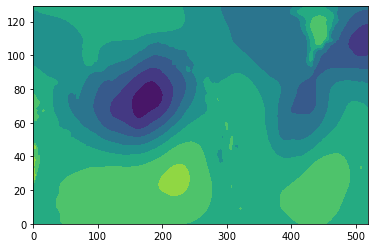

In [ ]:
print(np.shape(mexico_high_coef2))

plt.figure()
plt.contourf(z925_SPEAR[0,0,0,:,:])

# Figure 7

[[1.         0.71677613]
 [0.71677613 1.        ]]
[[1.         0.12907741]
 [0.12907741 1.        ]]


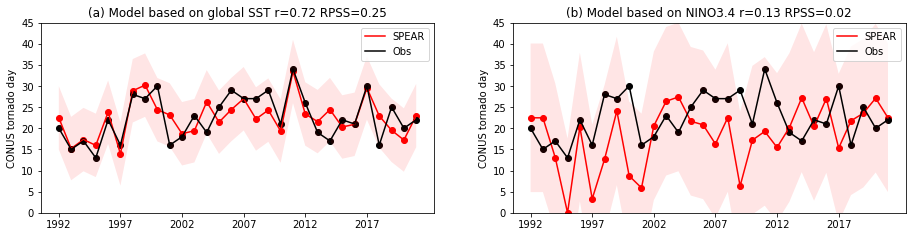

In [ ]:
np.shape(Y_val_LM_sst_EOF)
mean_Tday = np.mean(tornado_day_CONUS_monthly)
std_Tday  = np.std(tornado_day_CONUS_monthly)
std_range = np.std(Y_val_LM_sst_EOF[6,11,11,:] - tornado_day_CONUS_monthly)

fig=plt.figure()
plt.subplot(1,2,1)
plt.plot(Y_val_LM_sst_EOF[6,11,11,:],'r')
plt.scatter(np.arange(0,30),Y_val_LM_sst_EOF[6,11,11,:],color='r')
plt.plot(tornado_day_CONUS_monthly,'k')
plt.scatter(np.arange(0,30),tornado_day_CONUS_monthly,color='k')
plt.legend(['SPEAR','Obs'])
plt.ylabel('CONUS tornado day')
plt.fill_between(np.arange(0,30), Y_val_LM_sst_EOF[6,11,11,:]-2*std_range, Y_val_LM_sst_EOF[6,11,11,:]+2*std_range,facecolor='r',alpha=0.1)
score = np.corrcoef(Y_val_LM_sst_EOF[6,11,11,:],tornado_day_CONUS_monthly)[0][1]
plt.xticks(np.arange(0,30,5),np.arange(1992,2021,5))
plt.ylim([0,45])
plt.title('(a) Model based on global SST r='+str(round(score,2))+' RPSS='+str(round(RPSS[6,11,11],2)))
print(np.corrcoef(Y_val_LM_sst_EOF[6,11,11,:],tornado_day_CONUS_monthly))


series2   = Y_val_LM_sst[6,3,:]*std_Tday+mean_Tday
series2[series2<0]=0
std_range = np.std(series2- tornado_day_CONUS_monthly)


plt.subplot(1,2,2)
plt.plot(series2,'r')
plt.scatter(np.arange(0,30),series2,color='r')
plt.plot(tornado_day_CONUS_monthly,'k')
plt.scatter(np.arange(0,30),tornado_day_CONUS_monthly,color='k')
plt.legend(['SPEAR','Obs'])
plt.ylabel('CONUS tornado day')
plt.fill_between(np.arange(0,30), series2-2*std_range, series2+2*std_range,facecolor='r',alpha=0.1)
score = np.corrcoef(Y_val_LM_sst[6,3,:],tornado_day_CONUS_monthly)[0][1]
plt.title('(b) Model based on NINO3.4 r='+str(round(score,2))+' RPSS='+str(round(np.max(RPSS_NINO34[:,:]),2)))
plt.ylim([0,45])
plt.xticks(np.arange(0,30,5),np.arange(1992,2021,5))
#plt.xticklabels(np.arange(1995,2018,5))
fig.set_size_inches(15.5,3.5)
print(np.corrcoef(Y_val_LM_sst[6,3,:],tornado_day_CONUS_monthly))

#fig.savefig('/home/Kai-chi.Tseng/2019_research/SPEAR_tornado/FIG6.pdf', dpi=300, bbox_inches='tight')
#fig.savefig('/home/Kai-chi.Tseng/2019_research/SPEAR_tornado/FIG6.png', dpi=300, bbox_inches='tight')


[[1.         0.71677613]
 [0.71677613 1.        ]]
[[1.         0.12907741]
 [0.12907741 1.        ]]


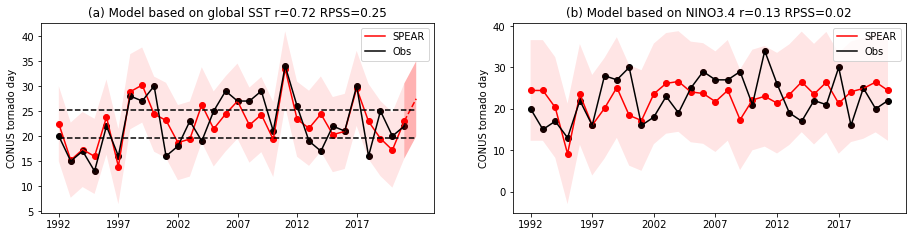

In [ ]:
pcs_obs_sst = np.reshape(pcs_obs_sst[:,:,:30,:],[20,12,30,12])
np.shape(pcs_obs_sst[0:13,11,0,11])
t           = np.arange(0,30)
init_month     = 11
forecast_month = 11
mode           = 6
mode,init_month,forecast_month
np.shape(Y_val_LM_sst_EOF)
mean_Tday = np.mean(tornado_day_CONUS_monthly)
std_Tday  = np.std(tornado_day_CONUS_monthly)
std_range = np.std(Y_val_LM_sst_EOF[6,11,11,:] - tornado_day_CONUS_monthly)
series1   = np.transpose(np.matmul(coef_SPEAR_sst[init_month,forecast_month,2:,0:mode],pcs_obs_sst[0:mode,init_month,:,forecast_month]/2)).mean(axis=1)
series1   = (series1-np.mean(series1))/np.std(series1)
upper_tercile = np.percentile(tornado_day_CONUS_monthly,66)
lower_tercile = np.percentile(tornado_day_CONUS_monthly,33)

fig=plt.figure()
plt.subplot(1,2,1)
plt.plot(t,Y_val_LM_sst_EOF[mode,init_month,forecast_month,:],'r', label='SPEAR')
series3     = series1*std_Tday+mean_Tday
series3[-2] = Y_val_LM_sst_EOF[mode,init_month,forecast_month,-1]
plt.plot(t[-2:]+1,series3[-2:],'r--')
plt.scatter(np.arange(0,30),Y_val_LM_sst_EOF[mode,init_month,forecast_month,:],color='r')
plt.plot(t,tornado_day_CONUS_monthly,'k', label='Obs')
plt.scatter(np.arange(0,30),tornado_day_CONUS_monthly,color='k')
plt.plot(np.arange(0,31),upper_tercile*np.ones(31),'k--')
plt.plot(np.arange(0,31),lower_tercile*np.ones(31),'k--')
plt.legend()
plt.ylabel('CONUS tornado day')
plt.fill_between(np.arange(0,30), Y_val_LM_sst_EOF[mode,init_month,forecast_month,:]-2*std_range, Y_val_LM_sst_EOF[mode,init_month,forecast_month,:]+2*std_range,facecolor='r',alpha=0.1)
plt.fill_between(np.arange(29,31), series3[-2:]-2*std_range, series3[-2:]+2*std_range,facecolor='r',alpha=0.3)
score = np.corrcoef(Y_val_LM_sst_EOF[mode,init_month,forecast_month,:],tornado_day_CONUS_monthly)[0][1]
plt.xticks(np.arange(0,30,5),np.arange(1992,2021,5))
plt.title('(a) Model based on global SST r='+str(round(score,2))+' RPSS='+str(round(RPSS[mode,init_month,forecast_month],2)))
print(np.corrcoef(Y_val_LM_sst_EOF[mode,init_month,forecast_month,:],tornado_day_CONUS_monthly))


series2   = ((Y_val_LM_sst[6,3,:]-np.mean(Y_val_LM_sst[6,3,:]))/np.std(Y_val_LM_sst[6,3,:]))*std_range+mean_Tday
series2[series2<0]=0
std_range = np.std(series2- tornado_day_CONUS_monthly)


plt.subplot(1,2,2)
plt.plot(series2,'r')
plt.scatter(np.arange(0,30),series2,color='r')
plt.plot(tornado_day_CONUS_monthly,'k')
plt.scatter(np.arange(0,30),tornado_day_CONUS_monthly,color='k')
plt.legend(['SPEAR','Obs'])
plt.ylabel('CONUS tornado day')
plt.fill_between(np.arange(0,30), series2-2*std_range, series2+2*std_range,facecolor='r',alpha=0.1)
score = np.corrcoef(Y_val_LM_sst[6,3,:],tornado_day_CONUS_monthly)[0][1]
plt.title('(b) Model based on NINO3.4 r='+str(round(score,2))+' RPSS='+str(round(np.max(RPSS_NINO34[:,:]),2)))
plt.xticks(np.arange(0,30,5),np.arange(1992,2021,5))
#plt.xticklabels(np.arange(1995,2018,5))
fig.set_size_inches(15.5,3.5)
print(np.corrcoef(Y_val_LM_sst[6,3,:],tornado_day_CONUS_monthly))
fig.savefig('/home/Kai-chi.Tseng/2019_research/SPEAR_tornado/FIG6_2022.pdf', dpi=300, bbox_inches='tight')
fig.savefig('/home/Kai-chi.Tseng/2019_research/SPEAR_tornado/FIG6_2022.png', dpi=300, bbox_inches='tight')


In [ ]:
mu, sigma = series3[-1], std_range # mean and standard deviation
s         = np.random.normal(mu, sigma, 1000)
print(np.size(np.where(s>upper_tercile)))
print(np.size(np.where(s<lower_tercile)))
print(1000-np.size(np.where(s>upper_tercile))-np.size(np.where(s<lower_tercile)))

642
74
284


In [ ]:
data        = np.load('/archive/Kai-chi.Tseng/data/SPEAR_tornado_seasonal/SST_EOFs_1995_2017_based_updated.npz')
pcs_obs_sst = data['pcs_obs_sst']
EOF         = data['EOF2']
pcs_obs_sst = np.reshape(pcs_obs_sst,[20,15,12,31,12])  # modes, member, init_month, year, forecast lead

[[1.         0.64676962]
 [0.64676962 1.        ]]
477
229
294
[[1.         0.64854562]
 [0.64854562 1.        ]]
306
229
465
[[1.         0.66847582]
 [0.66847582 1.        ]]
233
225
542


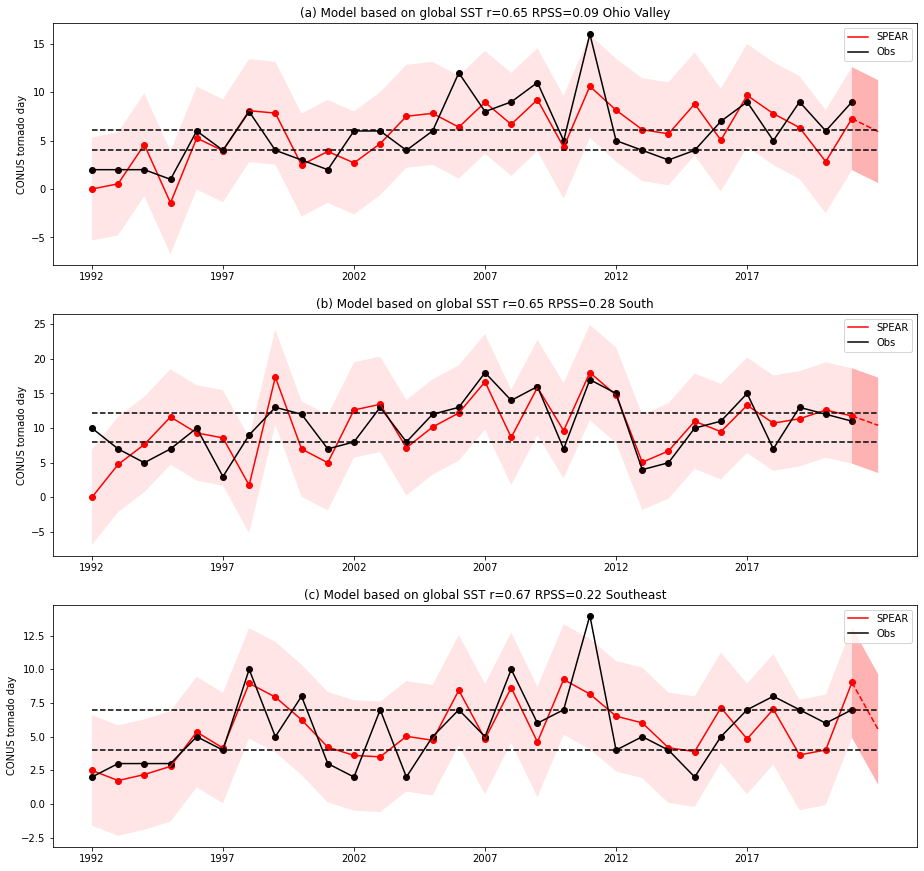

In [ ]:
data        = np.load('/archive/Kai-chi.Tseng/data/SPEAR_tornado_seasonal/SST_EOFs_1995_2017_based_updated.npz')
pcs_obs_sst = data['pcs_obs_sst']
EOF         = data['EOF2']
pcs_obs_sst = np.reshape(pcs_obs_sst,[20,15,12,31,12])  # modes, member, init_month, year, forecast lead
pcs_obs_sst = np.mean(pcs_obs_sst,axis=1)
# score by regions 
# tag
# 1= Northwest
# 2= West 
# 3= Northern_Rockies
# 4= Southwest
# 5= South
# 6= Midwest
# 7= Ohio Valley
# 8= Southeast
# 9= Northeast

# score by regions 
region         = 6
pcs_obs_sst    = np.reshape(pcs_obs_sst,[20,12,31,12])
np.shape(pcs_obs_sst[0:13,11,0,11])
t              = np.arange(0,30)
init_month     = 10
forecast_month = 0
mode           = 7
mode,init_month,forecast_month
np.shape(Y_val_LM_sst_EOF)
mean_Tday = np.mean(tornado_day_CONUS_monthly_region[:,region])
std_Tday  = np.std(tornado_day_CONUS_monthly_region[:,region])
std_range = np.std(Y_val_LM_sst_EOF_region[mode,init_month,forecast_month,:,region] - tornado_day_CONUS_monthly_region[:,region])
series1   = np.transpose(np.matmul(coef_SPEAR_sst_region[init_month,forecast_month,2:,0:mode,region],pcs_obs_sst[0:mode,init_month,:,forecast_month]/2)).mean(axis=1)
series1   = (series1-np.mean(series1))/np.std(series1)
upper_tercile = np.percentile(tornado_day_CONUS_monthly_region[:,region],66)
lower_tercile = np.percentile(tornado_day_CONUS_monthly_region[:,region],33)

fig=plt.figure()
plt.subplot(4,1,1)
plt.plot(t,Y_val_LM_sst_EOF_region[mode,init_month,forecast_month,:,region],'r', label='SPEAR')
series3     = series1*std_Tday+mean_Tday
series3[-2] = Y_val_LM_sst_EOF_region[mode,init_month,forecast_month,-1,region]
plt.plot(t[-2:]+1,series3[-2:],'r--')
plt.scatter(np.arange(0,30),Y_val_LM_sst_EOF_region[mode,init_month,forecast_month,:,region],color='r')
plt.plot(t,tornado_day_CONUS_monthly_region[:,region],'k', label='Obs')
plt.scatter(np.arange(0,30),tornado_day_CONUS_monthly_region[:,region],color='k')
plt.plot(np.arange(0,31),upper_tercile*np.ones(31),'k--')
plt.plot(np.arange(0,31),lower_tercile*np.ones(31),'k--')
plt.legend()
plt.ylabel('CONUS tornado day')
plt.fill_between(np.arange(0,30), Y_val_LM_sst_EOF_region[mode,init_month,forecast_month,:,region]-2*std_range, Y_val_LM_sst_EOF_region[mode,init_month,forecast_month,:,region]+2*std_range,facecolor='r',alpha=0.1)
plt.fill_between(np.arange(29,31), series3[-2:]-2*std_range, series3[-2:]+2*std_range,facecolor='r',alpha=0.3)
score = np.corrcoef(Y_val_LM_sst_EOF_region[mode,init_month,forecast_month,:,region],tornado_day_CONUS_monthly_region[:,region])[0][1]
plt.xticks(np.arange(0,30,5),np.arange(1992,2021,5))
plt.title('(a) Model based on global SST r='+str(round(score,2))+' RPSS='+str(round(RPSS_region[mode,init_month,forecast_month,region],2))+' Ohio Valley')
print(np.corrcoef(Y_val_LM_sst_EOF_region[mode,init_month,forecast_month,:,region],tornado_day_CONUS_monthly_region[:,region]))

mu, sigma = series3[-1], std_range # mean and standard deviation
s         = np.random.normal(mu, sigma, 1000)
print(np.size(np.where(s>upper_tercile)))
print(np.size(np.where(s<lower_tercile)))
print(1000-np.size(np.where(s>upper_tercile))-np.size(np.where(s<lower_tercile)))


region         = 4
pcs_obs_sst    = np.reshape(pcs_obs_sst,[20,12,31,12])
np.shape(pcs_obs_sst[0:13,11,0,11])
t              = np.arange(0,30)
init_month     = 1
forecast_month = 8
mode           = 12
mode,init_month,forecast_month
np.shape(Y_val_LM_sst_EOF)
mean_Tday = np.mean(tornado_day_CONUS_monthly_region[:,region])
std_Tday  = np.std(tornado_day_CONUS_monthly_region[:,region])
std_range = np.std(Y_val_LM_sst_EOF_region[mode,init_month,forecast_month,:,region] - tornado_day_CONUS_monthly_region[:,region])
series1   = np.transpose(np.matmul(coef_SPEAR_sst_region[init_month,forecast_month,2:,0:mode,region],pcs_obs_sst[0:mode,init_month,:,forecast_month]/2)).mean(axis=1)
series1   = (series1-np.mean(series1))/np.std(series1)
upper_tercile = np.percentile(tornado_day_CONUS_monthly_region[:,region],66)
lower_tercile = np.percentile(tornado_day_CONUS_monthly_region[:,region],33)

plt.subplot(4,1,2)
plt.plot(t,Y_val_LM_sst_EOF_region[mode,init_month,forecast_month,:,region],'r', label='SPEAR')
series3     = series1*std_Tday+mean_Tday
series3[-2] = Y_val_LM_sst_EOF_region[mode,init_month,forecast_month,-1,region]
plt.plot(t[-2:]+1,series3[-2:],'r--')
plt.scatter(np.arange(0,30),Y_val_LM_sst_EOF_region[mode,init_month,forecast_month,:,region],color='r')
plt.plot(t,tornado_day_CONUS_monthly_region[:,region],'k', label='Obs')
plt.scatter(np.arange(0,30),tornado_day_CONUS_monthly_region[:,region],color='k')
plt.plot(np.arange(0,31),upper_tercile*np.ones(31),'k--')
plt.plot(np.arange(0,31),lower_tercile*np.ones(31),'k--')
plt.legend()
plt.ylabel('CONUS tornado day')
plt.fill_between(np.arange(0,30), Y_val_LM_sst_EOF_region[mode,init_month,forecast_month,:,region]-2*std_range, Y_val_LM_sst_EOF_region[mode,init_month,forecast_month,:,region]+2*std_range,facecolor='r',alpha=0.1)
plt.fill_between(np.arange(29,31), series3[-2:]-2*std_range, series3[-2:]+2*std_range,facecolor='r',alpha=0.3)
score = np.corrcoef(Y_val_LM_sst_EOF_region[mode,init_month,forecast_month,:,region],tornado_day_CONUS_monthly_region[:,region])[0][1]
plt.xticks(np.arange(0,30,5),np.arange(1992,2021,5))
plt.title('(b) Model based on global SST r='+str(round(score,2))+' RPSS='+str(round(RPSS_region[mode,init_month,forecast_month,region],2))+' South')
print(np.corrcoef(Y_val_LM_sst_EOF_region[mode,init_month,forecast_month,:,region],tornado_day_CONUS_monthly_region[:,region]))

mu, sigma = series3[-1], std_range # mean and standard deviation
s         = np.random.normal(mu, sigma, 1000)
print(np.size(np.where(s>upper_tercile)))
print(np.size(np.where(s<lower_tercile)))
print(1000-np.size(np.where(s>upper_tercile))-np.size(np.where(s<lower_tercile)))


region         = 7
pcs_obs_sst    = np.reshape(pcs_obs_sst,[20,12,31,12])
np.shape(pcs_obs_sst[0:13,11,0,11])
t              = np.arange(0,30)
init_month     = 1
forecast_month = 2
mode           = 6
mode,init_month,forecast_month
np.shape(Y_val_LM_sst_EOF)
mean_Tday = np.mean(tornado_day_CONUS_monthly_region[:,region])
std_Tday  = np.std(tornado_day_CONUS_monthly_region[:,region])
std_range = np.std(Y_val_LM_sst_EOF_region[mode,init_month,forecast_month,:,region] - tornado_day_CONUS_monthly_region[:,region])
series1   = np.transpose(np.matmul(coef_SPEAR_sst_region[init_month,forecast_month,2:,0:mode,region],pcs_obs_sst[0:mode,init_month,:,forecast_month]/2)).mean(axis=1)
series1   = (series1-np.mean(series1))/np.std(series1)
upper_tercile = np.percentile(tornado_day_CONUS_monthly_region[:,region],66)
lower_tercile = np.percentile(tornado_day_CONUS_monthly_region[:,region],33)

plt.subplot(4,1,3)
plt.plot(t,Y_val_LM_sst_EOF_region[mode,init_month,forecast_month,:,region],'r', label='SPEAR')
series3     = series1*std_Tday+mean_Tday
series3[-2] = Y_val_LM_sst_EOF_region[mode,init_month,forecast_month,-1,region]
plt.plot(t[-2:]+1,series3[-2:],'r--')
plt.scatter(np.arange(0,30),Y_val_LM_sst_EOF_region[mode,init_month,forecast_month,:,region],color='r')
plt.plot(t,tornado_day_CONUS_monthly_region[:,region],'k', label='Obs')
plt.scatter(np.arange(0,30),tornado_day_CONUS_monthly_region[:,region],color='k')
plt.plot(np.arange(0,31),upper_tercile*np.ones(31),'k--')
plt.plot(np.arange(0,31),lower_tercile*np.ones(31),'k--')
plt.legend()
plt.ylabel('CONUS tornado day')
plt.fill_between(np.arange(0,30), Y_val_LM_sst_EOF_region[mode,init_month,forecast_month,:,region]-2*std_range, Y_val_LM_sst_EOF_region[mode,init_month,forecast_month,:,region]+2*std_range,facecolor='r',alpha=0.1)
plt.fill_between(np.arange(29,31), series3[-2:]-2*std_range, series3[-2:]+2*std_range,facecolor='r',alpha=0.3)
score = np.corrcoef(Y_val_LM_sst_EOF_region[mode,init_month,forecast_month,:,region],tornado_day_CONUS_monthly_region[:,region])[0][1]
plt.xticks(np.arange(0,30,5),np.arange(1992,2021,5))
plt.title('(c) Model based on global SST r='+str(round(score,2))+' RPSS='+str(round(RPSS_region[mode,init_month,forecast_month,region],2))+' Southeast')
print(np.corrcoef(Y_val_LM_sst_EOF_region[mode,init_month,forecast_month,:,region],tornado_day_CONUS_monthly_region[:,region]))


mu, sigma = series3[-1], std_range # mean and standard deviation
s         = np.random.normal(mu, sigma, 1000)
print(np.size(np.where(s>upper_tercile)))
print(np.size(np.where(s<lower_tercile)))
print(1000-np.size(np.where(s>upper_tercile))-np.size(np.where(s<lower_tercile)))


fig.set_size_inches(15.5,20.5)
#print(np.corrcoef(Y_val_LM_sst_region[6,3,:,region],tornado_day_CONUS_monthly_region[:,region]))
fig.savefig('/home/Kai-chi.Tseng/2019_research/SPEAR_tornado/FIG6_regions.pdf', dpi=300, bbox_inches='tight')
fig.savefig('/home/Kai-chi.Tseng/2019_research/SPEAR_tornado/FIG6_regions.png', dpi=300, bbox_inches='tight')


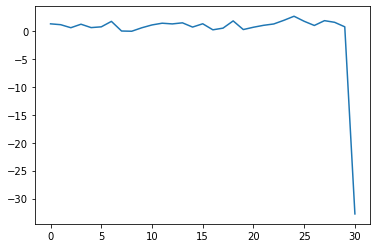

In [ ]:
plt.plot(np.transpose(pcs_obs_sst[0,1,:,1]))

In [ ]:

init   = 1 
target = 1
plt.figure()
plt.plot(np.transpose(pcs_obs_sst[0,:,init,:,target]))


init   = 5 
target = 9
plt.figure()
plt.plot(np.transpose(pcs_obs_sst[0,:,init,:,target]))


IndexError: too many indices for array: array is 3-dimensional, but 5 were indexed

<Figure size 432x288 with 0 Axes>

In [ ]:
np.shape(pcs_obs_sst)

(20, 15, 12, 23, 12)

[[ 1.         -0.02850219]
 [-0.02850219  1.        ]]
[[ 1.         -0.05628418]
 [-0.05628418  1.        ]]
[[ 1.         -0.23258097]
 [-0.23258097  1.        ]]
[[ 1.         -0.02063339]
 [-0.02063339  1.        ]]


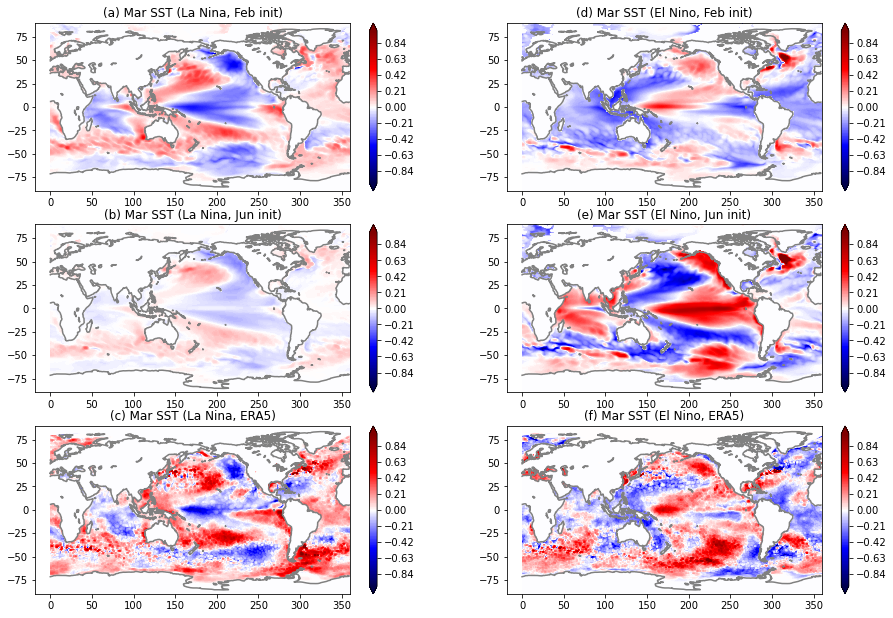

In [ ]:
data                 = np.load('/archive/Kai-chi.Tseng/data/SPEAR_tornado_seasonal/SST_EOFs.npz')
pcs_obs_sst          = data['pcs_obs_sst']
pcs_obs_sst          = np.reshape(pcs_obs_sst,[20,15,12,23,12])

weight2              = np.power(np.cos(yy_sst/180*3.14),0.5)
# intercomparison of NINO and NINA composite SST
series1  = tornado_day_CONUS_monthly
posi1    = np.squeeze(np.where(series1 < np.percentile(series1,25)))
posi2    = np.squeeze(np.where(series1 > np.percentile(series1,75)))


init   = 5 
target = 9
sst_NINO_long_lead = np.zeros((360,576))
sst_NINA_long_lead = np.zeros((360,576))
for mode in range(7):
    PCS                 = pcs_obs_sst[:,:,init,posi1,target].mean(axis=1)
    sst_NINO_long_lead  = sst_EOF_maps[mode,:,:]*(PCS.mean(axis=1))[mode]+sst_NINO_long_lead
    PCS                 = pcs_obs_sst[:,:,init,posi2,target].mean(axis=1)
    sst_NINA_long_lead  = sst_EOF_maps[mode,:,:]*(PCS.mean(axis=1))[mode]+sst_NINA_long_lead
    
    
init   = 1 
target = 1
sst_NINO_short_lead = np.zeros((360,576))
sst_NINA_short_lead = np.zeros((360,576))
for mode in range(7):
    PCS                 = pcs_obs_sst[:,:,init,posi1,target].mean(axis=1)
    sst_NINO_short_lead = sst_EOF_maps[mode,:,:]*(PCS.mean(axis=1))[mode]+sst_NINO_short_lead
    PCS                 = pcs_obs_sst[:,:,init,posi2,target].mean(axis=1)
    sst_NINA_short_lead = sst_EOF_maps[mode,:,:]*(PCS.mean(axis=1))[mode]+sst_NINA_short_lead    

    
#sst_monthly_anomaly = observational SST pattern 
obs_NINO = np.reshape(sst_monthly_anomaly,[23,12,360,576])
obs_NINO = obs_NINO[posi1,2,:,:].mean(axis=0)


#sst_monthly_anomaly = observational SST pattern 
obs_NINA = np.reshape(sst_monthly_anomaly,[23,12,360,576])
obs_NINA = obs_NINA[posi2,2,:,:].mean(axis=0)




fig=plt.figure()    
plt.subplot(3,2,1)
cs=plt.contourf(xx_sst,yy_sst,sst_NINA_short_lead,np.arange(-1,1.01,0.01),cmap='seismic',extend='both')
plt.colorbar(cs)
series1 = np.reshape(obs_NINA*weight2,[360*576])
series2 = np.reshape(sst_NINA_short_lead*weight2,[360*576])
print(np.corrcoef(series1,series2))
plt.plot(costal_lon,costal_lat,'gray')
plt.title('(a) Mar SST (La Nina, Feb init)')

plt.subplot(3,2,3)
cs=plt.contourf(xx_sst,yy_sst,sst_NINA_long_lead,np.arange(-1,1.01,0.01),cmap='seismic',extend='both')
plt.colorbar(cs)
series1 = np.reshape(obs_NINA*weight2,[360*576])
series2 = np.reshape(sst_NINA_long_lead*weight2,[360*576])
print(np.corrcoef(series1,series2))
plt.plot(costal_lon,costal_lat,'gray')
plt.title('(b) Mar SST (La Nina, Jun init)')

obs_NINA[obs_NINA<-1000] = 0
plt.subplot(3,2,5)
cs=plt.contourf(xx_sst,yy_sst,obs_NINA,np.arange(-1,1.01,0.01),cmap='seismic',extend='both')
plt.colorbar(cs)
plt.plot(costal_lon,costal_lat,'gray')
plt.title('(c) Mar SST (La Nina, ERA5)')

plt.subplot(3,2,2)
cs=plt.contourf(xx_sst,yy_sst,sst_NINO_short_lead,np.arange(-1,1.01,0.01),cmap='seismic',extend='both')
plt.colorbar(cs)
series1 = np.reshape(obs_NINO*weight2,[360*576])
series2 = np.reshape(sst_NINO_short_lead*weight2,[360*576])
print(np.corrcoef(series1,series2))
plt.plot(costal_lon,costal_lat,'gray')
plt.title('(d) Mar SST (El Nino, Feb init)')

plt.subplot(3,2,4)
cs=plt.contourf(xx_sst,yy_sst,sst_NINO_long_lead,np.arange(-1,1.01,0.01),cmap='seismic',extend='both')
plt.colorbar(cs)
series1 = np.reshape(obs_NINO*weight2,[360*576])
series2 = np.reshape(sst_NINO_long_lead*weight2,[360*576])
print(np.corrcoef(series1,series2))
plt.plot(costal_lon,costal_lat,'gray')
plt.title('(e) Mar SST (El Nino, Jun init)')

obs_NINO[obs_NINO<-1000] = 0
plt.subplot(3,2,6)
cs=plt.contourf(xx_sst,yy_sst,obs_NINO,np.arange(-1,1.01,0.01),cmap='seismic',extend='both')
plt.colorbar(cs)
plt.plot(costal_lon,costal_lat,'gray')
plt.title('(f) Mar SST (El Nino, ERA5)')

fig.set_size_inches(15.5,10.5)







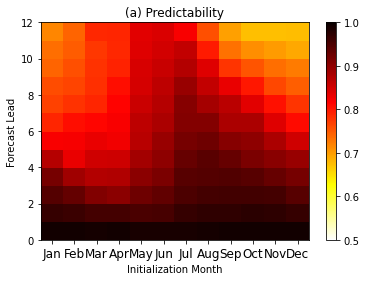

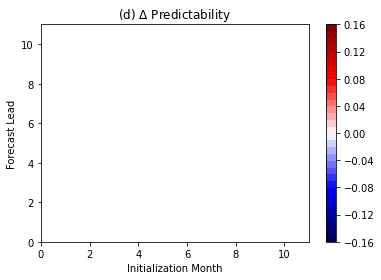

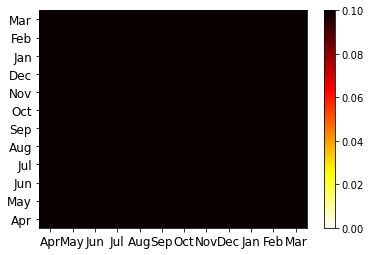

In [ ]:
# calculate the signal to noise ratio 
# dimension of pcs_obs_sst = modes, ensemble member, initialization month, year, target month 
data             = np.load('/archive/Kai-chi.Tseng/data/SPEAR_tornado_seasonal/SST_EOFs_1995_2017_based.npz')
pcs_obs_sst      = data['pcs_obs_sst']
variance         = data['variance']
pcs_obs_sst         = np.reshape(pcs_obs_sst,[20,15,12,30,12])
pcs_obs_sst_anomaly = pcs_obs_sst - np.reshape(pcs_obs_sst.mean(axis=1),[20,1,12,30,12])
variance            = np.reshape(variance,[1,20])
#variance            = np.reshape((coef_SPEAR_sst[11,11,1:,:]**2).mean(axis=0),[1,7])

mode = 0
predictability = np.zeros((20,12,12))
for mode in range(19):
    for init in range(12):
        for target in range(12):
            predictability[mode,init,target] = 1-np.power(pcs_obs_sst_anomaly[mode,:,init,:,target],2).mean(axis=0).mean(axis=0)/np.power(pcs_obs_sst[mode,:,init,:,target],2).mean(axis=0).mean(axis=0)
            

predictability          = np.reshape(predictability,[20,12*12])
predictability_weighted = np.reshape(np.matmul(variance[0,0:2],predictability[0:2,:]),[12,12])/np.sum(variance[0,0:2])
   
score_map4                     = np.zeros((12,12))
relevant_predictability_target = np.zeros((12,12))
relevant_predictability        = predictability_weighted[:,:]

count = 0 
for init_time in ['01','02','03','04','05','06','07','08','09','10','11','12']:
    #print(init_time)
    dates  = pd.date_range('1995-'+init_time, '1997-01-31', freq='1m') # total length of reanalysis data
    for forecast_lead in range(12):
        #print(dates[forecast_lead].month)
        relevant_predictability_target[count,dates[forecast_lead].month-1] = relevant_predictability[count,forecast_lead]
    count=count+1

template   = np.concatenate((relevant_predictability_target, relevant_predictability_target, relevant_predictability_target), axis=0)
template   = np.concatenate((template,template,template),axis=1)
score_map4[:,:] = template[3:15,3:15]
                            
#predictability = np.zeros((20,12,12)) # mode, init month, target month             
plt.figure()
#cs=plt.contourf(np.transpose(predictability_weighted),cmap=my_map,levels=np.arange(0.5,1.02,0.02))
cs=plt.pcolormesh(np.transpose(predictability_weighted),vmin=0.5,vmax=1,cmap=my_map)
plt.xticks(np.arange(0.5,12,1),('Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct', 'Nov',\
                                'Dec'),fontsize=12)
plt.colorbar(cs)
plt.xlabel('Initialization Month')
plt.ylabel('Forecast Lead')
plt.title('(a) Predictability')


#fig, axs = plt.subplots(1, 2, gridspec_kw={'width_ratios': [2, 3]})
#cs1      = axs[0].pcolormesh(np.transpose(score_map2[:,1:]),vmin=0,vmax=1,cmap=my_map)
#axs[0].set_xticks(np.arange(0.5,17,1), minor=False)
#axs[0].set_xticklabels(['Dec','Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct', 'Nov',\
#                                'Dec','Jan','Feb','Mar','Apr'], fontdict=None, minor=False)
#axs[0].set_yticks(np.arange(0.5,12,1), minor=False)
#axs[0].set_yticklabels(np.arange(0,12,1), fontdict=None, minor=False)
#axs[0].set_ylim([0,12])
#axs[0].set_xlabel('Initialization Month',fontsize=18)
#axs[0].set_ylabel('Forecast Lead',fontsize=18)


plt.figure()
cs=plt.contourf(np.transpose(relevant_predictability[:,:]),cmap='seismic',levels=np.arange(-0.16,0.17,0.01))
plt.colorbar(cs)
plt.xlabel('Initialization Month')
plt.ylabel('Forecast Lead')
plt.title('(d) $\Delta$ Predictability')

plt.figure()
cs  = plt.pcolor(np.transpose(score_map4[:,:]),cmap=my_map,vmin=0,vmax=0.1)
plt.xticks(np.arange(0.5,12,1),('Apr','May','Jun','Jul','Aug','Sep','Oct', 'Nov',\
                        'Dec','Jan','Feb','Mar'),fontsize=12)
plt.yticks(np.arange(0.5,12,1),('Apr','May','Jun','Jul','Aug','Sep','Oct', 'Nov',\
                        'Dec','Jan','Feb','Mar'),fontsize=12)
plt.colorbar(cs)

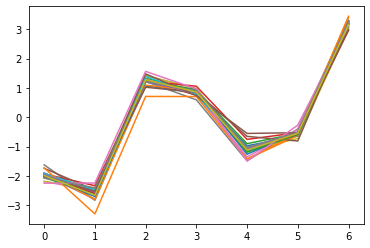

In [ ]:
plt.plot(np.transpose(coef_SPEAR_sst[11,11,1:,:]))

1.1042602542041822


/net/kct/miniconda3/envs/noaa2/lib/python3.6/site-packages/ipykernel_launcher.py:51: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


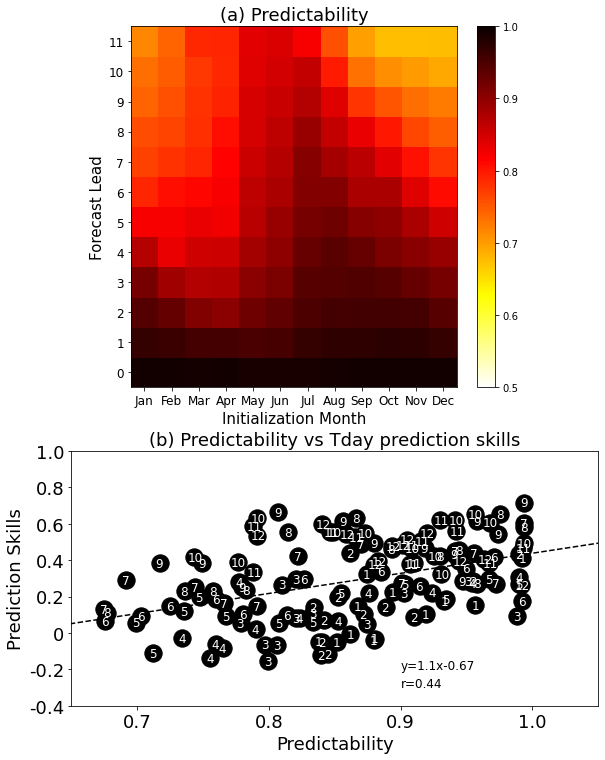

In [ ]:
grid   = plt.GridSpec(7, 10, wspace=0.15, hspace=1.5)

fig=plt.figure()
plt.subplot(grid[0:4, 1:8])
cs=plt.pcolormesh(np.transpose(predictability_weighted),vmin=0.5,vmax=1,cmap=my_map)
plt.xticks(np.arange(0.5,12,1),('Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct', 'Nov',\
                                'Dec'),fontsize=12)
plt.colorbar(cs)
plt.xlabel('Initialization Month',fontsize=15)
plt.ylabel('Forecast Lead',fontsize=15)
plt.title('(a) Predictability',fontsize=18)
plt.yticks(np.arange(0.5,12,1),np.arange(0,12,1),fontsize=12)
#plt.set_yticklabels(np.arange(0,12,1), fontdict=None, minor=False)

plt.subplot(grid[4:7, 0:9])
series1 = np.reshape(score_map3,[12,12])
series2 = np.reshape(score_map4[:,:],[12,12])
for i in range(1,13):
    for j in range(1,13):
        plt.scatter(series2[i-1,j-1],series1[i-1,j-1], s=300, c='k', marker='o')
        if j<10:
            plt.text(series2[i-1,j-1]-0.003,series1[i-1,j-1]-0.022, j, fontdict=None, color='white',fontsize=12)
        else:
            plt.text(series2[i-1,j-1]-0.005,series1[i-1,j-1]-0.022, j, fontdict=None, color='white',fontsize=12)
series2 = np.reshape(series2,[12*12,])
series1 = np.reshape(series1,[12*12,])

#PPH_monthly    = np.reshape(PPH_monthly,[PPH_monthly.shape[0],PPH_monthly.shape[1]*PPH_monthly.shape[2]]) # reshape 3D array to 2D array for matrix operation
X_mat              = np.vstack((np.ones(144), series2)).T

# coef_total = (X^T X)^(-1) (X^T Y) (you can check wikipedia: https://en.wikipedia.org/wiki/Linear_regression, section: Least-squares estimation and related techniques)
# coef_total contains both b and a. the first dimension of coef_total is b and the second dimension of coef_total is a  
coef_total         = np.linalg.inv(X_mat.T.dot(X_mat)).dot(X_mat.T).dot(series1)

# as mentioned previously, "a" represents the warming trend of cape and "b" is the cape value in reference year
reg_slope          = coef_total[1]
reg_intercept      = coef_total[0]
print(reg_slope)
plt.plot(np.arange(0,1.1,0.01),np.arange(0,1.1,0.01)*reg_slope+reg_intercept,'k--')
plt.text(0.9,-0.2, 'y='+str(round(reg_slope,2))+'x'+str(round(reg_intercept,2)), fontdict=None, color='black',fontsize=12)
plt.text(0.9,-0.3, 'r='+str(round(np.corrcoef(series1,series2)[0][1],2)), fontdict=None, color='black',fontsize=12)

plt.xlabel('Predictability',fontsize=18)
plt.ylabel('Prediction Skills',fontsize=18)
plt.xticks(np.arange(0.6,1.05,0.1),['0.6','0.7','0.8','0.9','1.0'],fontsize=18)
plt.yticks(np.arange(-0.4,1.2,0.2),['-0.4','-0.2','0','0.2','0.4','0.6','0.8','1.0'],fontsize=18)
plt.ylim([-0.4,1.0])
plt.xlim([0.65,1.05])
np.corrcoef(series1,series2)
plt.title('(b) Predictability vs Tday prediction skills',fontsize=18)
fig.tight_layout(pad=2.0)
fig.set_size_inches(10.5,12.5)
#fig.savefig('/home/Kai-chi.Tseng/2019_research/SPEAR_tornado/FIG5.pdf', dpi=300, bbox_inches='tight')
#fig.savefig('/home/Kai-chi.Tseng/2019_research/SPEAR_tornado/FIG5.png', dpi=300, bbox_inches='tight')


In [ ]:
!pwd

/home/Kai-chi.Tseng/2019_research/SPEAR_tornado


array([[1.        , 0.38060664],
       [0.38060664, 1.        ]])

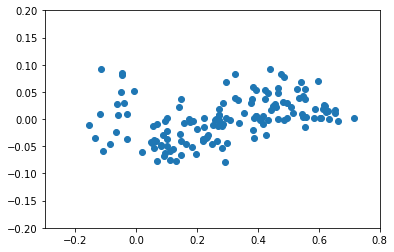

In [ ]:
series1 = np.reshape(score_map3,[12*12,])
series2 = np.reshape(score_map4[:,:],[12*12,])
plt.figure()
plt.scatter(series1,series2)
plt.xlim([-0.3,0.8])
plt.ylim([-0.2,0.2])
np.corrcoef(series1,series2)

In [ ]:
np.shape(predictability)

(20, 144)

array([[ 1.        , -0.64192557],
       [-0.64192557,  1.        ]])

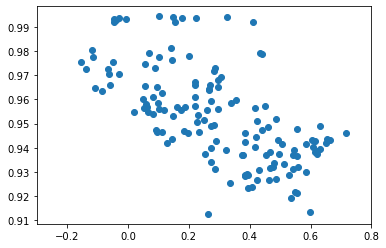

In [ ]:
series1 = np.reshape(score_map3,[12*12,])
series2 = np.reshape(predictability[1,:],[12*12,])
plt.figure()
plt.scatter(series1,series2)
plt.xlim([-0.3,0.8])
#plt.ylim([-0.05,0.05])
np.corrcoef(series1,series2)

In [ ]:
np.shape(score_map3)

(12, 12)

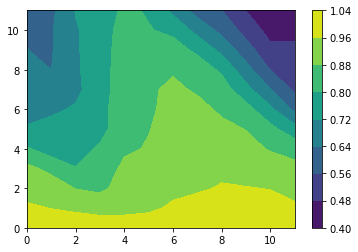

In [ ]:
plt.figure()
cs=plt.contourf(np.transpose(predictability))
plt.colorbar(cs)

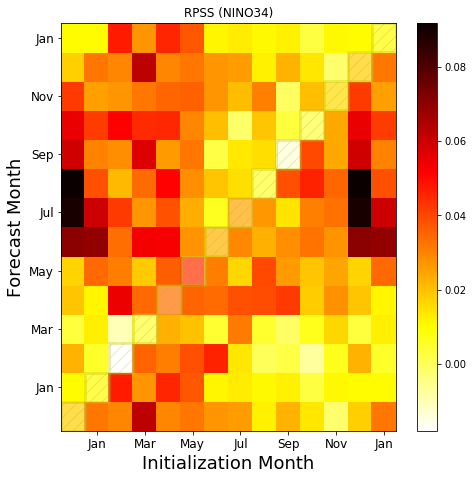

In [ ]:
fig= plt.figure()
score_map2            = np.zeros((14,14))
score_map2[1:-1,1:-1] = RPSS_NINO34[:,:]
score_map2[0,1:-1]    = RPSS_NINO34[:,:][-1,:]
score_map2[-1,1:-1]   = RPSS_NINO34[:,:][0,:]
score_map2[:,0]       = score_map2[:,-2]
score_map2[:,-1]      = score_map2[:,1]
    
plt.title('RPSS (NINO34)')
x_ticks= np.arange(0,12)
plt.xticks(x_ticks,x_ticks+1)
plt.yticks(x_ticks,x_ticks+1)
    
cs  = plt.pcolor(np.transpose(score_map2),cmap=my_map)
plt.colorbar(cs)
plt.xticks(np.arange(1.5,14,2),('Jan','Mar','May','Jul','Sep','Nov',\
                                    'Jan','Mar'),fontsize=12)
plt.yticks(np.arange(1.5,14,2),('Jan','Mar','May','Jul','Sep','Nov',\
                                    'Jan','Mar'),fontsize=12)
for j in range(0,14):
    x1 = [j,j+1,j+1,j]
    y1 = [(j)-1+1,(j)-1+1,(j)-1+2,(j)-1+2]
    plt.fill(x1,y1 , facecolor="white",edgecolor='y',hatch='//',alpha=0.3,linewidth=3)
#if mode>8:
#    plt.xlabel('Forecast Month (predictor)')
#plt.ylabel('Initialization Month ')
plt.xlabel('Initialization Month',fontsize=18)
plt.ylabel('Forecast Month',fontsize=18)
fig.set_size_inches(7.5, 7.5)    

In [ ]:
!pwd
!ls

/home/Kai-chi.Tseng/2019_research/SPEAR_tornado
CAPE_calculation.ipynb
data
empirical_model2.ipynb
empirical_model-FEB_ML.ipynb
empirical_model-figures.ipynb
empirical_model_individual_variables.ipynb
empirical_model-JAN_ML.ipynb
empirical_model-MAR_ML.ipynb
empirical_model-obs.ipynb
FIG1.pdf
FIG1.png
FIG2.pdf
FIG2.png
FIG3.pdf
FIG3.png
FIG4.pdf
FIG4.png
FIG5.pdf
FIG5.png
FIG6.pdf
FIG6.png
FIG7.pdf
FIG7.png
FIGS1.pdf
FIGS1.png
FIGS2.pdf
FIGS2.png
Figures_1992_2018.ipynb
Figures_AM.ipynb
Figures_and_loading_data.ipynb
Figures_MA.ipynb
Figures_optimal_input.py
getfile.sh
list.txt
Paper_Figures_final .ipynb
Passive_tracer.ipynb
SHARPpy
SRH_calculation.ipynb
SRH_calculation_not_for_loading_data.ipynb
test.txt


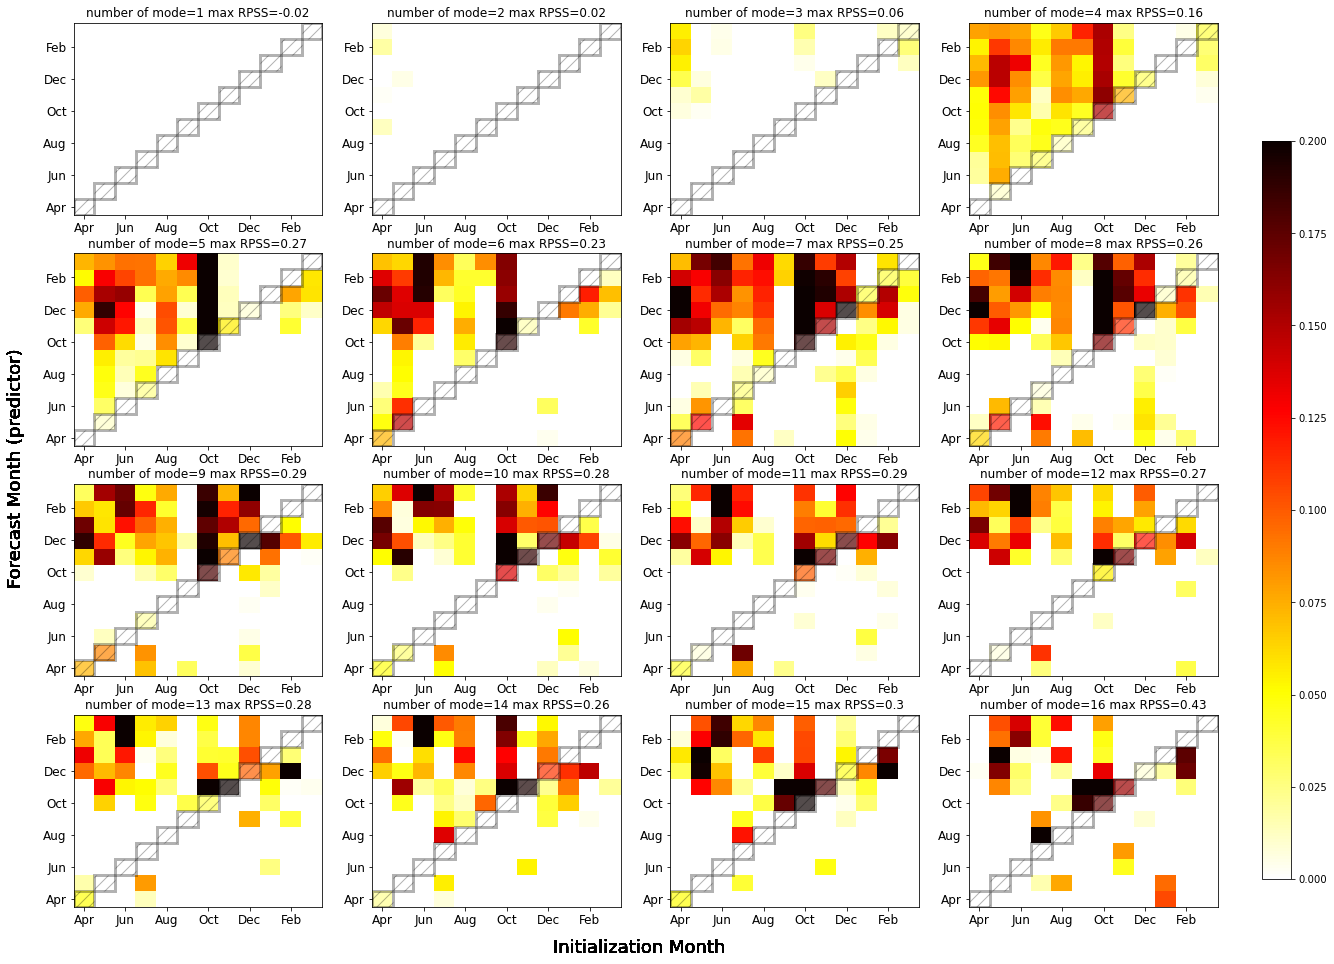

In [ ]:
my_map = 'hot_r'
fig=plt.figure()
for mode in range(16):
    plt.subplot(5,4,mode+1)
    score_map2            = np.zeros((14,14))
    score_map2[1:-1,1:-1] = RPSS[mode,:,:]
    score_map2[0,1:-1]    = RPSS[mode,:,:][-1,:]
    score_map2[-1,1:-1]   = RPSS[mode,:,:][0,:]
    score_map2[:,0]       = score_map2[:,-2]
    score_map2[:,-1]      = score_map2[:,1]
    
    plt.title('number of mode='+str(mode+1)+' max corr='+str(round(np.max(score_map_EOF[mode,:,:]),2)))
    template   = np.concatenate((score_map2[1:13,1:13], score_map2[1:13,1:13], score_map2[1:13,1:13]), axis=0)
    template   = np.concatenate((template,template,template),axis=1)
    score_map3 = template[3:15,3:15]
    
    plt.title('number of mode='+str(mode+1)+' max RPSS='+str(round(np.max(RPSS[mode,:,:]),2)))
    x_ticks= np.arange(0,12)
    plt.xticks(x_ticks,x_ticks+1)
    plt.yticks(x_ticks,x_ticks+1)
    
    cs  = plt.pcolor(np.transpose(score_map3),cmap=my_map,vmin=0,vmax=0.2)
    #plt.colorbar(cs)
    
   
    plt.xticks(np.arange(0.5,17,2),('Apr','Jun','Aug','Oct', \
                                    'Dec','Feb','Apr','Jun','Aug'),fontsize=12)
    plt.yticks(np.arange(0.5,17,2),('Apr','Jun','Aug','Oct',\
                                    'Dec','Feb','Apr','Jun','Aug'),fontsize=12)
    
    for j in range(0,14):
        x1 = [j,j+1,j+1,j]
        y1 = [(j)-1+1,(j)-1+1,(j)-1+2,(j)-1+2]
        plt.fill(x1,y1 , facecolor="white",edgecolor='k',hatch='//',alpha=0.3,linewidth=3)
    #if mode>8:
    #    plt.xlabel('Forecast Month (predictor)')
    #plt.ylabel('Initialization Month ')
    posi_x,posi_y = np.where(score_map3>0.44)
    plt.scatter(posi_x+0.5,posi_y+0.5,25,'w')
    plt.scatter(posi_x+0.5,posi_y+0.5,8,'k')
    plt.ylim(0,12)
    plt.xlim(0,12)
    fig.text(0.45, 0.25, 'Initialization Month ',fontsize=18)
    fig.text(0.08, 0.5, 'Forecast Month (predictor)', rotation='vertical',fontsize=18)
fig.set_size_inches(20.5, 15.5)
cbar_ax = fig.add_axes([0.93, 0.3, 0.02, 0.5])   
cbar = fig.colorbar(cs, cax=cbar_ax, orientation='vertical')
fig.set_size_inches(20.5, 20.5)
fig.set_size_inches(20.5, 20.5)